In [9]:
import tensorflow as tf
import pandas as pd
import os, time, itertools, imageio, pickle, random
import numpy as np
import matplotlib.pyplot as plt
import random

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

ImportError: cannot import name 'mpl'

In [7]:
# one hot code
def one_hot ( labels , Label_class ): 
    one_hot_label = np.array([[ int (i == int (labels[j])) for i in range (Label_class)] for j in range ( len (labels))])      
    return one_hot_label

In [8]:
img_width = 30
img_height = 24

data_alt3 = pd.read_csv('./data/election_data_alt3_resize.csv')
data_alt3 = data_alt3.iloc[:,1:].values

data_alt3 = data_alt3.reshape([-1, img_height, img_width])
print(data_alt3.shape)

##################################
data_alt4 = pd.read_csv('./data/election_data_alt4_resize.csv')
data_alt4 = data_alt4.iloc[:,1:].values

data_alt4 = data_alt4.reshape([-1, img_height, img_width])
print(data_alt4.shape)

data_alt_3_4 = np.concatenate( (data_alt3, data_alt4), axis = 0)
print(data_alt_3_4.shape)


(100, 24, 30)
(108, 24, 30)
(208, 24, 30)


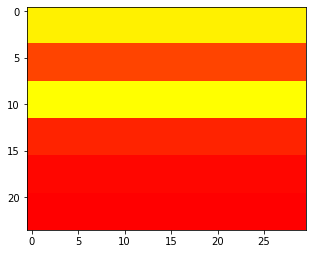

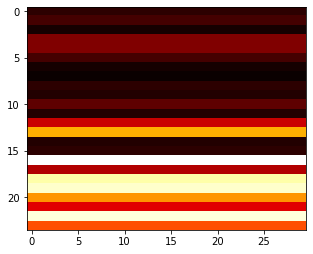

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.cla()
ax.imshow(np.reshape(data_alt3[0], (data_alt3.shape[1], data_alt3.shape[2])), cmap='autumn')

fig, ax = plt.subplots(figsize=(5, 5))
ax.cla()
ax.imshow(np.reshape(data_alt4[2], (data_alt3.shape[1], data_alt3.shape[2])), cmap='hot')

In [5]:
label_alt3 = np.zeros([data_alt3.shape[0]])
label_alt4 = np.zeros([data_alt4.shape[0]]) + 1
label_alt_3_4 = np.concatenate( (label_alt3,label_alt4), axis = 0)

label_alt_onehot = one_hot(label_alt_3_4, 1 + 1)   
print(label_alt_onehot.shape)

(208, 2)


In [6]:
np.random.seed(0)
np.random.shuffle(data_alt_3_4)

np.random.seed(0)
np.random.shuffle(label_alt_onehot)

In [7]:
class election_GAN(object):
    def __init__(self,
                num_samples = None,
                dim_height = None,
                dim_width = None,
                dim_z = None,
                num_class = None,
                batch_size = None,
                _reuse = None):
        
        # Definition Params:
        self.num_samples = num_samples  
        self.dim_height = dim_height    
        self.dim_width = dim_width  
        self.dim_z = dim_z    
        self.num_class = num_class      
        self.batch_size = batch_size  

        # Define Network Input:
        self.X = tf.placeholder(tf.float32, shape=(None, self.dim_height, self.dim_width, 1))
        self.Z = tf.placeholder(tf.float32, shape=(None, 1, 1, self.dim_z))
        self.Y_label = tf.placeholder(tf.float32, shape=(None, 1, 1, self.num_class))
        self.Y_fill = tf.placeholder(tf.float32, shape=(None, self.dim_height, self.dim_width, self.num_class))
        self.isTrain = tf.placeholder(dtype=tf.bool)
        self.keep_prob_feed = tf.placeholder(tf.float32)
        self.global_step = tf.Variable(0, trainable = False)
        
        # Network:
        self._GEN(self.Z, self.Y_label, self.keep_prob_feed, self.isTrain, _reuse)
        
        self._DIS(self.X, self.Y_fill, self.keep_prob_feed, self.isTrain, _reuse)
        
        with tf.variable_scope('object_cost_function', reuse=tf.AUTO_REUSE):
            self._object_cost_function()        
        
    def _GEN(self, Z, Y_label, keep_prob_feed, isTrain=True, _reuse=False):

        with tf.variable_scope("GEN", reuse=_reuse):
            dim = 128

            # concat layer
            Z_ = tf.concat([Z, Y_label], 3)  #(batch_szie, 1, 1, dim_z + num_class)
            Z_ = tf.reshape(Z_, (-1, self.dim_z + self.num_class))        

            # FCN 
            hidden = tf.layers.dense(Z_, units = 2*2*3*dim)
            hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)
            hidden = tf.reshape(hidden, (-1, 2, 2, 3*dim)) 

            # CNN 1 
            hidden = tf.layers.conv2d_transpose(hidden, 2*dim, [3, 3], strides=(1, 2), padding='valid')
            hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)

            # CNN 2 
            hidden = tf.layers.conv2d_transpose(hidden, 1*dim, [3, 3], strides=(3, 3), padding='same')
            hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)     

            # CNN 3 
            hidden = tf.layers.conv2d_transpose(hidden, 1, [3, 3], strides=(2, 2), padding='same')         
            output = hidden

            return output     
    
    def _DIS(self, X, Y_fill, keep_prob_feed, isTrain=True, _reuse=False):

        with tf.variable_scope("DIS", reuse=_reuse):
            dim = 128
            leak = 0.2
            # concat layer
            X_ = tf.concat([X, Y_fill], 3)  #(batch_size, dim_height, dim_width, channel + num_class)

            # CNN 1 
            hidden = tf.layers.conv2d(X_, 1*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # CNN 2 
            hidden = tf.layers.conv2d(hidden, 2*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # CNN 3
            hidden = tf.layers.conv2d(hidden, 2*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # Flatten layer
            hidden = tf.layers.flatten(hidden)        
            score = tf.layers.dense(hidden, units = 1)
            score = tf.reshape(score, (-1, 1))          

            return score
    
    def _object_cost_function(self):
        # networks : generator
        self.fake_output = self._GEN(self.Z, self.Y_label, self.keep_prob_feed, self.isTrain, _reuse=False)

        # networks : discriminator
        real_score = self._DIS(self.X, self.Y_fill, self.keep_prob_feed, self.isTrain, _reuse=False)
        fake_score = self._DIS(self.fake_output, self.Y_fill, self.keep_prob_feed, self.isTrain, _reuse=True)

        '''define the loss ops'''
        self.D_loss = tf.reduce_mean(-real_score + fake_score)
        self.G_loss = tf.reduce_mean(-fake_score) 

        ################  Gradient penalty  ################
        LAMBDA = 10
        alpha = tf.random_uniform(shape=[self.batch_size, 1], minval=0.,maxval=1.)  

        real_data = tf.reshape(self.X, (self.batch_size, self.dim_height*self.dim_width))    
        fake_data = tf.reshape(self.fake_output, (self.batch_size, self.dim_height*self.dim_width))    

        interpolates = (alpha * real_data + ((1 - alpha) * fake_data))    
        interpolates_d = tf.reshape(interpolates, (self.batch_size, self.dim_height, self.dim_width, 1))  
        interpolates_d = self._DIS(interpolates_d, self.Y_fill, self.keep_prob_feed, self.isTrain, _reuse=True)                   

        gradients = tf.gradients(interpolates_d, [interpolates])[0]   
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))  
        gradient_penalty = tf.reduce_mean((slopes-1.)**2) 
        self.D_loss = self.D_loss + LAMBDA*gradient_penalty
        ###############  Gradient penalty  ################


        # define the optimizer ops
        self.T_vars = tf.trainable_variables()
#         self.D_vars = [var for var in self.T_vars if var.name.startswith('DIS')]
#         self.G_vars = [var for var in self.T_vars if var.name.startswith('GEN')]
        self.D_vars = [var for var in self.T_vars if 'DIS' in var.name]
        self.G_vars = [var for var in self.T_vars if 'DIS' not in var.name]
        
        learning_rate = 0.0001
        # define the update ops to run batch normalization
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
#             self.D_optim = tf.train.RMSPropOptimizer(learning_rate).minimize(self.D_loss, var_list=self.D_vars)
#             self.G_optim = tf.train.RMSPropOptimizer(learning_rate).minimize(self.G_loss, var_list=self.G_vars)
            self.D_optim = tf.train.AdamOptimizer(learning_rate, beta1=0.5, beta2=0.9).minimize(self.D_loss, var_list=self.D_vars)
            self.G_optim = tf.train.AdamOptimizer(learning_rate, beta1=0.5, beta2=0.9).minimize(self.G_loss, var_list=self.G_vars)
            
            
    def train_model(self,
                    x_train = None,     
                    y_train = None,     
                    keep_prob = None,
                    train_epoch = None, 
                    n_critic = 5,
                    step_valid = 50
                   ): 
        
        self.train_hist = {}
        self.train_hist['D_losses'] = []
        self.train_hist['G_losses'] = []

        session_config = tf.ConfigProto(gpu_options = tf.GPUOptions(allow_growth=True))
        with tf.Session(config = session_config) as sess:
            sess.run(tf.global_variables_initializer())
            print('Optimization start!')

            for epoch in range(train_epoch):
                G_losses = []
                D_losses = []

                for i in range(len(x_train) // self.batch_size): # num_samples / batch_size
                    '''#############        Discriminator       #######################'''
                    x_ = x_train[i*self.batch_size: (i+1)*self.batch_size] 
                    x_ = x_.reshape((self.batch_size, self.dim_height, self.dim_width, 1))   #(batch_size, dim_height, dim_width, 1)
                    y_label_ = y_train[i*self.batch_size:(i+1)*self.batch_size].reshape([self.batch_size, 1, 1, self.num_class])
                    y_fill_ = y_label_ * np.ones([self.batch_size, self.dim_height, self.dim_width, self.num_class]) #(batch_szie, height, width, num_class)
                    z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))

                    loss_d, _ = sess.run([self.D_loss, self.D_optim], 
                                          feed_dict={self.X: x_, 
                                                     self.Z: z_, 
                                                     self.Y_fill: y_fill_, 
                                                     self.Y_label: y_label_, 
                                                     self.keep_prob_feed: keep_prob,
                                                     self.isTrain: True})
                    D_losses.append(loss_d)

                    '''#############        Generator          #######################'''
                    if (i+1) % n_critic == 0:   # Train the generator every n_critic iterations
                        z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))
                        y_ = []
                        for _ in range(self.batch_size): y_.append(random.randrange(0, self.num_class, self.num_class-1))  
                        y_ = np.array(y_).reshape([self.batch_size, 1])
        #                 y_ = np.random.randint(0, 2, (batch_size, 1))
                        y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])
                        y_fill_ = y_label_ * np.ones([self.batch_size, self.dim_height, self.dim_width, self.num_class])
                        loss_g, _ = sess.run([self.G_loss, self.G_optim], 
                                              feed_dict={self.Z: z_, 
                                                         self.X: x_, 
                                                         self.Y_fill: y_fill_, 
                                                         self.Y_label: y_label_, 
                                                         self.keep_prob_feed: keep_prob,
                                                         self.isTrain: True})
                        G_losses.append(loss_g)

            ############        print result      #######################
                if (epoch+1) % 1 == 0:
                    print('[%d/%d] loss_d: %.3f, loss_g: %.3f'%((epoch + 1), train_epoch, np.mean(D_losses), np.mean(G_losses)))
                    self.train_hist['D_losses'].append(np.mean(D_losses))
                    self.train_hist['G_losses'].append(np.mean(G_losses))

            ############        valid      #######################
                if (epoch+1) % step_valid == 0:
                   ############        num_alternative = 3      #######################
                    noise_G = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   

                    y_ = np.zeros([self.batch_size, 1]) + 0
                    y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])
                    y_fill_ = y_label_ * np.ones([self.batch_size, self.dim_height, self.dim_width, self.num_class])
                    output_g_alt3 = sess.run([self.fake_output], 
                                          feed_dict={self.Z: z_, 
                                                     self.X: x_, 
                                                     self.Y_fill: y_fill_, 
                                                     self.Y_label: y_label_, 
                                                     self.keep_prob_feed: 1,
                                                     self.isTrain: False})    
                    output_g_alt3_ = np.array(output_g_alt3).reshape([self.batch_size, self.dim_height, self.dim_width])[0]

                    ############        num_alternative = 4      #######################
                    noise_G = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   

                    y_ = np.zeros([self.batch_size, 1]) + 1
                    y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])
                    y_fill_ = y_label_ * np.ones([self.batch_size, self.dim_height, self.dim_width, self.num_class])
                    output_g_alt4 = sess.run([self.fake_output], 
                                          feed_dict={self.Z: z_, 
                                                     self.X: x_, 
                                                     self.Y_fill: y_fill_, 
                                                     self.Y_label: y_label_, 
                                                     self.keep_prob_feed: 1,
                                                     self.isTrain: False})  


                    output_g_alt4_ = np.array(output_g_alt4).reshape([self.batch_size, self.dim_height, self.dim_width])[0]

                    plt.figure(epoch)
                    fig, ax = plt.subplots(figsize=(5, 5))
                    ax.cla()
                    ax.imshow(np.reshape(output_g_alt3_, (self.dim_height, self.dim_width)), cmap='gray')

                    fig, ax = plt.subplots(figsize=(5, 5))
                    ax.cla()
                    ax.imshow(np.reshape(output_g_alt4_, (self.dim_height, self.dim_width)), cmap='gray')            
                    plt.show()

        #         ###########        save      #######################
        #         saver.save(sess, saver_path)   
        #         print('save success')


        #     ############        num_alternative = 3      #######################
        #     noise_G = np.random.normal(0, 1, (batch_size, 1, 1, dim_z))   

        #     y_ = np.zeros([batch_size, 1]) + 0
        #     y_label_ = one_hot(y_, num_class).reshape([batch_size, 1, 1, num_class])
        #     y_fill_ = y_label_ * np.ones([batch_size, dim_height, dim_width, num_class])
        #     output_g_alt3 = sess.run([fake_output], 
        #                           feed_dict={Z: z_, 
        #                                      X: x_, 
        #                                      Y_fill: y_fill_, 
        #                                      Y_label: y_label_, 
        #                                      keep_prob_feed: 1,
        #                                      isTrain: False})    

        #     ############        num_alternative = 4      #######################
        #     noise_G = np.random.normal(0, 1, (batch_size, 1, 1, dim_z))   

        #     y_ = np.zeros([batch_size, 1]) + 1
        #     y_label_ = one_hot(y_, num_class).reshape([batch_size, 1, 1, num_class])
        #     y_fill_ = y_label_ * np.ones([batch_size, dim_height, dim_width, num_class])
        #     output_g_alt4 = sess.run([fake_output], 
        #                           feed_dict={Z: z_, 
        #                                      X: x_, 
        #                                      Y_fill: y_fill_, 
        #                                      Y_label: y_label_, 
        #                                      keep_prob_feed: 1,
        #                                      isTrain: False})   
            sess.close()

        print("Optimization Finished!")
        
    '''loss curve'''
    def show_train_hist(self):
        x = range(len(self.train_hist['D_losses']))

        y1 = self.train_hist['D_losses']
        y2 = self.train_hist['G_losses']

        plt.plot(x, y1, label='D_loss')
        plt.plot(x, y2, label='G_loss')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.legend(loc=4)  
        plt.grid(True)
        plt.tight_layout() 
        plt.title("Training Losses")

        plt.show()


In [8]:
num_samples = data_alt_3_4.shape[0]
dim_height = data_alt_3_4.shape[1]
dim_width = data_alt_3_4.shape[2]
dim_z = 128
num_class = label_alt_onehot.shape[-1]
batch_size = 10

In [9]:
model = election_GAN(
                num_samples = num_samples,
                dim_height = dim_height,
                dim_width = dim_width,
                dim_z = dim_z,
                num_class = num_class,
                batch_size = batch_size)


Optimization start!
[1/17000] loss_d: 3.247, loss_g: 1.603
[2/17000] loss_d: -5.037, loss_g: 3.594
[3/17000] loss_d: -6.224, loss_g: 5.196
[4/17000] loss_d: -7.364, loss_g: 6.418
[5/17000] loss_d: -6.692, loss_g: 6.399
[6/17000] loss_d: -6.032, loss_g: 6.098
[7/17000] loss_d: -5.523, loss_g: 6.268
[8/17000] loss_d: -5.134, loss_g: 6.287
[9/17000] loss_d: -4.734, loss_g: 5.571
[10/17000] loss_d: -4.445, loss_g: 4.830
[11/17000] loss_d: -4.148, loss_g: 6.353
[12/17000] loss_d: -3.915, loss_g: 6.425
[13/17000] loss_d: -3.665, loss_g: 4.811
[14/17000] loss_d: -3.462, loss_g: 3.921
[15/17000] loss_d: -3.286, loss_g: 3.555
[16/17000] loss_d: -3.175, loss_g: 2.969
[17/17000] loss_d: -3.026, loss_g: 2.344
[18/17000] loss_d: -2.934, loss_g: 2.186
[19/17000] loss_d: -2.854, loss_g: 2.280
[20/17000] loss_d: -2.733, loss_g: 2.970
[21/17000] loss_d: -2.645, loss_g: 2.322
[22/17000] loss_d: -2.577, loss_g: 1.932
[23/17000] loss_d: -2.489, loss_g: 1.552
[24/17000] loss_d: -2.464, loss_g: 1.302
[25/17

<Figure size 432x288 with 0 Axes>

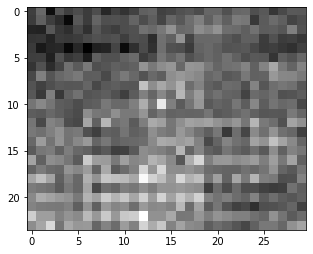

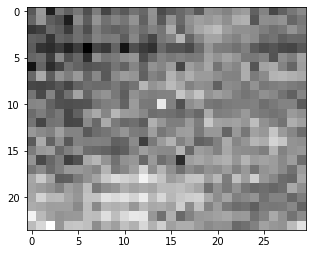

[51/17000] loss_d: -1.651, loss_g: 4.078
[52/17000] loss_d: -1.615, loss_g: 4.341
[53/17000] loss_d: -1.668, loss_g: 4.148
[54/17000] loss_d: -1.620, loss_g: 4.041
[55/17000] loss_d: -1.591, loss_g: 4.833
[56/17000] loss_d: -1.549, loss_g: 4.806
[57/17000] loss_d: -1.547, loss_g: 5.340
[58/17000] loss_d: -1.482, loss_g: 5.181
[59/17000] loss_d: -1.521, loss_g: 5.571
[60/17000] loss_d: -1.469, loss_g: 5.548
[61/17000] loss_d: -1.480, loss_g: 5.229
[62/17000] loss_d: -1.435, loss_g: 5.776
[63/17000] loss_d: -1.461, loss_g: 6.135
[64/17000] loss_d: -1.474, loss_g: 6.860
[65/17000] loss_d: -1.439, loss_g: 7.678
[66/17000] loss_d: -1.408, loss_g: 5.962
[67/17000] loss_d: -1.402, loss_g: 6.969
[68/17000] loss_d: -1.420, loss_g: 7.085
[69/17000] loss_d: -1.390, loss_g: 7.363
[70/17000] loss_d: -1.398, loss_g: 6.905
[71/17000] loss_d: -1.383, loss_g: 6.450
[72/17000] loss_d: -1.378, loss_g: 7.337
[73/17000] loss_d: -1.426, loss_g: 5.955
[74/17000] loss_d: -1.390, loss_g: 6.141
[75/17000] loss_

<Figure size 432x288 with 0 Axes>

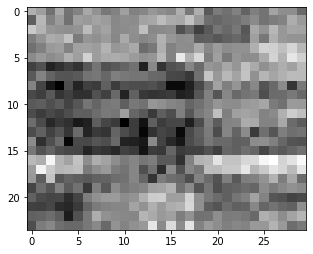

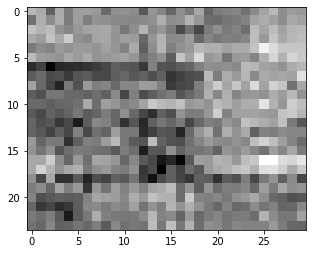

[101/17000] loss_d: -1.344, loss_g: 5.351
[102/17000] loss_d: -1.302, loss_g: 6.046
[103/17000] loss_d: -1.316, loss_g: 5.892
[104/17000] loss_d: -1.322, loss_g: 6.189
[105/17000] loss_d: -1.346, loss_g: 4.224
[106/17000] loss_d: -1.273, loss_g: 6.975
[107/17000] loss_d: -1.350, loss_g: 5.053
[108/17000] loss_d: -1.338, loss_g: 4.473
[109/17000] loss_d: -1.329, loss_g: 5.589
[110/17000] loss_d: -1.319, loss_g: 4.257
[111/17000] loss_d: -1.302, loss_g: 6.053
[112/17000] loss_d: -1.293, loss_g: 4.972
[113/17000] loss_d: -1.298, loss_g: 4.772
[114/17000] loss_d: -1.292, loss_g: 6.357
[115/17000] loss_d: -1.313, loss_g: 4.861
[116/17000] loss_d: -1.271, loss_g: 5.851
[117/17000] loss_d: -1.295, loss_g: 4.843
[118/17000] loss_d: -1.319, loss_g: 5.102
[119/17000] loss_d: -1.266, loss_g: 5.428
[120/17000] loss_d: -1.314, loss_g: 4.616
[121/17000] loss_d: -1.288, loss_g: 5.120
[122/17000] loss_d: -1.296, loss_g: 4.440
[123/17000] loss_d: -1.228, loss_g: 4.894
[124/17000] loss_d: -1.231, loss_g

<Figure size 432x288 with 0 Axes>

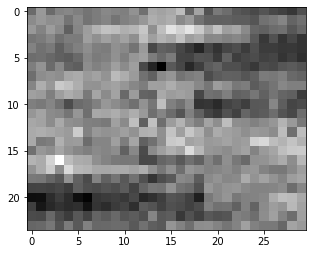

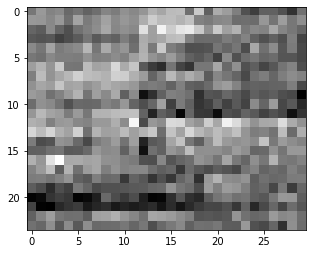

[151/17000] loss_d: -1.158, loss_g: 3.080
[152/17000] loss_d: -1.145, loss_g: 3.638
[153/17000] loss_d: -1.164, loss_g: 4.172
[154/17000] loss_d: -1.131, loss_g: 2.784
[155/17000] loss_d: -1.216, loss_g: 2.352
[156/17000] loss_d: -1.165, loss_g: 2.994
[157/17000] loss_d: -1.131, loss_g: 2.238
[158/17000] loss_d: -1.196, loss_g: 3.260
[159/17000] loss_d: -1.125, loss_g: 2.283
[160/17000] loss_d: -1.152, loss_g: 2.754
[161/17000] loss_d: -1.169, loss_g: 2.791
[162/17000] loss_d: -1.213, loss_g: 2.976
[163/17000] loss_d: -1.103, loss_g: 3.212
[164/17000] loss_d: -1.164, loss_g: 3.253
[165/17000] loss_d: -1.208, loss_g: 2.566
[166/17000] loss_d: -1.147, loss_g: 3.514
[167/17000] loss_d: -1.138, loss_g: 2.547
[168/17000] loss_d: -1.146, loss_g: 3.487
[169/17000] loss_d: -1.147, loss_g: 3.178
[170/17000] loss_d: -1.142, loss_g: 2.807
[171/17000] loss_d: -1.143, loss_g: 2.454
[172/17000] loss_d: -1.149, loss_g: 2.157
[173/17000] loss_d: -1.180, loss_g: 2.928
[174/17000] loss_d: -1.182, loss_g

<Figure size 432x288 with 0 Axes>

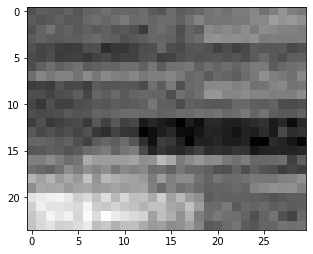

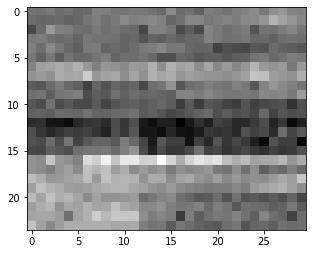

[201/17000] loss_d: -1.201, loss_g: 3.629
[202/17000] loss_d: -1.147, loss_g: 3.227
[203/17000] loss_d: -1.134, loss_g: 3.186
[204/17000] loss_d: -1.162, loss_g: 3.800
[205/17000] loss_d: -1.172, loss_g: 3.140
[206/17000] loss_d: -1.120, loss_g: 3.420
[207/17000] loss_d: -1.141, loss_g: 3.637
[208/17000] loss_d: -1.132, loss_g: 3.800
[209/17000] loss_d: -1.127, loss_g: 4.063
[210/17000] loss_d: -1.131, loss_g: 3.953
[211/17000] loss_d: -1.113, loss_g: 3.144
[212/17000] loss_d: -1.126, loss_g: 3.540
[213/17000] loss_d: -1.091, loss_g: 4.137
[214/17000] loss_d: -1.158, loss_g: 3.108
[215/17000] loss_d: -1.152, loss_g: 3.405
[216/17000] loss_d: -1.106, loss_g: 2.889
[217/17000] loss_d: -1.106, loss_g: 3.128
[218/17000] loss_d: -1.099, loss_g: 3.104
[219/17000] loss_d: -1.128, loss_g: 3.439
[220/17000] loss_d: -1.133, loss_g: 4.493
[221/17000] loss_d: -1.135, loss_g: 4.242
[222/17000] loss_d: -1.079, loss_g: 3.837
[223/17000] loss_d: -1.049, loss_g: 3.460
[224/17000] loss_d: -1.067, loss_g

<Figure size 432x288 with 0 Axes>

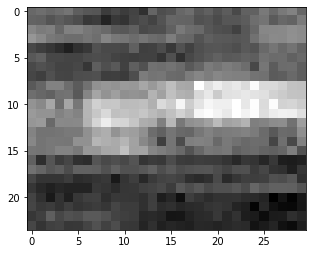

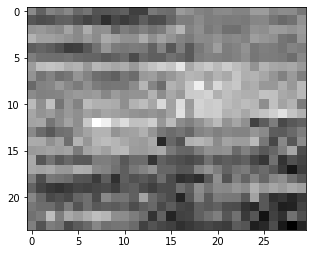

[251/17000] loss_d: -0.951, loss_g: 4.483
[252/17000] loss_d: -0.974, loss_g: 4.112
[253/17000] loss_d: -0.993, loss_g: 4.456
[254/17000] loss_d: -0.996, loss_g: 3.753
[255/17000] loss_d: -0.916, loss_g: 4.776
[256/17000] loss_d: -0.922, loss_g: 4.520
[257/17000] loss_d: -0.997, loss_g: 3.633
[258/17000] loss_d: -0.983, loss_g: 4.241
[259/17000] loss_d: -1.019, loss_g: 4.143
[260/17000] loss_d: -1.023, loss_g: 4.166
[261/17000] loss_d: -0.943, loss_g: 4.681
[262/17000] loss_d: -1.012, loss_g: 4.249
[263/17000] loss_d: -0.934, loss_g: 4.186
[264/17000] loss_d: -0.994, loss_g: 4.400
[265/17000] loss_d: -1.036, loss_g: 3.904
[266/17000] loss_d: -0.932, loss_g: 4.152
[267/17000] loss_d: -0.921, loss_g: 3.899
[268/17000] loss_d: -0.975, loss_g: 4.103
[269/17000] loss_d: -0.931, loss_g: 3.669
[270/17000] loss_d: -0.894, loss_g: 4.083
[271/17000] loss_d: -0.977, loss_g: 3.694
[272/17000] loss_d: -0.964, loss_g: 3.806
[273/17000] loss_d: -0.955, loss_g: 3.900
[274/17000] loss_d: -0.965, loss_g

<Figure size 432x288 with 0 Axes>

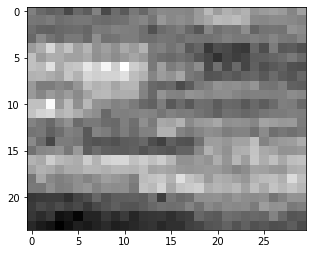

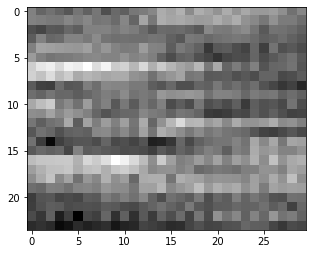

[301/17000] loss_d: -0.848, loss_g: 3.554
[302/17000] loss_d: -0.938, loss_g: 3.357
[303/17000] loss_d: -0.929, loss_g: 3.312
[304/17000] loss_d: -0.940, loss_g: 3.133
[305/17000] loss_d: -0.963, loss_g: 3.545
[306/17000] loss_d: -0.953, loss_g: 3.184
[307/17000] loss_d: -0.954, loss_g: 3.085
[308/17000] loss_d: -0.865, loss_g: 3.207
[309/17000] loss_d: -0.957, loss_g: 2.979
[310/17000] loss_d: -0.948, loss_g: 2.873
[311/17000] loss_d: -0.978, loss_g: 2.637
[312/17000] loss_d: -0.868, loss_g: 3.094
[313/17000] loss_d: -0.890, loss_g: 2.611
[314/17000] loss_d: -0.932, loss_g: 2.386
[315/17000] loss_d: -0.920, loss_g: 2.717
[316/17000] loss_d: -0.939, loss_g: 3.543
[317/17000] loss_d: -0.988, loss_g: 2.891
[318/17000] loss_d: -0.932, loss_g: 2.601
[319/17000] loss_d: -0.856, loss_g: 3.132
[320/17000] loss_d: -0.964, loss_g: 3.245
[321/17000] loss_d: -0.790, loss_g: 3.568
[322/17000] loss_d: -0.916, loss_g: 3.787
[323/17000] loss_d: -0.916, loss_g: 3.399
[324/17000] loss_d: -0.906, loss_g

<Figure size 432x288 with 0 Axes>

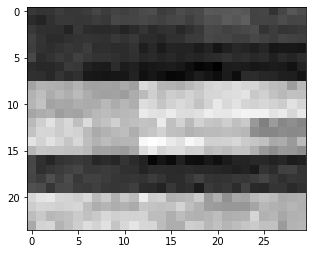

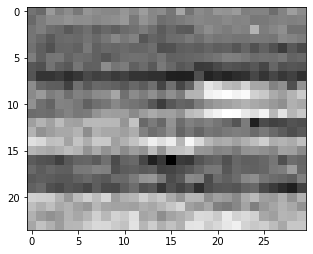

[351/17000] loss_d: -0.921, loss_g: 2.566
[352/17000] loss_d: -0.842, loss_g: 2.982
[353/17000] loss_d: -0.883, loss_g: 3.354
[354/17000] loss_d: -0.857, loss_g: 2.969
[355/17000] loss_d: -0.829, loss_g: 3.012
[356/17000] loss_d: -0.841, loss_g: 2.994
[357/17000] loss_d: -0.880, loss_g: 3.119
[358/17000] loss_d: -0.932, loss_g: 2.683
[359/17000] loss_d: -0.900, loss_g: 2.909
[360/17000] loss_d: -0.881, loss_g: 3.283
[361/17000] loss_d: -0.964, loss_g: 3.057
[362/17000] loss_d: -0.840, loss_g: 2.847
[363/17000] loss_d: -0.824, loss_g: 3.087
[364/17000] loss_d: -0.791, loss_g: 3.086
[365/17000] loss_d: -0.906, loss_g: 2.720
[366/17000] loss_d: -0.845, loss_g: 2.588
[367/17000] loss_d: -0.872, loss_g: 2.831
[368/17000] loss_d: -0.857, loss_g: 2.392
[369/17000] loss_d: -0.872, loss_g: 3.168
[370/17000] loss_d: -0.833, loss_g: 3.061
[371/17000] loss_d: -0.863, loss_g: 2.671
[372/17000] loss_d: -0.856, loss_g: 2.857
[373/17000] loss_d: -0.891, loss_g: 2.415
[374/17000] loss_d: -0.879, loss_g

<Figure size 432x288 with 0 Axes>

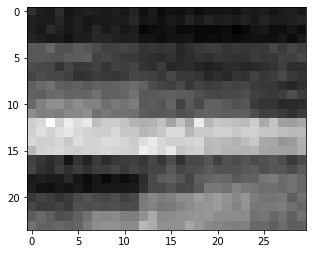

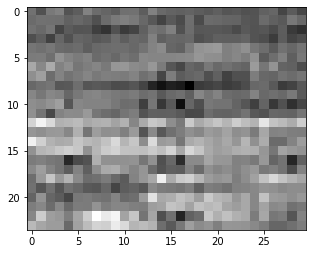

[401/17000] loss_d: -0.864, loss_g: 2.689
[402/17000] loss_d: -0.867, loss_g: 2.878
[403/17000] loss_d: -0.879, loss_g: 2.820
[404/17000] loss_d: -0.841, loss_g: 2.593
[405/17000] loss_d: -0.814, loss_g: 2.506
[406/17000] loss_d: -0.820, loss_g: 2.838
[407/17000] loss_d: -0.843, loss_g: 2.797
[408/17000] loss_d: -0.848, loss_g: 3.003
[409/17000] loss_d: -0.923, loss_g: 2.919
[410/17000] loss_d: -0.706, loss_g: 3.030
[411/17000] loss_d: -0.798, loss_g: 3.044
[412/17000] loss_d: -0.867, loss_g: 2.844
[413/17000] loss_d: -0.874, loss_g: 2.555
[414/17000] loss_d: -0.809, loss_g: 2.692
[415/17000] loss_d: -0.826, loss_g: 2.975
[416/17000] loss_d: -0.858, loss_g: 3.015
[417/17000] loss_d: -0.842, loss_g: 2.582
[418/17000] loss_d: -0.836, loss_g: 2.811
[419/17000] loss_d: -0.821, loss_g: 2.426
[420/17000] loss_d: -0.830, loss_g: 2.707
[421/17000] loss_d: -0.795, loss_g: 2.629
[422/17000] loss_d: -0.763, loss_g: 2.608
[423/17000] loss_d: -0.862, loss_g: 2.853
[424/17000] loss_d: -0.833, loss_g

<Figure size 432x288 with 0 Axes>

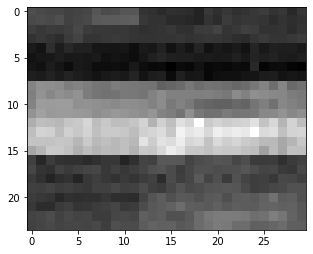

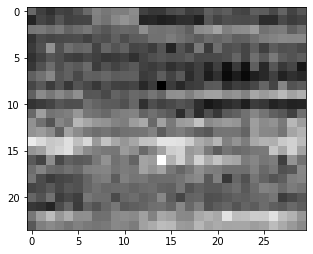

[451/17000] loss_d: -0.812, loss_g: 2.549
[452/17000] loss_d: -0.837, loss_g: 2.471
[453/17000] loss_d: -0.841, loss_g: 2.371
[454/17000] loss_d: -0.839, loss_g: 2.453
[455/17000] loss_d: -0.849, loss_g: 2.699
[456/17000] loss_d: -0.845, loss_g: 2.469
[457/17000] loss_d: -0.758, loss_g: 2.855
[458/17000] loss_d: -0.881, loss_g: 2.654
[459/17000] loss_d: -0.863, loss_g: 2.420
[460/17000] loss_d: -0.850, loss_g: 2.584
[461/17000] loss_d: -0.818, loss_g: 2.476
[462/17000] loss_d: -0.852, loss_g: 2.506
[463/17000] loss_d: -0.819, loss_g: 2.881
[464/17000] loss_d: -0.894, loss_g: 2.482
[465/17000] loss_d: -0.872, loss_g: 2.348
[466/17000] loss_d: -0.799, loss_g: 2.455
[467/17000] loss_d: -0.831, loss_g: 2.443
[468/17000] loss_d: -0.824, loss_g: 2.662
[469/17000] loss_d: -0.817, loss_g: 2.659
[470/17000] loss_d: -0.864, loss_g: 2.627
[471/17000] loss_d: -0.827, loss_g: 2.674
[472/17000] loss_d: -0.819, loss_g: 2.353
[473/17000] loss_d: -0.802, loss_g: 2.283
[474/17000] loss_d: -0.862, loss_g

<Figure size 432x288 with 0 Axes>

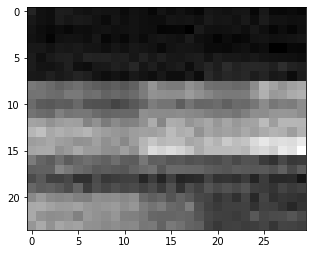

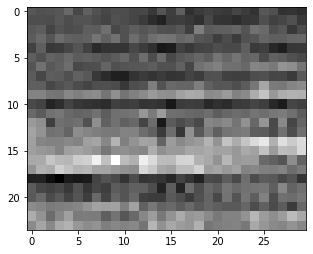

[501/17000] loss_d: -0.824, loss_g: 2.776
[502/17000] loss_d: -0.828, loss_g: 2.361
[503/17000] loss_d: -0.868, loss_g: 2.323
[504/17000] loss_d: -0.838, loss_g: 2.770
[505/17000] loss_d: -0.822, loss_g: 2.399
[506/17000] loss_d: -0.850, loss_g: 2.386
[507/17000] loss_d: -0.846, loss_g: 2.487
[508/17000] loss_d: -0.845, loss_g: 2.560
[509/17000] loss_d: -0.868, loss_g: 3.142
[510/17000] loss_d: -0.774, loss_g: 2.401
[511/17000] loss_d: -0.852, loss_g: 2.227
[512/17000] loss_d: -0.853, loss_g: 2.453
[513/17000] loss_d: -0.826, loss_g: 2.199
[514/17000] loss_d: -0.867, loss_g: 2.228
[515/17000] loss_d: -0.854, loss_g: 2.058
[516/17000] loss_d: -0.855, loss_g: 2.763
[517/17000] loss_d: -0.763, loss_g: 2.521
[518/17000] loss_d: -0.818, loss_g: 2.335
[519/17000] loss_d: -0.836, loss_g: 2.418
[520/17000] loss_d: -0.850, loss_g: 2.382
[521/17000] loss_d: -0.830, loss_g: 2.453
[522/17000] loss_d: -0.808, loss_g: 2.390
[523/17000] loss_d: -0.820, loss_g: 2.314
[524/17000] loss_d: -0.865, loss_g

<Figure size 432x288 with 0 Axes>

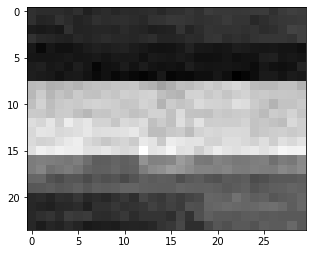

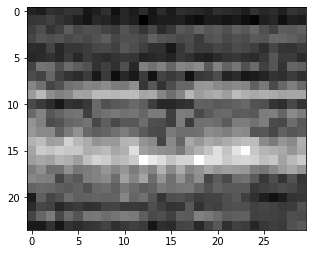

[551/17000] loss_d: -0.845, loss_g: 2.292
[552/17000] loss_d: -0.784, loss_g: 2.340
[553/17000] loss_d: -0.733, loss_g: 2.194
[554/17000] loss_d: -0.808, loss_g: 2.374
[555/17000] loss_d: -0.843, loss_g: 2.439
[556/17000] loss_d: -0.822, loss_g: 2.468
[557/17000] loss_d: -0.794, loss_g: 2.453
[558/17000] loss_d: -0.753, loss_g: 2.530
[559/17000] loss_d: -0.818, loss_g: 2.195
[560/17000] loss_d: -0.827, loss_g: 2.196
[561/17000] loss_d: -0.903, loss_g: 2.325
[562/17000] loss_d: -0.858, loss_g: 2.573
[563/17000] loss_d: -0.865, loss_g: 2.398
[564/17000] loss_d: -0.848, loss_g: 2.348
[565/17000] loss_d: -0.792, loss_g: 2.348
[566/17000] loss_d: -0.862, loss_g: 2.318
[567/17000] loss_d: -0.823, loss_g: 2.162
[568/17000] loss_d: -0.824, loss_g: 2.237
[569/17000] loss_d: -0.829, loss_g: 2.193
[570/17000] loss_d: -0.850, loss_g: 2.233
[571/17000] loss_d: -0.790, loss_g: 2.323
[572/17000] loss_d: -0.855, loss_g: 2.407
[573/17000] loss_d: -0.835, loss_g: 2.200
[574/17000] loss_d: -0.817, loss_g

<Figure size 432x288 with 0 Axes>

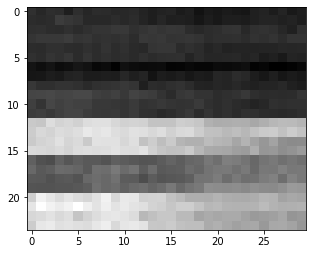

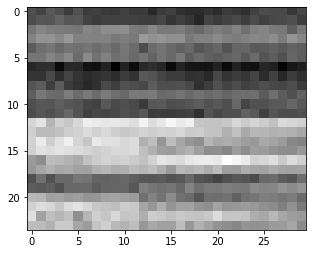

[601/17000] loss_d: -0.895, loss_g: 2.353
[602/17000] loss_d: -0.872, loss_g: 2.303
[603/17000] loss_d: -0.821, loss_g: 2.407
[604/17000] loss_d: -0.893, loss_g: 2.282
[605/17000] loss_d: -0.819, loss_g: 2.157
[606/17000] loss_d: -0.812, loss_g: 2.093
[607/17000] loss_d: -0.871, loss_g: 2.279
[608/17000] loss_d: -0.853, loss_g: 2.318
[609/17000] loss_d: -0.820, loss_g: 2.194
[610/17000] loss_d: -0.911, loss_g: 2.280
[611/17000] loss_d: -0.843, loss_g: 2.199
[612/17000] loss_d: -0.928, loss_g: 2.035
[613/17000] loss_d: -0.851, loss_g: 2.263
[614/17000] loss_d: -0.799, loss_g: 2.076
[615/17000] loss_d: -0.836, loss_g: 1.961
[616/17000] loss_d: -0.842, loss_g: 2.199
[617/17000] loss_d: -0.828, loss_g: 2.027
[618/17000] loss_d: -0.817, loss_g: 2.058
[619/17000] loss_d: -0.908, loss_g: 2.028
[620/17000] loss_d: -0.791, loss_g: 2.042
[621/17000] loss_d: -0.845, loss_g: 1.866
[622/17000] loss_d: -0.824, loss_g: 1.766
[623/17000] loss_d: -0.874, loss_g: 1.932
[624/17000] loss_d: -0.875, loss_g

<Figure size 432x288 with 0 Axes>

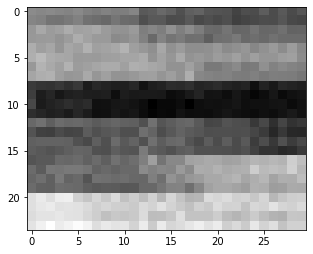

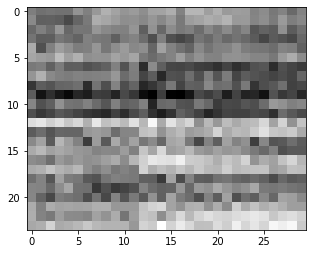

[651/17000] loss_d: -0.836, loss_g: 2.067
[652/17000] loss_d: -0.870, loss_g: 2.037
[653/17000] loss_d: -0.859, loss_g: 2.043
[654/17000] loss_d: -0.830, loss_g: 2.070
[655/17000] loss_d: -0.870, loss_g: 2.131
[656/17000] loss_d: -0.831, loss_g: 1.896
[657/17000] loss_d: -0.799, loss_g: 1.658
[658/17000] loss_d: -0.838, loss_g: 1.848
[659/17000] loss_d: -0.913, loss_g: 1.631
[660/17000] loss_d: -0.867, loss_g: 1.899
[661/17000] loss_d: -0.819, loss_g: 1.942
[662/17000] loss_d: -0.851, loss_g: 2.012
[663/17000] loss_d: -0.832, loss_g: 1.844
[664/17000] loss_d: -0.900, loss_g: 1.725
[665/17000] loss_d: -0.965, loss_g: 1.718
[666/17000] loss_d: -0.842, loss_g: 1.900
[667/17000] loss_d: -0.881, loss_g: 1.920
[668/17000] loss_d: -0.859, loss_g: 1.705
[669/17000] loss_d: -0.856, loss_g: 1.688
[670/17000] loss_d: -0.810, loss_g: 1.804
[671/17000] loss_d: -0.865, loss_g: 1.700
[672/17000] loss_d: -0.819, loss_g: 1.730
[673/17000] loss_d: -0.859, loss_g: 2.200
[674/17000] loss_d: -0.914, loss_g

<Figure size 432x288 with 0 Axes>

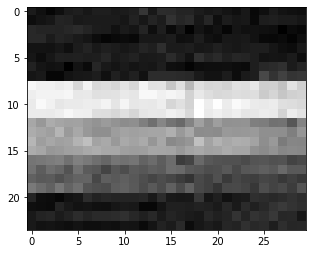

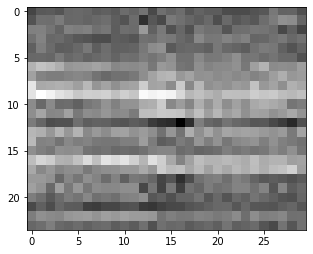

[701/17000] loss_d: -0.846, loss_g: 1.747
[702/17000] loss_d: -0.919, loss_g: 1.686
[703/17000] loss_d: -0.869, loss_g: 1.739
[704/17000] loss_d: -0.921, loss_g: 1.515
[705/17000] loss_d: -0.771, loss_g: 1.583
[706/17000] loss_d: -0.852, loss_g: 1.723
[707/17000] loss_d: -0.846, loss_g: 1.523
[708/17000] loss_d: -0.821, loss_g: 1.633
[709/17000] loss_d: -0.780, loss_g: 1.582
[710/17000] loss_d: -0.876, loss_g: 1.649
[711/17000] loss_d: -0.813, loss_g: 1.334
[712/17000] loss_d: -0.777, loss_g: 1.474
[713/17000] loss_d: -0.819, loss_g: 1.468
[714/17000] loss_d: -0.865, loss_g: 1.511
[715/17000] loss_d: -0.850, loss_g: 1.767
[716/17000] loss_d: -0.813, loss_g: 1.598
[717/17000] loss_d: -0.894, loss_g: 1.719
[718/17000] loss_d: -0.885, loss_g: 1.687
[719/17000] loss_d: -0.847, loss_g: 1.535
[720/17000] loss_d: -0.874, loss_g: 1.413
[721/17000] loss_d: -0.890, loss_g: 1.446
[722/17000] loss_d: -0.852, loss_g: 1.664
[723/17000] loss_d: -0.879, loss_g: 1.555
[724/17000] loss_d: -0.896, loss_g

<Figure size 432x288 with 0 Axes>

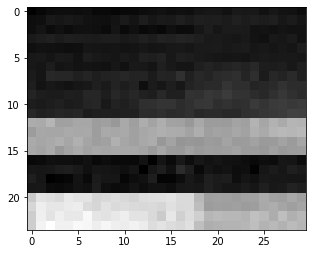

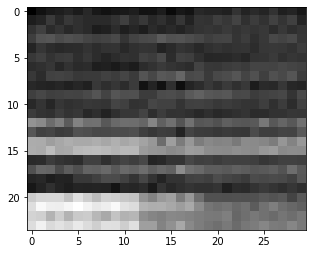

[751/17000] loss_d: -0.823, loss_g: 1.511
[752/17000] loss_d: -0.868, loss_g: 1.245
[753/17000] loss_d: -0.861, loss_g: 1.574
[754/17000] loss_d: -0.791, loss_g: 1.326
[755/17000] loss_d: -0.851, loss_g: 1.676
[756/17000] loss_d: -0.798, loss_g: 1.430
[757/17000] loss_d: -0.865, loss_g: 1.278
[758/17000] loss_d: -0.846, loss_g: 1.476
[759/17000] loss_d: -0.803, loss_g: 1.177
[760/17000] loss_d: -0.808, loss_g: 1.529
[761/17000] loss_d: -0.830, loss_g: 1.234
[762/17000] loss_d: -0.794, loss_g: 1.353
[763/17000] loss_d: -0.838, loss_g: 1.171
[764/17000] loss_d: -0.806, loss_g: 1.232
[765/17000] loss_d: -0.833, loss_g: 1.370
[766/17000] loss_d: -0.821, loss_g: 1.185
[767/17000] loss_d: -0.821, loss_g: 1.403
[768/17000] loss_d: -0.812, loss_g: 1.389
[769/17000] loss_d: -0.894, loss_g: 1.459
[770/17000] loss_d: -0.947, loss_g: 1.344
[771/17000] loss_d: -0.869, loss_g: 1.455
[772/17000] loss_d: -0.843, loss_g: 1.364
[773/17000] loss_d: -0.803, loss_g: 1.244
[774/17000] loss_d: -0.851, loss_g

<Figure size 432x288 with 0 Axes>

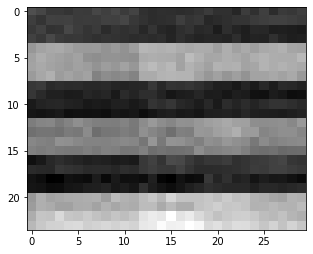

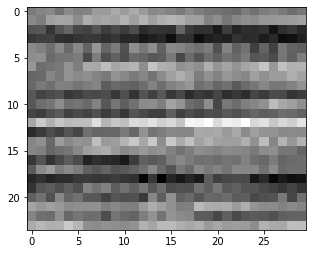

[801/17000] loss_d: -0.858, loss_g: 1.534
[802/17000] loss_d: -0.865, loss_g: 1.458
[803/17000] loss_d: -0.829, loss_g: 1.493
[804/17000] loss_d: -0.834, loss_g: 1.521
[805/17000] loss_d: -0.881, loss_g: 1.304
[806/17000] loss_d: -0.843, loss_g: 1.333
[807/17000] loss_d: -0.803, loss_g: 1.511
[808/17000] loss_d: -0.862, loss_g: 1.282
[809/17000] loss_d: -0.824, loss_g: 1.419
[810/17000] loss_d: -0.832, loss_g: 1.360
[811/17000] loss_d: -0.901, loss_g: 1.300
[812/17000] loss_d: -0.805, loss_g: 1.358
[813/17000] loss_d: -0.779, loss_g: 1.253
[814/17000] loss_d: -0.873, loss_g: 1.242
[815/17000] loss_d: -0.837, loss_g: 1.307
[816/17000] loss_d: -0.812, loss_g: 1.345
[817/17000] loss_d: -0.873, loss_g: 1.374
[818/17000] loss_d: -0.856, loss_g: 1.164
[819/17000] loss_d: -0.860, loss_g: 1.351
[820/17000] loss_d: -0.817, loss_g: 1.242
[821/17000] loss_d: -0.851, loss_g: 1.382
[822/17000] loss_d: -0.861, loss_g: 1.358
[823/17000] loss_d: -0.847, loss_g: 1.163
[824/17000] loss_d: -0.797, loss_g

<Figure size 432x288 with 0 Axes>

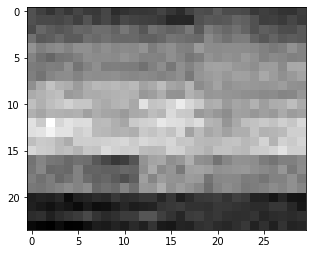

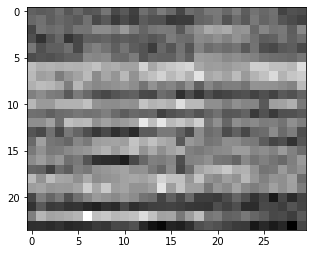

[851/17000] loss_d: -0.775, loss_g: 1.380
[852/17000] loss_d: -0.856, loss_g: 1.202
[853/17000] loss_d: -0.781, loss_g: 1.217
[854/17000] loss_d: -0.885, loss_g: 1.026
[855/17000] loss_d: -0.717, loss_g: 1.277
[856/17000] loss_d: -0.865, loss_g: 1.027
[857/17000] loss_d: -0.852, loss_g: 1.293
[858/17000] loss_d: -0.911, loss_g: 1.361
[859/17000] loss_d: -0.807, loss_g: 1.170
[860/17000] loss_d: -0.756, loss_g: 1.106
[861/17000] loss_d: -0.841, loss_g: 1.027
[862/17000] loss_d: -0.757, loss_g: 1.214
[863/17000] loss_d: -0.811, loss_g: 1.088
[864/17000] loss_d: -0.836, loss_g: 1.110
[865/17000] loss_d: -0.795, loss_g: 1.119
[866/17000] loss_d: -0.843, loss_g: 1.490
[867/17000] loss_d: -0.873, loss_g: 1.472
[868/17000] loss_d: -0.854, loss_g: 1.149
[869/17000] loss_d: -0.833, loss_g: 1.126
[870/17000] loss_d: -0.829, loss_g: 1.072
[871/17000] loss_d: -0.846, loss_g: 1.090
[872/17000] loss_d: -0.831, loss_g: 1.023
[873/17000] loss_d: -0.835, loss_g: 1.186
[874/17000] loss_d: -0.799, loss_g

<Figure size 432x288 with 0 Axes>

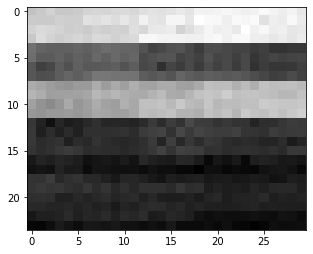

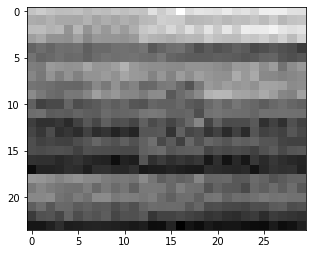

[901/17000] loss_d: -0.718, loss_g: 0.940
[902/17000] loss_d: -0.797, loss_g: 0.862
[903/17000] loss_d: -0.813, loss_g: 0.833
[904/17000] loss_d: -0.849, loss_g: 0.944
[905/17000] loss_d: -0.836, loss_g: 1.029
[906/17000] loss_d: -0.801, loss_g: 1.243
[907/17000] loss_d: -0.862, loss_g: 1.023
[908/17000] loss_d: -0.868, loss_g: 1.104
[909/17000] loss_d: -0.802, loss_g: 1.077
[910/17000] loss_d: -0.789, loss_g: 1.075
[911/17000] loss_d: -0.823, loss_g: 1.164
[912/17000] loss_d: -0.781, loss_g: 0.908
[913/17000] loss_d: -0.777, loss_g: 0.734
[914/17000] loss_d: -0.833, loss_g: 1.466
[915/17000] loss_d: -0.789, loss_g: 1.237
[916/17000] loss_d: -0.785, loss_g: 1.195
[917/17000] loss_d: -0.781, loss_g: 0.764
[918/17000] loss_d: -0.827, loss_g: 1.281
[919/17000] loss_d: -0.826, loss_g: 1.201
[920/17000] loss_d: -0.820, loss_g: 0.920
[921/17000] loss_d: -0.750, loss_g: 1.373
[922/17000] loss_d: -0.792, loss_g: 1.133
[923/17000] loss_d: -0.778, loss_g: 0.835
[924/17000] loss_d: -0.879, loss_g

<Figure size 432x288 with 0 Axes>

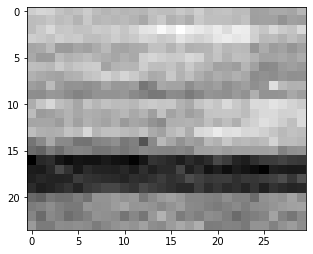

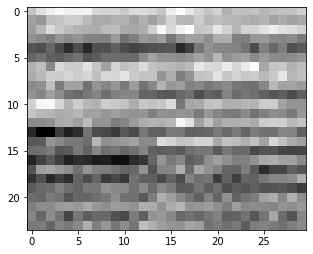

[951/17000] loss_d: -0.802, loss_g: 1.070
[952/17000] loss_d: -0.757, loss_g: 1.146
[953/17000] loss_d: -0.818, loss_g: 1.158
[954/17000] loss_d: -0.810, loss_g: 0.977
[955/17000] loss_d: -0.772, loss_g: 1.017
[956/17000] loss_d: -0.796, loss_g: 1.101
[957/17000] loss_d: -0.855, loss_g: 1.026
[958/17000] loss_d: -0.729, loss_g: 1.149
[959/17000] loss_d: -0.788, loss_g: 1.155
[960/17000] loss_d: -0.853, loss_g: 1.117
[961/17000] loss_d: -0.846, loss_g: 1.322
[962/17000] loss_d: -0.843, loss_g: 1.199
[963/17000] loss_d: -0.821, loss_g: 1.038
[964/17000] loss_d: -0.832, loss_g: 1.112
[965/17000] loss_d: -0.739, loss_g: 1.094
[966/17000] loss_d: -0.785, loss_g: 1.143
[967/17000] loss_d: -0.802, loss_g: 0.937
[968/17000] loss_d: -0.759, loss_g: 1.057
[969/17000] loss_d: -0.784, loss_g: 1.040
[970/17000] loss_d: -0.750, loss_g: 1.189
[971/17000] loss_d: -0.847, loss_g: 1.084
[972/17000] loss_d: -0.770, loss_g: 1.103
[973/17000] loss_d: -0.819, loss_g: 1.014
[974/17000] loss_d: -0.723, loss_g

<Figure size 432x288 with 0 Axes>

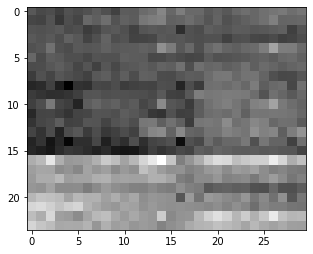

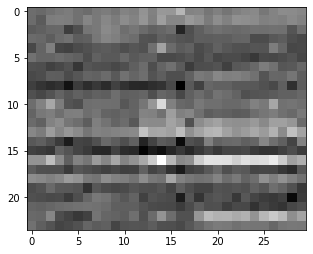

[1001/17000] loss_d: -0.752, loss_g: 1.029
[1002/17000] loss_d: -0.783, loss_g: 1.126
[1003/17000] loss_d: -0.840, loss_g: 1.015
[1004/17000] loss_d: -0.712, loss_g: 0.845
[1005/17000] loss_d: -0.766, loss_g: 1.052
[1006/17000] loss_d: -0.791, loss_g: 1.388
[1007/17000] loss_d: -0.737, loss_g: 0.913
[1008/17000] loss_d: -0.806, loss_g: 0.847
[1009/17000] loss_d: -0.764, loss_g: 0.938
[1010/17000] loss_d: -0.794, loss_g: 0.884
[1011/17000] loss_d: -0.800, loss_g: 1.211
[1012/17000] loss_d: -0.755, loss_g: 0.980
[1013/17000] loss_d: -0.780, loss_g: 1.192
[1014/17000] loss_d: -0.769, loss_g: 1.011
[1015/17000] loss_d: -0.787, loss_g: 1.114
[1016/17000] loss_d: -0.788, loss_g: 1.071
[1017/17000] loss_d: -0.815, loss_g: 1.139
[1018/17000] loss_d: -0.753, loss_g: 1.056
[1019/17000] loss_d: -0.776, loss_g: 1.241
[1020/17000] loss_d: -0.729, loss_g: 1.156
[1021/17000] loss_d: -0.800, loss_g: 1.269
[1022/17000] loss_d: -0.778, loss_g: 1.754
[1023/17000] loss_d: -0.768, loss_g: 1.304
[1024/17000

<Figure size 432x288 with 0 Axes>

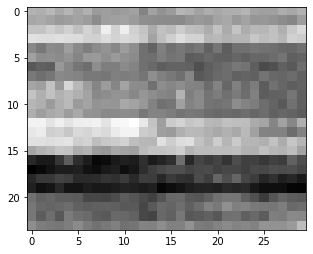

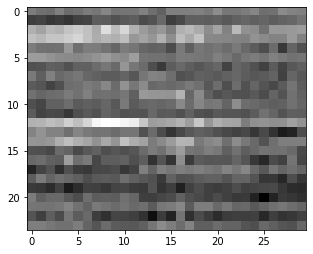

[1051/17000] loss_d: -0.751, loss_g: 1.333
[1052/17000] loss_d: -0.811, loss_g: 1.019
[1053/17000] loss_d: -0.729, loss_g: 1.111
[1054/17000] loss_d: -0.762, loss_g: 1.271
[1055/17000] loss_d: -0.735, loss_g: 1.106
[1056/17000] loss_d: -0.764, loss_g: 1.039
[1057/17000] loss_d: -0.769, loss_g: 1.100
[1058/17000] loss_d: -0.727, loss_g: 1.204
[1059/17000] loss_d: -0.778, loss_g: 1.231
[1060/17000] loss_d: -0.820, loss_g: 1.036
[1061/17000] loss_d: -0.847, loss_g: 0.906
[1062/17000] loss_d: -0.901, loss_g: 1.538
[1063/17000] loss_d: -0.768, loss_g: 1.162
[1064/17000] loss_d: -0.752, loss_g: 0.868
[1065/17000] loss_d: -0.756, loss_g: 1.158
[1066/17000] loss_d: -0.788, loss_g: 0.981
[1067/17000] loss_d: -0.725, loss_g: 1.045
[1068/17000] loss_d: -0.737, loss_g: 0.836
[1069/17000] loss_d: -0.759, loss_g: 1.283
[1070/17000] loss_d: -0.873, loss_g: 1.227
[1071/17000] loss_d: -0.769, loss_g: 1.015
[1072/17000] loss_d: -0.844, loss_g: 1.269
[1073/17000] loss_d: -0.699, loss_g: 1.102
[1074/17000

<Figure size 432x288 with 0 Axes>

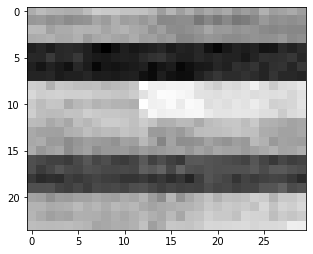

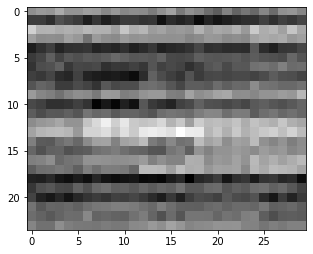

[1101/17000] loss_d: -0.803, loss_g: 1.053
[1102/17000] loss_d: -0.690, loss_g: 1.101
[1103/17000] loss_d: -0.736, loss_g: 1.281
[1104/17000] loss_d: -0.947, loss_g: 1.401
[1105/17000] loss_d: -0.701, loss_g: 1.172
[1106/17000] loss_d: -0.734, loss_g: 0.896
[1107/17000] loss_d: -0.742, loss_g: 0.844
[1108/17000] loss_d: -0.728, loss_g: 1.063
[1109/17000] loss_d: -0.775, loss_g: 1.006
[1110/17000] loss_d: -0.743, loss_g: 1.068
[1111/17000] loss_d: -0.712, loss_g: 1.286
[1112/17000] loss_d: -0.733, loss_g: 1.061
[1113/17000] loss_d: -0.688, loss_g: 1.325
[1114/17000] loss_d: -0.706, loss_g: 1.042
[1115/17000] loss_d: -0.713, loss_g: 0.908
[1116/17000] loss_d: -0.729, loss_g: 1.030
[1117/17000] loss_d: -0.764, loss_g: 0.936
[1118/17000] loss_d: -0.771, loss_g: 0.848
[1119/17000] loss_d: -0.722, loss_g: 1.147
[1120/17000] loss_d: -0.732, loss_g: 0.949
[1121/17000] loss_d: -0.776, loss_g: 0.961
[1122/17000] loss_d: -0.782, loss_g: 0.985
[1123/17000] loss_d: -0.752, loss_g: 0.953
[1124/17000

<Figure size 432x288 with 0 Axes>

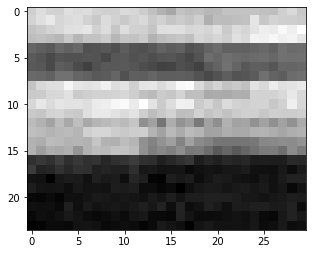

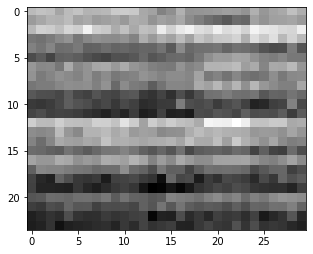

[1151/17000] loss_d: -0.673, loss_g: 1.085
[1152/17000] loss_d: -0.742, loss_g: 1.061
[1153/17000] loss_d: -0.728, loss_g: 0.954
[1154/17000] loss_d: -0.723, loss_g: 1.129
[1155/17000] loss_d: -0.641, loss_g: 0.935
[1156/17000] loss_d: -0.722, loss_g: 0.954
[1157/17000] loss_d: -0.815, loss_g: 1.187
[1158/17000] loss_d: -0.733, loss_g: 1.016
[1159/17000] loss_d: -0.670, loss_g: 1.007
[1160/17000] loss_d: -0.738, loss_g: 0.993
[1161/17000] loss_d: -0.751, loss_g: 1.040
[1162/17000] loss_d: -0.721, loss_g: 0.938
[1163/17000] loss_d: -0.741, loss_g: 0.851
[1164/17000] loss_d: -0.683, loss_g: 0.986
[1165/17000] loss_d: -0.720, loss_g: 0.941
[1166/17000] loss_d: -0.762, loss_g: 1.059
[1167/17000] loss_d: -0.725, loss_g: 1.052
[1168/17000] loss_d: -0.745, loss_g: 1.006
[1169/17000] loss_d: -0.761, loss_g: 1.012
[1170/17000] loss_d: -0.772, loss_g: 1.164
[1171/17000] loss_d: -0.736, loss_g: 1.031
[1172/17000] loss_d: -0.766, loss_g: 1.163
[1173/17000] loss_d: -0.738, loss_g: 1.402
[1174/17000

<Figure size 432x288 with 0 Axes>

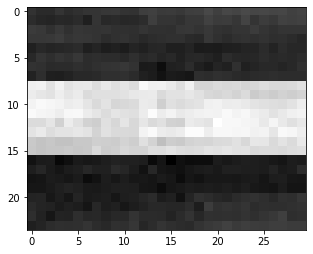

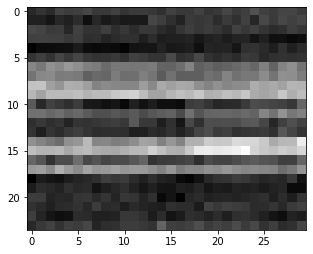

[1201/17000] loss_d: -0.729, loss_g: 1.094
[1202/17000] loss_d: -0.745, loss_g: 1.305
[1203/17000] loss_d: -0.773, loss_g: 1.579
[1204/17000] loss_d: -0.793, loss_g: 1.273
[1205/17000] loss_d: -0.744, loss_g: 1.141
[1206/17000] loss_d: -0.768, loss_g: 1.463
[1207/17000] loss_d: -0.613, loss_g: 1.176
[1208/17000] loss_d: -0.684, loss_g: 1.216
[1209/17000] loss_d: -0.693, loss_g: 1.142
[1210/17000] loss_d: -0.675, loss_g: 1.091
[1211/17000] loss_d: -0.702, loss_g: 1.155
[1212/17000] loss_d: -0.697, loss_g: 1.269
[1213/17000] loss_d: -0.690, loss_g: 1.362
[1214/17000] loss_d: -0.706, loss_g: 1.358
[1215/17000] loss_d: -0.666, loss_g: 1.186
[1216/17000] loss_d: -0.653, loss_g: 1.110
[1217/17000] loss_d: -0.670, loss_g: 1.315
[1218/17000] loss_d: -0.700, loss_g: 1.262
[1219/17000] loss_d: -0.691, loss_g: 1.188
[1220/17000] loss_d: -0.746, loss_g: 1.335
[1221/17000] loss_d: -0.717, loss_g: 1.151
[1222/17000] loss_d: -0.719, loss_g: 1.438
[1223/17000] loss_d: -0.661, loss_g: 1.187
[1224/17000

<Figure size 432x288 with 0 Axes>

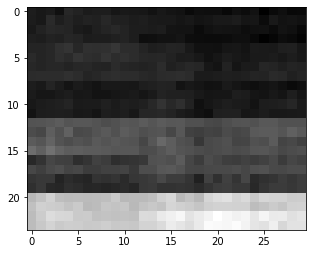

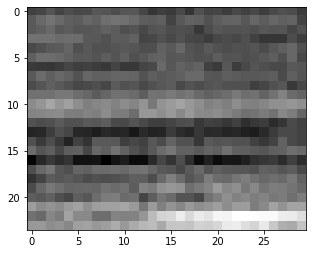

[1251/17000] loss_d: -0.725, loss_g: 1.472
[1252/17000] loss_d: -0.666, loss_g: 1.370
[1253/17000] loss_d: -0.644, loss_g: 1.053
[1254/17000] loss_d: -0.761, loss_g: 1.290
[1255/17000] loss_d: -0.601, loss_g: 1.233
[1256/17000] loss_d: -0.780, loss_g: 1.267
[1257/17000] loss_d: -0.676, loss_g: 1.198
[1258/17000] loss_d: -0.697, loss_g: 1.142
[1259/17000] loss_d: -0.598, loss_g: 1.221
[1260/17000] loss_d: -0.670, loss_g: 1.282
[1261/17000] loss_d: -0.664, loss_g: 1.271
[1262/17000] loss_d: -0.679, loss_g: 1.340
[1263/17000] loss_d: -0.664, loss_g: 1.045
[1264/17000] loss_d: -0.735, loss_g: 1.168
[1265/17000] loss_d: -0.679, loss_g: 1.147
[1266/17000] loss_d: -0.661, loss_g: 1.262
[1267/17000] loss_d: -0.729, loss_g: 1.457
[1268/17000] loss_d: -0.682, loss_g: 1.347
[1269/17000] loss_d: -0.649, loss_g: 1.251
[1270/17000] loss_d: -0.682, loss_g: 1.499
[1271/17000] loss_d: -0.764, loss_g: 1.218
[1272/17000] loss_d: -0.719, loss_g: 1.178
[1273/17000] loss_d: -0.657, loss_g: 1.398
[1274/17000

<Figure size 432x288 with 0 Axes>

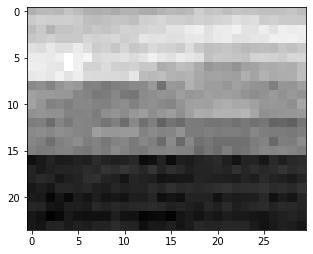

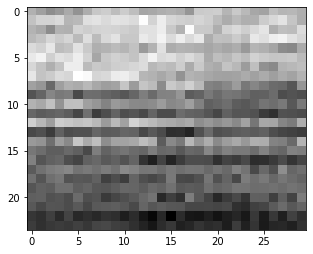

[1301/17000] loss_d: -0.627, loss_g: 1.304
[1302/17000] loss_d: -0.708, loss_g: 1.413
[1303/17000] loss_d: -0.700, loss_g: 1.411
[1304/17000] loss_d: -0.675, loss_g: 1.347
[1305/17000] loss_d: -0.678, loss_g: 1.318
[1306/17000] loss_d: -0.615, loss_g: 1.329
[1307/17000] loss_d: -0.734, loss_g: 1.611
[1308/17000] loss_d: -0.673, loss_g: 1.504
[1309/17000] loss_d: -0.683, loss_g: 1.196
[1310/17000] loss_d: -0.650, loss_g: 1.292
[1311/17000] loss_d: -0.639, loss_g: 1.146
[1312/17000] loss_d: -0.696, loss_g: 1.342
[1313/17000] loss_d: -0.603, loss_g: 1.214
[1314/17000] loss_d: -0.594, loss_g: 1.349
[1315/17000] loss_d: -0.683, loss_g: 1.283
[1316/17000] loss_d: -0.666, loss_g: 1.182
[1317/17000] loss_d: -0.635, loss_g: 1.142
[1318/17000] loss_d: -0.652, loss_g: 1.190
[1319/17000] loss_d: -0.660, loss_g: 1.501
[1320/17000] loss_d: -0.647, loss_g: 1.265
[1321/17000] loss_d: -0.640, loss_g: 1.158
[1322/17000] loss_d: -0.685, loss_g: 1.415
[1323/17000] loss_d: -0.653, loss_g: 1.365
[1324/17000

<Figure size 432x288 with 0 Axes>

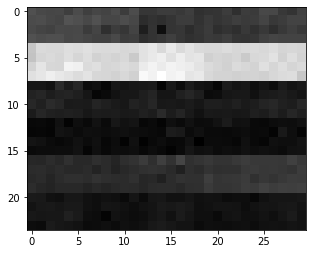

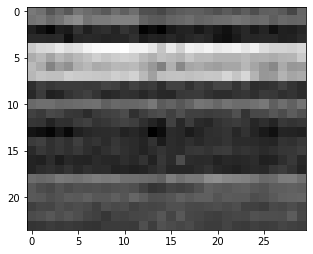

[1351/17000] loss_d: -0.649, loss_g: 1.342
[1352/17000] loss_d: -0.631, loss_g: 1.468
[1353/17000] loss_d: -0.649, loss_g: 1.371
[1354/17000] loss_d: -0.645, loss_g: 1.309
[1355/17000] loss_d: -0.692, loss_g: 1.301
[1356/17000] loss_d: -0.664, loss_g: 1.319
[1357/17000] loss_d: -0.724, loss_g: 1.500
[1358/17000] loss_d: -0.645, loss_g: 1.423
[1359/17000] loss_d: -0.636, loss_g: 1.335
[1360/17000] loss_d: -0.589, loss_g: 1.256
[1361/17000] loss_d: -0.623, loss_g: 1.308
[1362/17000] loss_d: -0.646, loss_g: 1.499
[1363/17000] loss_d: -0.679, loss_g: 1.365
[1364/17000] loss_d: -0.661, loss_g: 1.356
[1365/17000] loss_d: -0.618, loss_g: 1.421
[1366/17000] loss_d: -0.662, loss_g: 1.376
[1367/17000] loss_d: -0.630, loss_g: 1.552
[1368/17000] loss_d: -0.632, loss_g: 1.372
[1369/17000] loss_d: -0.673, loss_g: 1.368
[1370/17000] loss_d: -0.676, loss_g: 1.531
[1371/17000] loss_d: -0.645, loss_g: 1.213
[1372/17000] loss_d: -0.668, loss_g: 1.320
[1373/17000] loss_d: -0.598, loss_g: 1.488
[1374/17000

<Figure size 432x288 with 0 Axes>

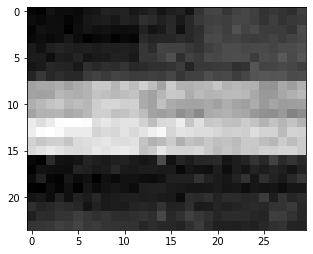

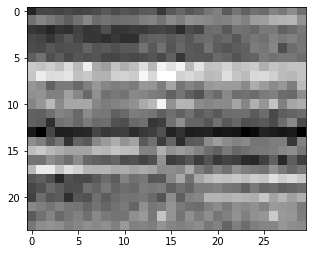

[1401/17000] loss_d: -0.620, loss_g: 1.259
[1402/17000] loss_d: -0.592, loss_g: 1.264
[1403/17000] loss_d: -0.650, loss_g: 1.285
[1404/17000] loss_d: -0.647, loss_g: 1.204
[1405/17000] loss_d: -0.633, loss_g: 1.328
[1406/17000] loss_d: -0.567, loss_g: 1.378
[1407/17000] loss_d: -0.666, loss_g: 1.312
[1408/17000] loss_d: -0.581, loss_g: 1.411
[1409/17000] loss_d: -0.572, loss_g: 1.442
[1410/17000] loss_d: -0.633, loss_g: 1.323
[1411/17000] loss_d: -0.600, loss_g: 1.195
[1412/17000] loss_d: -0.574, loss_g: 1.452
[1413/17000] loss_d: -0.583, loss_g: 1.128
[1414/17000] loss_d: -0.647, loss_g: 1.263
[1415/17000] loss_d: -0.592, loss_g: 1.330
[1416/17000] loss_d: -0.613, loss_g: 1.217
[1417/17000] loss_d: -0.654, loss_g: 1.286
[1418/17000] loss_d: -0.567, loss_g: 1.408
[1419/17000] loss_d: -0.612, loss_g: 1.247
[1420/17000] loss_d: -0.615, loss_g: 1.323
[1421/17000] loss_d: -0.545, loss_g: 1.180
[1422/17000] loss_d: -0.616, loss_g: 1.446
[1423/17000] loss_d: -0.674, loss_g: 1.519
[1424/17000

<Figure size 432x288 with 0 Axes>

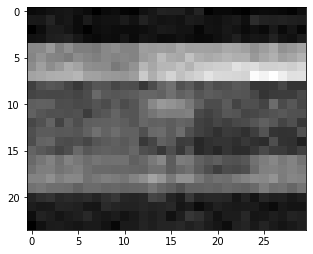

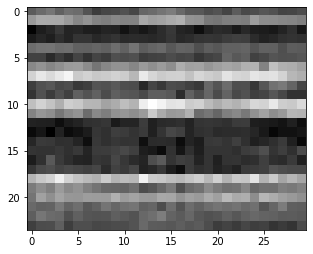

[1451/17000] loss_d: -0.627, loss_g: 1.137
[1452/17000] loss_d: -0.555, loss_g: 1.274
[1453/17000] loss_d: -0.632, loss_g: 1.271
[1454/17000] loss_d: -0.640, loss_g: 1.224
[1455/17000] loss_d: -0.660, loss_g: 1.222
[1456/17000] loss_d: -0.594, loss_g: 1.300
[1457/17000] loss_d: -0.576, loss_g: 1.280
[1458/17000] loss_d: -0.684, loss_g: 1.269
[1459/17000] loss_d: -0.589, loss_g: 1.492
[1460/17000] loss_d: -0.676, loss_g: 1.357
[1461/17000] loss_d: -0.534, loss_g: 1.350
[1462/17000] loss_d: -0.618, loss_g: 1.172
[1463/17000] loss_d: -0.573, loss_g: 1.412
[1464/17000] loss_d: -0.685, loss_g: 1.518
[1465/17000] loss_d: -0.647, loss_g: 1.484
[1466/17000] loss_d: -0.599, loss_g: 1.405
[1467/17000] loss_d: -0.611, loss_g: 1.354
[1468/17000] loss_d: -0.589, loss_g: 1.408
[1469/17000] loss_d: -0.557, loss_g: 1.487
[1470/17000] loss_d: -0.625, loss_g: 1.525
[1471/17000] loss_d: -0.641, loss_g: 1.485
[1472/17000] loss_d: -0.624, loss_g: 1.208
[1473/17000] loss_d: -0.650, loss_g: 1.345
[1474/17000

<Figure size 432x288 with 0 Axes>

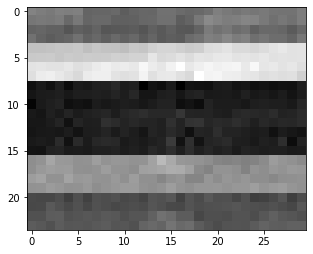

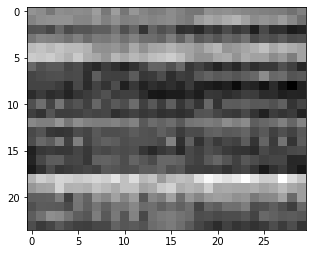

[1501/17000] loss_d: -0.566, loss_g: 1.240
[1502/17000] loss_d: -0.598, loss_g: 1.205
[1503/17000] loss_d: -0.556, loss_g: 1.283
[1504/17000] loss_d: -0.588, loss_g: 1.156
[1505/17000] loss_d: -0.568, loss_g: 1.272
[1506/17000] loss_d: -0.569, loss_g: 1.345
[1507/17000] loss_d: -0.568, loss_g: 1.017
[1508/17000] loss_d: -0.594, loss_g: 1.266
[1509/17000] loss_d: -0.593, loss_g: 1.293
[1510/17000] loss_d: -0.570, loss_g: 1.269
[1511/17000] loss_d: -0.586, loss_g: 1.325
[1512/17000] loss_d: -0.591, loss_g: 1.450
[1513/17000] loss_d: -0.612, loss_g: 1.290
[1514/17000] loss_d: -0.559, loss_g: 1.311
[1515/17000] loss_d: -0.559, loss_g: 1.477
[1516/17000] loss_d: -0.544, loss_g: 1.220
[1517/17000] loss_d: -0.593, loss_g: 1.205
[1518/17000] loss_d: -0.623, loss_g: 1.396
[1519/17000] loss_d: -0.609, loss_g: 1.385
[1520/17000] loss_d: -0.599, loss_g: 1.111
[1521/17000] loss_d: -0.602, loss_g: 1.185
[1522/17000] loss_d: -0.622, loss_g: 1.189
[1523/17000] loss_d: -0.587, loss_g: 1.148
[1524/17000

<Figure size 432x288 with 0 Axes>

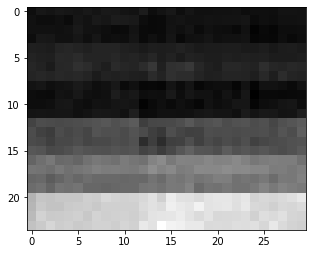

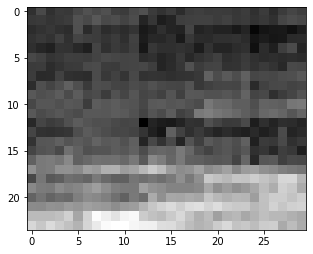

[1551/17000] loss_d: -0.573, loss_g: 1.218
[1552/17000] loss_d: -0.523, loss_g: 1.057
[1553/17000] loss_d: -0.571, loss_g: 1.324
[1554/17000] loss_d: -0.553, loss_g: 1.387
[1555/17000] loss_d: -0.577, loss_g: 1.260
[1556/17000] loss_d: -0.594, loss_g: 1.244
[1557/17000] loss_d: -0.589, loss_g: 1.078
[1558/17000] loss_d: -0.559, loss_g: 1.100
[1559/17000] loss_d: -0.564, loss_g: 1.148
[1560/17000] loss_d: -0.551, loss_g: 1.185
[1561/17000] loss_d: -0.553, loss_g: 1.342
[1562/17000] loss_d: -0.593, loss_g: 1.260
[1563/17000] loss_d: -0.591, loss_g: 1.510
[1564/17000] loss_d: -0.568, loss_g: 1.430
[1565/17000] loss_d: -0.585, loss_g: 1.332
[1566/17000] loss_d: -0.548, loss_g: 1.423
[1567/17000] loss_d: -0.562, loss_g: 1.426
[1568/17000] loss_d: -0.583, loss_g: 1.405
[1569/17000] loss_d: -0.554, loss_g: 1.322
[1570/17000] loss_d: -0.541, loss_g: 1.271
[1571/17000] loss_d: -0.604, loss_g: 1.291
[1572/17000] loss_d: -0.593, loss_g: 1.331
[1573/17000] loss_d: -0.584, loss_g: 1.158
[1574/17000

<Figure size 432x288 with 0 Axes>

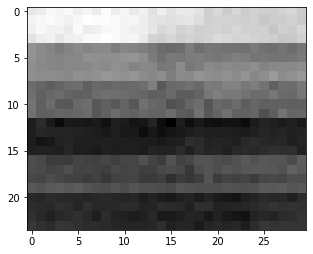

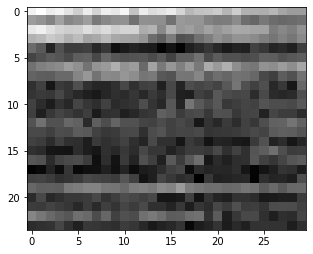

[1601/17000] loss_d: -0.543, loss_g: 1.251
[1602/17000] loss_d: -0.506, loss_g: 1.243
[1603/17000] loss_d: -0.499, loss_g: 1.304
[1604/17000] loss_d: -0.561, loss_g: 1.155
[1605/17000] loss_d: -0.508, loss_g: 1.283
[1606/17000] loss_d: -0.553, loss_g: 1.327
[1607/17000] loss_d: -0.538, loss_g: 1.395
[1608/17000] loss_d: -0.586, loss_g: 1.186
[1609/17000] loss_d: -0.543, loss_g: 1.409
[1610/17000] loss_d: -0.619, loss_g: 1.332
[1611/17000] loss_d: -0.555, loss_g: 1.088
[1612/17000] loss_d: -0.557, loss_g: 1.248
[1613/17000] loss_d: -0.533, loss_g: 1.277
[1614/17000] loss_d: -0.569, loss_g: 1.313
[1615/17000] loss_d: -0.581, loss_g: 1.435
[1616/17000] loss_d: -0.573, loss_g: 1.188
[1617/17000] loss_d: -0.548, loss_g: 1.170
[1618/17000] loss_d: -0.516, loss_g: 1.282
[1619/17000] loss_d: -0.526, loss_g: 1.177
[1620/17000] loss_d: -0.568, loss_g: 1.283
[1621/17000] loss_d: -0.584, loss_g: 1.307
[1622/17000] loss_d: -0.535, loss_g: 1.282
[1623/17000] loss_d: -0.503, loss_g: 1.316
[1624/17000

<Figure size 432x288 with 0 Axes>

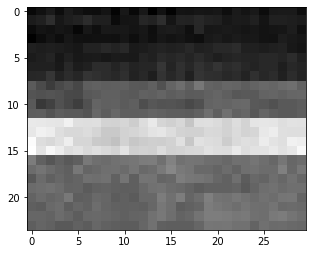

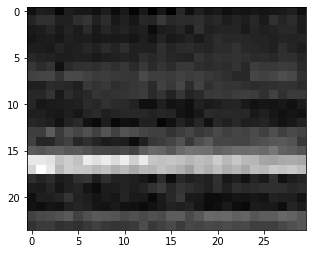

[1651/17000] loss_d: -0.501, loss_g: 1.330
[1652/17000] loss_d: -0.523, loss_g: 1.273
[1653/17000] loss_d: -0.547, loss_g: 1.286
[1654/17000] loss_d: -0.505, loss_g: 1.202
[1655/17000] loss_d: -0.524, loss_g: 1.269
[1656/17000] loss_d: -0.506, loss_g: 1.298
[1657/17000] loss_d: -0.535, loss_g: 1.272
[1658/17000] loss_d: -0.538, loss_g: 1.270
[1659/17000] loss_d: -0.529, loss_g: 1.228
[1660/17000] loss_d: -0.535, loss_g: 1.266
[1661/17000] loss_d: -0.512, loss_g: 1.365
[1662/17000] loss_d: -0.501, loss_g: 1.281
[1663/17000] loss_d: -0.483, loss_g: 1.280
[1664/17000] loss_d: -0.569, loss_g: 1.319
[1665/17000] loss_d: -0.563, loss_g: 1.761
[1666/17000] loss_d: -0.572, loss_g: 1.270
[1667/17000] loss_d: -0.542, loss_g: 1.228
[1668/17000] loss_d: -0.513, loss_g: 1.248
[1669/17000] loss_d: -0.528, loss_g: 1.265
[1670/17000] loss_d: -0.534, loss_g: 1.123
[1671/17000] loss_d: -0.521, loss_g: 1.217
[1672/17000] loss_d: -0.559, loss_g: 1.262
[1673/17000] loss_d: -0.549, loss_g: 1.408
[1674/17000

<Figure size 432x288 with 0 Axes>

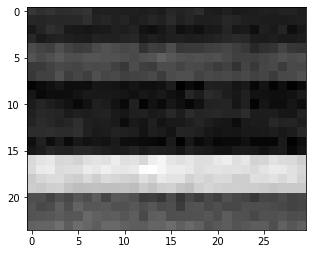

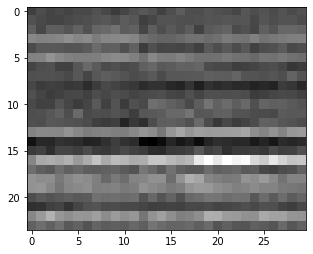

[1701/17000] loss_d: -0.492, loss_g: 1.277
[1702/17000] loss_d: -0.533, loss_g: 1.214
[1703/17000] loss_d: -0.526, loss_g: 1.430
[1704/17000] loss_d: -0.522, loss_g: 1.380
[1705/17000] loss_d: -0.539, loss_g: 1.223
[1706/17000] loss_d: -0.492, loss_g: 1.373
[1707/17000] loss_d: -0.495, loss_g: 1.425
[1708/17000] loss_d: -0.532, loss_g: 1.368
[1709/17000] loss_d: -0.541, loss_g: 1.317
[1710/17000] loss_d: -0.489, loss_g: 1.232
[1711/17000] loss_d: -0.527, loss_g: 1.166
[1712/17000] loss_d: -0.521, loss_g: 1.259
[1713/17000] loss_d: -0.518, loss_g: 1.137
[1714/17000] loss_d: -0.533, loss_g: 1.158
[1715/17000] loss_d: -0.489, loss_g: 1.158
[1716/17000] loss_d: -0.542, loss_g: 1.454
[1717/17000] loss_d: -0.489, loss_g: 1.212
[1718/17000] loss_d: -0.524, loss_g: 1.118
[1719/17000] loss_d: -0.516, loss_g: 1.157
[1720/17000] loss_d: -0.539, loss_g: 1.156
[1721/17000] loss_d: -0.531, loss_g: 1.267
[1722/17000] loss_d: -0.510, loss_g: 1.188
[1723/17000] loss_d: -0.514, loss_g: 1.066
[1724/17000

<Figure size 432x288 with 0 Axes>

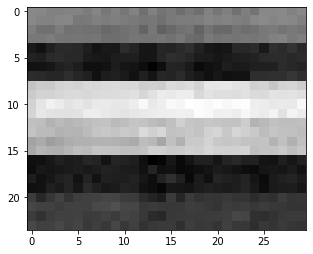

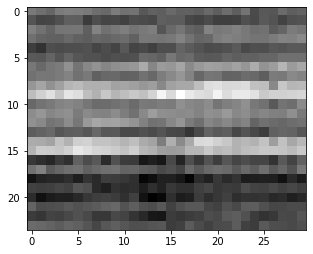

[1751/17000] loss_d: -0.490, loss_g: 1.235
[1752/17000] loss_d: -0.494, loss_g: 1.156
[1753/17000] loss_d: -0.479, loss_g: 1.289
[1754/17000] loss_d: -0.487, loss_g: 1.083
[1755/17000] loss_d: -0.554, loss_g: 1.084
[1756/17000] loss_d: -0.501, loss_g: 1.077
[1757/17000] loss_d: -0.525, loss_g: 1.253
[1758/17000] loss_d: -0.492, loss_g: 1.308
[1759/17000] loss_d: -0.485, loss_g: 1.126
[1760/17000] loss_d: -0.515, loss_g: 1.189
[1761/17000] loss_d: -0.449, loss_g: 1.119
[1762/17000] loss_d: -0.515, loss_g: 1.078
[1763/17000] loss_d: -0.532, loss_g: 1.045
[1764/17000] loss_d: -0.506, loss_g: 1.261
[1765/17000] loss_d: -0.528, loss_g: 1.118
[1766/17000] loss_d: -0.505, loss_g: 1.234
[1767/17000] loss_d: -0.461, loss_g: 1.112
[1768/17000] loss_d: -0.484, loss_g: 1.114
[1769/17000] loss_d: -0.505, loss_g: 1.200
[1770/17000] loss_d: -0.503, loss_g: 1.183
[1771/17000] loss_d: -0.497, loss_g: 1.061
[1772/17000] loss_d: -0.447, loss_g: 1.161
[1773/17000] loss_d: -0.512, loss_g: 1.244
[1774/17000

<Figure size 432x288 with 0 Axes>

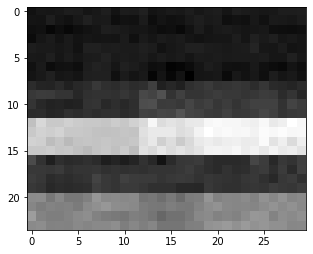

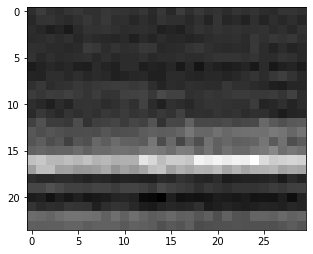

[1801/17000] loss_d: -0.486, loss_g: 1.110
[1802/17000] loss_d: -0.506, loss_g: 1.330
[1803/17000] loss_d: -0.484, loss_g: 1.203
[1804/17000] loss_d: -0.515, loss_g: 1.081
[1805/17000] loss_d: -0.498, loss_g: 1.246
[1806/17000] loss_d: -0.498, loss_g: 1.268
[1807/17000] loss_d: -0.484, loss_g: 1.107
[1808/17000] loss_d: -0.442, loss_g: 1.148
[1809/17000] loss_d: -0.494, loss_g: 1.135
[1810/17000] loss_d: -0.519, loss_g: 1.063
[1811/17000] loss_d: -0.537, loss_g: 1.137
[1812/17000] loss_d: -0.499, loss_g: 1.206
[1813/17000] loss_d: -0.494, loss_g: 1.052
[1814/17000] loss_d: -0.476, loss_g: 1.221
[1815/17000] loss_d: -0.471, loss_g: 0.986
[1816/17000] loss_d: -0.449, loss_g: 1.162
[1817/17000] loss_d: -0.509, loss_g: 1.155
[1818/17000] loss_d: -0.492, loss_g: 1.058
[1819/17000] loss_d: -0.510, loss_g: 1.212
[1820/17000] loss_d: -0.463, loss_g: 1.192
[1821/17000] loss_d: -0.497, loss_g: 1.237
[1822/17000] loss_d: -0.479, loss_g: 1.265
[1823/17000] loss_d: -0.532, loss_g: 1.118
[1824/17000

<Figure size 432x288 with 0 Axes>

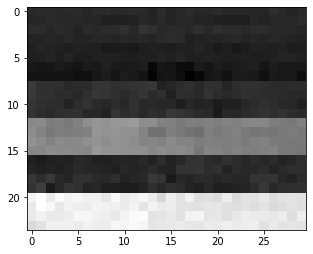

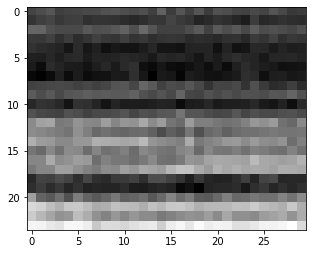

[1851/17000] loss_d: -0.507, loss_g: 1.193
[1852/17000] loss_d: -0.484, loss_g: 1.126
[1853/17000] loss_d: -0.479, loss_g: 1.136
[1854/17000] loss_d: -0.478, loss_g: 1.103
[1855/17000] loss_d: -0.501, loss_g: 1.190
[1856/17000] loss_d: -0.502, loss_g: 1.191
[1857/17000] loss_d: -0.471, loss_g: 1.289
[1858/17000] loss_d: -0.459, loss_g: 1.199
[1859/17000] loss_d: -0.484, loss_g: 1.123
[1860/17000] loss_d: -0.521, loss_g: 1.237
[1861/17000] loss_d: -0.502, loss_g: 1.266
[1862/17000] loss_d: -0.524, loss_g: 1.190
[1863/17000] loss_d: -0.467, loss_g: 1.108
[1864/17000] loss_d: -0.482, loss_g: 1.095
[1865/17000] loss_d: -0.467, loss_g: 1.037
[1866/17000] loss_d: -0.464, loss_g: 1.121
[1867/17000] loss_d: -0.509, loss_g: 1.276
[1868/17000] loss_d: -0.503, loss_g: 1.241
[1869/17000] loss_d: -0.448, loss_g: 1.264
[1870/17000] loss_d: -0.495, loss_g: 1.311
[1871/17000] loss_d: -0.489, loss_g: 1.295
[1872/17000] loss_d: -0.479, loss_g: 1.341
[1873/17000] loss_d: -0.533, loss_g: 1.295
[1874/17000

<Figure size 432x288 with 0 Axes>

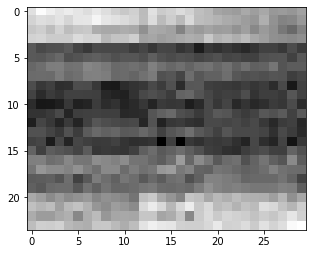

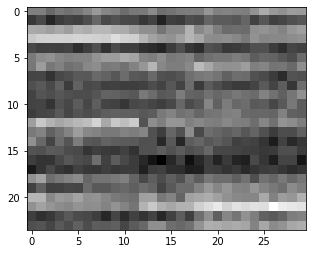

[1901/17000] loss_d: -0.489, loss_g: 1.227
[1902/17000] loss_d: -0.478, loss_g: 1.265
[1903/17000] loss_d: -0.469, loss_g: 1.251
[1904/17000] loss_d: -0.503, loss_g: 1.201
[1905/17000] loss_d: -0.492, loss_g: 1.049
[1906/17000] loss_d: -0.499, loss_g: 1.256
[1907/17000] loss_d: -0.558, loss_g: 1.218
[1908/17000] loss_d: -0.529, loss_g: 1.163
[1909/17000] loss_d: -0.458, loss_g: 1.288
[1910/17000] loss_d: -0.468, loss_g: 1.201
[1911/17000] loss_d: -0.485, loss_g: 1.219
[1912/17000] loss_d: -0.470, loss_g: 1.179
[1913/17000] loss_d: -0.477, loss_g: 1.193
[1914/17000] loss_d: -0.483, loss_g: 1.237
[1915/17000] loss_d: -0.490, loss_g: 1.201
[1916/17000] loss_d: -0.461, loss_g: 1.189
[1917/17000] loss_d: -0.475, loss_g: 1.147
[1918/17000] loss_d: -0.457, loss_g: 1.198
[1919/17000] loss_d: -0.463, loss_g: 1.080
[1920/17000] loss_d: -0.530, loss_g: 1.177
[1921/17000] loss_d: -0.455, loss_g: 1.166
[1922/17000] loss_d: -0.459, loss_g: 1.141
[1923/17000] loss_d: -0.469, loss_g: 1.249
[1924/17000

<Figure size 432x288 with 0 Axes>

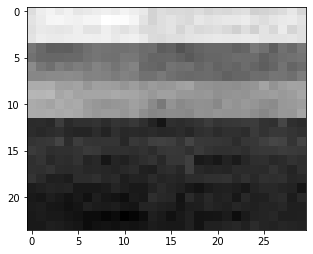

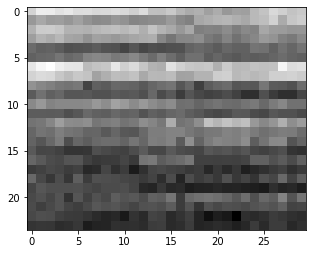

[1951/17000] loss_d: -0.440, loss_g: 1.473
[1952/17000] loss_d: -0.421, loss_g: 1.414
[1953/17000] loss_d: -0.495, loss_g: 1.280
[1954/17000] loss_d: -0.483, loss_g: 1.219
[1955/17000] loss_d: -0.487, loss_g: 1.282
[1956/17000] loss_d: -0.455, loss_g: 1.314
[1957/17000] loss_d: -0.483, loss_g: 1.338
[1958/17000] loss_d: -0.454, loss_g: 1.302
[1959/17000] loss_d: -0.496, loss_g: 1.243
[1960/17000] loss_d: -0.514, loss_g: 1.330
[1961/17000] loss_d: -0.436, loss_g: 1.445
[1962/17000] loss_d: -0.426, loss_g: 1.455
[1963/17000] loss_d: -0.477, loss_g: 1.361
[1964/17000] loss_d: -0.522, loss_g: 1.422
[1965/17000] loss_d: -0.485, loss_g: 1.373
[1966/17000] loss_d: -0.470, loss_g: 1.448
[1967/17000] loss_d: -0.463, loss_g: 1.298
[1968/17000] loss_d: -0.400, loss_g: 1.158
[1969/17000] loss_d: -0.474, loss_g: 1.223
[1970/17000] loss_d: -0.503, loss_g: 1.278
[1971/17000] loss_d: -0.495, loss_g: 1.357
[1972/17000] loss_d: -0.447, loss_g: 1.477
[1973/17000] loss_d: -0.478, loss_g: 1.372
[1974/17000

<Figure size 432x288 with 0 Axes>

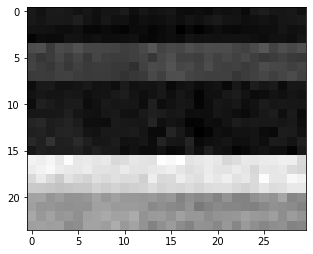

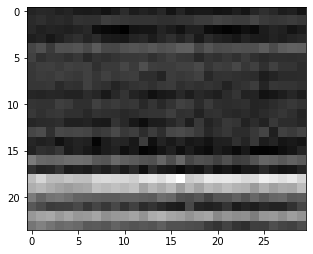

[2001/17000] loss_d: -0.433, loss_g: 1.202
[2002/17000] loss_d: -0.458, loss_g: 1.155
[2003/17000] loss_d: -0.480, loss_g: 1.174
[2004/17000] loss_d: -0.465, loss_g: 1.180
[2005/17000] loss_d: -0.465, loss_g: 1.303
[2006/17000] loss_d: -0.470, loss_g: 1.056
[2007/17000] loss_d: -0.500, loss_g: 1.173
[2008/17000] loss_d: -0.448, loss_g: 1.162
[2009/17000] loss_d: -0.473, loss_g: 1.134
[2010/17000] loss_d: -0.464, loss_g: 1.123
[2011/17000] loss_d: -0.433, loss_g: 1.229
[2012/17000] loss_d: -0.473, loss_g: 1.225
[2013/17000] loss_d: -0.475, loss_g: 1.206
[2014/17000] loss_d: -0.468, loss_g: 1.183
[2015/17000] loss_d: -0.456, loss_g: 1.072
[2016/17000] loss_d: -0.512, loss_g: 1.048
[2017/17000] loss_d: -0.440, loss_g: 1.122
[2018/17000] loss_d: -0.445, loss_g: 1.120
[2019/17000] loss_d: -0.480, loss_g: 1.062
[2020/17000] loss_d: -0.475, loss_g: 1.229
[2021/17000] loss_d: -0.474, loss_g: 1.149
[2022/17000] loss_d: -0.475, loss_g: 1.375
[2023/17000] loss_d: -0.450, loss_g: 1.218
[2024/17000

<Figure size 432x288 with 0 Axes>

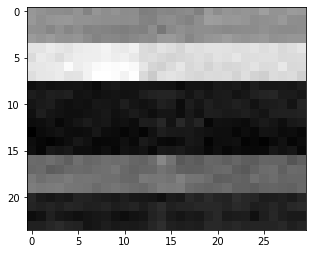

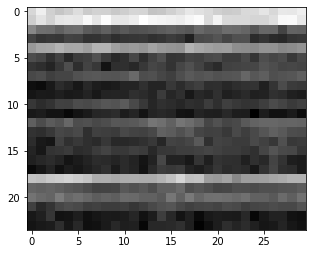

[2051/17000] loss_d: -0.454, loss_g: 1.247
[2052/17000] loss_d: -0.461, loss_g: 1.130
[2053/17000] loss_d: -0.455, loss_g: 1.315
[2054/17000] loss_d: -0.451, loss_g: 1.096
[2055/17000] loss_d: -0.452, loss_g: 1.254
[2056/17000] loss_d: -0.472, loss_g: 1.142
[2057/17000] loss_d: -0.426, loss_g: 1.211
[2058/17000] loss_d: -0.529, loss_g: 1.101
[2059/17000] loss_d: -0.515, loss_g: 1.220
[2060/17000] loss_d: -0.480, loss_g: 1.161
[2061/17000] loss_d: -0.456, loss_g: 1.132
[2062/17000] loss_d: -0.440, loss_g: 1.140
[2063/17000] loss_d: -0.468, loss_g: 1.176
[2064/17000] loss_d: -0.426, loss_g: 1.118
[2065/17000] loss_d: -0.453, loss_g: 1.111
[2066/17000] loss_d: -0.459, loss_g: 1.234
[2067/17000] loss_d: -0.405, loss_g: 1.137
[2068/17000] loss_d: -0.467, loss_g: 1.110
[2069/17000] loss_d: -0.472, loss_g: 1.096
[2070/17000] loss_d: -0.484, loss_g: 1.195
[2071/17000] loss_d: -0.423, loss_g: 1.310
[2072/17000] loss_d: -0.511, loss_g: 1.158
[2073/17000] loss_d: -0.467, loss_g: 1.223
[2074/17000

<Figure size 432x288 with 0 Axes>

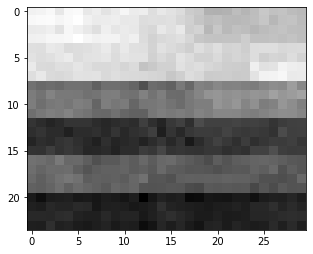

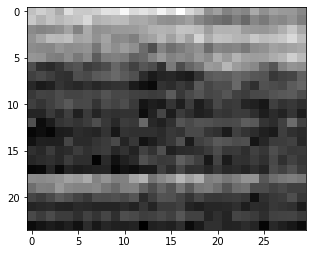

[2101/17000] loss_d: -0.461, loss_g: 1.240
[2102/17000] loss_d: -0.447, loss_g: 1.157
[2103/17000] loss_d: -0.436, loss_g: 1.171
[2104/17000] loss_d: -0.436, loss_g: 1.188
[2105/17000] loss_d: -0.498, loss_g: 1.197
[2106/17000] loss_d: -0.490, loss_g: 1.235
[2107/17000] loss_d: -0.503, loss_g: 1.322
[2108/17000] loss_d: -0.419, loss_g: 1.100
[2109/17000] loss_d: -0.454, loss_g: 1.355
[2110/17000] loss_d: -0.446, loss_g: 1.140
[2111/17000] loss_d: -0.441, loss_g: 1.117
[2112/17000] loss_d: -0.476, loss_g: 1.159
[2113/17000] loss_d: -0.466, loss_g: 1.172
[2114/17000] loss_d: -0.454, loss_g: 1.196
[2115/17000] loss_d: -0.467, loss_g: 1.243
[2116/17000] loss_d: -0.432, loss_g: 1.267
[2117/17000] loss_d: -0.485, loss_g: 1.210
[2118/17000] loss_d: -0.473, loss_g: 1.216
[2119/17000] loss_d: -0.478, loss_g: 1.259
[2120/17000] loss_d: -0.496, loss_g: 1.373
[2121/17000] loss_d: -0.483, loss_g: 1.187
[2122/17000] loss_d: -0.487, loss_g: 1.221
[2123/17000] loss_d: -0.456, loss_g: 1.397
[2124/17000

<Figure size 432x288 with 0 Axes>

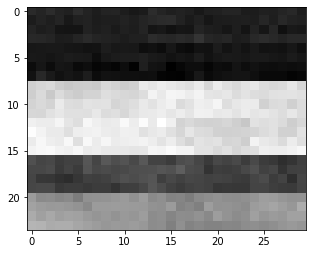

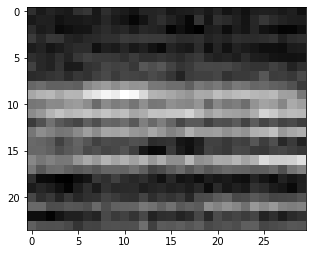

[2151/17000] loss_d: -0.456, loss_g: 1.233
[2152/17000] loss_d: -0.443, loss_g: 1.340
[2153/17000] loss_d: -0.429, loss_g: 1.304
[2154/17000] loss_d: -0.488, loss_g: 1.283
[2155/17000] loss_d: -0.488, loss_g: 1.078
[2156/17000] loss_d: -0.415, loss_g: 1.275
[2157/17000] loss_d: -0.473, loss_g: 1.283
[2158/17000] loss_d: -0.461, loss_g: 1.259
[2159/17000] loss_d: -0.460, loss_g: 1.261
[2160/17000] loss_d: -0.462, loss_g: 1.234
[2161/17000] loss_d: -0.453, loss_g: 1.165
[2162/17000] loss_d: -0.475, loss_g: 1.220
[2163/17000] loss_d: -0.456, loss_g: 1.343
[2164/17000] loss_d: -0.441, loss_g: 1.162
[2165/17000] loss_d: -0.466, loss_g: 1.213
[2166/17000] loss_d: -0.477, loss_g: 1.216
[2167/17000] loss_d: -0.467, loss_g: 1.272
[2168/17000] loss_d: -0.475, loss_g: 1.139
[2169/17000] loss_d: -0.422, loss_g: 1.158
[2170/17000] loss_d: -0.470, loss_g: 1.156
[2171/17000] loss_d: -0.453, loss_g: 1.198
[2172/17000] loss_d: -0.422, loss_g: 1.292
[2173/17000] loss_d: -0.433, loss_g: 1.115
[2174/17000

<Figure size 432x288 with 0 Axes>

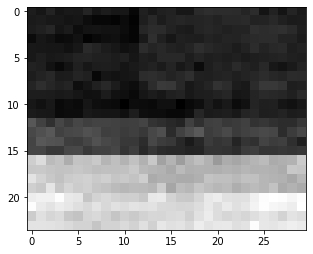

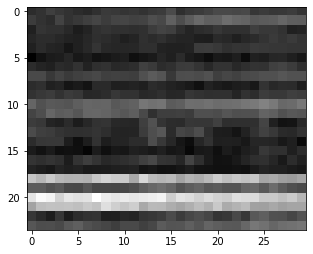

[2201/17000] loss_d: -0.443, loss_g: 1.167
[2202/17000] loss_d: -0.450, loss_g: 1.183
[2203/17000] loss_d: -0.444, loss_g: 1.159
[2204/17000] loss_d: -0.473, loss_g: 1.183
[2205/17000] loss_d: -0.418, loss_g: 1.261
[2206/17000] loss_d: -0.487, loss_g: 1.416
[2207/17000] loss_d: -0.514, loss_g: 1.129
[2208/17000] loss_d: -0.440, loss_g: 1.282
[2209/17000] loss_d: -0.437, loss_g: 1.194
[2210/17000] loss_d: -0.488, loss_g: 1.263
[2211/17000] loss_d: -0.466, loss_g: 1.235
[2212/17000] loss_d: -0.441, loss_g: 1.265
[2213/17000] loss_d: -0.457, loss_g: 1.335
[2214/17000] loss_d: -0.456, loss_g: 1.184
[2215/17000] loss_d: -0.455, loss_g: 1.243
[2216/17000] loss_d: -0.469, loss_g: 1.169
[2217/17000] loss_d: -0.440, loss_g: 1.319
[2218/17000] loss_d: -0.424, loss_g: 1.253
[2219/17000] loss_d: -0.468, loss_g: 1.240
[2220/17000] loss_d: -0.432, loss_g: 1.163
[2221/17000] loss_d: -0.439, loss_g: 1.145
[2222/17000] loss_d: -0.443, loss_g: 1.288
[2223/17000] loss_d: -0.441, loss_g: 1.222
[2224/17000

<Figure size 432x288 with 0 Axes>

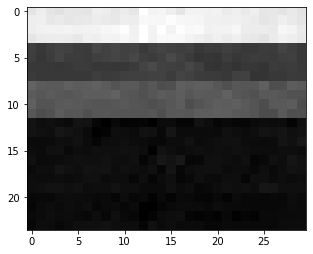

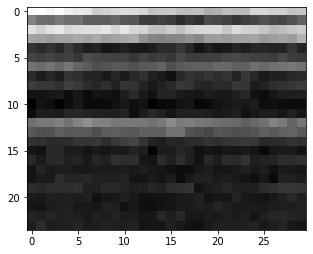

[2251/17000] loss_d: -0.455, loss_g: 1.241
[2252/17000] loss_d: -0.448, loss_g: 1.210
[2253/17000] loss_d: -0.461, loss_g: 1.165
[2254/17000] loss_d: -0.429, loss_g: 1.346
[2255/17000] loss_d: -0.490, loss_g: 1.228
[2256/17000] loss_d: -0.424, loss_g: 1.243
[2257/17000] loss_d: -0.450, loss_g: 1.319
[2258/17000] loss_d: -0.477, loss_g: 1.386
[2259/17000] loss_d: -0.473, loss_g: 1.329
[2260/17000] loss_d: -0.447, loss_g: 1.331
[2261/17000] loss_d: -0.466, loss_g: 1.340
[2262/17000] loss_d: -0.398, loss_g: 1.485
[2263/17000] loss_d: -0.442, loss_g: 1.291
[2264/17000] loss_d: -0.436, loss_g: 1.375
[2265/17000] loss_d: -0.438, loss_g: 1.466
[2266/17000] loss_d: -0.446, loss_g: 1.283
[2267/17000] loss_d: -0.418, loss_g: 1.254
[2268/17000] loss_d: -0.472, loss_g: 1.307
[2269/17000] loss_d: -0.444, loss_g: 1.231
[2270/17000] loss_d: -0.476, loss_g: 1.175
[2271/17000] loss_d: -0.454, loss_g: 1.315
[2272/17000] loss_d: -0.405, loss_g: 1.271
[2273/17000] loss_d: -0.449, loss_g: 1.306
[2274/17000

<Figure size 432x288 with 0 Axes>

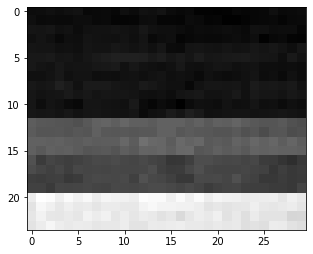

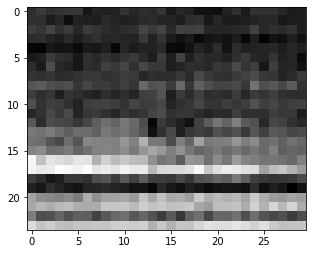

[2301/17000] loss_d: -0.419, loss_g: 1.461
[2302/17000] loss_d: -0.460, loss_g: 1.168
[2303/17000] loss_d: -0.410, loss_g: 1.201
[2304/17000] loss_d: -0.457, loss_g: 1.129
[2305/17000] loss_d: -0.479, loss_g: 1.336
[2306/17000] loss_d: -0.417, loss_g: 1.213
[2307/17000] loss_d: -0.417, loss_g: 1.391
[2308/17000] loss_d: -0.449, loss_g: 1.239
[2309/17000] loss_d: -0.420, loss_g: 1.293
[2310/17000] loss_d: -0.432, loss_g: 1.236
[2311/17000] loss_d: -0.414, loss_g: 1.287
[2312/17000] loss_d: -0.433, loss_g: 1.290
[2313/17000] loss_d: -0.427, loss_g: 1.180
[2314/17000] loss_d: -0.438, loss_g: 1.145
[2315/17000] loss_d: -0.412, loss_g: 1.278
[2316/17000] loss_d: -0.449, loss_g: 1.161
[2317/17000] loss_d: -0.434, loss_g: 1.275
[2318/17000] loss_d: -0.472, loss_g: 1.285
[2319/17000] loss_d: -0.419, loss_g: 1.235
[2320/17000] loss_d: -0.397, loss_g: 1.270
[2321/17000] loss_d: -0.438, loss_g: 1.153
[2322/17000] loss_d: -0.488, loss_g: 1.320
[2323/17000] loss_d: -0.400, loss_g: 1.281
[2324/17000

<Figure size 432x288 with 0 Axes>

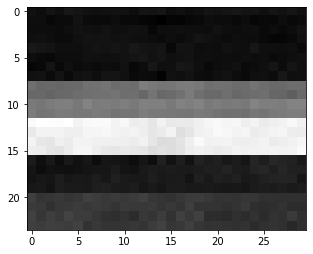

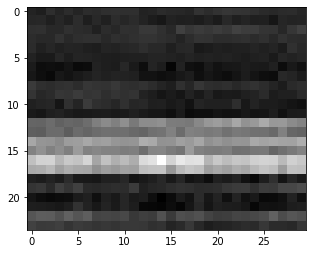

[2351/17000] loss_d: -0.413, loss_g: 1.247
[2352/17000] loss_d: -0.420, loss_g: 1.255
[2353/17000] loss_d: -0.426, loss_g: 1.288
[2354/17000] loss_d: -0.452, loss_g: 1.222
[2355/17000] loss_d: -0.443, loss_g: 1.180
[2356/17000] loss_d: -0.447, loss_g: 1.161
[2357/17000] loss_d: -0.384, loss_g: 1.196
[2358/17000] loss_d: -0.452, loss_g: 1.219
[2359/17000] loss_d: -0.423, loss_g: 1.218
[2360/17000] loss_d: -0.435, loss_g: 1.105
[2361/17000] loss_d: -0.406, loss_g: 1.172
[2362/17000] loss_d: -0.472, loss_g: 1.152
[2363/17000] loss_d: -0.450, loss_g: 1.551
[2364/17000] loss_d: -0.447, loss_g: 1.124
[2365/17000] loss_d: -0.454, loss_g: 1.095
[2366/17000] loss_d: -0.431, loss_g: 1.145
[2367/17000] loss_d: -0.396, loss_g: 1.105
[2368/17000] loss_d: -0.406, loss_g: 1.160
[2369/17000] loss_d: -0.442, loss_g: 1.140
[2370/17000] loss_d: -0.485, loss_g: 1.140
[2371/17000] loss_d: -0.432, loss_g: 1.389
[2372/17000] loss_d: -0.425, loss_g: 1.101
[2373/17000] loss_d: -0.443, loss_g: 1.069
[2374/17000

<Figure size 432x288 with 0 Axes>

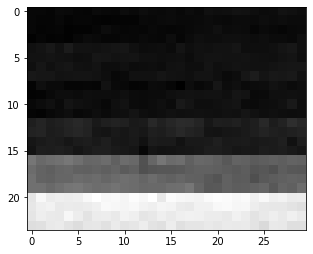

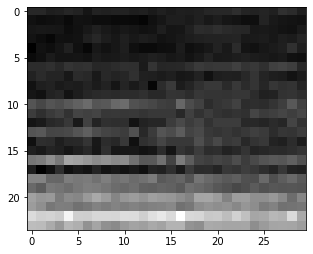

[2401/17000] loss_d: -0.446, loss_g: 1.333
[2402/17000] loss_d: -0.431, loss_g: 1.259
[2403/17000] loss_d: -0.444, loss_g: 1.367
[2404/17000] loss_d: -0.405, loss_g: 1.362
[2405/17000] loss_d: -0.451, loss_g: 1.301
[2406/17000] loss_d: -0.452, loss_g: 1.241
[2407/17000] loss_d: -0.423, loss_g: 1.351
[2408/17000] loss_d: -0.396, loss_g: 1.397
[2409/17000] loss_d: -0.450, loss_g: 1.276
[2410/17000] loss_d: -0.421, loss_g: 1.349
[2411/17000] loss_d: -0.469, loss_g: 1.306
[2412/17000] loss_d: -0.439, loss_g: 1.241
[2413/17000] loss_d: -0.444, loss_g: 1.303
[2414/17000] loss_d: -0.461, loss_g: 1.373
[2415/17000] loss_d: -0.405, loss_g: 1.221
[2416/17000] loss_d: -0.394, loss_g: 1.201
[2417/17000] loss_d: -0.425, loss_g: 1.236
[2418/17000] loss_d: -0.421, loss_g: 1.262
[2419/17000] loss_d: -0.438, loss_g: 1.331
[2420/17000] loss_d: -0.402, loss_g: 1.385
[2421/17000] loss_d: -0.421, loss_g: 1.335
[2422/17000] loss_d: -0.421, loss_g: 1.253
[2423/17000] loss_d: -0.436, loss_g: 1.292
[2424/17000

<Figure size 432x288 with 0 Axes>

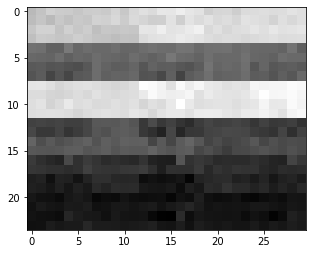

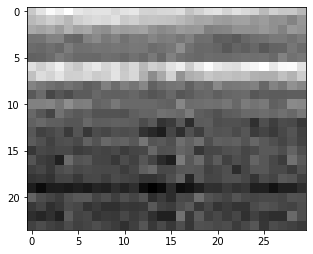

[2451/17000] loss_d: -0.450, loss_g: 1.379
[2452/17000] loss_d: -0.435, loss_g: 1.240
[2453/17000] loss_d: -0.428, loss_g: 1.242
[2454/17000] loss_d: -0.409, loss_g: 1.270
[2455/17000] loss_d: -0.441, loss_g: 1.376
[2456/17000] loss_d: -0.384, loss_g: 1.317
[2457/17000] loss_d: -0.378, loss_g: 1.318
[2458/17000] loss_d: -0.413, loss_g: 1.309
[2459/17000] loss_d: -0.420, loss_g: 1.361
[2460/17000] loss_d: -0.448, loss_g: 1.402
[2461/17000] loss_d: -0.452, loss_g: 1.279
[2462/17000] loss_d: -0.411, loss_g: 1.339
[2463/17000] loss_d: -0.422, loss_g: 1.282
[2464/17000] loss_d: -0.410, loss_g: 1.229
[2465/17000] loss_d: -0.433, loss_g: 1.400
[2466/17000] loss_d: -0.460, loss_g: 1.326
[2467/17000] loss_d: -0.452, loss_g: 1.477
[2468/17000] loss_d: -0.419, loss_g: 1.321
[2469/17000] loss_d: -0.432, loss_g: 1.385
[2470/17000] loss_d: -0.458, loss_g: 1.320
[2471/17000] loss_d: -0.456, loss_g: 1.474
[2472/17000] loss_d: -0.426, loss_g: 1.583
[2473/17000] loss_d: -0.442, loss_g: 1.349
[2474/17000

<Figure size 432x288 with 0 Axes>

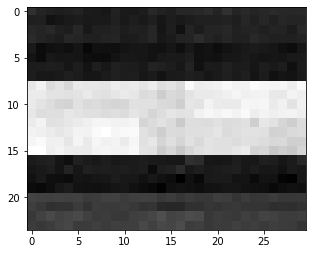

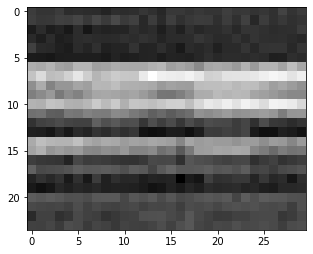

[2501/17000] loss_d: -0.453, loss_g: 1.442
[2502/17000] loss_d: -0.407, loss_g: 1.249
[2503/17000] loss_d: -0.433, loss_g: 1.427
[2504/17000] loss_d: -0.414, loss_g: 1.487
[2505/17000] loss_d: -0.475, loss_g: 1.356
[2506/17000] loss_d: -0.410, loss_g: 1.387
[2507/17000] loss_d: -0.452, loss_g: 1.454
[2508/17000] loss_d: -0.428, loss_g: 1.322
[2509/17000] loss_d: -0.424, loss_g: 1.431
[2510/17000] loss_d: -0.414, loss_g: 1.350
[2511/17000] loss_d: -0.464, loss_g: 1.306
[2512/17000] loss_d: -0.397, loss_g: 1.377
[2513/17000] loss_d: -0.445, loss_g: 1.420
[2514/17000] loss_d: -0.446, loss_g: 1.589
[2515/17000] loss_d: -0.494, loss_g: 1.372
[2516/17000] loss_d: -0.429, loss_g: 1.246
[2517/17000] loss_d: -0.443, loss_g: 1.329
[2518/17000] loss_d: -0.442, loss_g: 1.382
[2519/17000] loss_d: -0.450, loss_g: 1.239
[2520/17000] loss_d: -0.427, loss_g: 1.307
[2521/17000] loss_d: -0.432, loss_g: 1.252
[2522/17000] loss_d: -0.452, loss_g: 1.335
[2523/17000] loss_d: -0.449, loss_g: 1.425
[2524/17000

<Figure size 432x288 with 0 Axes>

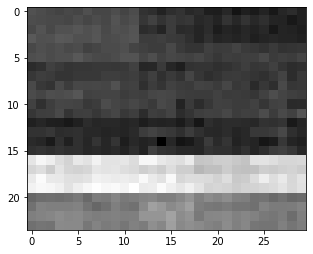

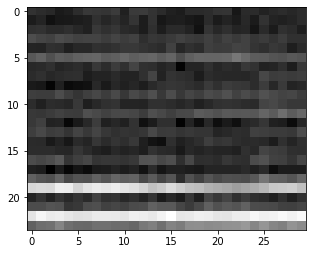

[2551/17000] loss_d: -0.446, loss_g: 1.327
[2552/17000] loss_d: -0.446, loss_g: 1.353
[2553/17000] loss_d: -0.400, loss_g: 1.297
[2554/17000] loss_d: -0.421, loss_g: 1.367
[2555/17000] loss_d: -0.403, loss_g: 1.213
[2556/17000] loss_d: -0.469, loss_g: 1.371
[2557/17000] loss_d: -0.485, loss_g: 1.316
[2558/17000] loss_d: -0.389, loss_g: 1.419
[2559/17000] loss_d: -0.424, loss_g: 1.375
[2560/17000] loss_d: -0.416, loss_g: 1.362
[2561/17000] loss_d: -0.414, loss_g: 1.236
[2562/17000] loss_d: -0.419, loss_g: 1.272
[2563/17000] loss_d: -0.412, loss_g: 1.229
[2564/17000] loss_d: -0.412, loss_g: 1.329
[2565/17000] loss_d: -0.440, loss_g: 1.432
[2566/17000] loss_d: -0.388, loss_g: 1.362
[2567/17000] loss_d: -0.461, loss_g: 1.440
[2568/17000] loss_d: -0.462, loss_g: 1.322
[2569/17000] loss_d: -0.408, loss_g: 1.310
[2570/17000] loss_d: -0.402, loss_g: 1.259
[2571/17000] loss_d: -0.426, loss_g: 1.292
[2572/17000] loss_d: -0.428, loss_g: 1.332
[2573/17000] loss_d: -0.399, loss_g: 1.369
[2574/17000

<Figure size 432x288 with 0 Axes>

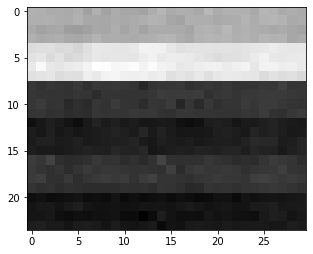

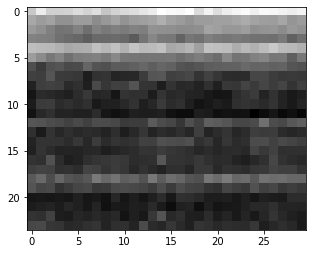

[2601/17000] loss_d: -0.414, loss_g: 1.316
[2602/17000] loss_d: -0.401, loss_g: 1.379
[2603/17000] loss_d: -0.409, loss_g: 1.378
[2604/17000] loss_d: -0.402, loss_g: 1.326
[2605/17000] loss_d: -0.442, loss_g: 1.463
[2606/17000] loss_d: -0.395, loss_g: 1.246
[2607/17000] loss_d: -0.387, loss_g: 1.231
[2608/17000] loss_d: -0.453, loss_g: 1.311
[2609/17000] loss_d: -0.421, loss_g: 1.214
[2610/17000] loss_d: -0.408, loss_g: 1.166
[2611/17000] loss_d: -0.400, loss_g: 1.281
[2612/17000] loss_d: -0.469, loss_g: 1.348
[2613/17000] loss_d: -0.396, loss_g: 1.233
[2614/17000] loss_d: -0.428, loss_g: 1.280
[2615/17000] loss_d: -0.424, loss_g: 1.238
[2616/17000] loss_d: -0.459, loss_g: 1.195
[2617/17000] loss_d: -0.423, loss_g: 1.227
[2618/17000] loss_d: -0.461, loss_g: 1.227
[2619/17000] loss_d: -0.419, loss_g: 1.358
[2620/17000] loss_d: -0.442, loss_g: 1.356
[2621/17000] loss_d: -0.408, loss_g: 1.265
[2622/17000] loss_d: -0.425, loss_g: 1.274
[2623/17000] loss_d: -0.417, loss_g: 1.198
[2624/17000

<Figure size 432x288 with 0 Axes>

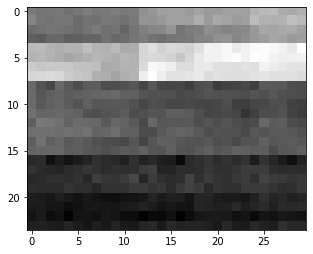

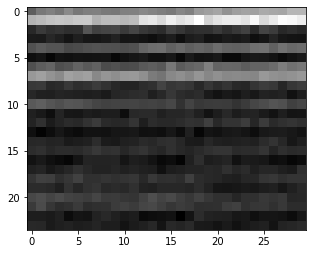

[2651/17000] loss_d: -0.414, loss_g: 1.186
[2652/17000] loss_d: -0.420, loss_g: 1.231
[2653/17000] loss_d: -0.433, loss_g: 1.282
[2654/17000] loss_d: -0.410, loss_g: 1.160
[2655/17000] loss_d: -0.450, loss_g: 1.097
[2656/17000] loss_d: -0.453, loss_g: 1.154
[2657/17000] loss_d: -0.414, loss_g: 1.356
[2658/17000] loss_d: -0.407, loss_g: 1.334
[2659/17000] loss_d: -0.404, loss_g: 1.156
[2660/17000] loss_d: -0.412, loss_g: 1.332
[2661/17000] loss_d: -0.410, loss_g: 1.289
[2662/17000] loss_d: -0.425, loss_g: 1.219
[2663/17000] loss_d: -0.433, loss_g: 1.231
[2664/17000] loss_d: -0.425, loss_g: 1.187
[2665/17000] loss_d: -0.442, loss_g: 1.136
[2666/17000] loss_d: -0.429, loss_g: 1.102
[2667/17000] loss_d: -0.438, loss_g: 1.184
[2668/17000] loss_d: -0.436, loss_g: 1.224
[2669/17000] loss_d: -0.374, loss_g: 1.263
[2670/17000] loss_d: -0.466, loss_g: 1.238
[2671/17000] loss_d: -0.417, loss_g: 1.338
[2672/17000] loss_d: -0.400, loss_g: 1.147
[2673/17000] loss_d: -0.414, loss_g: 1.160
[2674/17000

<Figure size 432x288 with 0 Axes>

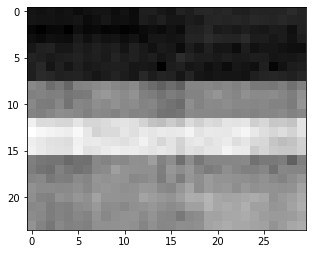

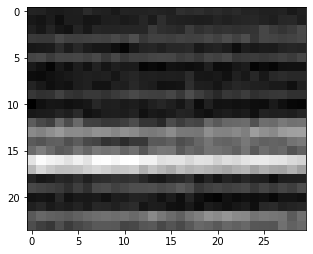

[2701/17000] loss_d: -0.412, loss_g: 1.225
[2702/17000] loss_d: -0.450, loss_g: 1.336
[2703/17000] loss_d: -0.446, loss_g: 1.326
[2704/17000] loss_d: -0.450, loss_g: 1.265
[2705/17000] loss_d: -0.403, loss_g: 1.255
[2706/17000] loss_d: -0.429, loss_g: 1.276
[2707/17000] loss_d: -0.400, loss_g: 1.186
[2708/17000] loss_d: -0.415, loss_g: 1.201
[2709/17000] loss_d: -0.436, loss_g: 1.284
[2710/17000] loss_d: -0.421, loss_g: 1.247
[2711/17000] loss_d: -0.429, loss_g: 1.287
[2712/17000] loss_d: -0.393, loss_g: 1.281
[2713/17000] loss_d: -0.415, loss_g: 1.194
[2714/17000] loss_d: -0.438, loss_g: 1.326
[2715/17000] loss_d: -0.441, loss_g: 1.162
[2716/17000] loss_d: -0.423, loss_g: 1.215
[2717/17000] loss_d: -0.414, loss_g: 1.170
[2718/17000] loss_d: -0.443, loss_g: 1.197
[2719/17000] loss_d: -0.427, loss_g: 1.152
[2720/17000] loss_d: -0.454, loss_g: 1.409
[2721/17000] loss_d: -0.442, loss_g: 1.188
[2722/17000] loss_d: -0.422, loss_g: 1.302
[2723/17000] loss_d: -0.426, loss_g: 1.217
[2724/17000

<Figure size 432x288 with 0 Axes>

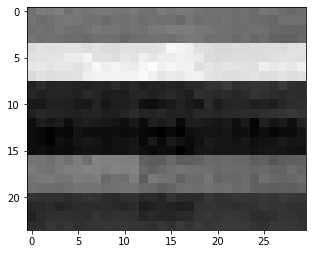

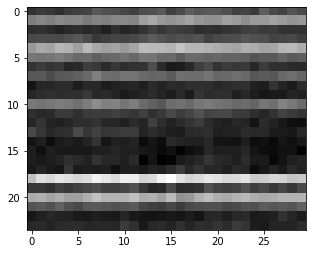

[2751/17000] loss_d: -0.478, loss_g: 1.457
[2752/17000] loss_d: -0.429, loss_g: 1.358
[2753/17000] loss_d: -0.380, loss_g: 1.302
[2754/17000] loss_d: -0.444, loss_g: 1.452
[2755/17000] loss_d: -0.438, loss_g: 1.381
[2756/17000] loss_d: -0.423, loss_g: 1.356
[2757/17000] loss_d: -0.432, loss_g: 1.410
[2758/17000] loss_d: -0.391, loss_g: 1.378
[2759/17000] loss_d: -0.438, loss_g: 1.336
[2760/17000] loss_d: -0.417, loss_g: 1.179
[2761/17000] loss_d: -0.394, loss_g: 1.348
[2762/17000] loss_d: -0.409, loss_g: 1.461
[2763/17000] loss_d: -0.425, loss_g: 1.420
[2764/17000] loss_d: -0.424, loss_g: 1.349
[2765/17000] loss_d: -0.411, loss_g: 1.330
[2766/17000] loss_d: -0.435, loss_g: 1.294
[2767/17000] loss_d: -0.420, loss_g: 1.440
[2768/17000] loss_d: -0.413, loss_g: 1.301
[2769/17000] loss_d: -0.425, loss_g: 1.380
[2770/17000] loss_d: -0.429, loss_g: 1.475
[2771/17000] loss_d: -0.405, loss_g: 1.488
[2772/17000] loss_d: -0.417, loss_g: 1.420
[2773/17000] loss_d: -0.425, loss_g: 1.353
[2774/17000

<Figure size 432x288 with 0 Axes>

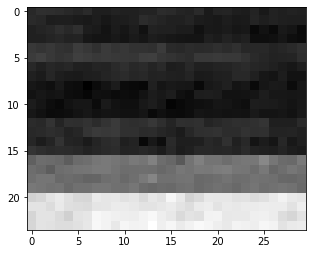

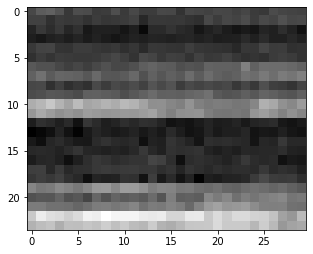

[2801/17000] loss_d: -0.396, loss_g: 1.227
[2802/17000] loss_d: -0.431, loss_g: 1.208
[2803/17000] loss_d: -0.402, loss_g: 1.236
[2804/17000] loss_d: -0.413, loss_g: 1.242
[2805/17000] loss_d: -0.413, loss_g: 1.245
[2806/17000] loss_d: -0.400, loss_g: 1.304
[2807/17000] loss_d: -0.433, loss_g: 1.193
[2808/17000] loss_d: -0.385, loss_g: 1.313
[2809/17000] loss_d: -0.400, loss_g: 1.338
[2810/17000] loss_d: -0.421, loss_g: 1.415
[2811/17000] loss_d: -0.424, loss_g: 1.195
[2812/17000] loss_d: -0.405, loss_g: 1.278
[2813/17000] loss_d: -0.454, loss_g: 1.311
[2814/17000] loss_d: -0.414, loss_g: 1.227
[2815/17000] loss_d: -0.428, loss_g: 1.236
[2816/17000] loss_d: -0.397, loss_g: 1.311
[2817/17000] loss_d: -0.380, loss_g: 1.274
[2818/17000] loss_d: -0.426, loss_g: 1.241
[2819/17000] loss_d: -0.441, loss_g: 1.117
[2820/17000] loss_d: -0.399, loss_g: 1.339
[2821/17000] loss_d: -0.445, loss_g: 1.253
[2822/17000] loss_d: -0.454, loss_g: 1.307
[2823/17000] loss_d: -0.436, loss_g: 1.331
[2824/17000

<Figure size 432x288 with 0 Axes>

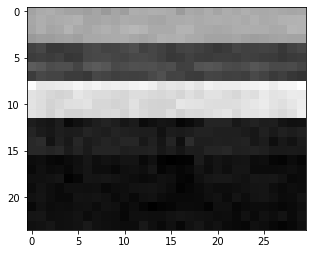

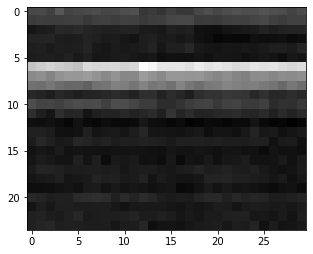

[2851/17000] loss_d: -0.397, loss_g: 1.320
[2852/17000] loss_d: -0.381, loss_g: 1.187
[2853/17000] loss_d: -0.405, loss_g: 1.273
[2854/17000] loss_d: -0.412, loss_g: 1.267
[2855/17000] loss_d: -0.426, loss_g: 1.260
[2856/17000] loss_d: -0.401, loss_g: 1.201
[2857/17000] loss_d: -0.439, loss_g: 1.267
[2858/17000] loss_d: -0.425, loss_g: 1.312
[2859/17000] loss_d: -0.379, loss_g: 1.372
[2860/17000] loss_d: -0.433, loss_g: 1.268
[2861/17000] loss_d: -0.410, loss_g: 1.477
[2862/17000] loss_d: -0.437, loss_g: 1.170
[2863/17000] loss_d: -0.430, loss_g: 1.366
[2864/17000] loss_d: -0.448, loss_g: 1.361
[2865/17000] loss_d: -0.414, loss_g: 1.429
[2866/17000] loss_d: -0.452, loss_g: 1.225
[2867/17000] loss_d: -0.428, loss_g: 1.244
[2868/17000] loss_d: -0.448, loss_g: 1.293
[2869/17000] loss_d: -0.416, loss_g: 1.178
[2870/17000] loss_d: -0.414, loss_g: 1.360
[2871/17000] loss_d: -0.398, loss_g: 1.413
[2872/17000] loss_d: -0.429, loss_g: 1.248
[2873/17000] loss_d: -0.420, loss_g: 1.210
[2874/17000

<Figure size 432x288 with 0 Axes>

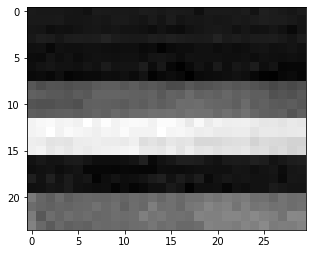

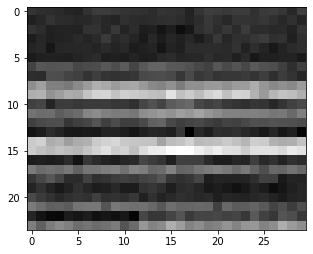

[2901/17000] loss_d: -0.409, loss_g: 1.330
[2902/17000] loss_d: -0.385, loss_g: 1.339
[2903/17000] loss_d: -0.420, loss_g: 1.350
[2904/17000] loss_d: -0.394, loss_g: 1.265
[2905/17000] loss_d: -0.424, loss_g: 1.265
[2906/17000] loss_d: -0.423, loss_g: 1.291
[2907/17000] loss_d: -0.456, loss_g: 1.312
[2908/17000] loss_d: -0.415, loss_g: 1.376
[2909/17000] loss_d: -0.424, loss_g: 1.335
[2910/17000] loss_d: -0.425, loss_g: 1.402
[2911/17000] loss_d: -0.391, loss_g: 1.365
[2912/17000] loss_d: -0.403, loss_g: 1.464
[2913/17000] loss_d: -0.434, loss_g: 1.340
[2914/17000] loss_d: -0.395, loss_g: 1.370
[2915/17000] loss_d: -0.398, loss_g: 1.312
[2916/17000] loss_d: -0.413, loss_g: 1.260
[2917/17000] loss_d: -0.394, loss_g: 1.283
[2918/17000] loss_d: -0.447, loss_g: 1.365
[2919/17000] loss_d: -0.410, loss_g: 1.342
[2920/17000] loss_d: -0.387, loss_g: 1.259
[2921/17000] loss_d: -0.405, loss_g: 1.141
[2922/17000] loss_d: -0.441, loss_g: 1.131
[2923/17000] loss_d: -0.444, loss_g: 1.159
[2924/17000

<Figure size 432x288 with 0 Axes>

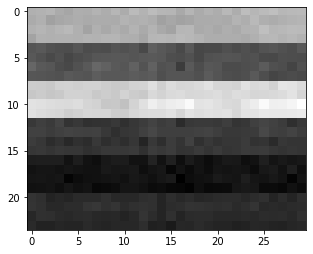

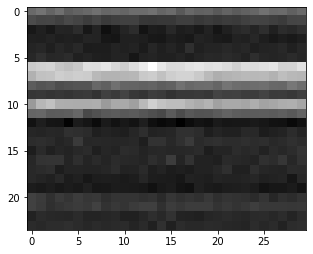

[2951/17000] loss_d: -0.376, loss_g: 1.274
[2952/17000] loss_d: -0.441, loss_g: 1.177
[2953/17000] loss_d: -0.421, loss_g: 1.260
[2954/17000] loss_d: -0.418, loss_g: 1.359
[2955/17000] loss_d: -0.382, loss_g: 1.322
[2956/17000] loss_d: -0.428, loss_g: 1.381
[2957/17000] loss_d: -0.411, loss_g: 1.300
[2958/17000] loss_d: -0.398, loss_g: 1.390
[2959/17000] loss_d: -0.420, loss_g: 1.399
[2960/17000] loss_d: -0.400, loss_g: 1.388
[2961/17000] loss_d: -0.422, loss_g: 1.307
[2962/17000] loss_d: -0.413, loss_g: 1.399
[2963/17000] loss_d: -0.407, loss_g: 1.307
[2964/17000] loss_d: -0.411, loss_g: 1.312
[2965/17000] loss_d: -0.404, loss_g: 1.338
[2966/17000] loss_d: -0.455, loss_g: 1.413
[2967/17000] loss_d: -0.408, loss_g: 1.401
[2968/17000] loss_d: -0.441, loss_g: 1.368
[2969/17000] loss_d: -0.446, loss_g: 1.454
[2970/17000] loss_d: -0.392, loss_g: 1.475
[2971/17000] loss_d: -0.432, loss_g: 1.308
[2972/17000] loss_d: -0.419, loss_g: 1.308
[2973/17000] loss_d: -0.436, loss_g: 1.349
[2974/17000

<Figure size 432x288 with 0 Axes>

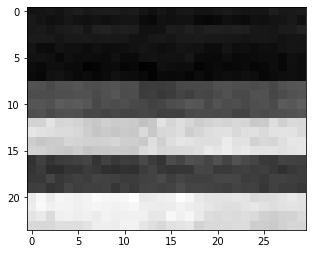

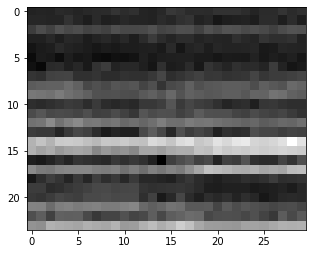

[3001/17000] loss_d: -0.386, loss_g: 1.467
[3002/17000] loss_d: -0.408, loss_g: 1.407
[3003/17000] loss_d: -0.405, loss_g: 1.589
[3004/17000] loss_d: -0.422, loss_g: 1.534
[3005/17000] loss_d: -0.409, loss_g: 1.378
[3006/17000] loss_d: -0.452, loss_g: 1.393
[3007/17000] loss_d: -0.411, loss_g: 1.404
[3008/17000] loss_d: -0.403, loss_g: 1.454
[3009/17000] loss_d: -0.430, loss_g: 1.403
[3010/17000] loss_d: -0.454, loss_g: 1.346
[3011/17000] loss_d: -0.438, loss_g: 1.524
[3012/17000] loss_d: -0.446, loss_g: 1.446
[3013/17000] loss_d: -0.382, loss_g: 1.446
[3014/17000] loss_d: -0.408, loss_g: 1.487
[3015/17000] loss_d: -0.441, loss_g: 1.559
[3016/17000] loss_d: -0.421, loss_g: 1.294
[3017/17000] loss_d: -0.431, loss_g: 1.447
[3018/17000] loss_d: -0.417, loss_g: 1.323
[3019/17000] loss_d: -0.402, loss_g: 1.407
[3020/17000] loss_d: -0.462, loss_g: 1.369
[3021/17000] loss_d: -0.429, loss_g: 1.327
[3022/17000] loss_d: -0.414, loss_g: 1.215
[3023/17000] loss_d: -0.451, loss_g: 1.355
[3024/17000

<Figure size 432x288 with 0 Axes>

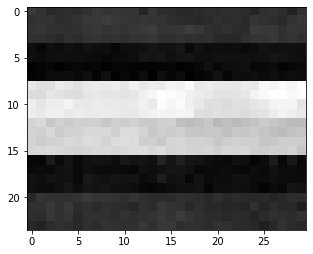

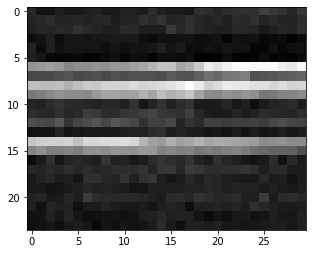

[3051/17000] loss_d: -0.394, loss_g: 1.399
[3052/17000] loss_d: -0.388, loss_g: 1.435
[3053/17000] loss_d: -0.406, loss_g: 1.337
[3054/17000] loss_d: -0.406, loss_g: 1.478
[3055/17000] loss_d: -0.448, loss_g: 1.408
[3056/17000] loss_d: -0.416, loss_g: 1.413
[3057/17000] loss_d: -0.402, loss_g: 1.268
[3058/17000] loss_d: -0.419, loss_g: 1.349
[3059/17000] loss_d: -0.442, loss_g: 1.296
[3060/17000] loss_d: -0.399, loss_g: 1.367
[3061/17000] loss_d: -0.446, loss_g: 1.338
[3062/17000] loss_d: -0.417, loss_g: 1.376
[3063/17000] loss_d: -0.401, loss_g: 1.358
[3064/17000] loss_d: -0.439, loss_g: 1.328
[3065/17000] loss_d: -0.440, loss_g: 1.382
[3066/17000] loss_d: -0.454, loss_g: 1.389
[3067/17000] loss_d: -0.416, loss_g: 1.362
[3068/17000] loss_d: -0.403, loss_g: 1.318
[3069/17000] loss_d: -0.387, loss_g: 1.352
[3070/17000] loss_d: -0.415, loss_g: 1.266
[3071/17000] loss_d: -0.452, loss_g: 1.323
[3072/17000] loss_d: -0.453, loss_g: 1.380
[3073/17000] loss_d: -0.382, loss_g: 1.438
[3074/17000

<Figure size 432x288 with 0 Axes>

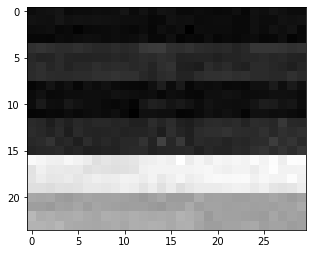

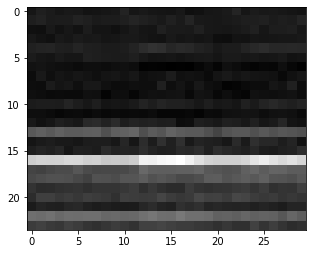

[3101/17000] loss_d: -0.423, loss_g: 1.515
[3102/17000] loss_d: -0.422, loss_g: 1.418
[3103/17000] loss_d: -0.382, loss_g: 1.376
[3104/17000] loss_d: -0.411, loss_g: 1.372
[3105/17000] loss_d: -0.395, loss_g: 1.335
[3106/17000] loss_d: -0.383, loss_g: 1.595
[3107/17000] loss_d: -0.411, loss_g: 1.402
[3108/17000] loss_d: -0.437, loss_g: 1.499
[3109/17000] loss_d: -0.410, loss_g: 1.381
[3110/17000] loss_d: -0.416, loss_g: 1.324
[3111/17000] loss_d: -0.416, loss_g: 1.247
[3112/17000] loss_d: -0.414, loss_g: 1.301
[3113/17000] loss_d: -0.420, loss_g: 1.391
[3114/17000] loss_d: -0.402, loss_g: 1.410
[3115/17000] loss_d: -0.436, loss_g: 1.431
[3116/17000] loss_d: -0.403, loss_g: 1.460
[3117/17000] loss_d: -0.410, loss_g: 1.457
[3118/17000] loss_d: -0.421, loss_g: 1.414
[3119/17000] loss_d: -0.437, loss_g: 1.335
[3120/17000] loss_d: -0.394, loss_g: 1.232
[3121/17000] loss_d: -0.397, loss_g: 1.347
[3122/17000] loss_d: -0.418, loss_g: 1.281
[3123/17000] loss_d: -0.412, loss_g: 1.290
[3124/17000

<Figure size 432x288 with 0 Axes>

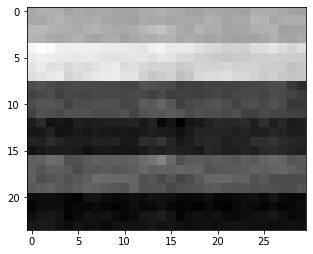

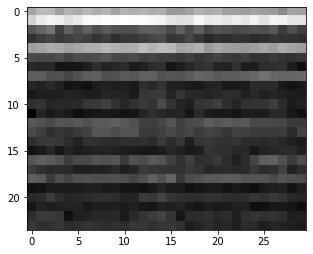

[3151/17000] loss_d: -0.415, loss_g: 1.403
[3152/17000] loss_d: -0.439, loss_g: 1.367
[3153/17000] loss_d: -0.413, loss_g: 1.370
[3154/17000] loss_d: -0.414, loss_g: 1.421
[3155/17000] loss_d: -0.387, loss_g: 1.353
[3156/17000] loss_d: -0.412, loss_g: 1.289
[3157/17000] loss_d: -0.444, loss_g: 1.330
[3158/17000] loss_d: -0.401, loss_g: 1.323
[3159/17000] loss_d: -0.446, loss_g: 1.426
[3160/17000] loss_d: -0.418, loss_g: 1.355
[3161/17000] loss_d: -0.458, loss_g: 1.420
[3162/17000] loss_d: -0.445, loss_g: 1.517
[3163/17000] loss_d: -0.404, loss_g: 1.485
[3164/17000] loss_d: -0.433, loss_g: 1.430
[3165/17000] loss_d: -0.421, loss_g: 1.346
[3166/17000] loss_d: -0.422, loss_g: 1.343
[3167/17000] loss_d: -0.424, loss_g: 1.331
[3168/17000] loss_d: -0.432, loss_g: 1.461
[3169/17000] loss_d: -0.401, loss_g: 1.469
[3170/17000] loss_d: -0.421, loss_g: 1.436
[3171/17000] loss_d: -0.440, loss_g: 1.394
[3172/17000] loss_d: -0.407, loss_g: 1.364
[3173/17000] loss_d: -0.432, loss_g: 1.425
[3174/17000

<Figure size 432x288 with 0 Axes>

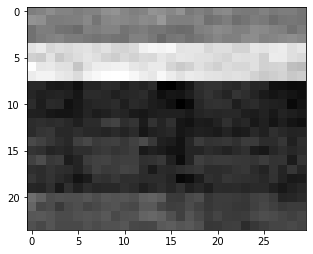

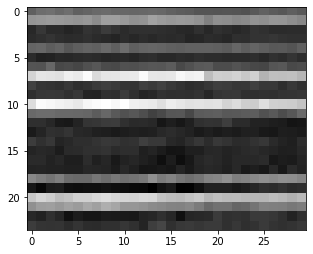

[3201/17000] loss_d: -0.417, loss_g: 1.401
[3202/17000] loss_d: -0.419, loss_g: 1.226
[3203/17000] loss_d: -0.463, loss_g: 1.279
[3204/17000] loss_d: -0.423, loss_g: 1.285
[3205/17000] loss_d: -0.416, loss_g: 1.300
[3206/17000] loss_d: -0.394, loss_g: 1.356
[3207/17000] loss_d: -0.428, loss_g: 1.390
[3208/17000] loss_d: -0.367, loss_g: 1.487
[3209/17000] loss_d: -0.421, loss_g: 1.311
[3210/17000] loss_d: -0.407, loss_g: 1.423
[3211/17000] loss_d: -0.440, loss_g: 1.459
[3212/17000] loss_d: -0.397, loss_g: 1.467
[3213/17000] loss_d: -0.418, loss_g: 1.411
[3214/17000] loss_d: -0.447, loss_g: 1.442
[3215/17000] loss_d: -0.421, loss_g: 1.207
[3216/17000] loss_d: -0.415, loss_g: 1.392
[3217/17000] loss_d: -0.373, loss_g: 1.404
[3218/17000] loss_d: -0.419, loss_g: 1.280
[3219/17000] loss_d: -0.420, loss_g: 1.234
[3220/17000] loss_d: -0.422, loss_g: 1.394
[3221/17000] loss_d: -0.429, loss_g: 1.267
[3222/17000] loss_d: -0.443, loss_g: 1.412
[3223/17000] loss_d: -0.415, loss_g: 1.270
[3224/17000

<Figure size 432x288 with 0 Axes>

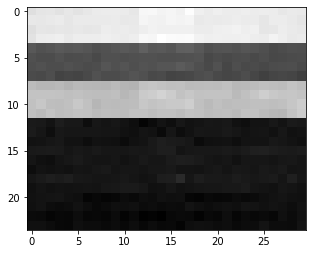

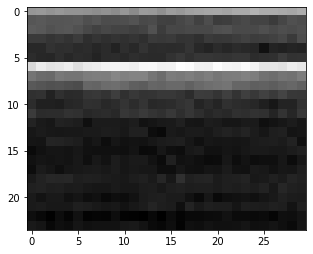

[3251/17000] loss_d: -0.417, loss_g: 1.348
[3252/17000] loss_d: -0.398, loss_g: 1.230
[3253/17000] loss_d: -0.454, loss_g: 1.311
[3254/17000] loss_d: -0.410, loss_g: 1.385
[3255/17000] loss_d: -0.402, loss_g: 1.242
[3256/17000] loss_d: -0.432, loss_g: 1.395
[3257/17000] loss_d: -0.430, loss_g: 1.382
[3258/17000] loss_d: -0.404, loss_g: 1.257
[3259/17000] loss_d: -0.393, loss_g: 1.416
[3260/17000] loss_d: -0.411, loss_g: 1.243
[3261/17000] loss_d: -0.411, loss_g: 1.289
[3262/17000] loss_d: -0.432, loss_g: 1.382
[3263/17000] loss_d: -0.429, loss_g: 1.322
[3264/17000] loss_d: -0.410, loss_g: 1.327
[3265/17000] loss_d: -0.384, loss_g: 1.406
[3266/17000] loss_d: -0.409, loss_g: 1.377
[3267/17000] loss_d: -0.399, loss_g: 1.442
[3268/17000] loss_d: -0.443, loss_g: 1.430
[3269/17000] loss_d: -0.403, loss_g: 1.296
[3270/17000] loss_d: -0.393, loss_g: 1.399
[3271/17000] loss_d: -0.404, loss_g: 1.388
[3272/17000] loss_d: -0.401, loss_g: 1.419
[3273/17000] loss_d: -0.412, loss_g: 1.450
[3274/17000

<Figure size 432x288 with 0 Axes>

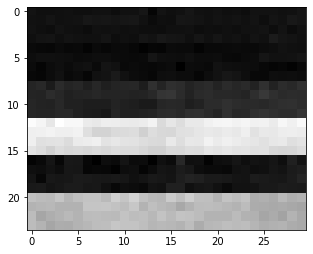

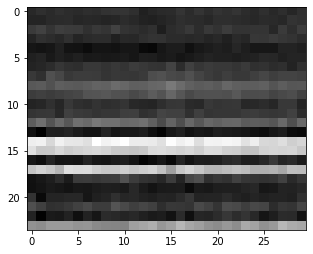

[3301/17000] loss_d: -0.453, loss_g: 1.458
[3302/17000] loss_d: -0.409, loss_g: 1.407
[3303/17000] loss_d: -0.435, loss_g: 1.556
[3304/17000] loss_d: -0.434, loss_g: 1.345
[3305/17000] loss_d: -0.420, loss_g: 1.249
[3306/17000] loss_d: -0.418, loss_g: 1.360
[3307/17000] loss_d: -0.418, loss_g: 1.361
[3308/17000] loss_d: -0.445, loss_g: 1.481
[3309/17000] loss_d: -0.423, loss_g: 1.527
[3310/17000] loss_d: -0.411, loss_g: 1.524
[3311/17000] loss_d: -0.390, loss_g: 1.429
[3312/17000] loss_d: -0.441, loss_g: 1.421
[3313/17000] loss_d: -0.391, loss_g: 1.379
[3314/17000] loss_d: -0.421, loss_g: 1.328
[3315/17000] loss_d: -0.428, loss_g: 1.331
[3316/17000] loss_d: -0.415, loss_g: 1.349
[3317/17000] loss_d: -0.439, loss_g: 1.326
[3318/17000] loss_d: -0.442, loss_g: 1.336
[3319/17000] loss_d: -0.424, loss_g: 1.394
[3320/17000] loss_d: -0.423, loss_g: 1.412
[3321/17000] loss_d: -0.416, loss_g: 1.307
[3322/17000] loss_d: -0.388, loss_g: 1.393
[3323/17000] loss_d: -0.413, loss_g: 1.362
[3324/17000

<Figure size 432x288 with 0 Axes>

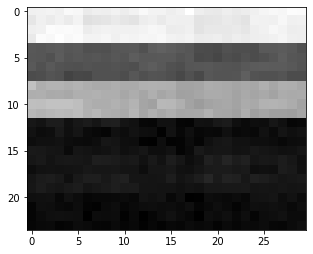

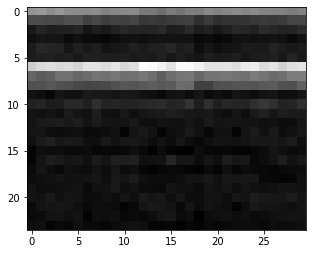

[3351/17000] loss_d: -0.466, loss_g: 1.343
[3352/17000] loss_d: -0.382, loss_g: 1.355
[3353/17000] loss_d: -0.417, loss_g: 1.372
[3354/17000] loss_d: -0.388, loss_g: 1.323
[3355/17000] loss_d: -0.403, loss_g: 1.399
[3356/17000] loss_d: -0.419, loss_g: 1.350
[3357/17000] loss_d: -0.406, loss_g: 1.288
[3358/17000] loss_d: -0.402, loss_g: 1.339
[3359/17000] loss_d: -0.392, loss_g: 1.327
[3360/17000] loss_d: -0.425, loss_g: 1.288
[3361/17000] loss_d: -0.393, loss_g: 1.358
[3362/17000] loss_d: -0.435, loss_g: 1.342
[3363/17000] loss_d: -0.405, loss_g: 1.265
[3364/17000] loss_d: -0.408, loss_g: 1.265
[3365/17000] loss_d: -0.428, loss_g: 1.268
[3366/17000] loss_d: -0.408, loss_g: 1.355
[3367/17000] loss_d: -0.404, loss_g: 1.372
[3368/17000] loss_d: -0.406, loss_g: 1.217
[3369/17000] loss_d: -0.420, loss_g: 1.223
[3370/17000] loss_d: -0.468, loss_g: 1.337
[3371/17000] loss_d: -0.433, loss_g: 1.281
[3372/17000] loss_d: -0.398, loss_g: 1.277
[3373/17000] loss_d: -0.373, loss_g: 1.285
[3374/17000

<Figure size 432x288 with 0 Axes>

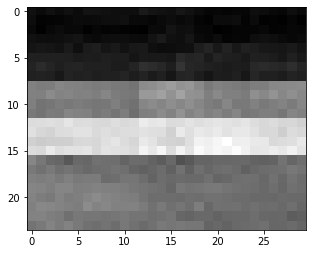

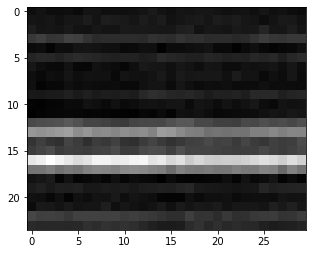

[3401/17000] loss_d: -0.451, loss_g: 1.238
[3402/17000] loss_d: -0.438, loss_g: 1.241
[3403/17000] loss_d: -0.416, loss_g: 1.360
[3404/17000] loss_d: -0.470, loss_g: 1.215
[3405/17000] loss_d: -0.419, loss_g: 1.206
[3406/17000] loss_d: -0.427, loss_g: 1.203
[3407/17000] loss_d: -0.412, loss_g: 1.323
[3408/17000] loss_d: -0.427, loss_g: 1.269
[3409/17000] loss_d: -0.424, loss_g: 1.317
[3410/17000] loss_d: -0.393, loss_g: 1.363
[3411/17000] loss_d: -0.420, loss_g: 1.380
[3412/17000] loss_d: -0.398, loss_g: 1.342
[3413/17000] loss_d: -0.411, loss_g: 1.203
[3414/17000] loss_d: -0.421, loss_g: 1.308
[3415/17000] loss_d: -0.411, loss_g: 1.142
[3416/17000] loss_d: -0.440, loss_g: 1.372
[3417/17000] loss_d: -0.404, loss_g: 1.439
[3418/17000] loss_d: -0.413, loss_g: 1.356
[3419/17000] loss_d: -0.413, loss_g: 1.319
[3420/17000] loss_d: -0.394, loss_g: 1.384
[3421/17000] loss_d: -0.437, loss_g: 1.319
[3422/17000] loss_d: -0.417, loss_g: 1.255
[3423/17000] loss_d: -0.429, loss_g: 1.438
[3424/17000

<Figure size 432x288 with 0 Axes>

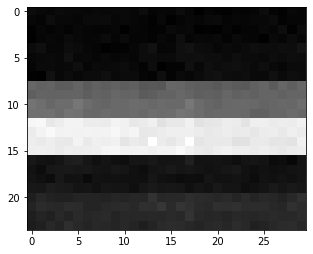

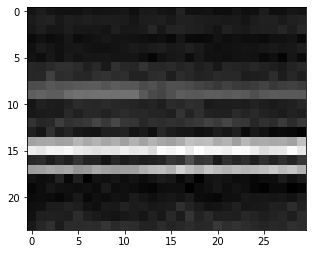

[3451/17000] loss_d: -0.419, loss_g: 1.147
[3452/17000] loss_d: -0.398, loss_g: 1.449
[3453/17000] loss_d: -0.416, loss_g: 1.185
[3454/17000] loss_d: -0.403, loss_g: 1.205
[3455/17000] loss_d: -0.410, loss_g: 1.232
[3456/17000] loss_d: -0.394, loss_g: 1.285
[3457/17000] loss_d: -0.391, loss_g: 1.190
[3458/17000] loss_d: -0.429, loss_g: 1.216
[3459/17000] loss_d: -0.436, loss_g: 1.193
[3460/17000] loss_d: -0.405, loss_g: 1.209
[3461/17000] loss_d: -0.435, loss_g: 1.163
[3462/17000] loss_d: -0.415, loss_g: 1.197
[3463/17000] loss_d: -0.407, loss_g: 1.262
[3464/17000] loss_d: -0.436, loss_g: 1.290
[3465/17000] loss_d: -0.369, loss_g: 1.213
[3466/17000] loss_d: -0.393, loss_g: 1.217
[3467/17000] loss_d: -0.435, loss_g: 1.295
[3468/17000] loss_d: -0.417, loss_g: 1.294
[3469/17000] loss_d: -0.396, loss_g: 1.240
[3470/17000] loss_d: -0.453, loss_g: 1.209
[3471/17000] loss_d: -0.447, loss_g: 1.212
[3472/17000] loss_d: -0.421, loss_g: 1.146
[3473/17000] loss_d: -0.464, loss_g: 1.346
[3474/17000

<Figure size 432x288 with 0 Axes>

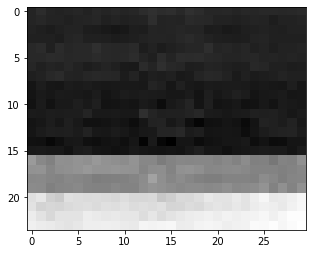

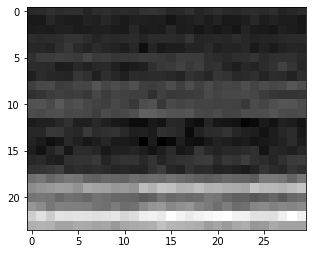

[3501/17000] loss_d: -0.431, loss_g: 1.340
[3502/17000] loss_d: -0.435, loss_g: 1.386
[3503/17000] loss_d: -0.362, loss_g: 1.414
[3504/17000] loss_d: -0.406, loss_g: 1.366
[3505/17000] loss_d: -0.410, loss_g: 1.295
[3506/17000] loss_d: -0.438, loss_g: 1.292
[3507/17000] loss_d: -0.425, loss_g: 1.426
[3508/17000] loss_d: -0.378, loss_g: 1.371
[3509/17000] loss_d: -0.392, loss_g: 1.342
[3510/17000] loss_d: -0.413, loss_g: 1.344
[3511/17000] loss_d: -0.392, loss_g: 1.371
[3512/17000] loss_d: -0.419, loss_g: 1.289
[3513/17000] loss_d: -0.407, loss_g: 1.274
[3514/17000] loss_d: -0.411, loss_g: 1.318
[3515/17000] loss_d: -0.446, loss_g: 1.385
[3516/17000] loss_d: -0.362, loss_g: 1.402
[3517/17000] loss_d: -0.437, loss_g: 1.332
[3518/17000] loss_d: -0.415, loss_g: 1.417
[3519/17000] loss_d: -0.399, loss_g: 1.297
[3520/17000] loss_d: -0.417, loss_g: 1.254
[3521/17000] loss_d: -0.406, loss_g: 1.173
[3522/17000] loss_d: -0.377, loss_g: 1.239
[3523/17000] loss_d: -0.434, loss_g: 1.364
[3524/17000

<Figure size 432x288 with 0 Axes>

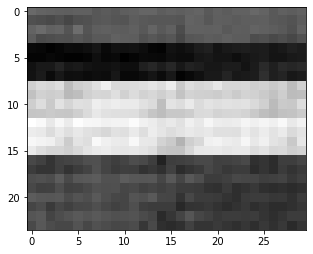

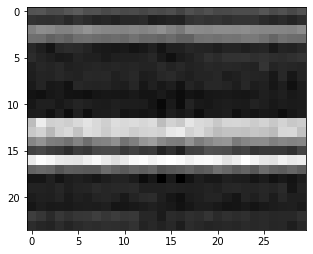

[3551/17000] loss_d: -0.405, loss_g: 1.298
[3552/17000] loss_d: -0.406, loss_g: 1.266
[3553/17000] loss_d: -0.413, loss_g: 1.255
[3554/17000] loss_d: -0.431, loss_g: 1.232
[3555/17000] loss_d: -0.421, loss_g: 1.266
[3556/17000] loss_d: -0.421, loss_g: 1.202
[3557/17000] loss_d: -0.400, loss_g: 1.285
[3558/17000] loss_d: -0.409, loss_g: 1.183
[3559/17000] loss_d: -0.432, loss_g: 1.179
[3560/17000] loss_d: -0.430, loss_g: 1.169
[3561/17000] loss_d: -0.405, loss_g: 1.193
[3562/17000] loss_d: -0.404, loss_g: 1.268
[3563/17000] loss_d: -0.438, loss_g: 1.275
[3564/17000] loss_d: -0.436, loss_g: 1.180
[3565/17000] loss_d: -0.397, loss_g: 1.343
[3566/17000] loss_d: -0.399, loss_g: 1.263
[3567/17000] loss_d: -0.381, loss_g: 1.316
[3568/17000] loss_d: -0.433, loss_g: 1.250
[3569/17000] loss_d: -0.410, loss_g: 1.241
[3570/17000] loss_d: -0.417, loss_g: 1.102
[3571/17000] loss_d: -0.427, loss_g: 1.307
[3572/17000] loss_d: -0.406, loss_g: 1.280
[3573/17000] loss_d: -0.408, loss_g: 1.160
[3574/17000

<Figure size 432x288 with 0 Axes>

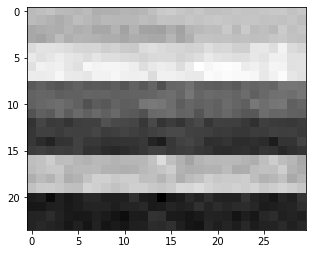

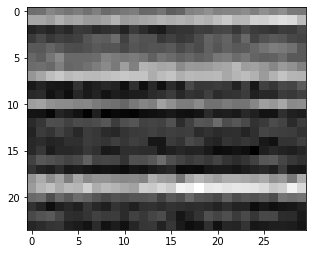

[3601/17000] loss_d: -0.454, loss_g: 1.229
[3602/17000] loss_d: -0.396, loss_g: 1.262
[3603/17000] loss_d: -0.436, loss_g: 1.181
[3604/17000] loss_d: -0.422, loss_g: 1.241
[3605/17000] loss_d: -0.427, loss_g: 1.287
[3606/17000] loss_d: -0.423, loss_g: 1.199
[3607/17000] loss_d: -0.370, loss_g: 1.174
[3608/17000] loss_d: -0.411, loss_g: 1.149
[3609/17000] loss_d: -0.396, loss_g: 1.136
[3610/17000] loss_d: -0.384, loss_g: 1.157
[3611/17000] loss_d: -0.388, loss_g: 1.203
[3612/17000] loss_d: -0.428, loss_g: 1.198
[3613/17000] loss_d: -0.403, loss_g: 1.253
[3614/17000] loss_d: -0.427, loss_g: 1.349
[3615/17000] loss_d: -0.394, loss_g: 1.321
[3616/17000] loss_d: -0.402, loss_g: 1.300
[3617/17000] loss_d: -0.429, loss_g: 1.202
[3618/17000] loss_d: -0.412, loss_g: 1.427
[3619/17000] loss_d: -0.396, loss_g: 1.314
[3620/17000] loss_d: -0.421, loss_g: 1.356
[3621/17000] loss_d: -0.393, loss_g: 1.280
[3622/17000] loss_d: -0.410, loss_g: 1.297
[3623/17000] loss_d: -0.411, loss_g: 1.260
[3624/17000

<Figure size 432x288 with 0 Axes>

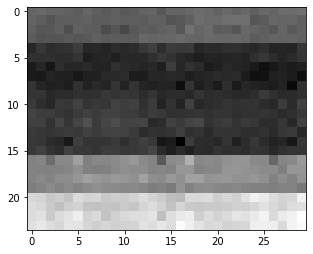

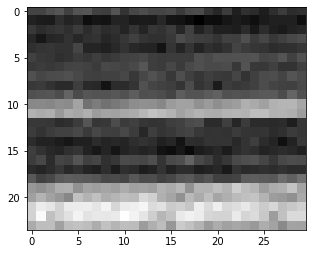

[3651/17000] loss_d: -0.433, loss_g: 1.274
[3652/17000] loss_d: -0.416, loss_g: 1.153
[3653/17000] loss_d: -0.416, loss_g: 1.221
[3654/17000] loss_d: -0.425, loss_g: 1.288
[3655/17000] loss_d: -0.405, loss_g: 1.274
[3656/17000] loss_d: -0.417, loss_g: 1.363
[3657/17000] loss_d: -0.431, loss_g: 1.238
[3658/17000] loss_d: -0.380, loss_g: 1.249
[3659/17000] loss_d: -0.412, loss_g: 1.249
[3660/17000] loss_d: -0.384, loss_g: 1.274
[3661/17000] loss_d: -0.404, loss_g: 1.418
[3662/17000] loss_d: -0.416, loss_g: 1.492
[3663/17000] loss_d: -0.420, loss_g: 1.370
[3664/17000] loss_d: -0.414, loss_g: 1.226
[3665/17000] loss_d: -0.408, loss_g: 1.187
[3666/17000] loss_d: -0.403, loss_g: 1.361
[3667/17000] loss_d: -0.389, loss_g: 1.193
[3668/17000] loss_d: -0.425, loss_g: 1.223
[3669/17000] loss_d: -0.419, loss_g: 1.318
[3670/17000] loss_d: -0.427, loss_g: 1.308
[3671/17000] loss_d: -0.437, loss_g: 1.294
[3672/17000] loss_d: -0.406, loss_g: 1.341
[3673/17000] loss_d: -0.424, loss_g: 1.265
[3674/17000

<Figure size 432x288 with 0 Axes>

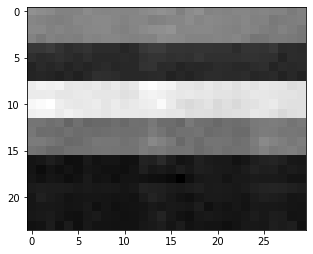

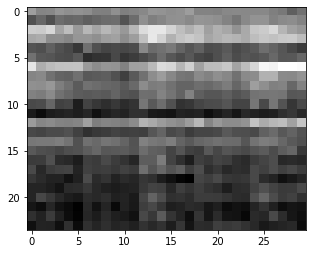

[3701/17000] loss_d: -0.398, loss_g: 1.460
[3702/17000] loss_d: -0.452, loss_g: 1.140
[3703/17000] loss_d: -0.470, loss_g: 1.028
[3704/17000] loss_d: -0.435, loss_g: 1.232
[3705/17000] loss_d: -0.402, loss_g: 1.108
[3706/17000] loss_d: -0.402, loss_g: 1.151
[3707/17000] loss_d: -0.380, loss_g: 1.218
[3708/17000] loss_d: -0.381, loss_g: 1.100
[3709/17000] loss_d: -0.408, loss_g: 1.013
[3710/17000] loss_d: -0.390, loss_g: 1.132
[3711/17000] loss_d: -0.396, loss_g: 1.131
[3712/17000] loss_d: -0.433, loss_g: 1.168
[3713/17000] loss_d: -0.433, loss_g: 1.128
[3714/17000] loss_d: -0.399, loss_g: 1.161
[3715/17000] loss_d: -0.379, loss_g: 1.143
[3716/17000] loss_d: -0.403, loss_g: 1.178
[3717/17000] loss_d: -0.433, loss_g: 1.158
[3718/17000] loss_d: -0.402, loss_g: 1.148
[3719/17000] loss_d: -0.410, loss_g: 1.067
[3720/17000] loss_d: -0.423, loss_g: 1.188
[3721/17000] loss_d: -0.425, loss_g: 1.160
[3722/17000] loss_d: -0.421, loss_g: 1.300
[3723/17000] loss_d: -0.399, loss_g: 1.215
[3724/17000

<Figure size 432x288 with 0 Axes>

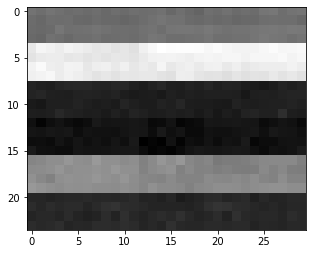

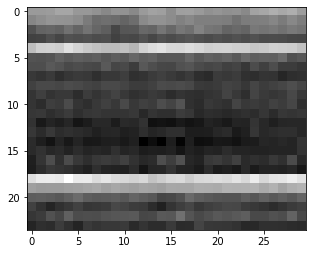

[3751/17000] loss_d: -0.417, loss_g: 1.029
[3752/17000] loss_d: -0.421, loss_g: 1.039
[3753/17000] loss_d: -0.403, loss_g: 1.090
[3754/17000] loss_d: -0.392, loss_g: 1.227
[3755/17000] loss_d: -0.401, loss_g: 1.215
[3756/17000] loss_d: -0.420, loss_g: 1.143
[3757/17000] loss_d: -0.406, loss_g: 1.150
[3758/17000] loss_d: -0.402, loss_g: 1.139
[3759/17000] loss_d: -0.397, loss_g: 1.231
[3760/17000] loss_d: -0.416, loss_g: 1.198
[3761/17000] loss_d: -0.444, loss_g: 1.168
[3762/17000] loss_d: -0.419, loss_g: 1.193
[3763/17000] loss_d: -0.409, loss_g: 1.071
[3764/17000] loss_d: -0.418, loss_g: 1.079
[3765/17000] loss_d: -0.405, loss_g: 1.157
[3766/17000] loss_d: -0.413, loss_g: 1.165
[3767/17000] loss_d: -0.432, loss_g: 1.131
[3768/17000] loss_d: -0.414, loss_g: 1.153
[3769/17000] loss_d: -0.408, loss_g: 1.031
[3770/17000] loss_d: -0.419, loss_g: 1.277
[3771/17000] loss_d: -0.391, loss_g: 1.160
[3772/17000] loss_d: -0.371, loss_g: 1.203
[3773/17000] loss_d: -0.416, loss_g: 1.137
[3774/17000

<Figure size 432x288 with 0 Axes>

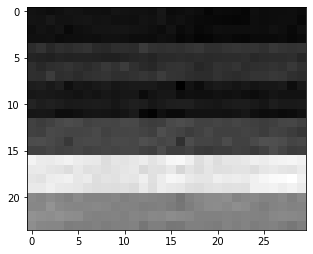

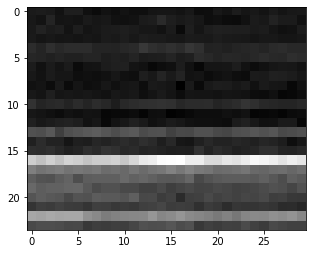

[3801/17000] loss_d: -0.361, loss_g: 1.235
[3802/17000] loss_d: -0.403, loss_g: 1.111
[3803/17000] loss_d: -0.419, loss_g: 1.092
[3804/17000] loss_d: -0.440, loss_g: 1.146
[3805/17000] loss_d: -0.439, loss_g: 1.167
[3806/17000] loss_d: -0.402, loss_g: 1.119
[3807/17000] loss_d: -0.363, loss_g: 1.250
[3808/17000] loss_d: -0.438, loss_g: 1.098
[3809/17000] loss_d: -0.421, loss_g: 1.239
[3810/17000] loss_d: -0.398, loss_g: 1.215
[3811/17000] loss_d: -0.379, loss_g: 1.165
[3812/17000] loss_d: -0.415, loss_g: 1.210
[3813/17000] loss_d: -0.414, loss_g: 1.179
[3814/17000] loss_d: -0.403, loss_g: 1.180
[3815/17000] loss_d: -0.415, loss_g: 1.156
[3816/17000] loss_d: -0.438, loss_g: 1.144
[3817/17000] loss_d: -0.396, loss_g: 1.154
[3818/17000] loss_d: -0.422, loss_g: 1.207
[3819/17000] loss_d: -0.394, loss_g: 1.183
[3820/17000] loss_d: -0.405, loss_g: 1.068
[3821/17000] loss_d: -0.460, loss_g: 1.232
[3822/17000] loss_d: -0.388, loss_g: 1.276
[3823/17000] loss_d: -0.416, loss_g: 1.145
[3824/17000

<Figure size 432x288 with 0 Axes>

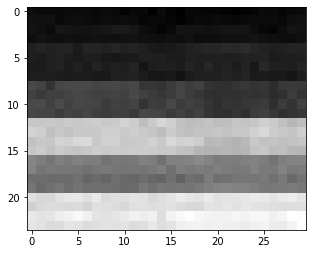

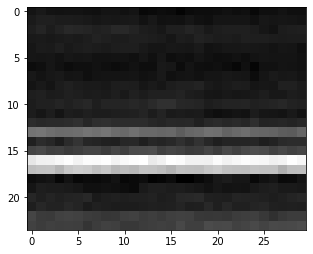

[3851/17000] loss_d: -0.426, loss_g: 1.167
[3852/17000] loss_d: -0.420, loss_g: 1.174
[3853/17000] loss_d: -0.380, loss_g: 1.121
[3854/17000] loss_d: -0.377, loss_g: 1.158
[3855/17000] loss_d: -0.418, loss_g: 1.239
[3856/17000] loss_d: -0.408, loss_g: 1.150
[3857/17000] loss_d: -0.360, loss_g: 1.185
[3858/17000] loss_d: -0.424, loss_g: 1.207
[3859/17000] loss_d: -0.392, loss_g: 1.180
[3860/17000] loss_d: -0.401, loss_g: 1.191
[3861/17000] loss_d: -0.381, loss_g: 1.100
[3862/17000] loss_d: -0.364, loss_g: 1.125
[3863/17000] loss_d: -0.398, loss_g: 1.127
[3864/17000] loss_d: -0.396, loss_g: 1.108
[3865/17000] loss_d: -0.433, loss_g: 1.095
[3866/17000] loss_d: -0.428, loss_g: 1.033
[3867/17000] loss_d: -0.430, loss_g: 1.159
[3868/17000] loss_d: -0.416, loss_g: 1.068
[3869/17000] loss_d: -0.382, loss_g: 1.098
[3870/17000] loss_d: -0.442, loss_g: 1.100
[3871/17000] loss_d: -0.379, loss_g: 1.061
[3872/17000] loss_d: -0.382, loss_g: 1.226
[3873/17000] loss_d: -0.420, loss_g: 1.108
[3874/17000

<Figure size 432x288 with 0 Axes>

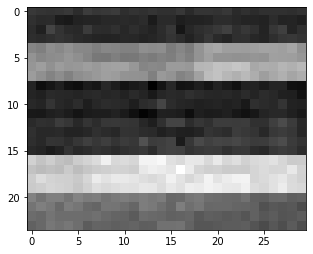

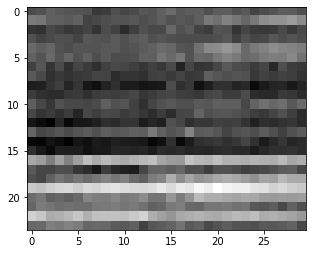

[3901/17000] loss_d: -0.429, loss_g: 1.168
[3902/17000] loss_d: -0.433, loss_g: 1.082
[3903/17000] loss_d: -0.422, loss_g: 1.147
[3904/17000] loss_d: -0.400, loss_g: 1.217
[3905/17000] loss_d: -0.404, loss_g: 1.203
[3906/17000] loss_d: -0.428, loss_g: 1.062
[3907/17000] loss_d: -0.417, loss_g: 1.081
[3908/17000] loss_d: -0.413, loss_g: 1.138
[3909/17000] loss_d: -0.433, loss_g: 1.133
[3910/17000] loss_d: -0.420, loss_g: 1.133
[3911/17000] loss_d: -0.403, loss_g: 1.053
[3912/17000] loss_d: -0.454, loss_g: 1.227
[3913/17000] loss_d: -0.377, loss_g: 1.124
[3914/17000] loss_d: -0.391, loss_g: 1.137
[3915/17000] loss_d: -0.410, loss_g: 1.159
[3916/17000] loss_d: -0.443, loss_g: 1.061
[3917/17000] loss_d: -0.423, loss_g: 1.121
[3918/17000] loss_d: -0.417, loss_g: 1.081
[3919/17000] loss_d: -0.405, loss_g: 1.144
[3920/17000] loss_d: -0.387, loss_g: 1.146
[3921/17000] loss_d: -0.396, loss_g: 1.058
[3922/17000] loss_d: -0.426, loss_g: 1.005
[3923/17000] loss_d: -0.431, loss_g: 1.110
[3924/17000

<Figure size 432x288 with 0 Axes>

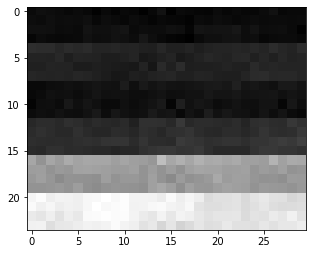

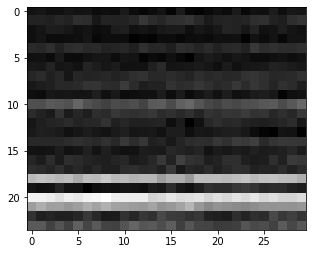

[3951/17000] loss_d: -0.457, loss_g: 1.124
[3952/17000] loss_d: -0.453, loss_g: 1.244
[3953/17000] loss_d: -0.426, loss_g: 1.187
[3954/17000] loss_d: -0.412, loss_g: 1.195
[3955/17000] loss_d: -0.395, loss_g: 1.171
[3956/17000] loss_d: -0.389, loss_g: 1.194
[3957/17000] loss_d: -0.427, loss_g: 1.145
[3958/17000] loss_d: -0.389, loss_g: 1.042
[3959/17000] loss_d: -0.399, loss_g: 1.110
[3960/17000] loss_d: -0.427, loss_g: 1.007
[3961/17000] loss_d: -0.392, loss_g: 1.086
[3962/17000] loss_d: -0.437, loss_g: 1.140
[3963/17000] loss_d: -0.439, loss_g: 1.090
[3964/17000] loss_d: -0.440, loss_g: 1.145
[3965/17000] loss_d: -0.373, loss_g: 1.043
[3966/17000] loss_d: -0.436, loss_g: 1.097
[3967/17000] loss_d: -0.418, loss_g: 1.229
[3968/17000] loss_d: -0.384, loss_g: 1.068
[3969/17000] loss_d: -0.415, loss_g: 1.047
[3970/17000] loss_d: -0.408, loss_g: 0.977
[3971/17000] loss_d: -0.415, loss_g: 1.039
[3972/17000] loss_d: -0.435, loss_g: 1.124
[3973/17000] loss_d: -0.432, loss_g: 1.121
[3974/17000

<Figure size 432x288 with 0 Axes>

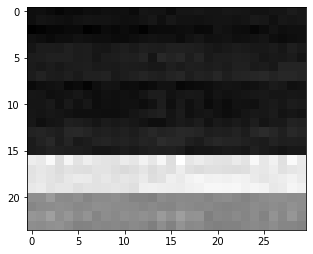

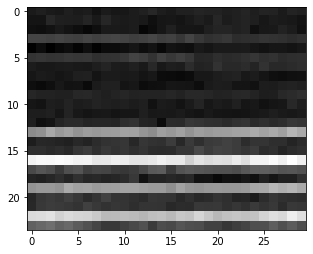

[4001/17000] loss_d: -0.382, loss_g: 0.999
[4002/17000] loss_d: -0.375, loss_g: 1.161
[4003/17000] loss_d: -0.402, loss_g: 1.113
[4004/17000] loss_d: -0.392, loss_g: 1.077
[4005/17000] loss_d: -0.419, loss_g: 1.083
[4006/17000] loss_d: -0.447, loss_g: 1.071
[4007/17000] loss_d: -0.347, loss_g: 1.074
[4008/17000] loss_d: -0.441, loss_g: 1.109
[4009/17000] loss_d: -0.416, loss_g: 1.099
[4010/17000] loss_d: -0.439, loss_g: 1.143
[4011/17000] loss_d: -0.392, loss_g: 1.145
[4012/17000] loss_d: -0.441, loss_g: 1.087
[4013/17000] loss_d: -0.429, loss_g: 1.101
[4014/17000] loss_d: -0.411, loss_g: 1.207
[4015/17000] loss_d: -0.384, loss_g: 1.179
[4016/17000] loss_d: -0.400, loss_g: 1.145
[4017/17000] loss_d: -0.392, loss_g: 1.201
[4018/17000] loss_d: -0.420, loss_g: 1.197
[4019/17000] loss_d: -0.450, loss_g: 1.153
[4020/17000] loss_d: -0.391, loss_g: 1.120
[4021/17000] loss_d: -0.407, loss_g: 1.127
[4022/17000] loss_d: -0.410, loss_g: 1.258
[4023/17000] loss_d: -0.414, loss_g: 1.191
[4024/17000

<Figure size 432x288 with 0 Axes>

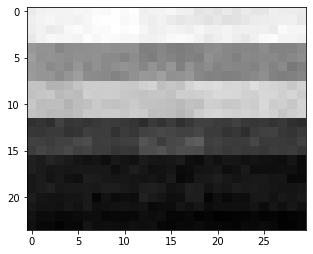

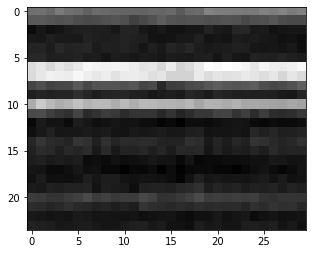

[4051/17000] loss_d: -0.420, loss_g: 1.217
[4052/17000] loss_d: -0.395, loss_g: 1.048
[4053/17000] loss_d: -0.404, loss_g: 1.224
[4054/17000] loss_d: -0.415, loss_g: 1.223
[4055/17000] loss_d: -0.462, loss_g: 1.337
[4056/17000] loss_d: -0.451, loss_g: 1.261
[4057/17000] loss_d: -0.414, loss_g: 1.149
[4058/17000] loss_d: -0.393, loss_g: 1.209
[4059/17000] loss_d: -0.402, loss_g: 1.185
[4060/17000] loss_d: -0.422, loss_g: 1.181
[4061/17000] loss_d: -0.429, loss_g: 1.119
[4062/17000] loss_d: -0.416, loss_g: 1.126
[4063/17000] loss_d: -0.428, loss_g: 1.255
[4064/17000] loss_d: -0.415, loss_g: 1.095
[4065/17000] loss_d: -0.446, loss_g: 1.142
[4066/17000] loss_d: -0.384, loss_g: 1.129
[4067/17000] loss_d: -0.405, loss_g: 1.107
[4068/17000] loss_d: -0.416, loss_g: 1.173
[4069/17000] loss_d: -0.419, loss_g: 1.145
[4070/17000] loss_d: -0.420, loss_g: 1.157
[4071/17000] loss_d: -0.403, loss_g: 1.124
[4072/17000] loss_d: -0.395, loss_g: 1.156
[4073/17000] loss_d: -0.421, loss_g: 1.076
[4074/17000

<Figure size 432x288 with 0 Axes>

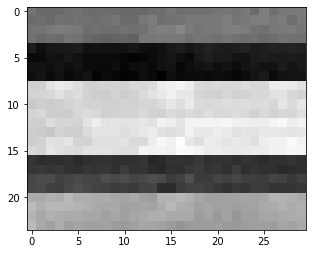

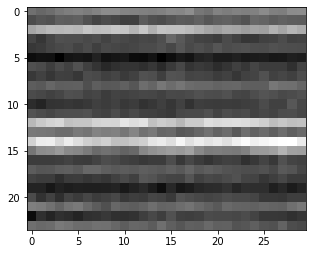

[4101/17000] loss_d: -0.460, loss_g: 1.214
[4102/17000] loss_d: -0.395, loss_g: 1.098
[4103/17000] loss_d: -0.417, loss_g: 1.030
[4104/17000] loss_d: -0.433, loss_g: 1.123
[4105/17000] loss_d: -0.403, loss_g: 1.195
[4106/17000] loss_d: -0.413, loss_g: 1.193
[4107/17000] loss_d: -0.386, loss_g: 1.205
[4108/17000] loss_d: -0.413, loss_g: 1.172
[4109/17000] loss_d: -0.419, loss_g: 1.064
[4110/17000] loss_d: -0.434, loss_g: 1.087
[4111/17000] loss_d: -0.383, loss_g: 1.022
[4112/17000] loss_d: -0.431, loss_g: 1.147
[4113/17000] loss_d: -0.395, loss_g: 1.205
[4114/17000] loss_d: -0.410, loss_g: 1.106
[4115/17000] loss_d: -0.413, loss_g: 1.158
[4116/17000] loss_d: -0.425, loss_g: 1.154
[4117/17000] loss_d: -0.385, loss_g: 1.162
[4118/17000] loss_d: -0.412, loss_g: 0.979
[4119/17000] loss_d: -0.412, loss_g: 1.210
[4120/17000] loss_d: -0.404, loss_g: 1.099
[4121/17000] loss_d: -0.415, loss_g: 1.117
[4122/17000] loss_d: -0.441, loss_g: 1.101
[4123/17000] loss_d: -0.447, loss_g: 1.106
[4124/17000

<Figure size 432x288 with 0 Axes>

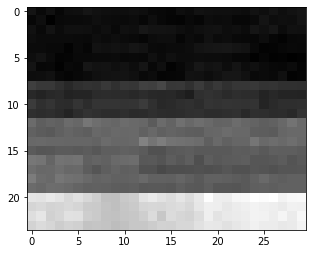

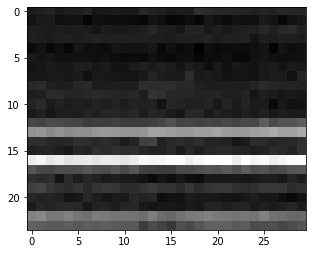

[4151/17000] loss_d: -0.414, loss_g: 1.044
[4152/17000] loss_d: -0.434, loss_g: 1.111
[4153/17000] loss_d: -0.384, loss_g: 1.033
[4154/17000] loss_d: -0.410, loss_g: 1.047
[4155/17000] loss_d: -0.434, loss_g: 1.040
[4156/17000] loss_d: -0.375, loss_g: 1.133
[4157/17000] loss_d: -0.402, loss_g: 1.042
[4158/17000] loss_d: -0.414, loss_g: 0.996
[4159/17000] loss_d: -0.416, loss_g: 1.029
[4160/17000] loss_d: -0.397, loss_g: 1.190
[4161/17000] loss_d: -0.424, loss_g: 1.172
[4162/17000] loss_d: -0.426, loss_g: 1.136
[4163/17000] loss_d: -0.427, loss_g: 1.056
[4164/17000] loss_d: -0.435, loss_g: 1.124
[4165/17000] loss_d: -0.412, loss_g: 1.128
[4166/17000] loss_d: -0.459, loss_g: 1.112
[4167/17000] loss_d: -0.407, loss_g: 1.145
[4168/17000] loss_d: -0.426, loss_g: 1.085
[4169/17000] loss_d: -0.420, loss_g: 1.022
[4170/17000] loss_d: -0.439, loss_g: 1.107
[4171/17000] loss_d: -0.420, loss_g: 1.118
[4172/17000] loss_d: -0.393, loss_g: 1.099
[4173/17000] loss_d: -0.441, loss_g: 1.067
[4174/17000

<Figure size 432x288 with 0 Axes>

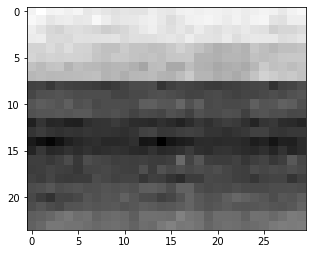

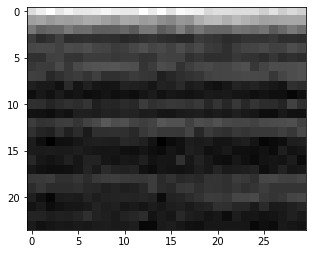

[4201/17000] loss_d: -0.414, loss_g: 1.153
[4202/17000] loss_d: -0.420, loss_g: 1.089
[4203/17000] loss_d: -0.449, loss_g: 1.129
[4204/17000] loss_d: -0.421, loss_g: 1.102
[4205/17000] loss_d: -0.420, loss_g: 0.978
[4206/17000] loss_d: -0.414, loss_g: 1.043
[4207/17000] loss_d: -0.424, loss_g: 0.951
[4208/17000] loss_d: -0.439, loss_g: 1.032
[4209/17000] loss_d: -0.402, loss_g: 1.111
[4210/17000] loss_d: -0.436, loss_g: 0.941
[4211/17000] loss_d: -0.411, loss_g: 1.048
[4212/17000] loss_d: -0.427, loss_g: 1.026
[4213/17000] loss_d: -0.412, loss_g: 0.974
[4214/17000] loss_d: -0.424, loss_g: 1.093
[4215/17000] loss_d: -0.429, loss_g: 1.042
[4216/17000] loss_d: -0.403, loss_g: 1.068
[4217/17000] loss_d: -0.380, loss_g: 1.001
[4218/17000] loss_d: -0.428, loss_g: 1.035
[4219/17000] loss_d: -0.428, loss_g: 0.960
[4220/17000] loss_d: -0.413, loss_g: 1.128
[4221/17000] loss_d: -0.427, loss_g: 0.997
[4222/17000] loss_d: -0.388, loss_g: 1.123
[4223/17000] loss_d: -0.398, loss_g: 1.030
[4224/17000

<Figure size 432x288 with 0 Axes>

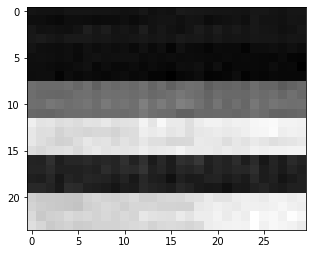

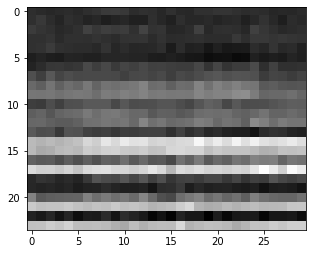

[4251/17000] loss_d: -0.427, loss_g: 0.990
[4252/17000] loss_d: -0.419, loss_g: 1.014
[4253/17000] loss_d: -0.372, loss_g: 1.018
[4254/17000] loss_d: -0.406, loss_g: 0.943
[4255/17000] loss_d: -0.430, loss_g: 1.171
[4256/17000] loss_d: -0.427, loss_g: 0.989
[4257/17000] loss_d: -0.398, loss_g: 1.016
[4258/17000] loss_d: -0.400, loss_g: 1.019
[4259/17000] loss_d: -0.429, loss_g: 1.109
[4260/17000] loss_d: -0.383, loss_g: 1.040
[4261/17000] loss_d: -0.405, loss_g: 1.068
[4262/17000] loss_d: -0.397, loss_g: 1.091
[4263/17000] loss_d: -0.407, loss_g: 1.086
[4264/17000] loss_d: -0.443, loss_g: 1.041
[4265/17000] loss_d: -0.383, loss_g: 1.007
[4266/17000] loss_d: -0.398, loss_g: 1.057
[4267/17000] loss_d: -0.416, loss_g: 1.168
[4268/17000] loss_d: -0.394, loss_g: 1.055
[4269/17000] loss_d: -0.436, loss_g: 0.996
[4270/17000] loss_d: -0.416, loss_g: 1.166
[4271/17000] loss_d: -0.402, loss_g: 1.041
[4272/17000] loss_d: -0.419, loss_g: 1.083
[4273/17000] loss_d: -0.368, loss_g: 1.072
[4274/17000

<Figure size 432x288 with 0 Axes>

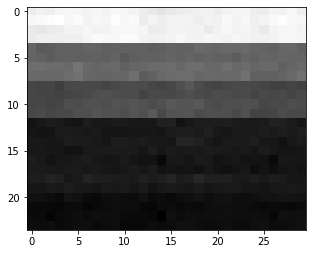

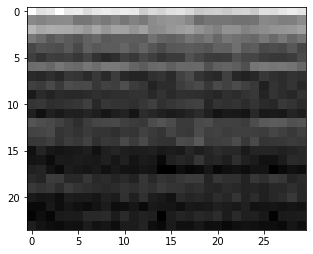

[4301/17000] loss_d: -0.440, loss_g: 1.170
[4302/17000] loss_d: -0.438, loss_g: 1.364
[4303/17000] loss_d: -0.393, loss_g: 1.210
[4304/17000] loss_d: -0.415, loss_g: 1.127
[4305/17000] loss_d: -0.406, loss_g: 1.150
[4306/17000] loss_d: -0.411, loss_g: 1.104
[4307/17000] loss_d: -0.429, loss_g: 1.033
[4308/17000] loss_d: -0.398, loss_g: 1.074
[4309/17000] loss_d: -0.394, loss_g: 1.065
[4310/17000] loss_d: -0.423, loss_g: 1.035
[4311/17000] loss_d: -0.381, loss_g: 1.141
[4312/17000] loss_d: -0.391, loss_g: 1.053
[4313/17000] loss_d: -0.410, loss_g: 1.043
[4314/17000] loss_d: -0.385, loss_g: 1.027
[4315/17000] loss_d: -0.402, loss_g: 1.067
[4316/17000] loss_d: -0.396, loss_g: 1.120
[4317/17000] loss_d: -0.421, loss_g: 1.085
[4318/17000] loss_d: -0.421, loss_g: 1.131
[4319/17000] loss_d: -0.391, loss_g: 1.115
[4320/17000] loss_d: -0.418, loss_g: 1.129
[4321/17000] loss_d: -0.409, loss_g: 1.087
[4322/17000] loss_d: -0.401, loss_g: 1.131
[4323/17000] loss_d: -0.414, loss_g: 1.093
[4324/17000

<Figure size 432x288 with 0 Axes>

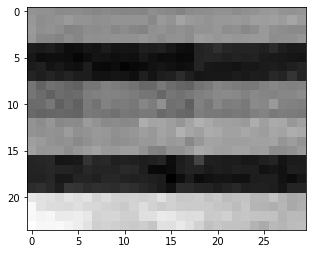

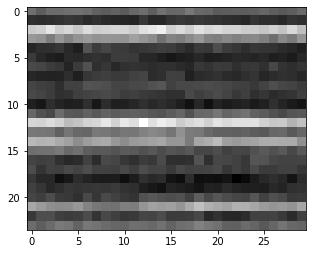

[4351/17000] loss_d: -0.411, loss_g: 1.114
[4352/17000] loss_d: -0.434, loss_g: 0.971
[4353/17000] loss_d: -0.418, loss_g: 1.092
[4354/17000] loss_d: -0.407, loss_g: 1.047
[4355/17000] loss_d: -0.404, loss_g: 1.072
[4356/17000] loss_d: -0.385, loss_g: 1.114
[4357/17000] loss_d: -0.411, loss_g: 1.076
[4358/17000] loss_d: -0.417, loss_g: 1.143
[4359/17000] loss_d: -0.423, loss_g: 1.127
[4360/17000] loss_d: -0.402, loss_g: 1.039
[4361/17000] loss_d: -0.401, loss_g: 1.098
[4362/17000] loss_d: -0.379, loss_g: 1.067
[4363/17000] loss_d: -0.420, loss_g: 1.056
[4364/17000] loss_d: -0.404, loss_g: 1.116
[4365/17000] loss_d: -0.391, loss_g: 1.131
[4366/17000] loss_d: -0.421, loss_g: 1.064
[4367/17000] loss_d: -0.438, loss_g: 1.078
[4368/17000] loss_d: -0.428, loss_g: 1.111
[4369/17000] loss_d: -0.410, loss_g: 1.046
[4370/17000] loss_d: -0.412, loss_g: 1.133
[4371/17000] loss_d: -0.426, loss_g: 1.078
[4372/17000] loss_d: -0.433, loss_g: 1.088
[4373/17000] loss_d: -0.401, loss_g: 1.090
[4374/17000

<Figure size 432x288 with 0 Axes>

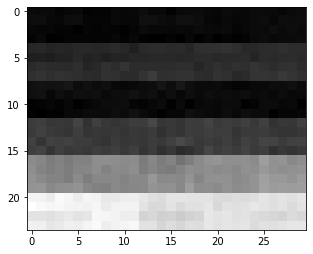

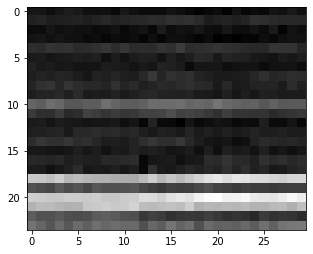

[4401/17000] loss_d: -0.401, loss_g: 1.020
[4402/17000] loss_d: -0.388, loss_g: 1.073
[4403/17000] loss_d: -0.373, loss_g: 1.152
[4404/17000] loss_d: -0.409, loss_g: 1.108
[4405/17000] loss_d: -0.410, loss_g: 1.198
[4406/17000] loss_d: -0.423, loss_g: 1.077
[4407/17000] loss_d: -0.433, loss_g: 1.028
[4408/17000] loss_d: -0.352, loss_g: 0.979
[4409/17000] loss_d: -0.377, loss_g: 0.993
[4410/17000] loss_d: -0.405, loss_g: 1.003
[4411/17000] loss_d: -0.439, loss_g: 1.056
[4412/17000] loss_d: -0.409, loss_g: 1.039
[4413/17000] loss_d: -0.391, loss_g: 1.053
[4414/17000] loss_d: -0.426, loss_g: 1.176
[4415/17000] loss_d: -0.412, loss_g: 1.092
[4416/17000] loss_d: -0.417, loss_g: 1.020
[4417/17000] loss_d: -0.364, loss_g: 1.077
[4418/17000] loss_d: -0.398, loss_g: 1.083
[4419/17000] loss_d: -0.431, loss_g: 0.954
[4420/17000] loss_d: -0.396, loss_g: 0.920
[4421/17000] loss_d: -0.410, loss_g: 0.975
[4422/17000] loss_d: -0.419, loss_g: 1.105
[4423/17000] loss_d: -0.427, loss_g: 1.091
[4424/17000

<Figure size 432x288 with 0 Axes>

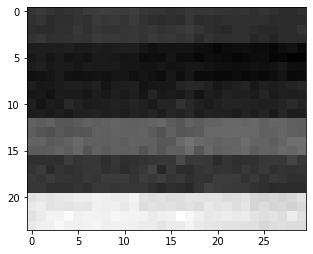

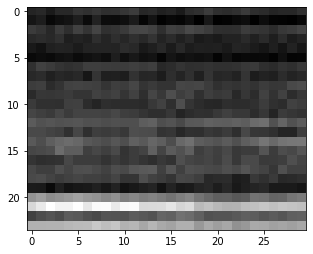

[4451/17000] loss_d: -0.409, loss_g: 1.095
[4452/17000] loss_d: -0.421, loss_g: 1.118
[4453/17000] loss_d: -0.439, loss_g: 1.045
[4454/17000] loss_d: -0.392, loss_g: 1.035
[4455/17000] loss_d: -0.423, loss_g: 1.004
[4456/17000] loss_d: -0.386, loss_g: 1.048
[4457/17000] loss_d: -0.379, loss_g: 1.053
[4458/17000] loss_d: -0.453, loss_g: 1.194
[4459/17000] loss_d: -0.424, loss_g: 0.976
[4460/17000] loss_d: -0.416, loss_g: 1.019
[4461/17000] loss_d: -0.432, loss_g: 1.088
[4462/17000] loss_d: -0.430, loss_g: 1.125
[4463/17000] loss_d: -0.393, loss_g: 1.120
[4464/17000] loss_d: -0.409, loss_g: 1.208
[4465/17000] loss_d: -0.416, loss_g: 1.137
[4466/17000] loss_d: -0.412, loss_g: 1.040
[4467/17000] loss_d: -0.411, loss_g: 1.078
[4468/17000] loss_d: -0.418, loss_g: 1.106
[4469/17000] loss_d: -0.405, loss_g: 1.116
[4470/17000] loss_d: -0.420, loss_g: 1.165
[4471/17000] loss_d: -0.415, loss_g: 1.045
[4472/17000] loss_d: -0.425, loss_g: 1.083
[4473/17000] loss_d: -0.380, loss_g: 1.126
[4474/17000

<Figure size 432x288 with 0 Axes>

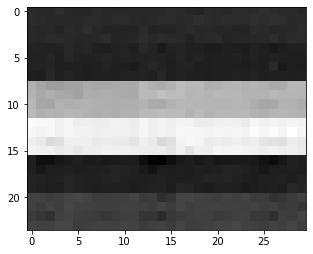

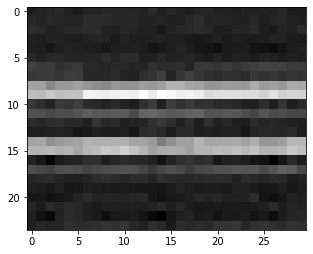

[4501/17000] loss_d: -0.401, loss_g: 0.954
[4502/17000] loss_d: -0.374, loss_g: 1.082
[4503/17000] loss_d: -0.447, loss_g: 0.988
[4504/17000] loss_d: -0.389, loss_g: 1.107
[4505/17000] loss_d: -0.402, loss_g: 1.053
[4506/17000] loss_d: -0.398, loss_g: 1.039
[4507/17000] loss_d: -0.409, loss_g: 1.085
[4508/17000] loss_d: -0.423, loss_g: 1.011
[4509/17000] loss_d: -0.406, loss_g: 1.094
[4510/17000] loss_d: -0.391, loss_g: 1.028
[4511/17000] loss_d: -0.423, loss_g: 1.048
[4512/17000] loss_d: -0.411, loss_g: 1.003
[4513/17000] loss_d: -0.413, loss_g: 1.014
[4514/17000] loss_d: -0.399, loss_g: 1.076
[4515/17000] loss_d: -0.401, loss_g: 0.935
[4516/17000] loss_d: -0.416, loss_g: 0.960
[4517/17000] loss_d: -0.408, loss_g: 0.954
[4518/17000] loss_d: -0.420, loss_g: 1.022
[4519/17000] loss_d: -0.406, loss_g: 0.996
[4520/17000] loss_d: -0.421, loss_g: 1.000
[4521/17000] loss_d: -0.424, loss_g: 1.022
[4522/17000] loss_d: -0.404, loss_g: 1.061
[4523/17000] loss_d: -0.438, loss_g: 1.049
[4524/17000

<Figure size 432x288 with 0 Axes>

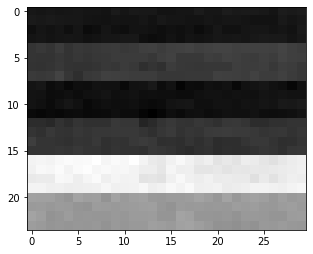

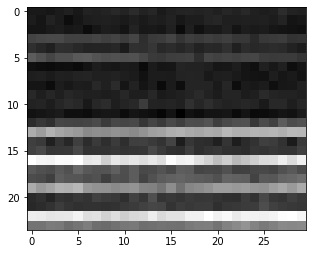

[4551/17000] loss_d: -0.416, loss_g: 1.093
[4552/17000] loss_d: -0.424, loss_g: 1.043
[4553/17000] loss_d: -0.412, loss_g: 0.977
[4554/17000] loss_d: -0.384, loss_g: 1.092
[4555/17000] loss_d: -0.438, loss_g: 0.963
[4556/17000] loss_d: -0.413, loss_g: 1.262
[4557/17000] loss_d: -0.430, loss_g: 1.127
[4558/17000] loss_d: -0.403, loss_g: 1.139
[4559/17000] loss_d: -0.449, loss_g: 1.071
[4560/17000] loss_d: -0.413, loss_g: 1.110
[4561/17000] loss_d: -0.425, loss_g: 1.059
[4562/17000] loss_d: -0.369, loss_g: 1.233
[4563/17000] loss_d: -0.413, loss_g: 1.091
[4564/17000] loss_d: -0.368, loss_g: 0.979
[4565/17000] loss_d: -0.409, loss_g: 1.089
[4566/17000] loss_d: -0.426, loss_g: 1.075
[4567/17000] loss_d: -0.413, loss_g: 1.082
[4568/17000] loss_d: -0.417, loss_g: 1.052
[4569/17000] loss_d: -0.413, loss_g: 0.968
[4570/17000] loss_d: -0.398, loss_g: 1.093
[4571/17000] loss_d: -0.384, loss_g: 1.128
[4572/17000] loss_d: -0.405, loss_g: 1.012
[4573/17000] loss_d: -0.409, loss_g: 1.004
[4574/17000

<Figure size 432x288 with 0 Axes>

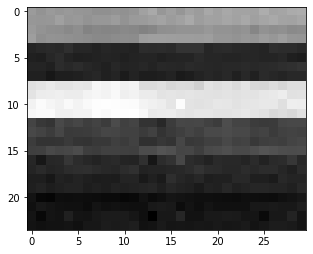

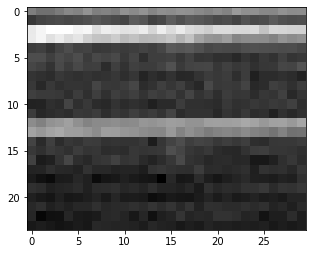

[4601/17000] loss_d: -0.386, loss_g: 0.937
[4602/17000] loss_d: -0.402, loss_g: 1.005
[4603/17000] loss_d: -0.419, loss_g: 1.015
[4604/17000] loss_d: -0.387, loss_g: 1.092
[4605/17000] loss_d: -0.421, loss_g: 1.058
[4606/17000] loss_d: -0.391, loss_g: 0.958
[4607/17000] loss_d: -0.426, loss_g: 1.024
[4608/17000] loss_d: -0.427, loss_g: 0.959
[4609/17000] loss_d: -0.413, loss_g: 1.011
[4610/17000] loss_d: -0.411, loss_g: 0.987
[4611/17000] loss_d: -0.456, loss_g: 1.083
[4612/17000] loss_d: -0.428, loss_g: 1.038
[4613/17000] loss_d: -0.417, loss_g: 1.015
[4614/17000] loss_d: -0.430, loss_g: 0.966
[4615/17000] loss_d: -0.377, loss_g: 1.097
[4616/17000] loss_d: -0.445, loss_g: 1.073
[4617/17000] loss_d: -0.398, loss_g: 0.915
[4618/17000] loss_d: -0.418, loss_g: 1.028
[4619/17000] loss_d: -0.389, loss_g: 1.052
[4620/17000] loss_d: -0.390, loss_g: 1.069
[4621/17000] loss_d: -0.425, loss_g: 1.057
[4622/17000] loss_d: -0.393, loss_g: 0.957
[4623/17000] loss_d: -0.416, loss_g: 1.066
[4624/17000

<Figure size 432x288 with 0 Axes>

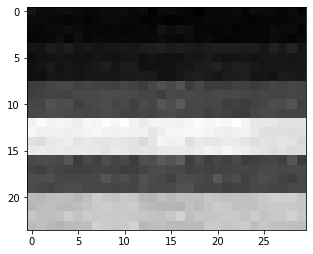

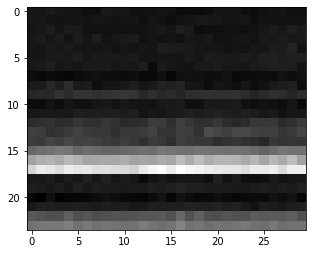

[4651/17000] loss_d: -0.400, loss_g: 0.923
[4652/17000] loss_d: -0.392, loss_g: 0.937
[4653/17000] loss_d: -0.398, loss_g: 1.072
[4654/17000] loss_d: -0.407, loss_g: 0.933
[4655/17000] loss_d: -0.431, loss_g: 1.054
[4656/17000] loss_d: -0.420, loss_g: 1.014
[4657/17000] loss_d: -0.414, loss_g: 1.064
[4658/17000] loss_d: -0.409, loss_g: 0.997
[4659/17000] loss_d: -0.406, loss_g: 0.971
[4660/17000] loss_d: -0.372, loss_g: 1.028
[4661/17000] loss_d: -0.418, loss_g: 1.004
[4662/17000] loss_d: -0.409, loss_g: 0.966
[4663/17000] loss_d: -0.422, loss_g: 1.033
[4664/17000] loss_d: -0.382, loss_g: 1.023
[4665/17000] loss_d: -0.409, loss_g: 1.070
[4666/17000] loss_d: -0.442, loss_g: 1.035
[4667/17000] loss_d: -0.371, loss_g: 1.009
[4668/17000] loss_d: -0.409, loss_g: 1.020
[4669/17000] loss_d: -0.424, loss_g: 1.095
[4670/17000] loss_d: -0.404, loss_g: 1.003
[4671/17000] loss_d: -0.422, loss_g: 0.998
[4672/17000] loss_d: -0.396, loss_g: 1.002
[4673/17000] loss_d: -0.412, loss_g: 0.984
[4674/17000

<Figure size 432x288 with 0 Axes>

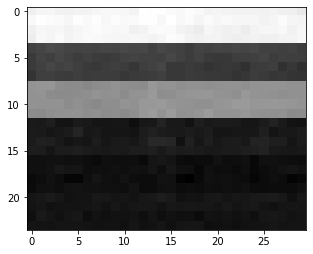

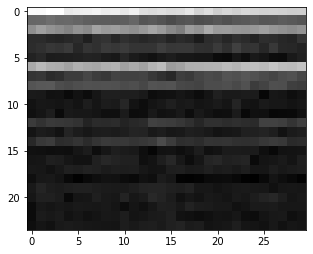

[4701/17000] loss_d: -0.413, loss_g: 1.035
[4702/17000] loss_d: -0.409, loss_g: 1.015
[4703/17000] loss_d: -0.427, loss_g: 1.033
[4704/17000] loss_d: -0.469, loss_g: 1.087
[4705/17000] loss_d: -0.397, loss_g: 1.128
[4706/17000] loss_d: -0.387, loss_g: 1.053
[4707/17000] loss_d: -0.400, loss_g: 1.035
[4708/17000] loss_d: -0.437, loss_g: 1.004
[4709/17000] loss_d: -0.423, loss_g: 1.051
[4710/17000] loss_d: -0.412, loss_g: 1.030
[4711/17000] loss_d: -0.398, loss_g: 1.004
[4712/17000] loss_d: -0.419, loss_g: 0.941
[4713/17000] loss_d: -0.425, loss_g: 1.006
[4714/17000] loss_d: -0.404, loss_g: 0.993
[4715/17000] loss_d: -0.409, loss_g: 1.084
[4716/17000] loss_d: -0.409, loss_g: 1.058
[4717/17000] loss_d: -0.422, loss_g: 1.106
[4718/17000] loss_d: -0.405, loss_g: 1.092
[4719/17000] loss_d: -0.392, loss_g: 1.073
[4720/17000] loss_d: -0.414, loss_g: 1.033
[4721/17000] loss_d: -0.406, loss_g: 1.094
[4722/17000] loss_d: -0.413, loss_g: 1.069
[4723/17000] loss_d: -0.404, loss_g: 1.033
[4724/17000

<Figure size 432x288 with 0 Axes>

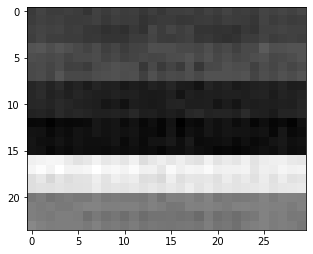

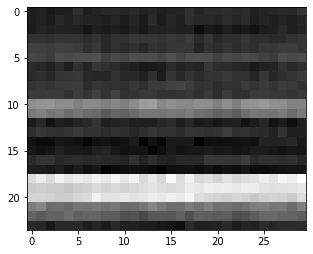

[4751/17000] loss_d: -0.401, loss_g: 1.028
[4752/17000] loss_d: -0.415, loss_g: 1.030
[4753/17000] loss_d: -0.390, loss_g: 1.032
[4754/17000] loss_d: -0.385, loss_g: 1.042
[4755/17000] loss_d: -0.407, loss_g: 1.096
[4756/17000] loss_d: -0.411, loss_g: 1.154
[4757/17000] loss_d: -0.426, loss_g: 1.062
[4758/17000] loss_d: -0.411, loss_g: 1.077
[4759/17000] loss_d: -0.388, loss_g: 1.074
[4760/17000] loss_d: -0.402, loss_g: 0.995
[4761/17000] loss_d: -0.399, loss_g: 1.049
[4762/17000] loss_d: -0.383, loss_g: 1.091
[4763/17000] loss_d: -0.394, loss_g: 1.110
[4764/17000] loss_d: -0.418, loss_g: 1.094
[4765/17000] loss_d: -0.428, loss_g: 1.108
[4766/17000] loss_d: -0.443, loss_g: 1.080
[4767/17000] loss_d: -0.408, loss_g: 1.038
[4768/17000] loss_d: -0.369, loss_g: 1.042
[4769/17000] loss_d: -0.407, loss_g: 1.016
[4770/17000] loss_d: -0.390, loss_g: 0.963
[4771/17000] loss_d: -0.451, loss_g: 1.032
[4772/17000] loss_d: -0.405, loss_g: 1.067
[4773/17000] loss_d: -0.430, loss_g: 1.110
[4774/17000

<Figure size 432x288 with 0 Axes>

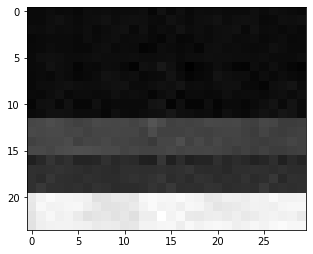

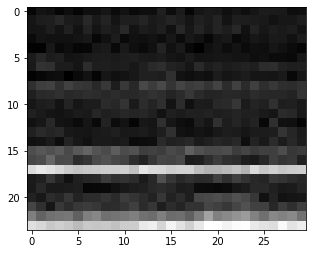

[4801/17000] loss_d: -0.398, loss_g: 0.957
[4802/17000] loss_d: -0.407, loss_g: 1.025
[4803/17000] loss_d: -0.418, loss_g: 1.004
[4804/17000] loss_d: -0.350, loss_g: 0.976
[4805/17000] loss_d: -0.440, loss_g: 0.956
[4806/17000] loss_d: -0.410, loss_g: 0.970
[4807/17000] loss_d: -0.411, loss_g: 0.930
[4808/17000] loss_d: -0.423, loss_g: 0.916
[4809/17000] loss_d: -0.362, loss_g: 0.937
[4810/17000] loss_d: -0.403, loss_g: 0.943
[4811/17000] loss_d: -0.381, loss_g: 1.023
[4812/17000] loss_d: -0.435, loss_g: 0.978
[4813/17000] loss_d: -0.404, loss_g: 1.055
[4814/17000] loss_d: -0.353, loss_g: 1.031
[4815/17000] loss_d: -0.405, loss_g: 1.030
[4816/17000] loss_d: -0.360, loss_g: 0.967
[4817/17000] loss_d: -0.419, loss_g: 1.004
[4818/17000] loss_d: -0.451, loss_g: 1.016
[4819/17000] loss_d: -0.398, loss_g: 1.038
[4820/17000] loss_d: -0.368, loss_g: 1.078
[4821/17000] loss_d: -0.392, loss_g: 1.057
[4822/17000] loss_d: -0.446, loss_g: 0.944
[4823/17000] loss_d: -0.403, loss_g: 1.047
[4824/17000

<Figure size 432x288 with 0 Axes>

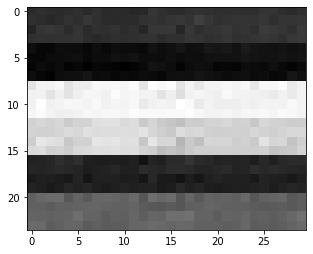

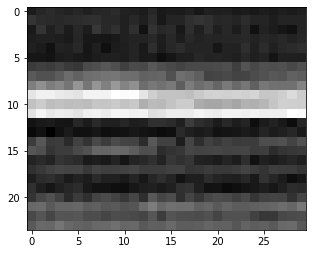

[4851/17000] loss_d: -0.384, loss_g: 0.958
[4852/17000] loss_d: -0.463, loss_g: 1.072
[4853/17000] loss_d: -0.414, loss_g: 1.029
[4854/17000] loss_d: -0.378, loss_g: 0.967
[4855/17000] loss_d: -0.418, loss_g: 0.964
[4856/17000] loss_d: -0.427, loss_g: 0.950
[4857/17000] loss_d: -0.402, loss_g: 0.990
[4858/17000] loss_d: -0.399, loss_g: 0.950
[4859/17000] loss_d: -0.404, loss_g: 0.939
[4860/17000] loss_d: -0.406, loss_g: 0.933
[4861/17000] loss_d: -0.431, loss_g: 0.871
[4862/17000] loss_d: -0.428, loss_g: 0.965
[4863/17000] loss_d: -0.357, loss_g: 0.901
[4864/17000] loss_d: -0.392, loss_g: 0.961
[4865/17000] loss_d: -0.419, loss_g: 1.021
[4866/17000] loss_d: -0.430, loss_g: 1.062
[4867/17000] loss_d: -0.410, loss_g: 0.970
[4868/17000] loss_d: -0.395, loss_g: 0.947
[4869/17000] loss_d: -0.386, loss_g: 1.030
[4870/17000] loss_d: -0.382, loss_g: 1.048
[4871/17000] loss_d: -0.385, loss_g: 1.024
[4872/17000] loss_d: -0.412, loss_g: 0.962
[4873/17000] loss_d: -0.403, loss_g: 1.038
[4874/17000

<Figure size 432x288 with 0 Axes>

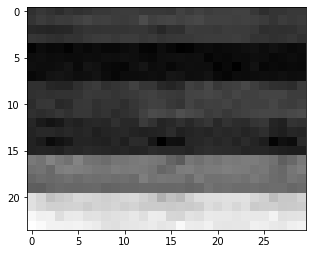

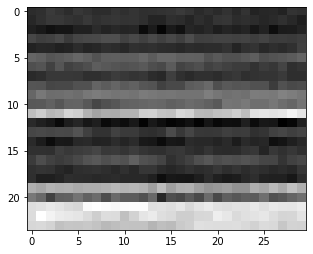

[4901/17000] loss_d: -0.418, loss_g: 0.895
[4902/17000] loss_d: -0.418, loss_g: 1.019
[4903/17000] loss_d: -0.408, loss_g: 0.915
[4904/17000] loss_d: -0.397, loss_g: 0.928
[4905/17000] loss_d: -0.424, loss_g: 1.031
[4906/17000] loss_d: -0.384, loss_g: 0.986
[4907/17000] loss_d: -0.387, loss_g: 1.043
[4908/17000] loss_d: -0.413, loss_g: 1.094
[4909/17000] loss_d: -0.400, loss_g: 1.047
[4910/17000] loss_d: -0.406, loss_g: 1.007
[4911/17000] loss_d: -0.414, loss_g: 1.041
[4912/17000] loss_d: -0.404, loss_g: 1.033
[4913/17000] loss_d: -0.395, loss_g: 1.063
[4914/17000] loss_d: -0.426, loss_g: 1.021
[4915/17000] loss_d: -0.426, loss_g: 0.974
[4916/17000] loss_d: -0.452, loss_g: 1.171
[4917/17000] loss_d: -0.427, loss_g: 1.002
[4918/17000] loss_d: -0.379, loss_g: 0.926
[4919/17000] loss_d: -0.407, loss_g: 0.934
[4920/17000] loss_d: -0.433, loss_g: 0.926
[4921/17000] loss_d: -0.445, loss_g: 0.910
[4922/17000] loss_d: -0.436, loss_g: 0.934
[4923/17000] loss_d: -0.402, loss_g: 0.963
[4924/17000

<Figure size 432x288 with 0 Axes>

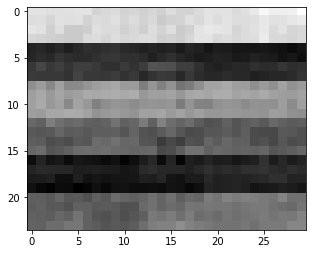

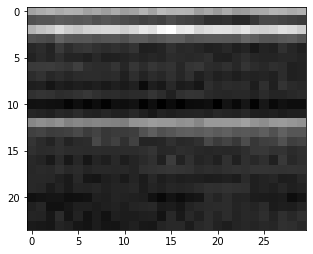

[4951/17000] loss_d: -0.390, loss_g: 0.893
[4952/17000] loss_d: -0.385, loss_g: 0.909
[4953/17000] loss_d: -0.399, loss_g: 0.995
[4954/17000] loss_d: -0.423, loss_g: 1.040
[4955/17000] loss_d: -0.418, loss_g: 0.984
[4956/17000] loss_d: -0.410, loss_g: 0.972
[4957/17000] loss_d: -0.385, loss_g: 0.909
[4958/17000] loss_d: -0.412, loss_g: 0.929
[4959/17000] loss_d: -0.400, loss_g: 1.040
[4960/17000] loss_d: -0.404, loss_g: 0.973
[4961/17000] loss_d: -0.379, loss_g: 1.016
[4962/17000] loss_d: -0.416, loss_g: 1.038
[4963/17000] loss_d: -0.407, loss_g: 0.943
[4964/17000] loss_d: -0.427, loss_g: 1.038
[4965/17000] loss_d: -0.381, loss_g: 0.967
[4966/17000] loss_d: -0.426, loss_g: 0.988
[4967/17000] loss_d: -0.436, loss_g: 0.946
[4968/17000] loss_d: -0.367, loss_g: 0.929
[4969/17000] loss_d: -0.417, loss_g: 0.976
[4970/17000] loss_d: -0.400, loss_g: 0.927
[4971/17000] loss_d: -0.419, loss_g: 0.992
[4972/17000] loss_d: -0.390, loss_g: 1.027
[4973/17000] loss_d: -0.379, loss_g: 0.870
[4974/17000

<Figure size 432x288 with 0 Axes>

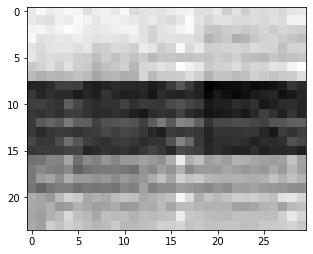

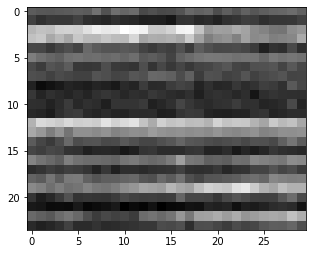

[5001/17000] loss_d: -0.387, loss_g: 1.014
[5002/17000] loss_d: -0.409, loss_g: 0.989
[5003/17000] loss_d: -0.429, loss_g: 1.007
[5004/17000] loss_d: -0.434, loss_g: 1.039
[5005/17000] loss_d: -0.385, loss_g: 1.087
[5006/17000] loss_d: -0.407, loss_g: 1.013
[5007/17000] loss_d: -0.387, loss_g: 0.925
[5008/17000] loss_d: -0.411, loss_g: 0.976
[5009/17000] loss_d: -0.388, loss_g: 1.006
[5010/17000] loss_d: -0.415, loss_g: 0.953
[5011/17000] loss_d: -0.388, loss_g: 1.048
[5012/17000] loss_d: -0.396, loss_g: 1.001
[5013/17000] loss_d: -0.408, loss_g: 1.144
[5014/17000] loss_d: -0.411, loss_g: 1.017
[5015/17000] loss_d: -0.407, loss_g: 1.107
[5016/17000] loss_d: -0.401, loss_g: 1.034
[5017/17000] loss_d: -0.419, loss_g: 0.988
[5018/17000] loss_d: -0.428, loss_g: 1.038
[5019/17000] loss_d: -0.419, loss_g: 0.929
[5020/17000] loss_d: -0.392, loss_g: 0.947
[5021/17000] loss_d: -0.440, loss_g: 1.018
[5022/17000] loss_d: -0.397, loss_g: 0.894
[5023/17000] loss_d: -0.390, loss_g: 1.047
[5024/17000

<Figure size 432x288 with 0 Axes>

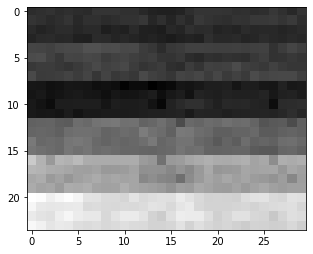

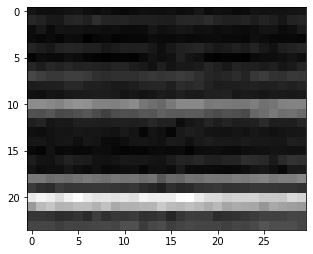

[5051/17000] loss_d: -0.399, loss_g: 1.005
[5052/17000] loss_d: -0.401, loss_g: 0.942
[5053/17000] loss_d: -0.406, loss_g: 0.937
[5054/17000] loss_d: -0.412, loss_g: 0.784
[5055/17000] loss_d: -0.400, loss_g: 0.836
[5056/17000] loss_d: -0.440, loss_g: 0.791
[5057/17000] loss_d: -0.448, loss_g: 0.859
[5058/17000] loss_d: -0.383, loss_g: 1.043
[5059/17000] loss_d: -0.397, loss_g: 1.036
[5060/17000] loss_d: -0.383, loss_g: 1.025
[5061/17000] loss_d: -0.380, loss_g: 0.977
[5062/17000] loss_d: -0.440, loss_g: 0.943
[5063/17000] loss_d: -0.403, loss_g: 0.895
[5064/17000] loss_d: -0.401, loss_g: 1.003
[5065/17000] loss_d: -0.440, loss_g: 0.956
[5066/17000] loss_d: -0.401, loss_g: 0.964
[5067/17000] loss_d: -0.441, loss_g: 0.973
[5068/17000] loss_d: -0.404, loss_g: 0.981
[5069/17000] loss_d: -0.362, loss_g: 0.993
[5070/17000] loss_d: -0.376, loss_g: 0.955
[5071/17000] loss_d: -0.440, loss_g: 1.023
[5072/17000] loss_d: -0.425, loss_g: 1.086
[5073/17000] loss_d: -0.398, loss_g: 0.982
[5074/17000

<Figure size 432x288 with 0 Axes>

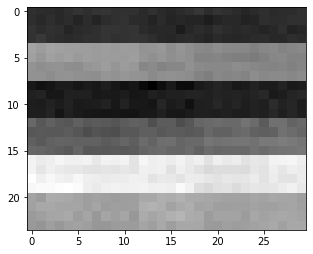

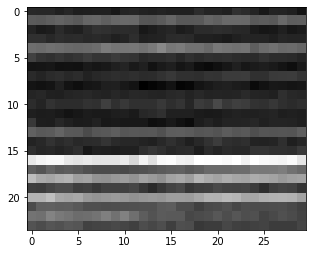

[5101/17000] loss_d: -0.413, loss_g: 1.052
[5102/17000] loss_d: -0.455, loss_g: 1.145
[5103/17000] loss_d: -0.404, loss_g: 1.013
[5104/17000] loss_d: -0.414, loss_g: 1.028
[5105/17000] loss_d: -0.460, loss_g: 1.020
[5106/17000] loss_d: -0.416, loss_g: 0.979
[5107/17000] loss_d: -0.390, loss_g: 1.008
[5108/17000] loss_d: -0.386, loss_g: 0.928
[5109/17000] loss_d: -0.359, loss_g: 0.956
[5110/17000] loss_d: -0.396, loss_g: 0.978
[5111/17000] loss_d: -0.387, loss_g: 0.944
[5112/17000] loss_d: -0.405, loss_g: 1.015
[5113/17000] loss_d: -0.422, loss_g: 1.057
[5114/17000] loss_d: -0.430, loss_g: 0.984
[5115/17000] loss_d: -0.422, loss_g: 0.991
[5116/17000] loss_d: -0.422, loss_g: 0.943
[5117/17000] loss_d: -0.399, loss_g: 0.961
[5118/17000] loss_d: -0.430, loss_g: 0.889
[5119/17000] loss_d: -0.385, loss_g: 0.830
[5120/17000] loss_d: -0.417, loss_g: 0.906
[5121/17000] loss_d: -0.397, loss_g: 0.900
[5122/17000] loss_d: -0.420, loss_g: 0.917
[5123/17000] loss_d: -0.399, loss_g: 1.095
[5124/17000

<Figure size 432x288 with 0 Axes>

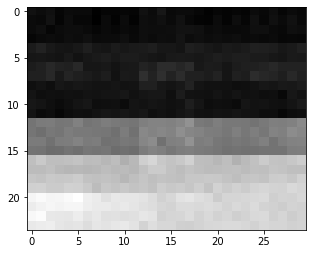

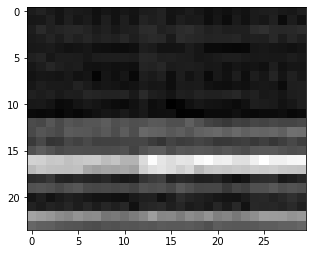

[5151/17000] loss_d: -0.429, loss_g: 0.933
[5152/17000] loss_d: -0.407, loss_g: 0.906
[5153/17000] loss_d: -0.426, loss_g: 0.943
[5154/17000] loss_d: -0.411, loss_g: 0.963
[5155/17000] loss_d: -0.447, loss_g: 0.958
[5156/17000] loss_d: -0.412, loss_g: 1.038
[5157/17000] loss_d: -0.415, loss_g: 0.972
[5158/17000] loss_d: -0.398, loss_g: 0.946
[5159/17000] loss_d: -0.411, loss_g: 0.978
[5160/17000] loss_d: -0.434, loss_g: 0.965
[5161/17000] loss_d: -0.434, loss_g: 0.973
[5162/17000] loss_d: -0.431, loss_g: 0.932
[5163/17000] loss_d: -0.424, loss_g: 0.942
[5164/17000] loss_d: -0.428, loss_g: 0.917
[5165/17000] loss_d: -0.426, loss_g: 0.914
[5166/17000] loss_d: -0.398, loss_g: 0.907
[5167/17000] loss_d: -0.400, loss_g: 1.015
[5168/17000] loss_d: -0.395, loss_g: 0.991
[5169/17000] loss_d: -0.418, loss_g: 0.955
[5170/17000] loss_d: -0.435, loss_g: 0.982
[5171/17000] loss_d: -0.445, loss_g: 1.009
[5172/17000] loss_d: -0.410, loss_g: 0.987
[5173/17000] loss_d: -0.418, loss_g: 0.968
[5174/17000

<Figure size 432x288 with 0 Axes>

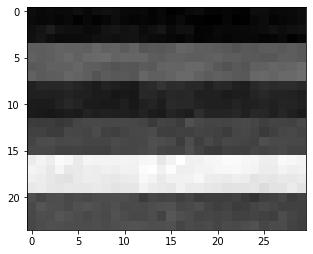

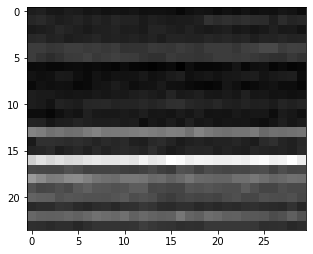

[5201/17000] loss_d: -0.424, loss_g: 1.051
[5202/17000] loss_d: -0.407, loss_g: 1.036
[5203/17000] loss_d: -0.384, loss_g: 1.095
[5204/17000] loss_d: -0.417, loss_g: 1.097
[5205/17000] loss_d: -0.404, loss_g: 1.020
[5206/17000] loss_d: -0.404, loss_g: 1.087
[5207/17000] loss_d: -0.426, loss_g: 1.048
[5208/17000] loss_d: -0.407, loss_g: 1.089
[5209/17000] loss_d: -0.454, loss_g: 1.153
[5210/17000] loss_d: -0.426, loss_g: 1.219
[5211/17000] loss_d: -0.414, loss_g: 0.998
[5212/17000] loss_d: -0.427, loss_g: 1.108
[5213/17000] loss_d: -0.405, loss_g: 1.071
[5214/17000] loss_d: -0.382, loss_g: 1.116
[5215/17000] loss_d: -0.426, loss_g: 1.103
[5216/17000] loss_d: -0.416, loss_g: 1.007
[5217/17000] loss_d: -0.394, loss_g: 1.103
[5218/17000] loss_d: -0.389, loss_g: 0.953
[5219/17000] loss_d: -0.414, loss_g: 0.838
[5220/17000] loss_d: -0.401, loss_g: 0.995
[5221/17000] loss_d: -0.413, loss_g: 1.027
[5222/17000] loss_d: -0.399, loss_g: 1.015
[5223/17000] loss_d: -0.383, loss_g: 1.020
[5224/17000

<Figure size 432x288 with 0 Axes>

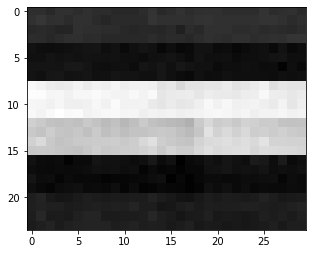

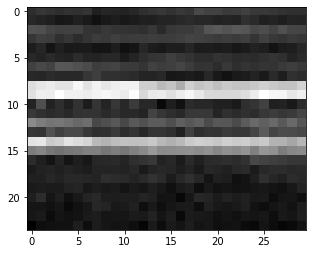

[5251/17000] loss_d: -0.417, loss_g: 1.015
[5252/17000] loss_d: -0.422, loss_g: 1.036
[5253/17000] loss_d: -0.408, loss_g: 0.877
[5254/17000] loss_d: -0.426, loss_g: 0.913
[5255/17000] loss_d: -0.407, loss_g: 1.027
[5256/17000] loss_d: -0.396, loss_g: 0.926
[5257/17000] loss_d: -0.420, loss_g: 0.868
[5258/17000] loss_d: -0.422, loss_g: 1.044
[5259/17000] loss_d: -0.394, loss_g: 0.979
[5260/17000] loss_d: -0.382, loss_g: 0.893
[5261/17000] loss_d: -0.404, loss_g: 1.017
[5262/17000] loss_d: -0.440, loss_g: 1.043
[5263/17000] loss_d: -0.422, loss_g: 0.974
[5264/17000] loss_d: -0.411, loss_g: 0.996
[5265/17000] loss_d: -0.429, loss_g: 0.988
[5266/17000] loss_d: -0.383, loss_g: 0.898
[5267/17000] loss_d: -0.390, loss_g: 0.924
[5268/17000] loss_d: -0.420, loss_g: 0.843
[5269/17000] loss_d: -0.418, loss_g: 0.948
[5270/17000] loss_d: -0.382, loss_g: 0.877
[5271/17000] loss_d: -0.416, loss_g: 0.846
[5272/17000] loss_d: -0.391, loss_g: 0.892
[5273/17000] loss_d: -0.421, loss_g: 0.948
[5274/17000

<Figure size 432x288 with 0 Axes>

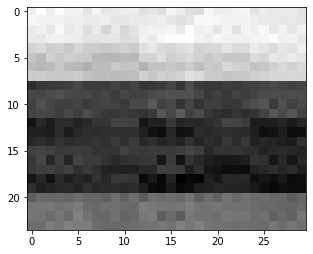

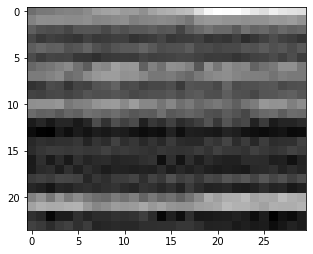

[5301/17000] loss_d: -0.402, loss_g: 0.957
[5302/17000] loss_d: -0.369, loss_g: 1.068
[5303/17000] loss_d: -0.409, loss_g: 1.050
[5304/17000] loss_d: -0.436, loss_g: 1.013
[5305/17000] loss_d: -0.400, loss_g: 1.041
[5306/17000] loss_d: -0.435, loss_g: 1.020
[5307/17000] loss_d: -0.423, loss_g: 0.996
[5308/17000] loss_d: -0.408, loss_g: 1.061
[5309/17000] loss_d: -0.430, loss_g: 0.929
[5310/17000] loss_d: -0.391, loss_g: 0.948
[5311/17000] loss_d: -0.395, loss_g: 0.948
[5312/17000] loss_d: -0.395, loss_g: 1.068
[5313/17000] loss_d: -0.402, loss_g: 0.972
[5314/17000] loss_d: -0.419, loss_g: 0.970
[5315/17000] loss_d: -0.400, loss_g: 1.112
[5316/17000] loss_d: -0.413, loss_g: 0.961
[5317/17000] loss_d: -0.373, loss_g: 1.013
[5318/17000] loss_d: -0.394, loss_g: 1.042
[5319/17000] loss_d: -0.409, loss_g: 0.989
[5320/17000] loss_d: -0.425, loss_g: 1.039
[5321/17000] loss_d: -0.414, loss_g: 0.949
[5322/17000] loss_d: -0.387, loss_g: 1.001
[5323/17000] loss_d: -0.402, loss_g: 1.004
[5324/17000

<Figure size 432x288 with 0 Axes>

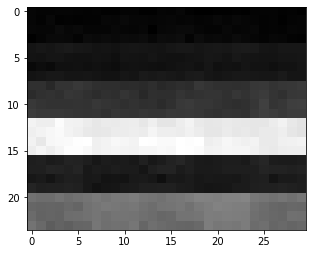

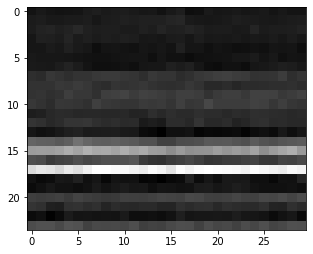

[5351/17000] loss_d: -0.452, loss_g: 1.004
[5352/17000] loss_d: -0.416, loss_g: 1.014
[5353/17000] loss_d: -0.406, loss_g: 1.160
[5354/17000] loss_d: -0.418, loss_g: 1.190
[5355/17000] loss_d: -0.412, loss_g: 1.049
[5356/17000] loss_d: -0.391, loss_g: 0.986
[5357/17000] loss_d: -0.392, loss_g: 0.977
[5358/17000] loss_d: -0.443, loss_g: 0.934
[5359/17000] loss_d: -0.380, loss_g: 0.941
[5360/17000] loss_d: -0.375, loss_g: 0.926
[5361/17000] loss_d: -0.408, loss_g: 1.002
[5362/17000] loss_d: -0.416, loss_g: 0.909
[5363/17000] loss_d: -0.394, loss_g: 0.960
[5364/17000] loss_d: -0.420, loss_g: 0.927
[5365/17000] loss_d: -0.396, loss_g: 0.937
[5366/17000] loss_d: -0.419, loss_g: 0.955
[5367/17000] loss_d: -0.417, loss_g: 0.927
[5368/17000] loss_d: -0.404, loss_g: 0.992
[5369/17000] loss_d: -0.414, loss_g: 0.962
[5370/17000] loss_d: -0.404, loss_g: 0.987
[5371/17000] loss_d: -0.421, loss_g: 0.969
[5372/17000] loss_d: -0.414, loss_g: 1.022
[5373/17000] loss_d: -0.462, loss_g: 0.949
[5374/17000

<Figure size 432x288 with 0 Axes>

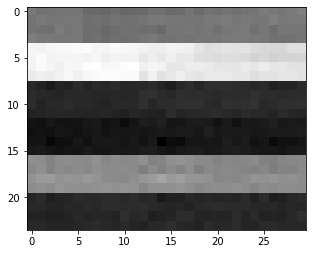

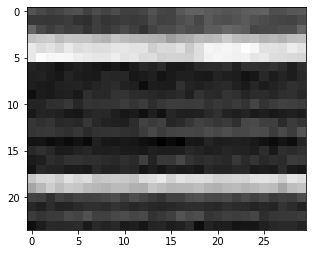

[5401/17000] loss_d: -0.417, loss_g: 1.021
[5402/17000] loss_d: -0.442, loss_g: 0.992
[5403/17000] loss_d: -0.406, loss_g: 1.027
[5404/17000] loss_d: -0.402, loss_g: 0.999
[5405/17000] loss_d: -0.404, loss_g: 1.023
[5406/17000] loss_d: -0.430, loss_g: 1.087
[5407/17000] loss_d: -0.401, loss_g: 0.962
[5408/17000] loss_d: -0.412, loss_g: 0.948
[5409/17000] loss_d: -0.395, loss_g: 0.972
[5410/17000] loss_d: -0.417, loss_g: 0.911
[5411/17000] loss_d: -0.422, loss_g: 1.007
[5412/17000] loss_d: -0.394, loss_g: 1.024
[5413/17000] loss_d: -0.385, loss_g: 0.908
[5414/17000] loss_d: -0.385, loss_g: 0.945
[5415/17000] loss_d: -0.396, loss_g: 0.874
[5416/17000] loss_d: -0.363, loss_g: 0.920
[5417/17000] loss_d: -0.439, loss_g: 0.936
[5418/17000] loss_d: -0.414, loss_g: 0.941
[5419/17000] loss_d: -0.398, loss_g: 0.978
[5420/17000] loss_d: -0.394, loss_g: 0.923
[5421/17000] loss_d: -0.416, loss_g: 0.863
[5422/17000] loss_d: -0.383, loss_g: 0.895
[5423/17000] loss_d: -0.397, loss_g: 1.043
[5424/17000

<Figure size 432x288 with 0 Axes>

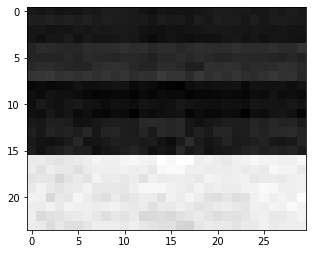

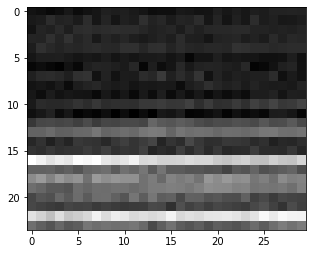

[5451/17000] loss_d: -0.396, loss_g: 0.925
[5452/17000] loss_d: -0.415, loss_g: 0.929
[5453/17000] loss_d: -0.418, loss_g: 0.911
[5454/17000] loss_d: -0.437, loss_g: 0.897
[5455/17000] loss_d: -0.440, loss_g: 0.838
[5456/17000] loss_d: -0.443, loss_g: 0.867
[5457/17000] loss_d: -0.408, loss_g: 0.863
[5458/17000] loss_d: -0.384, loss_g: 0.866
[5459/17000] loss_d: -0.399, loss_g: 0.845
[5460/17000] loss_d: -0.393, loss_g: 0.854
[5461/17000] loss_d: -0.438, loss_g: 0.908
[5462/17000] loss_d: -0.437, loss_g: 0.983
[5463/17000] loss_d: -0.415, loss_g: 0.921
[5464/17000] loss_d: -0.425, loss_g: 1.033
[5465/17000] loss_d: -0.417, loss_g: 0.847
[5466/17000] loss_d: -0.381, loss_g: 0.960
[5467/17000] loss_d: -0.404, loss_g: 0.843
[5468/17000] loss_d: -0.419, loss_g: 0.875
[5469/17000] loss_d: -0.422, loss_g: 0.815
[5470/17000] loss_d: -0.440, loss_g: 0.822
[5471/17000] loss_d: -0.415, loss_g: 0.920
[5472/17000] loss_d: -0.424, loss_g: 0.930
[5473/17000] loss_d: -0.427, loss_g: 0.948
[5474/17000

<Figure size 432x288 with 0 Axes>

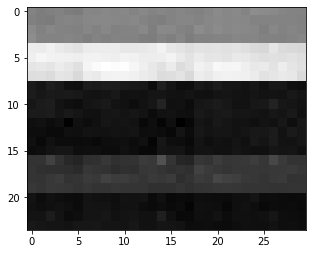

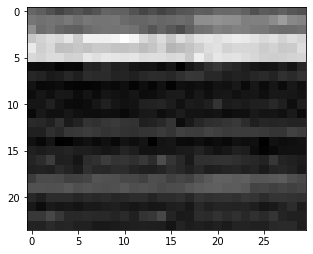

[5501/17000] loss_d: -0.393, loss_g: 1.015
[5502/17000] loss_d: -0.420, loss_g: 1.028
[5503/17000] loss_d: -0.383, loss_g: 0.998
[5504/17000] loss_d: -0.421, loss_g: 1.043
[5505/17000] loss_d: -0.412, loss_g: 0.958
[5506/17000] loss_d: -0.427, loss_g: 1.043
[5507/17000] loss_d: -0.409, loss_g: 1.025
[5508/17000] loss_d: -0.403, loss_g: 1.015
[5509/17000] loss_d: -0.391, loss_g: 1.043
[5510/17000] loss_d: -0.435, loss_g: 0.995
[5511/17000] loss_d: -0.388, loss_g: 1.039
[5512/17000] loss_d: -0.439, loss_g: 1.022
[5513/17000] loss_d: -0.419, loss_g: 1.003
[5514/17000] loss_d: -0.397, loss_g: 0.948
[5515/17000] loss_d: -0.441, loss_g: 0.905
[5516/17000] loss_d: -0.412, loss_g: 0.847
[5517/17000] loss_d: -0.397, loss_g: 0.897
[5518/17000] loss_d: -0.391, loss_g: 0.927
[5519/17000] loss_d: -0.429, loss_g: 0.913
[5520/17000] loss_d: -0.424, loss_g: 0.962
[5521/17000] loss_d: -0.393, loss_g: 0.915
[5522/17000] loss_d: -0.365, loss_g: 1.058
[5523/17000] loss_d: -0.417, loss_g: 1.076
[5524/17000

<Figure size 432x288 with 0 Axes>

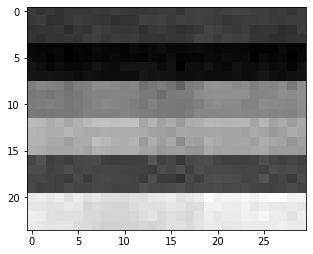

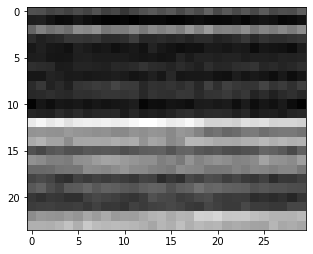

[5551/17000] loss_d: -0.471, loss_g: 0.856
[5552/17000] loss_d: -0.417, loss_g: 1.024
[5553/17000] loss_d: -0.421, loss_g: 1.044
[5554/17000] loss_d: -0.404, loss_g: 0.902
[5555/17000] loss_d: -0.402, loss_g: 0.968
[5556/17000] loss_d: -0.423, loss_g: 1.070
[5557/17000] loss_d: -0.413, loss_g: 0.984
[5558/17000] loss_d: -0.425, loss_g: 1.012
[5559/17000] loss_d: -0.448, loss_g: 0.978
[5560/17000] loss_d: -0.386, loss_g: 0.921
[5561/17000] loss_d: -0.379, loss_g: 1.050
[5562/17000] loss_d: -0.453, loss_g: 0.958
[5563/17000] loss_d: -0.417, loss_g: 1.148
[5564/17000] loss_d: -0.431, loss_g: 1.039
[5565/17000] loss_d: -0.420, loss_g: 1.112
[5566/17000] loss_d: -0.429, loss_g: 1.020
[5567/17000] loss_d: -0.382, loss_g: 1.010
[5568/17000] loss_d: -0.394, loss_g: 0.946
[5569/17000] loss_d: -0.393, loss_g: 0.965
[5570/17000] loss_d: -0.411, loss_g: 0.978
[5571/17000] loss_d: -0.410, loss_g: 0.966
[5572/17000] loss_d: -0.449, loss_g: 1.007
[5573/17000] loss_d: -0.388, loss_g: 1.021
[5574/17000

<Figure size 432x288 with 0 Axes>

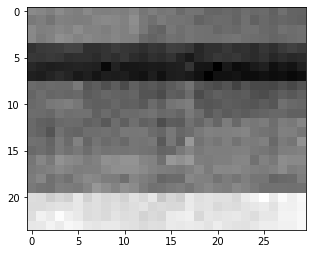

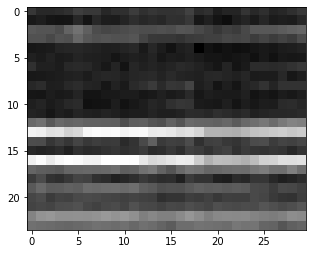

[5601/17000] loss_d: -0.422, loss_g: 0.938
[5602/17000] loss_d: -0.420, loss_g: 0.980
[5603/17000] loss_d: -0.375, loss_g: 0.954
[5604/17000] loss_d: -0.393, loss_g: 0.944
[5605/17000] loss_d: -0.420, loss_g: 1.050
[5606/17000] loss_d: -0.427, loss_g: 1.019
[5607/17000] loss_d: -0.389, loss_g: 1.063
[5608/17000] loss_d: -0.396, loss_g: 0.943
[5609/17000] loss_d: -0.449, loss_g: 1.067
[5610/17000] loss_d: -0.403, loss_g: 0.950
[5611/17000] loss_d: -0.413, loss_g: 1.008
[5612/17000] loss_d: -0.453, loss_g: 0.949
[5613/17000] loss_d: -0.397, loss_g: 0.927
[5614/17000] loss_d: -0.411, loss_g: 1.003
[5615/17000] loss_d: -0.410, loss_g: 0.831
[5616/17000] loss_d: -0.429, loss_g: 0.907
[5617/17000] loss_d: -0.394, loss_g: 0.984
[5618/17000] loss_d: -0.426, loss_g: 0.986
[5619/17000] loss_d: -0.453, loss_g: 1.048
[5620/17000] loss_d: -0.392, loss_g: 1.031
[5621/17000] loss_d: -0.444, loss_g: 0.943
[5622/17000] loss_d: -0.436, loss_g: 0.931
[5623/17000] loss_d: -0.381, loss_g: 1.109
[5624/17000

<Figure size 432x288 with 0 Axes>

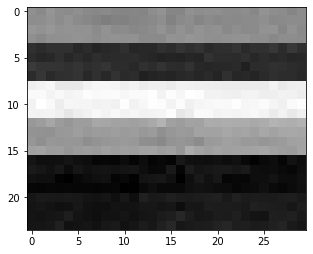

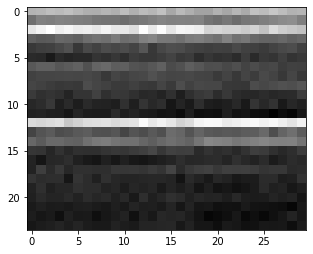

[5651/17000] loss_d: -0.393, loss_g: 0.986
[5652/17000] loss_d: -0.393, loss_g: 0.997
[5653/17000] loss_d: -0.441, loss_g: 0.885
[5654/17000] loss_d: -0.399, loss_g: 0.995
[5655/17000] loss_d: -0.444, loss_g: 0.888
[5656/17000] loss_d: -0.405, loss_g: 0.965
[5657/17000] loss_d: -0.432, loss_g: 0.963
[5658/17000] loss_d: -0.451, loss_g: 1.020
[5659/17000] loss_d: -0.406, loss_g: 0.950
[5660/17000] loss_d: -0.434, loss_g: 0.887
[5661/17000] loss_d: -0.418, loss_g: 1.048
[5662/17000] loss_d: -0.414, loss_g: 1.115
[5663/17000] loss_d: -0.403, loss_g: 0.998
[5664/17000] loss_d: -0.450, loss_g: 0.915
[5665/17000] loss_d: -0.403, loss_g: 0.986
[5666/17000] loss_d: -0.428, loss_g: 1.051
[5667/17000] loss_d: -0.358, loss_g: 0.973
[5668/17000] loss_d: -0.416, loss_g: 0.912
[5669/17000] loss_d: -0.427, loss_g: 0.973
[5670/17000] loss_d: -0.434, loss_g: 0.887
[5671/17000] loss_d: -0.370, loss_g: 0.967
[5672/17000] loss_d: -0.405, loss_g: 0.984
[5673/17000] loss_d: -0.397, loss_g: 0.930
[5674/17000

<Figure size 432x288 with 0 Axes>

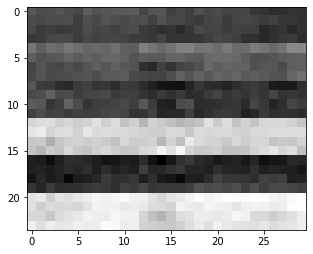

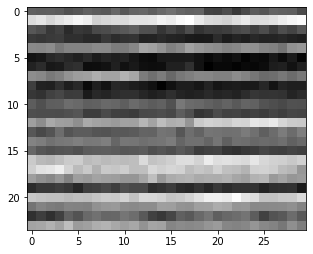

[5701/17000] loss_d: -0.420, loss_g: 0.998
[5702/17000] loss_d: -0.397, loss_g: 0.909
[5703/17000] loss_d: -0.433, loss_g: 0.985
[5704/17000] loss_d: -0.390, loss_g: 1.055
[5705/17000] loss_d: -0.395, loss_g: 0.968
[5706/17000] loss_d: -0.472, loss_g: 1.034
[5707/17000] loss_d: -0.413, loss_g: 1.025
[5708/17000] loss_d: -0.433, loss_g: 1.016
[5709/17000] loss_d: -0.453, loss_g: 0.938
[5710/17000] loss_d: -0.394, loss_g: 1.021
[5711/17000] loss_d: -0.411, loss_g: 0.917
[5712/17000] loss_d: -0.412, loss_g: 0.957
[5713/17000] loss_d: -0.423, loss_g: 0.937
[5714/17000] loss_d: -0.439, loss_g: 0.989
[5715/17000] loss_d: -0.380, loss_g: 0.982
[5716/17000] loss_d: -0.417, loss_g: 1.060
[5717/17000] loss_d: -0.415, loss_g: 0.946
[5718/17000] loss_d: -0.404, loss_g: 0.891
[5719/17000] loss_d: -0.407, loss_g: 0.898
[5720/17000] loss_d: -0.424, loss_g: 0.943
[5721/17000] loss_d: -0.404, loss_g: 1.037
[5722/17000] loss_d: -0.427, loss_g: 0.945
[5723/17000] loss_d: -0.426, loss_g: 0.989
[5724/17000

<Figure size 432x288 with 0 Axes>

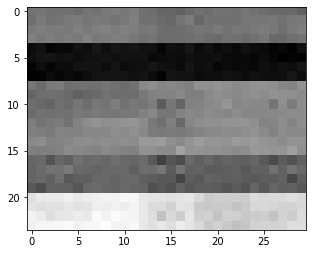

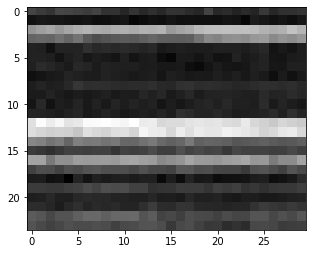

[5751/17000] loss_d: -0.426, loss_g: 0.994
[5752/17000] loss_d: -0.434, loss_g: 1.099
[5753/17000] loss_d: -0.396, loss_g: 1.009
[5754/17000] loss_d: -0.388, loss_g: 1.056
[5755/17000] loss_d: -0.421, loss_g: 0.922
[5756/17000] loss_d: -0.455, loss_g: 0.958
[5757/17000] loss_d: -0.382, loss_g: 0.961
[5758/17000] loss_d: -0.414, loss_g: 0.951
[5759/17000] loss_d: -0.403, loss_g: 0.901
[5760/17000] loss_d: -0.404, loss_g: 0.920
[5761/17000] loss_d: -0.425, loss_g: 1.000
[5762/17000] loss_d: -0.400, loss_g: 0.933
[5763/17000] loss_d: -0.450, loss_g: 0.900
[5764/17000] loss_d: -0.415, loss_g: 0.964
[5765/17000] loss_d: -0.377, loss_g: 0.916
[5766/17000] loss_d: -0.397, loss_g: 0.997
[5767/17000] loss_d: -0.454, loss_g: 0.858
[5768/17000] loss_d: -0.402, loss_g: 1.004
[5769/17000] loss_d: -0.398, loss_g: 0.923
[5770/17000] loss_d: -0.399, loss_g: 0.918
[5771/17000] loss_d: -0.398, loss_g: 0.951
[5772/17000] loss_d: -0.426, loss_g: 0.932
[5773/17000] loss_d: -0.418, loss_g: 0.892
[5774/17000

<Figure size 432x288 with 0 Axes>

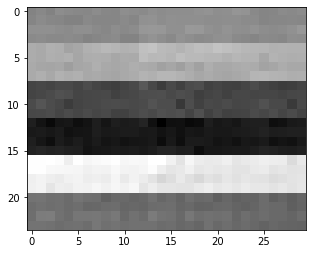

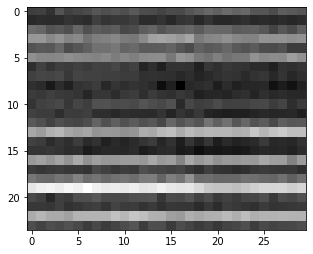

[5801/17000] loss_d: -0.353, loss_g: 1.021
[5802/17000] loss_d: -0.395, loss_g: 0.972
[5803/17000] loss_d: -0.443, loss_g: 1.000
[5804/17000] loss_d: -0.414, loss_g: 0.931
[5805/17000] loss_d: -0.411, loss_g: 0.952
[5806/17000] loss_d: -0.396, loss_g: 1.018
[5807/17000] loss_d: -0.416, loss_g: 1.003
[5808/17000] loss_d: -0.409, loss_g: 0.960
[5809/17000] loss_d: -0.402, loss_g: 0.930
[5810/17000] loss_d: -0.423, loss_g: 0.935
[5811/17000] loss_d: -0.465, loss_g: 0.924
[5812/17000] loss_d: -0.397, loss_g: 0.955
[5813/17000] loss_d: -0.407, loss_g: 0.944
[5814/17000] loss_d: -0.408, loss_g: 1.039
[5815/17000] loss_d: -0.437, loss_g: 1.036
[5816/17000] loss_d: -0.400, loss_g: 1.032
[5817/17000] loss_d: -0.411, loss_g: 0.935
[5818/17000] loss_d: -0.475, loss_g: 0.906
[5819/17000] loss_d: -0.410, loss_g: 0.908
[5820/17000] loss_d: -0.416, loss_g: 0.920
[5821/17000] loss_d: -0.416, loss_g: 0.930
[5822/17000] loss_d: -0.414, loss_g: 0.999
[5823/17000] loss_d: -0.450, loss_g: 1.038
[5824/17000

<Figure size 432x288 with 0 Axes>

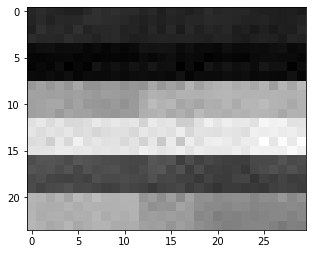

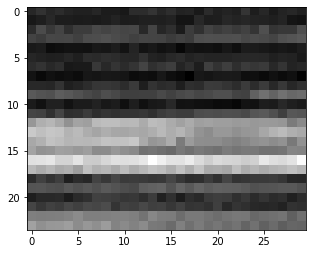

[5851/17000] loss_d: -0.391, loss_g: 1.033
[5852/17000] loss_d: -0.402, loss_g: 1.006
[5853/17000] loss_d: -0.433, loss_g: 0.951
[5854/17000] loss_d: -0.423, loss_g: 1.038
[5855/17000] loss_d: -0.413, loss_g: 1.017
[5856/17000] loss_d: -0.413, loss_g: 1.057
[5857/17000] loss_d: -0.473, loss_g: 1.060
[5858/17000] loss_d: -0.430, loss_g: 0.987
[5859/17000] loss_d: -0.404, loss_g: 1.016
[5860/17000] loss_d: -0.455, loss_g: 0.992
[5861/17000] loss_d: -0.426, loss_g: 0.972
[5862/17000] loss_d: -0.413, loss_g: 1.018
[5863/17000] loss_d: -0.375, loss_g: 1.073
[5864/17000] loss_d: -0.427, loss_g: 0.974
[5865/17000] loss_d: -0.442, loss_g: 0.953
[5866/17000] loss_d: -0.410, loss_g: 1.103
[5867/17000] loss_d: -0.402, loss_g: 1.015
[5868/17000] loss_d: -0.392, loss_g: 0.993
[5869/17000] loss_d: -0.428, loss_g: 0.957
[5870/17000] loss_d: -0.448, loss_g: 1.011
[5871/17000] loss_d: -0.428, loss_g: 0.959
[5872/17000] loss_d: -0.452, loss_g: 0.902
[5873/17000] loss_d: -0.393, loss_g: 1.033
[5874/17000

<Figure size 432x288 with 0 Axes>

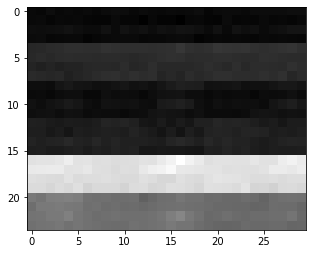

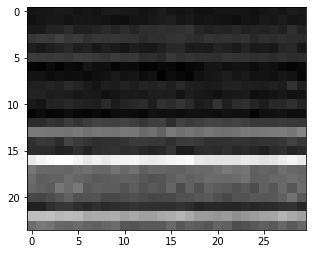

[5901/17000] loss_d: -0.408, loss_g: 1.005
[5902/17000] loss_d: -0.437, loss_g: 0.980
[5903/17000] loss_d: -0.381, loss_g: 1.012
[5904/17000] loss_d: -0.395, loss_g: 0.984
[5905/17000] loss_d: -0.420, loss_g: 0.928
[5906/17000] loss_d: -0.415, loss_g: 1.004
[5907/17000] loss_d: -0.447, loss_g: 1.083
[5908/17000] loss_d: -0.420, loss_g: 1.043
[5909/17000] loss_d: -0.428, loss_g: 0.967
[5910/17000] loss_d: -0.412, loss_g: 1.052
[5911/17000] loss_d: -0.415, loss_g: 0.951
[5912/17000] loss_d: -0.424, loss_g: 0.947
[5913/17000] loss_d: -0.397, loss_g: 0.962
[5914/17000] loss_d: -0.396, loss_g: 0.900
[5915/17000] loss_d: -0.425, loss_g: 0.901
[5916/17000] loss_d: -0.398, loss_g: 0.917
[5917/17000] loss_d: -0.392, loss_g: 0.953
[5918/17000] loss_d: -0.398, loss_g: 0.909
[5919/17000] loss_d: -0.387, loss_g: 0.918
[5920/17000] loss_d: -0.404, loss_g: 1.105
[5921/17000] loss_d: -0.387, loss_g: 0.940
[5922/17000] loss_d: -0.427, loss_g: 0.947
[5923/17000] loss_d: -0.400, loss_g: 0.976
[5924/17000

<Figure size 432x288 with 0 Axes>

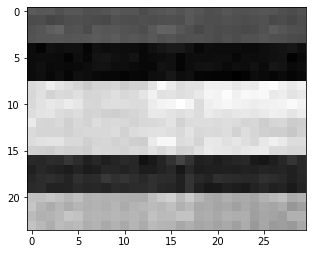

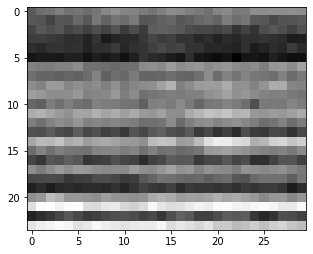

[5951/17000] loss_d: -0.404, loss_g: 0.985
[5952/17000] loss_d: -0.405, loss_g: 1.006
[5953/17000] loss_d: -0.373, loss_g: 0.948
[5954/17000] loss_d: -0.417, loss_g: 1.009
[5955/17000] loss_d: -0.440, loss_g: 1.061
[5956/17000] loss_d: -0.408, loss_g: 0.973
[5957/17000] loss_d: -0.428, loss_g: 0.937
[5958/17000] loss_d: -0.413, loss_g: 0.862
[5959/17000] loss_d: -0.388, loss_g: 0.961
[5960/17000] loss_d: -0.392, loss_g: 0.877
[5961/17000] loss_d: -0.397, loss_g: 0.918
[5962/17000] loss_d: -0.389, loss_g: 0.826
[5963/17000] loss_d: -0.415, loss_g: 0.896
[5964/17000] loss_d: -0.423, loss_g: 0.933
[5965/17000] loss_d: -0.408, loss_g: 0.870
[5966/17000] loss_d: -0.416, loss_g: 0.906
[5967/17000] loss_d: -0.429, loss_g: 0.904
[5968/17000] loss_d: -0.436, loss_g: 0.900
[5969/17000] loss_d: -0.396, loss_g: 0.944
[5970/17000] loss_d: -0.422, loss_g: 0.904
[5971/17000] loss_d: -0.423, loss_g: 0.895
[5972/17000] loss_d: -0.352, loss_g: 0.923
[5973/17000] loss_d: -0.428, loss_g: 0.849
[5974/17000

<Figure size 432x288 with 0 Axes>

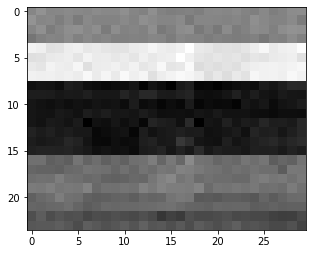

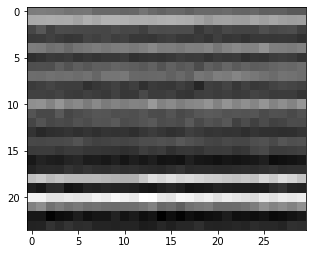

[6001/17000] loss_d: -0.396, loss_g: 1.105
[6002/17000] loss_d: -0.418, loss_g: 1.032
[6003/17000] loss_d: -0.433, loss_g: 0.997
[6004/17000] loss_d: -0.439, loss_g: 1.055
[6005/17000] loss_d: -0.390, loss_g: 0.917
[6006/17000] loss_d: -0.403, loss_g: 0.958
[6007/17000] loss_d: -0.429, loss_g: 1.060
[6008/17000] loss_d: -0.388, loss_g: 0.972
[6009/17000] loss_d: -0.425, loss_g: 0.958
[6010/17000] loss_d: -0.413, loss_g: 0.976
[6011/17000] loss_d: -0.425, loss_g: 0.978
[6012/17000] loss_d: -0.382, loss_g: 0.989
[6013/17000] loss_d: -0.456, loss_g: 0.906
[6014/17000] loss_d: -0.411, loss_g: 0.929
[6015/17000] loss_d: -0.368, loss_g: 0.943
[6016/17000] loss_d: -0.371, loss_g: 0.906
[6017/17000] loss_d: -0.395, loss_g: 0.833
[6018/17000] loss_d: -0.424, loss_g: 0.856
[6019/17000] loss_d: -0.415, loss_g: 0.877
[6020/17000] loss_d: -0.392, loss_g: 0.973
[6021/17000] loss_d: -0.369, loss_g: 0.917
[6022/17000] loss_d: -0.398, loss_g: 0.905
[6023/17000] loss_d: -0.411, loss_g: 0.999
[6024/17000

<Figure size 432x288 with 0 Axes>

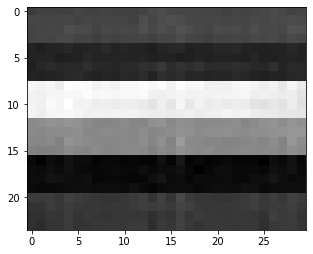

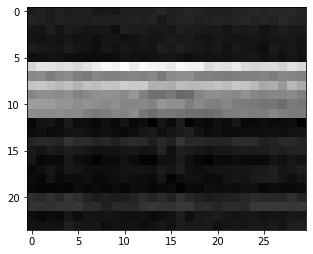

[6051/17000] loss_d: -0.399, loss_g: 1.039
[6052/17000] loss_d: -0.398, loss_g: 1.010
[6053/17000] loss_d: -0.416, loss_g: 0.921
[6054/17000] loss_d: -0.402, loss_g: 0.894
[6055/17000] loss_d: -0.359, loss_g: 0.965
[6056/17000] loss_d: -0.407, loss_g: 1.009
[6057/17000] loss_d: -0.415, loss_g: 0.986
[6058/17000] loss_d: -0.394, loss_g: 0.933
[6059/17000] loss_d: -0.366, loss_g: 0.918
[6060/17000] loss_d: -0.412, loss_g: 0.969
[6061/17000] loss_d: -0.425, loss_g: 0.931
[6062/17000] loss_d: -0.405, loss_g: 0.965
[6063/17000] loss_d: -0.401, loss_g: 0.905
[6064/17000] loss_d: -0.387, loss_g: 0.907
[6065/17000] loss_d: -0.389, loss_g: 0.948
[6066/17000] loss_d: -0.415, loss_g: 0.888
[6067/17000] loss_d: -0.427, loss_g: 0.900
[6068/17000] loss_d: -0.419, loss_g: 0.953
[6069/17000] loss_d: -0.414, loss_g: 1.017
[6070/17000] loss_d: -0.395, loss_g: 0.955
[6071/17000] loss_d: -0.437, loss_g: 0.997
[6072/17000] loss_d: -0.364, loss_g: 0.980
[6073/17000] loss_d: -0.399, loss_g: 0.892
[6074/17000

<Figure size 432x288 with 0 Axes>

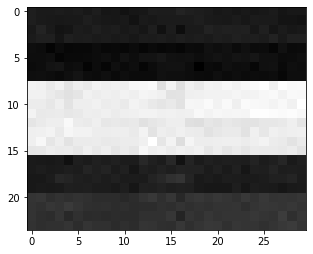

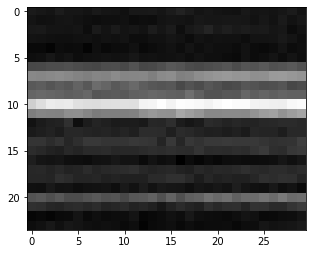

[6101/17000] loss_d: -0.428, loss_g: 0.895
[6102/17000] loss_d: -0.446, loss_g: 1.010
[6103/17000] loss_d: -0.407, loss_g: 0.971
[6104/17000] loss_d: -0.424, loss_g: 0.914
[6105/17000] loss_d: -0.384, loss_g: 0.911
[6106/17000] loss_d: -0.415, loss_g: 0.973
[6107/17000] loss_d: -0.419, loss_g: 0.918
[6108/17000] loss_d: -0.414, loss_g: 1.055
[6109/17000] loss_d: -0.430, loss_g: 0.963
[6110/17000] loss_d: -0.410, loss_g: 0.963
[6111/17000] loss_d: -0.405, loss_g: 0.973
[6112/17000] loss_d: -0.425, loss_g: 1.040
[6113/17000] loss_d: -0.397, loss_g: 0.963
[6114/17000] loss_d: -0.441, loss_g: 0.922
[6115/17000] loss_d: -0.409, loss_g: 1.042
[6116/17000] loss_d: -0.420, loss_g: 0.933
[6117/17000] loss_d: -0.418, loss_g: 0.970
[6118/17000] loss_d: -0.413, loss_g: 1.025
[6119/17000] loss_d: -0.392, loss_g: 1.116
[6120/17000] loss_d: -0.392, loss_g: 1.101
[6121/17000] loss_d: -0.398, loss_g: 1.080
[6122/17000] loss_d: -0.412, loss_g: 0.932
[6123/17000] loss_d: -0.395, loss_g: 0.989
[6124/17000

<Figure size 432x288 with 0 Axes>

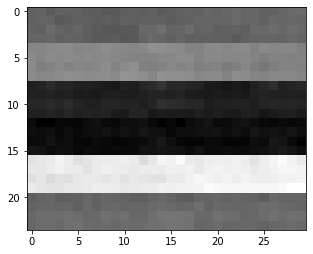

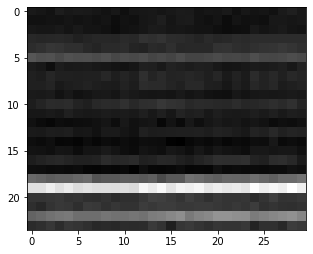

[6151/17000] loss_d: -0.377, loss_g: 0.968
[6152/17000] loss_d: -0.398, loss_g: 0.926
[6153/17000] loss_d: -0.415, loss_g: 0.925
[6154/17000] loss_d: -0.419, loss_g: 0.954
[6155/17000] loss_d: -0.419, loss_g: 0.971
[6156/17000] loss_d: -0.405, loss_g: 1.011
[6157/17000] loss_d: -0.404, loss_g: 0.972
[6158/17000] loss_d: -0.435, loss_g: 0.948
[6159/17000] loss_d: -0.393, loss_g: 0.886
[6160/17000] loss_d: -0.415, loss_g: 0.960
[6161/17000] loss_d: -0.413, loss_g: 0.959
[6162/17000] loss_d: -0.424, loss_g: 0.936
[6163/17000] loss_d: -0.378, loss_g: 0.964
[6164/17000] loss_d: -0.394, loss_g: 0.826
[6165/17000] loss_d: -0.399, loss_g: 0.920
[6166/17000] loss_d: -0.446, loss_g: 0.811
[6167/17000] loss_d: -0.415, loss_g: 0.897
[6168/17000] loss_d: -0.426, loss_g: 0.988
[6169/17000] loss_d: -0.396, loss_g: 0.969
[6170/17000] loss_d: -0.418, loss_g: 1.072
[6171/17000] loss_d: -0.418, loss_g: 0.954
[6172/17000] loss_d: -0.426, loss_g: 0.911
[6173/17000] loss_d: -0.422, loss_g: 0.823
[6174/17000

<Figure size 432x288 with 0 Axes>

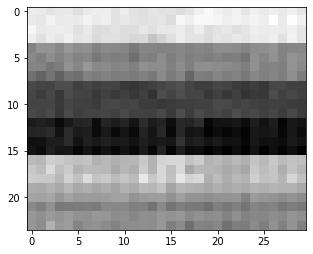

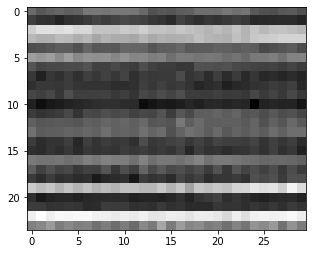

[6201/17000] loss_d: -0.411, loss_g: 0.947
[6202/17000] loss_d: -0.453, loss_g: 0.923
[6203/17000] loss_d: -0.412, loss_g: 0.956
[6204/17000] loss_d: -0.412, loss_g: 0.932
[6205/17000] loss_d: -0.396, loss_g: 1.017
[6206/17000] loss_d: -0.395, loss_g: 1.062
[6207/17000] loss_d: -0.417, loss_g: 0.943
[6208/17000] loss_d: -0.401, loss_g: 0.895
[6209/17000] loss_d: -0.462, loss_g: 0.844
[6210/17000] loss_d: -0.420, loss_g: 0.874
[6211/17000] loss_d: -0.386, loss_g: 0.951
[6212/17000] loss_d: -0.402, loss_g: 0.909
[6213/17000] loss_d: -0.435, loss_g: 0.928
[6214/17000] loss_d: -0.399, loss_g: 0.995
[6215/17000] loss_d: -0.404, loss_g: 0.958
[6216/17000] loss_d: -0.414, loss_g: 0.946
[6217/17000] loss_d: -0.452, loss_g: 0.874
[6218/17000] loss_d: -0.386, loss_g: 0.939
[6219/17000] loss_d: -0.434, loss_g: 0.885
[6220/17000] loss_d: -0.401, loss_g: 1.001
[6221/17000] loss_d: -0.392, loss_g: 0.885
[6222/17000] loss_d: -0.414, loss_g: 0.917
[6223/17000] loss_d: -0.374, loss_g: 0.994
[6224/17000

<Figure size 432x288 with 0 Axes>

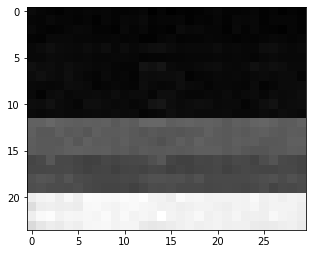

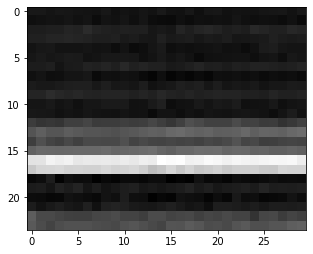

[6251/17000] loss_d: -0.426, loss_g: 0.957
[6252/17000] loss_d: -0.412, loss_g: 0.931
[6253/17000] loss_d: -0.424, loss_g: 0.922
[6254/17000] loss_d: -0.461, loss_g: 0.948
[6255/17000] loss_d: -0.429, loss_g: 0.921
[6256/17000] loss_d: -0.423, loss_g: 1.116
[6257/17000] loss_d: -0.394, loss_g: 1.010
[6258/17000] loss_d: -0.410, loss_g: 0.896
[6259/17000] loss_d: -0.410, loss_g: 0.929
[6260/17000] loss_d: -0.435, loss_g: 0.971
[6261/17000] loss_d: -0.383, loss_g: 1.180
[6262/17000] loss_d: -0.414, loss_g: 0.966
[6263/17000] loss_d: -0.433, loss_g: 0.911
[6264/17000] loss_d: -0.420, loss_g: 0.900
[6265/17000] loss_d: -0.383, loss_g: 0.906
[6266/17000] loss_d: -0.404, loss_g: 0.931
[6267/17000] loss_d: -0.405, loss_g: 1.011
[6268/17000] loss_d: -0.406, loss_g: 0.979
[6269/17000] loss_d: -0.394, loss_g: 0.984
[6270/17000] loss_d: -0.400, loss_g: 1.049
[6271/17000] loss_d: -0.374, loss_g: 0.979
[6272/17000] loss_d: -0.428, loss_g: 0.949
[6273/17000] loss_d: -0.426, loss_g: 0.958
[6274/17000

<Figure size 432x288 with 0 Axes>

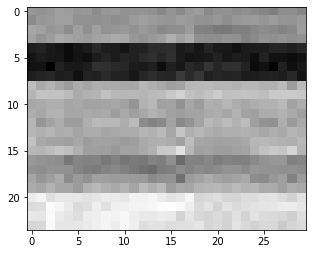

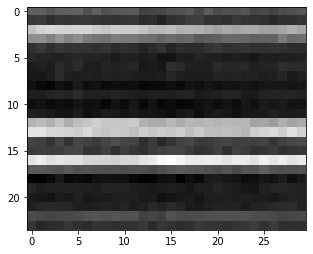

[6301/17000] loss_d: -0.382, loss_g: 0.986
[6302/17000] loss_d: -0.431, loss_g: 1.047
[6303/17000] loss_d: -0.433, loss_g: 1.019
[6304/17000] loss_d: -0.384, loss_g: 0.925
[6305/17000] loss_d: -0.420, loss_g: 0.980
[6306/17000] loss_d: -0.428, loss_g: 1.059
[6307/17000] loss_d: -0.390, loss_g: 1.010
[6308/17000] loss_d: -0.365, loss_g: 0.960
[6309/17000] loss_d: -0.430, loss_g: 0.958
[6310/17000] loss_d: -0.401, loss_g: 0.930
[6311/17000] loss_d: -0.408, loss_g: 0.977
[6312/17000] loss_d: -0.407, loss_g: 0.964
[6313/17000] loss_d: -0.419, loss_g: 0.880
[6314/17000] loss_d: -0.432, loss_g: 0.899
[6315/17000] loss_d: -0.417, loss_g: 0.930
[6316/17000] loss_d: -0.402, loss_g: 0.913
[6317/17000] loss_d: -0.355, loss_g: 0.939
[6318/17000] loss_d: -0.373, loss_g: 0.920
[6319/17000] loss_d: -0.399, loss_g: 0.992
[6320/17000] loss_d: -0.428, loss_g: 0.985
[6321/17000] loss_d: -0.384, loss_g: 0.921
[6322/17000] loss_d: -0.358, loss_g: 0.946
[6323/17000] loss_d: -0.408, loss_g: 0.923
[6324/17000

<Figure size 432x288 with 0 Axes>

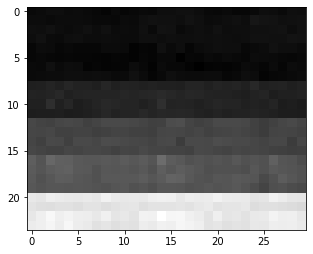

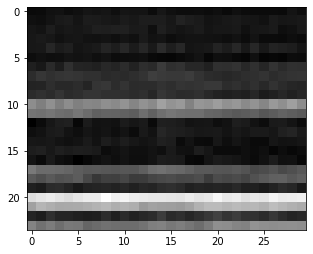

[6351/17000] loss_d: -0.408, loss_g: 0.885
[6352/17000] loss_d: -0.388, loss_g: 0.928
[6353/17000] loss_d: -0.392, loss_g: 0.926
[6354/17000] loss_d: -0.388, loss_g: 0.915
[6355/17000] loss_d: -0.421, loss_g: 0.902
[6356/17000] loss_d: -0.415, loss_g: 0.902
[6357/17000] loss_d: -0.410, loss_g: 0.880
[6358/17000] loss_d: -0.386, loss_g: 0.897
[6359/17000] loss_d: -0.407, loss_g: 0.885
[6360/17000] loss_d: -0.438, loss_g: 0.824
[6361/17000] loss_d: -0.397, loss_g: 0.944
[6362/17000] loss_d: -0.434, loss_g: 0.968
[6363/17000] loss_d: -0.396, loss_g: 0.976
[6364/17000] loss_d: -0.382, loss_g: 0.960
[6365/17000] loss_d: -0.418, loss_g: 0.972
[6366/17000] loss_d: -0.419, loss_g: 0.966
[6367/17000] loss_d: -0.425, loss_g: 0.920
[6368/17000] loss_d: -0.434, loss_g: 0.930
[6369/17000] loss_d: -0.434, loss_g: 0.920
[6370/17000] loss_d: -0.450, loss_g: 0.854
[6371/17000] loss_d: -0.389, loss_g: 0.986
[6372/17000] loss_d: -0.409, loss_g: 0.970
[6373/17000] loss_d: -0.414, loss_g: 0.849
[6374/17000

<Figure size 432x288 with 0 Axes>

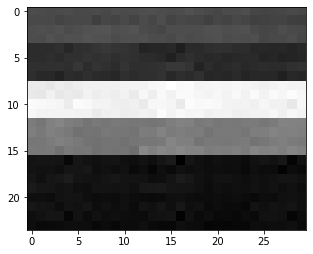

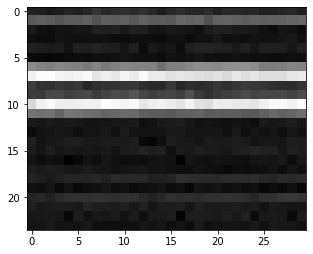

[6401/17000] loss_d: -0.422, loss_g: 0.999
[6402/17000] loss_d: -0.416, loss_g: 0.954
[6403/17000] loss_d: -0.406, loss_g: 1.020
[6404/17000] loss_d: -0.426, loss_g: 0.978
[6405/17000] loss_d: -0.404, loss_g: 0.921
[6406/17000] loss_d: -0.407, loss_g: 1.009
[6407/17000] loss_d: -0.397, loss_g: 0.832
[6408/17000] loss_d: -0.426, loss_g: 0.869
[6409/17000] loss_d: -0.404, loss_g: 0.985
[6410/17000] loss_d: -0.402, loss_g: 0.959
[6411/17000] loss_d: -0.397, loss_g: 0.904
[6412/17000] loss_d: -0.404, loss_g: 0.893
[6413/17000] loss_d: -0.412, loss_g: 0.899
[6414/17000] loss_d: -0.425, loss_g: 0.906
[6415/17000] loss_d: -0.458, loss_g: 0.943
[6416/17000] loss_d: -0.421, loss_g: 0.882
[6417/17000] loss_d: -0.402, loss_g: 0.887
[6418/17000] loss_d: -0.420, loss_g: 0.855
[6419/17000] loss_d: -0.427, loss_g: 0.987
[6420/17000] loss_d: -0.399, loss_g: 1.073
[6421/17000] loss_d: -0.421, loss_g: 0.925
[6422/17000] loss_d: -0.407, loss_g: 0.968
[6423/17000] loss_d: -0.409, loss_g: 0.996
[6424/17000

<Figure size 432x288 with 0 Axes>

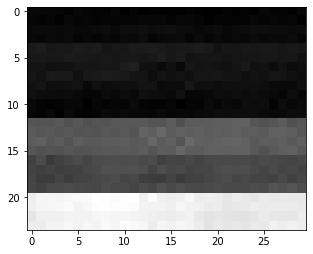

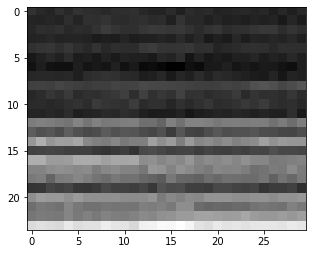

[6451/17000] loss_d: -0.418, loss_g: 0.881
[6452/17000] loss_d: -0.429, loss_g: 0.910
[6453/17000] loss_d: -0.421, loss_g: 0.914
[6454/17000] loss_d: -0.391, loss_g: 0.865
[6455/17000] loss_d: -0.400, loss_g: 1.014
[6456/17000] loss_d: -0.401, loss_g: 0.980
[6457/17000] loss_d: -0.436, loss_g: 0.970
[6458/17000] loss_d: -0.411, loss_g: 0.939
[6459/17000] loss_d: -0.420, loss_g: 0.960
[6460/17000] loss_d: -0.479, loss_g: 1.027
[6461/17000] loss_d: -0.428, loss_g: 0.892
[6462/17000] loss_d: -0.369, loss_g: 1.001
[6463/17000] loss_d: -0.425, loss_g: 0.984
[6464/17000] loss_d: -0.411, loss_g: 0.920
[6465/17000] loss_d: -0.423, loss_g: 0.925
[6466/17000] loss_d: -0.428, loss_g: 0.957
[6467/17000] loss_d: -0.408, loss_g: 0.936
[6468/17000] loss_d: -0.425, loss_g: 0.976
[6469/17000] loss_d: -0.439, loss_g: 0.974
[6470/17000] loss_d: -0.460, loss_g: 0.946
[6471/17000] loss_d: -0.436, loss_g: 0.900
[6472/17000] loss_d: -0.402, loss_g: 0.974
[6473/17000] loss_d: -0.344, loss_g: 1.032
[6474/17000

<Figure size 432x288 with 0 Axes>

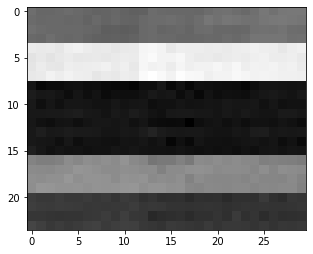

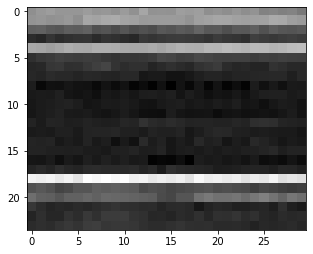

[6501/17000] loss_d: -0.415, loss_g: 0.948
[6502/17000] loss_d: -0.435, loss_g: 0.972
[6503/17000] loss_d: -0.378, loss_g: 0.920
[6504/17000] loss_d: -0.402, loss_g: 1.014
[6505/17000] loss_d: -0.431, loss_g: 1.000
[6506/17000] loss_d: -0.416, loss_g: 0.992
[6507/17000] loss_d: -0.398, loss_g: 0.977
[6508/17000] loss_d: -0.386, loss_g: 1.036
[6509/17000] loss_d: -0.381, loss_g: 0.878
[6510/17000] loss_d: -0.389, loss_g: 1.036
[6511/17000] loss_d: -0.417, loss_g: 1.024
[6512/17000] loss_d: -0.432, loss_g: 0.996
[6513/17000] loss_d: -0.413, loss_g: 1.085
[6514/17000] loss_d: -0.426, loss_g: 1.019
[6515/17000] loss_d: -0.422, loss_g: 1.033
[6516/17000] loss_d: -0.378, loss_g: 1.022
[6517/17000] loss_d: -0.397, loss_g: 0.914
[6518/17000] loss_d: -0.408, loss_g: 0.936
[6519/17000] loss_d: -0.390, loss_g: 1.077
[6520/17000] loss_d: -0.428, loss_g: 0.921
[6521/17000] loss_d: -0.399, loss_g: 0.952
[6522/17000] loss_d: -0.379, loss_g: 0.972
[6523/17000] loss_d: -0.403, loss_g: 0.989
[6524/17000

<Figure size 432x288 with 0 Axes>

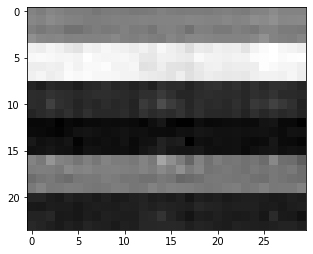

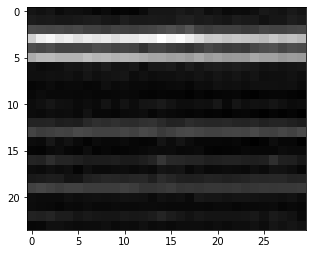

[6551/17000] loss_d: -0.406, loss_g: 1.000
[6552/17000] loss_d: -0.401, loss_g: 0.985
[6553/17000] loss_d: -0.429, loss_g: 0.963
[6554/17000] loss_d: -0.427, loss_g: 1.075
[6555/17000] loss_d: -0.406, loss_g: 1.094
[6556/17000] loss_d: -0.433, loss_g: 0.999
[6557/17000] loss_d: -0.362, loss_g: 0.968
[6558/17000] loss_d: -0.393, loss_g: 0.908
[6559/17000] loss_d: -0.422, loss_g: 1.003
[6560/17000] loss_d: -0.412, loss_g: 0.957
[6561/17000] loss_d: -0.352, loss_g: 0.953
[6562/17000] loss_d: -0.431, loss_g: 0.986
[6563/17000] loss_d: -0.440, loss_g: 0.968
[6564/17000] loss_d: -0.458, loss_g: 0.877
[6565/17000] loss_d: -0.427, loss_g: 0.853
[6566/17000] loss_d: -0.419, loss_g: 0.923
[6567/17000] loss_d: -0.415, loss_g: 0.976
[6568/17000] loss_d: -0.431, loss_g: 0.981
[6569/17000] loss_d: -0.404, loss_g: 0.879
[6570/17000] loss_d: -0.409, loss_g: 0.908
[6571/17000] loss_d: -0.376, loss_g: 1.002
[6572/17000] loss_d: -0.422, loss_g: 0.989
[6573/17000] loss_d: -0.407, loss_g: 0.892
[6574/17000

<Figure size 432x288 with 0 Axes>

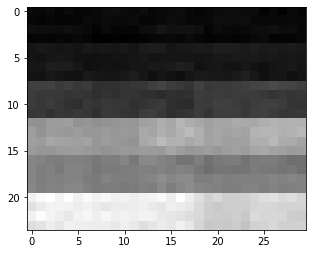

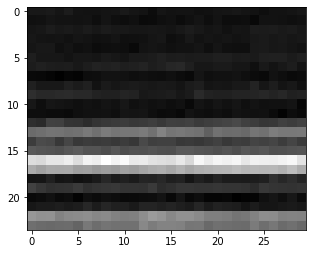

[6601/17000] loss_d: -0.429, loss_g: 0.897
[6602/17000] loss_d: -0.411, loss_g: 0.918
[6603/17000] loss_d: -0.423, loss_g: 0.883
[6604/17000] loss_d: -0.421, loss_g: 0.903
[6605/17000] loss_d: -0.443, loss_g: 0.886
[6606/17000] loss_d: -0.417, loss_g: 0.882
[6607/17000] loss_d: -0.416, loss_g: 0.799
[6608/17000] loss_d: -0.399, loss_g: 0.844
[6609/17000] loss_d: -0.401, loss_g: 0.834
[6610/17000] loss_d: -0.403, loss_g: 0.883
[6611/17000] loss_d: -0.387, loss_g: 0.738
[6612/17000] loss_d: -0.403, loss_g: 0.843
[6613/17000] loss_d: -0.393, loss_g: 0.841
[6614/17000] loss_d: -0.409, loss_g: 0.894
[6615/17000] loss_d: -0.415, loss_g: 0.917
[6616/17000] loss_d: -0.404, loss_g: 0.924
[6617/17000] loss_d: -0.435, loss_g: 0.919
[6618/17000] loss_d: -0.400, loss_g: 1.047
[6619/17000] loss_d: -0.416, loss_g: 1.051
[6620/17000] loss_d: -0.402, loss_g: 0.990
[6621/17000] loss_d: -0.387, loss_g: 0.913
[6622/17000] loss_d: -0.411, loss_g: 0.911
[6623/17000] loss_d: -0.388, loss_g: 0.868
[6624/17000

<Figure size 432x288 with 0 Axes>

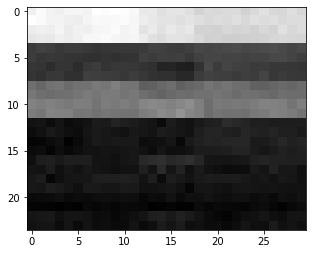

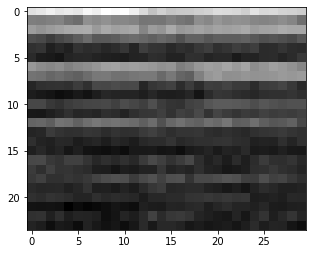

[6651/17000] loss_d: -0.438, loss_g: 1.018
[6652/17000] loss_d: -0.408, loss_g: 0.887
[6653/17000] loss_d: -0.413, loss_g: 1.025
[6654/17000] loss_d: -0.404, loss_g: 0.915
[6655/17000] loss_d: -0.434, loss_g: 0.872
[6656/17000] loss_d: -0.398, loss_g: 0.988
[6657/17000] loss_d: -0.400, loss_g: 0.839
[6658/17000] loss_d: -0.407, loss_g: 0.820
[6659/17000] loss_d: -0.413, loss_g: 0.876
[6660/17000] loss_d: -0.437, loss_g: 0.850
[6661/17000] loss_d: -0.401, loss_g: 0.811
[6662/17000] loss_d: -0.402, loss_g: 0.835
[6663/17000] loss_d: -0.398, loss_g: 0.876
[6664/17000] loss_d: -0.412, loss_g: 0.872
[6665/17000] loss_d: -0.383, loss_g: 0.990
[6666/17000] loss_d: -0.407, loss_g: 0.989
[6667/17000] loss_d: -0.430, loss_g: 0.947
[6668/17000] loss_d: -0.417, loss_g: 0.884
[6669/17000] loss_d: -0.403, loss_g: 0.915
[6670/17000] loss_d: -0.413, loss_g: 0.873
[6671/17000] loss_d: -0.428, loss_g: 0.971
[6672/17000] loss_d: -0.372, loss_g: 0.813
[6673/17000] loss_d: -0.431, loss_g: 0.920
[6674/17000

<Figure size 432x288 with 0 Axes>

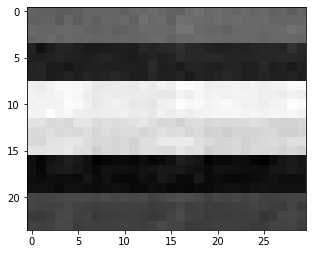

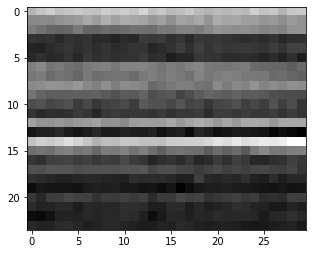

[6701/17000] loss_d: -0.421, loss_g: 0.914
[6702/17000] loss_d: -0.400, loss_g: 0.921
[6703/17000] loss_d: -0.394, loss_g: 0.886
[6704/17000] loss_d: -0.419, loss_g: 0.875
[6705/17000] loss_d: -0.438, loss_g: 0.857
[6706/17000] loss_d: -0.411, loss_g: 0.833
[6707/17000] loss_d: -0.377, loss_g: 0.892
[6708/17000] loss_d: -0.410, loss_g: 0.850
[6709/17000] loss_d: -0.404, loss_g: 0.925
[6710/17000] loss_d: -0.402, loss_g: 0.884
[6711/17000] loss_d: -0.425, loss_g: 0.975
[6712/17000] loss_d: -0.380, loss_g: 0.918
[6713/17000] loss_d: -0.387, loss_g: 0.832
[6714/17000] loss_d: -0.378, loss_g: 0.887
[6715/17000] loss_d: -0.416, loss_g: 0.910
[6716/17000] loss_d: -0.430, loss_g: 0.979
[6717/17000] loss_d: -0.420, loss_g: 0.873
[6718/17000] loss_d: -0.392, loss_g: 0.872
[6719/17000] loss_d: -0.411, loss_g: 0.892
[6720/17000] loss_d: -0.452, loss_g: 0.899
[6721/17000] loss_d: -0.404, loss_g: 0.941
[6722/17000] loss_d: -0.402, loss_g: 0.795
[6723/17000] loss_d: -0.358, loss_g: 0.953
[6724/17000

<Figure size 432x288 with 0 Axes>

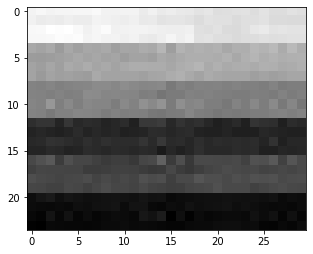

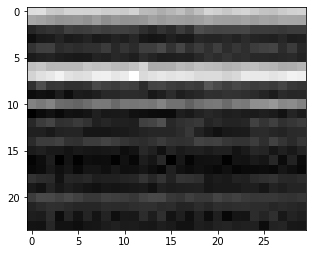

[6751/17000] loss_d: -0.427, loss_g: 0.808
[6752/17000] loss_d: -0.455, loss_g: 0.871
[6753/17000] loss_d: -0.438, loss_g: 0.942
[6754/17000] loss_d: -0.408, loss_g: 0.882
[6755/17000] loss_d: -0.424, loss_g: 0.999
[6756/17000] loss_d: -0.393, loss_g: 0.930
[6757/17000] loss_d: -0.381, loss_g: 0.894
[6758/17000] loss_d: -0.397, loss_g: 0.963
[6759/17000] loss_d: -0.373, loss_g: 0.893
[6760/17000] loss_d: -0.417, loss_g: 0.774
[6761/17000] loss_d: -0.405, loss_g: 0.933
[6762/17000] loss_d: -0.424, loss_g: 0.902
[6763/17000] loss_d: -0.416, loss_g: 0.913
[6764/17000] loss_d: -0.457, loss_g: 0.919
[6765/17000] loss_d: -0.435, loss_g: 0.949
[6766/17000] loss_d: -0.476, loss_g: 0.928
[6767/17000] loss_d: -0.335, loss_g: 0.883
[6768/17000] loss_d: -0.444, loss_g: 0.876
[6769/17000] loss_d: -0.440, loss_g: 1.049
[6770/17000] loss_d: -0.440, loss_g: 0.995
[6771/17000] loss_d: -0.430, loss_g: 0.905
[6772/17000] loss_d: -0.423, loss_g: 0.910
[6773/17000] loss_d: -0.422, loss_g: 0.960
[6774/17000

<Figure size 432x288 with 0 Axes>

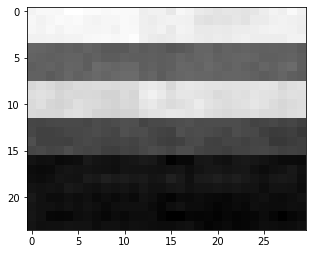

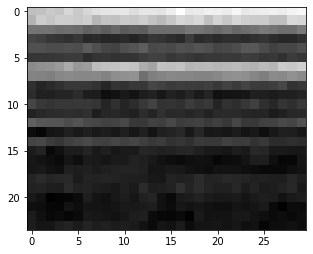

[6801/17000] loss_d: -0.377, loss_g: 0.850
[6802/17000] loss_d: -0.390, loss_g: 0.881
[6803/17000] loss_d: -0.418, loss_g: 0.956
[6804/17000] loss_d: -0.408, loss_g: 1.068
[6805/17000] loss_d: -0.409, loss_g: 0.906
[6806/17000] loss_d: -0.394, loss_g: 0.879
[6807/17000] loss_d: -0.404, loss_g: 0.993
[6808/17000] loss_d: -0.444, loss_g: 0.953
[6809/17000] loss_d: -0.364, loss_g: 0.871
[6810/17000] loss_d: -0.388, loss_g: 0.879
[6811/17000] loss_d: -0.432, loss_g: 0.826
[6812/17000] loss_d: -0.366, loss_g: 0.859
[6813/17000] loss_d: -0.400, loss_g: 0.902
[6814/17000] loss_d: -0.381, loss_g: 0.831
[6815/17000] loss_d: -0.385, loss_g: 0.880
[6816/17000] loss_d: -0.404, loss_g: 0.916
[6817/17000] loss_d: -0.424, loss_g: 1.048
[6818/17000] loss_d: -0.389, loss_g: 0.905
[6819/17000] loss_d: -0.388, loss_g: 0.913
[6820/17000] loss_d: -0.432, loss_g: 0.889
[6821/17000] loss_d: -0.447, loss_g: 0.959
[6822/17000] loss_d: -0.450, loss_g: 0.985
[6823/17000] loss_d: -0.402, loss_g: 0.882
[6824/17000

<Figure size 432x288 with 0 Axes>

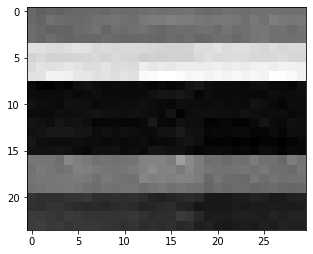

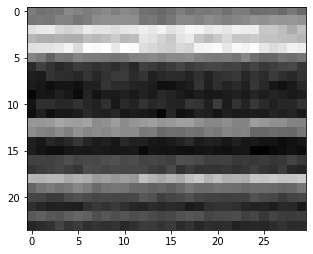

[6851/17000] loss_d: -0.438, loss_g: 0.987
[6852/17000] loss_d: -0.372, loss_g: 0.886
[6853/17000] loss_d: -0.398, loss_g: 0.923
[6854/17000] loss_d: -0.433, loss_g: 0.915
[6855/17000] loss_d: -0.419, loss_g: 0.946
[6856/17000] loss_d: -0.414, loss_g: 0.870
[6857/17000] loss_d: -0.376, loss_g: 0.886
[6858/17000] loss_d: -0.436, loss_g: 0.922
[6859/17000] loss_d: -0.434, loss_g: 0.874
[6860/17000] loss_d: -0.428, loss_g: 0.906
[6861/17000] loss_d: -0.377, loss_g: 0.950
[6862/17000] loss_d: -0.443, loss_g: 0.847
[6863/17000] loss_d: -0.400, loss_g: 0.835
[6864/17000] loss_d: -0.385, loss_g: 0.873
[6865/17000] loss_d: -0.410, loss_g: 0.863
[6866/17000] loss_d: -0.393, loss_g: 0.855
[6867/17000] loss_d: -0.428, loss_g: 0.848
[6868/17000] loss_d: -0.450, loss_g: 0.883
[6869/17000] loss_d: -0.431, loss_g: 0.872
[6870/17000] loss_d: -0.421, loss_g: 0.815
[6871/17000] loss_d: -0.378, loss_g: 0.824
[6872/17000] loss_d: -0.427, loss_g: 0.848
[6873/17000] loss_d: -0.381, loss_g: 0.854
[6874/17000

<Figure size 432x288 with 0 Axes>

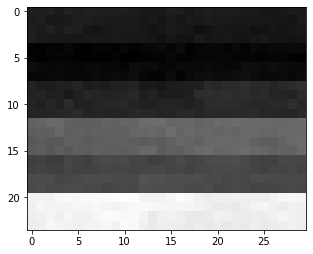

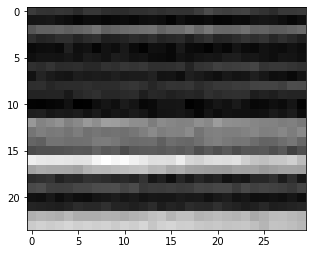

[6901/17000] loss_d: -0.440, loss_g: 0.888
[6902/17000] loss_d: -0.426, loss_g: 0.948
[6903/17000] loss_d: -0.433, loss_g: 0.878
[6904/17000] loss_d: -0.418, loss_g: 0.871
[6905/17000] loss_d: -0.414, loss_g: 0.918
[6906/17000] loss_d: -0.419, loss_g: 0.880
[6907/17000] loss_d: -0.386, loss_g: 0.907
[6908/17000] loss_d: -0.420, loss_g: 0.833
[6909/17000] loss_d: -0.408, loss_g: 0.940
[6910/17000] loss_d: -0.430, loss_g: 1.024
[6911/17000] loss_d: -0.445, loss_g: 1.012
[6912/17000] loss_d: -0.405, loss_g: 1.044
[6913/17000] loss_d: -0.420, loss_g: 1.049
[6914/17000] loss_d: -0.405, loss_g: 0.914
[6915/17000] loss_d: -0.433, loss_g: 0.971
[6916/17000] loss_d: -0.415, loss_g: 0.941
[6917/17000] loss_d: -0.410, loss_g: 0.943
[6918/17000] loss_d: -0.407, loss_g: 0.871
[6919/17000] loss_d: -0.416, loss_g: 0.918
[6920/17000] loss_d: -0.381, loss_g: 0.951
[6921/17000] loss_d: -0.445, loss_g: 0.972
[6922/17000] loss_d: -0.423, loss_g: 0.935
[6923/17000] loss_d: -0.431, loss_g: 0.833
[6924/17000

<Figure size 432x288 with 0 Axes>

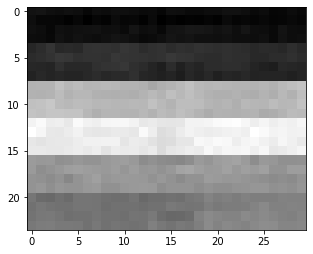

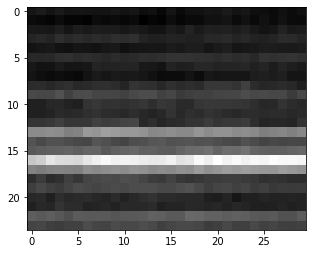

[6951/17000] loss_d: -0.403, loss_g: 1.044
[6952/17000] loss_d: -0.414, loss_g: 0.852
[6953/17000] loss_d: -0.408, loss_g: 0.951
[6954/17000] loss_d: -0.415, loss_g: 0.956
[6955/17000] loss_d: -0.395, loss_g: 0.990
[6956/17000] loss_d: -0.400, loss_g: 0.922
[6957/17000] loss_d: -0.388, loss_g: 0.875
[6958/17000] loss_d: -0.398, loss_g: 0.853
[6959/17000] loss_d: -0.387, loss_g: 0.961
[6960/17000] loss_d: -0.448, loss_g: 1.007
[6961/17000] loss_d: -0.428, loss_g: 0.874
[6962/17000] loss_d: -0.368, loss_g: 0.989
[6963/17000] loss_d: -0.379, loss_g: 1.039
[6964/17000] loss_d: -0.390, loss_g: 0.941
[6965/17000] loss_d: -0.416, loss_g: 1.089
[6966/17000] loss_d: -0.366, loss_g: 0.983
[6967/17000] loss_d: -0.389, loss_g: 1.054
[6968/17000] loss_d: -0.399, loss_g: 0.966
[6969/17000] loss_d: -0.372, loss_g: 0.990
[6970/17000] loss_d: -0.408, loss_g: 0.974
[6971/17000] loss_d: -0.393, loss_g: 0.951
[6972/17000] loss_d: -0.398, loss_g: 0.999
[6973/17000] loss_d: -0.423, loss_g: 0.990
[6974/17000

<Figure size 432x288 with 0 Axes>

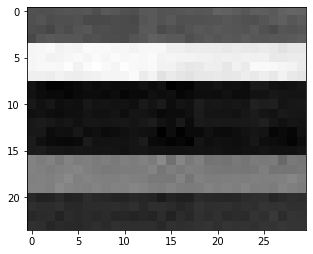

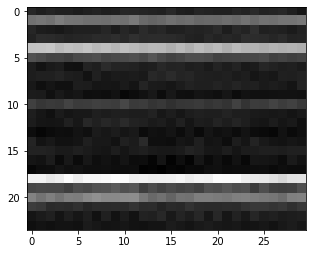

[7001/17000] loss_d: -0.428, loss_g: 0.915
[7002/17000] loss_d: -0.403, loss_g: 0.853
[7003/17000] loss_d: -0.389, loss_g: 0.893
[7004/17000] loss_d: -0.407, loss_g: 0.960
[7005/17000] loss_d: -0.394, loss_g: 0.945
[7006/17000] loss_d: -0.384, loss_g: 0.934
[7007/17000] loss_d: -0.415, loss_g: 0.888
[7008/17000] loss_d: -0.422, loss_g: 0.885
[7009/17000] loss_d: -0.428, loss_g: 0.933
[7010/17000] loss_d: -0.419, loss_g: 0.937
[7011/17000] loss_d: -0.421, loss_g: 0.911
[7012/17000] loss_d: -0.420, loss_g: 0.841
[7013/17000] loss_d: -0.408, loss_g: 0.914
[7014/17000] loss_d: -0.385, loss_g: 0.961
[7015/17000] loss_d: -0.406, loss_g: 0.866
[7016/17000] loss_d: -0.414, loss_g: 0.908
[7017/17000] loss_d: -0.444, loss_g: 0.904
[7018/17000] loss_d: -0.433, loss_g: 0.894
[7019/17000] loss_d: -0.459, loss_g: 0.885
[7020/17000] loss_d: -0.401, loss_g: 0.902
[7021/17000] loss_d: -0.409, loss_g: 0.941
[7022/17000] loss_d: -0.411, loss_g: 0.967
[7023/17000] loss_d: -0.409, loss_g: 0.930
[7024/17000

<Figure size 432x288 with 0 Axes>

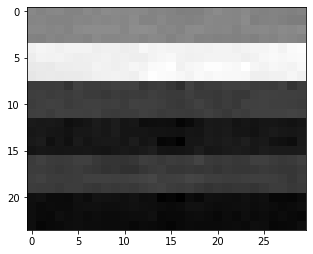

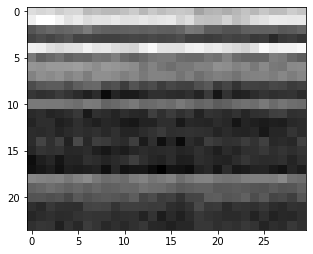

[7051/17000] loss_d: -0.392, loss_g: 0.883
[7052/17000] loss_d: -0.419, loss_g: 0.866
[7053/17000] loss_d: -0.440, loss_g: 0.912
[7054/17000] loss_d: -0.416, loss_g: 0.994
[7055/17000] loss_d: -0.376, loss_g: 0.904
[7056/17000] loss_d: -0.399, loss_g: 0.948
[7057/17000] loss_d: -0.419, loss_g: 0.929
[7058/17000] loss_d: -0.424, loss_g: 0.961
[7059/17000] loss_d: -0.400, loss_g: 0.945
[7060/17000] loss_d: -0.403, loss_g: 1.043
[7061/17000] loss_d: -0.385, loss_g: 0.996
[7062/17000] loss_d: -0.429, loss_g: 1.046
[7063/17000] loss_d: -0.415, loss_g: 0.944
[7064/17000] loss_d: -0.431, loss_g: 0.940
[7065/17000] loss_d: -0.383, loss_g: 0.950
[7066/17000] loss_d: -0.397, loss_g: 0.937
[7067/17000] loss_d: -0.390, loss_g: 1.203
[7068/17000] loss_d: -0.415, loss_g: 0.935
[7069/17000] loss_d: -0.390, loss_g: 0.873
[7070/17000] loss_d: -0.403, loss_g: 1.034
[7071/17000] loss_d: -0.422, loss_g: 0.959
[7072/17000] loss_d: -0.423, loss_g: 0.939
[7073/17000] loss_d: -0.392, loss_g: 0.860
[7074/17000

<Figure size 432x288 with 0 Axes>

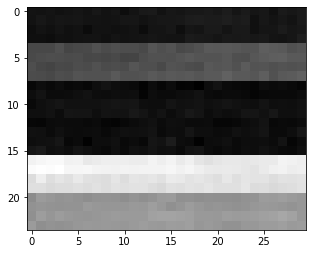

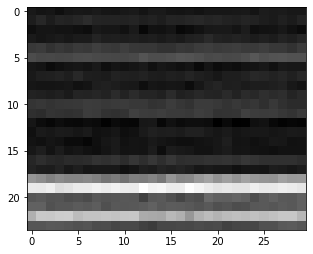

[7101/17000] loss_d: -0.419, loss_g: 0.991
[7102/17000] loss_d: -0.357, loss_g: 0.968
[7103/17000] loss_d: -0.411, loss_g: 1.022
[7104/17000] loss_d: -0.412, loss_g: 0.960
[7105/17000] loss_d: -0.407, loss_g: 0.894
[7106/17000] loss_d: -0.434, loss_g: 0.893
[7107/17000] loss_d: -0.403, loss_g: 0.945
[7108/17000] loss_d: -0.418, loss_g: 1.019
[7109/17000] loss_d: -0.450, loss_g: 0.976
[7110/17000] loss_d: -0.402, loss_g: 1.091
[7111/17000] loss_d: -0.463, loss_g: 0.949
[7112/17000] loss_d: -0.385, loss_g: 0.933
[7113/17000] loss_d: -0.411, loss_g: 1.055
[7114/17000] loss_d: -0.409, loss_g: 1.016
[7115/17000] loss_d: -0.404, loss_g: 0.989
[7116/17000] loss_d: -0.413, loss_g: 0.938
[7117/17000] loss_d: -0.418, loss_g: 0.993
[7118/17000] loss_d: -0.411, loss_g: 0.983
[7119/17000] loss_d: -0.423, loss_g: 0.926
[7120/17000] loss_d: -0.430, loss_g: 0.917
[7121/17000] loss_d: -0.396, loss_g: 0.998
[7122/17000] loss_d: -0.410, loss_g: 1.032
[7123/17000] loss_d: -0.424, loss_g: 1.028
[7124/17000

<Figure size 432x288 with 0 Axes>

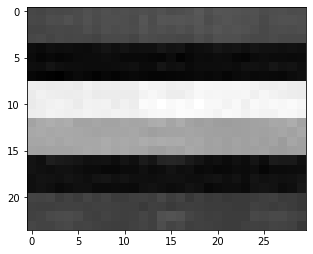

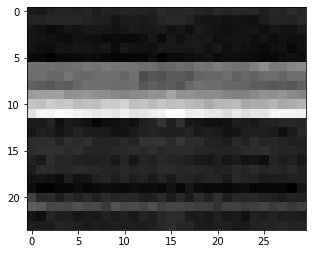

[7151/17000] loss_d: -0.406, loss_g: 0.977
[7152/17000] loss_d: -0.422, loss_g: 0.987
[7153/17000] loss_d: -0.417, loss_g: 1.065
[7154/17000] loss_d: -0.417, loss_g: 0.860
[7155/17000] loss_d: -0.382, loss_g: 0.981
[7156/17000] loss_d: -0.417, loss_g: 0.911
[7157/17000] loss_d: -0.409, loss_g: 0.849
[7158/17000] loss_d: -0.378, loss_g: 0.996
[7159/17000] loss_d: -0.467, loss_g: 0.981
[7160/17000] loss_d: -0.454, loss_g: 0.939
[7161/17000] loss_d: -0.416, loss_g: 0.796
[7162/17000] loss_d: -0.406, loss_g: 0.933
[7163/17000] loss_d: -0.404, loss_g: 0.870
[7164/17000] loss_d: -0.421, loss_g: 0.936
[7165/17000] loss_d: -0.419, loss_g: 0.856
[7166/17000] loss_d: -0.402, loss_g: 0.823
[7167/17000] loss_d: -0.443, loss_g: 0.846
[7168/17000] loss_d: -0.403, loss_g: 0.890
[7169/17000] loss_d: -0.396, loss_g: 0.902
[7170/17000] loss_d: -0.421, loss_g: 0.902
[7171/17000] loss_d: -0.405, loss_g: 0.881
[7172/17000] loss_d: -0.413, loss_g: 0.900
[7173/17000] loss_d: -0.401, loss_g: 0.915
[7174/17000

<Figure size 432x288 with 0 Axes>

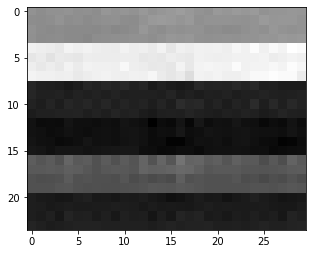

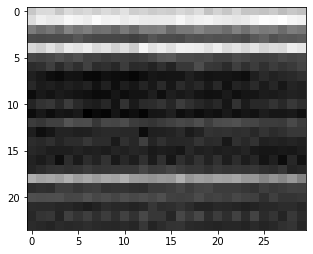

[7201/17000] loss_d: -0.383, loss_g: 0.977
[7202/17000] loss_d: -0.420, loss_g: 0.910
[7203/17000] loss_d: -0.373, loss_g: 0.874
[7204/17000] loss_d: -0.403, loss_g: 0.912
[7205/17000] loss_d: -0.390, loss_g: 0.994
[7206/17000] loss_d: -0.402, loss_g: 0.995
[7207/17000] loss_d: -0.422, loss_g: 0.911
[7208/17000] loss_d: -0.431, loss_g: 0.847
[7209/17000] loss_d: -0.406, loss_g: 0.981
[7210/17000] loss_d: -0.426, loss_g: 0.975
[7211/17000] loss_d: -0.418, loss_g: 0.887
[7212/17000] loss_d: -0.394, loss_g: 0.900
[7213/17000] loss_d: -0.404, loss_g: 0.896
[7214/17000] loss_d: -0.405, loss_g: 0.934
[7215/17000] loss_d: -0.450, loss_g: 0.920
[7216/17000] loss_d: -0.450, loss_g: 0.909
[7217/17000] loss_d: -0.397, loss_g: 0.783
[7218/17000] loss_d: -0.416, loss_g: 0.834
[7219/17000] loss_d: -0.376, loss_g: 0.850
[7220/17000] loss_d: -0.425, loss_g: 0.854
[7221/17000] loss_d: -0.418, loss_g: 0.850
[7222/17000] loss_d: -0.404, loss_g: 0.867
[7223/17000] loss_d: -0.386, loss_g: 0.918
[7224/17000

<Figure size 432x288 with 0 Axes>

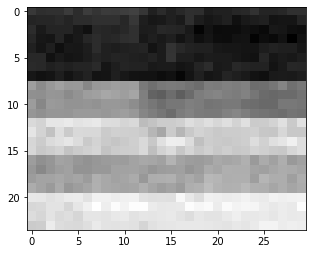

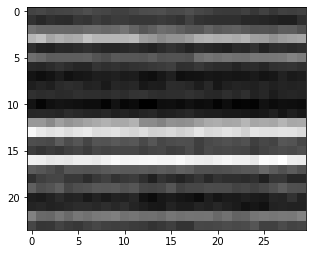

[7251/17000] loss_d: -0.424, loss_g: 0.770
[7252/17000] loss_d: -0.429, loss_g: 0.968
[7253/17000] loss_d: -0.416, loss_g: 0.877
[7254/17000] loss_d: -0.444, loss_g: 0.955
[7255/17000] loss_d: -0.410, loss_g: 0.939
[7256/17000] loss_d: -0.466, loss_g: 0.984
[7257/17000] loss_d: -0.416, loss_g: 0.893
[7258/17000] loss_d: -0.413, loss_g: 0.768
[7259/17000] loss_d: -0.416, loss_g: 0.827
[7260/17000] loss_d: -0.392, loss_g: 0.846
[7261/17000] loss_d: -0.408, loss_g: 0.896
[7262/17000] loss_d: -0.375, loss_g: 0.782
[7263/17000] loss_d: -0.410, loss_g: 0.885
[7264/17000] loss_d: -0.399, loss_g: 0.835
[7265/17000] loss_d: -0.407, loss_g: 0.839
[7266/17000] loss_d: -0.417, loss_g: 0.879
[7267/17000] loss_d: -0.386, loss_g: 0.780
[7268/17000] loss_d: -0.416, loss_g: 0.900
[7269/17000] loss_d: -0.403, loss_g: 0.875
[7270/17000] loss_d: -0.385, loss_g: 0.844
[7271/17000] loss_d: -0.412, loss_g: 0.922
[7272/17000] loss_d: -0.430, loss_g: 0.861
[7273/17000] loss_d: -0.448, loss_g: 0.899
[7274/17000

<Figure size 432x288 with 0 Axes>

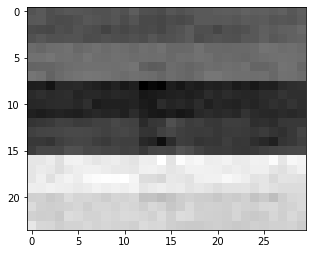

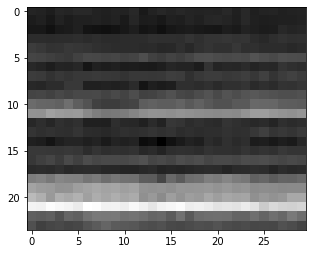

[7301/17000] loss_d: -0.449, loss_g: 0.927
[7302/17000] loss_d: -0.398, loss_g: 0.977
[7303/17000] loss_d: -0.417, loss_g: 0.943
[7304/17000] loss_d: -0.393, loss_g: 0.869
[7305/17000] loss_d: -0.392, loss_g: 0.914
[7306/17000] loss_d: -0.410, loss_g: 0.903
[7307/17000] loss_d: -0.430, loss_g: 0.908
[7308/17000] loss_d: -0.418, loss_g: 0.902
[7309/17000] loss_d: -0.432, loss_g: 0.888
[7310/17000] loss_d: -0.397, loss_g: 0.820
[7311/17000] loss_d: -0.445, loss_g: 0.925
[7312/17000] loss_d: -0.408, loss_g: 0.886
[7313/17000] loss_d: -0.375, loss_g: 0.963
[7314/17000] loss_d: -0.419, loss_g: 0.833
[7315/17000] loss_d: -0.408, loss_g: 0.949
[7316/17000] loss_d: -0.365, loss_g: 0.886
[7317/17000] loss_d: -0.414, loss_g: 0.968
[7318/17000] loss_d: -0.403, loss_g: 0.929
[7319/17000] loss_d: -0.421, loss_g: 0.909
[7320/17000] loss_d: -0.421, loss_g: 0.883
[7321/17000] loss_d: -0.426, loss_g: 0.969
[7322/17000] loss_d: -0.378, loss_g: 0.947
[7323/17000] loss_d: -0.417, loss_g: 0.914
[7324/17000

<Figure size 432x288 with 0 Axes>

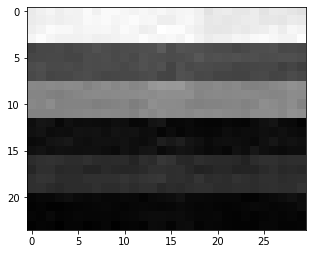

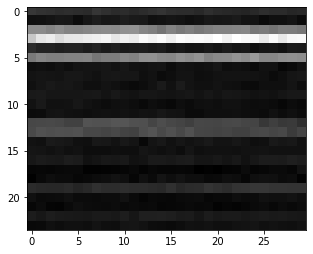

[7351/17000] loss_d: -0.390, loss_g: 1.036
[7352/17000] loss_d: -0.440, loss_g: 0.897
[7353/17000] loss_d: -0.433, loss_g: 0.927
[7354/17000] loss_d: -0.404, loss_g: 0.991
[7355/17000] loss_d: -0.398, loss_g: 1.058
[7356/17000] loss_d: -0.390, loss_g: 0.956
[7357/17000] loss_d: -0.387, loss_g: 0.898
[7358/17000] loss_d: -0.409, loss_g: 0.869
[7359/17000] loss_d: -0.366, loss_g: 0.951
[7360/17000] loss_d: -0.426, loss_g: 0.957
[7361/17000] loss_d: -0.379, loss_g: 0.895
[7362/17000] loss_d: -0.441, loss_g: 0.911
[7363/17000] loss_d: -0.439, loss_g: 1.000
[7364/17000] loss_d: -0.446, loss_g: 0.974
[7365/17000] loss_d: -0.392, loss_g: 0.850
[7366/17000] loss_d: -0.363, loss_g: 0.883
[7367/17000] loss_d: -0.415, loss_g: 0.944
[7368/17000] loss_d: -0.420, loss_g: 0.985
[7369/17000] loss_d: -0.387, loss_g: 0.916
[7370/17000] loss_d: -0.384, loss_g: 0.886
[7371/17000] loss_d: -0.422, loss_g: 0.929
[7372/17000] loss_d: -0.426, loss_g: 0.888
[7373/17000] loss_d: -0.403, loss_g: 0.902
[7374/17000

<Figure size 432x288 with 0 Axes>

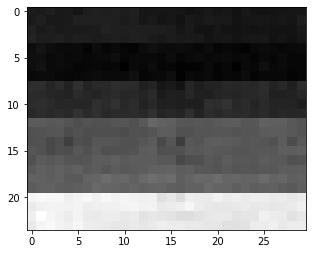

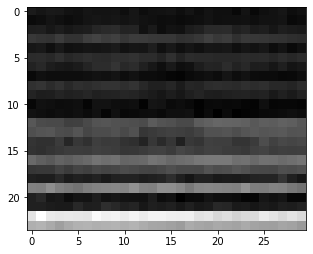

[7401/17000] loss_d: -0.416, loss_g: 0.931
[7402/17000] loss_d: -0.413, loss_g: 0.916
[7403/17000] loss_d: -0.402, loss_g: 0.958
[7404/17000] loss_d: -0.403, loss_g: 0.887
[7405/17000] loss_d: -0.369, loss_g: 0.947
[7406/17000] loss_d: -0.409, loss_g: 0.953
[7407/17000] loss_d: -0.405, loss_g: 0.888
[7408/17000] loss_d: -0.433, loss_g: 0.872
[7409/17000] loss_d: -0.396, loss_g: 0.907
[7410/17000] loss_d: -0.375, loss_g: 0.970
[7411/17000] loss_d: -0.425, loss_g: 1.066
[7412/17000] loss_d: -0.401, loss_g: 1.003
[7413/17000] loss_d: -0.385, loss_g: 0.876
[7414/17000] loss_d: -0.423, loss_g: 0.951
[7415/17000] loss_d: -0.406, loss_g: 0.863
[7416/17000] loss_d: -0.416, loss_g: 0.973
[7417/17000] loss_d: -0.413, loss_g: 0.912
[7418/17000] loss_d: -0.429, loss_g: 0.897
[7419/17000] loss_d: -0.397, loss_g: 0.935
[7420/17000] loss_d: -0.386, loss_g: 0.968
[7421/17000] loss_d: -0.405, loss_g: 0.980
[7422/17000] loss_d: -0.414, loss_g: 1.024
[7423/17000] loss_d: -0.432, loss_g: 0.939
[7424/17000

<Figure size 432x288 with 0 Axes>

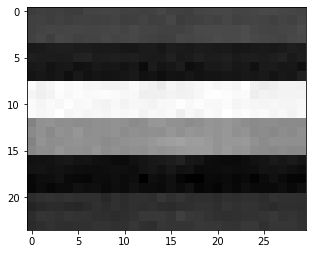

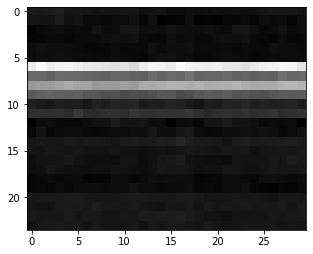

[7451/17000] loss_d: -0.440, loss_g: 1.056
[7452/17000] loss_d: -0.415, loss_g: 0.997
[7453/17000] loss_d: -0.423, loss_g: 0.953
[7454/17000] loss_d: -0.359, loss_g: 1.039
[7455/17000] loss_d: -0.403, loss_g: 0.948
[7456/17000] loss_d: -0.423, loss_g: 0.967
[7457/17000] loss_d: -0.427, loss_g: 1.015
[7458/17000] loss_d: -0.453, loss_g: 0.925
[7459/17000] loss_d: -0.344, loss_g: 0.889
[7460/17000] loss_d: -0.405, loss_g: 0.955
[7461/17000] loss_d: -0.408, loss_g: 0.939
[7462/17000] loss_d: -0.390, loss_g: 0.850
[7463/17000] loss_d: -0.394, loss_g: 0.917
[7464/17000] loss_d: -0.428, loss_g: 0.997
[7465/17000] loss_d: -0.392, loss_g: 0.863
[7466/17000] loss_d: -0.395, loss_g: 0.956
[7467/17000] loss_d: -0.424, loss_g: 1.009
[7468/17000] loss_d: -0.399, loss_g: 0.951
[7469/17000] loss_d: -0.421, loss_g: 0.880
[7470/17000] loss_d: -0.408, loss_g: 1.065
[7471/17000] loss_d: -0.403, loss_g: 0.972
[7472/17000] loss_d: -0.386, loss_g: 0.811
[7473/17000] loss_d: -0.415, loss_g: 0.826
[7474/17000

<Figure size 432x288 with 0 Axes>

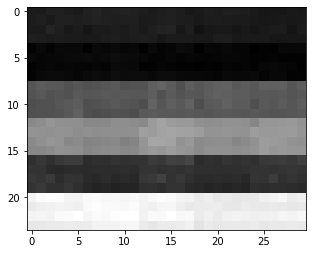

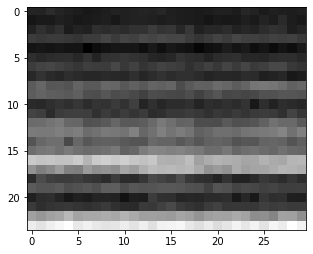

[7501/17000] loss_d: -0.383, loss_g: 0.926
[7502/17000] loss_d: -0.404, loss_g: 0.993
[7503/17000] loss_d: -0.424, loss_g: 0.944
[7504/17000] loss_d: -0.362, loss_g: 0.947
[7505/17000] loss_d: -0.381, loss_g: 0.972
[7506/17000] loss_d: -0.410, loss_g: 0.920
[7507/17000] loss_d: -0.412, loss_g: 0.933
[7508/17000] loss_d: -0.424, loss_g: 0.878
[7509/17000] loss_d: -0.403, loss_g: 0.903
[7510/17000] loss_d: -0.432, loss_g: 0.861
[7511/17000] loss_d: -0.384, loss_g: 0.833
[7512/17000] loss_d: -0.394, loss_g: 0.896
[7513/17000] loss_d: -0.420, loss_g: 0.829
[7514/17000] loss_d: -0.408, loss_g: 0.846
[7515/17000] loss_d: -0.400, loss_g: 0.903
[7516/17000] loss_d: -0.402, loss_g: 0.914
[7517/17000] loss_d: -0.437, loss_g: 0.870
[7518/17000] loss_d: -0.433, loss_g: 0.864
[7519/17000] loss_d: -0.446, loss_g: 0.867
[7520/17000] loss_d: -0.401, loss_g: 0.891
[7521/17000] loss_d: -0.410, loss_g: 0.857
[7522/17000] loss_d: -0.416, loss_g: 0.951
[7523/17000] loss_d: -0.404, loss_g: 0.935
[7524/17000

<Figure size 432x288 with 0 Axes>

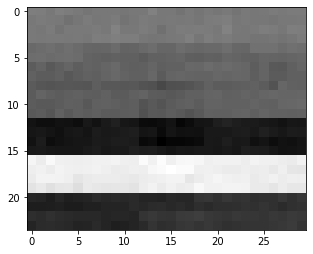

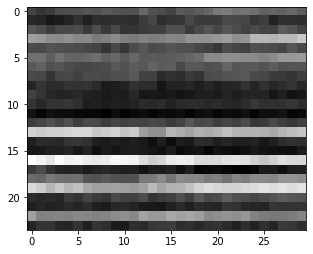

[7551/17000] loss_d: -0.379, loss_g: 1.029
[7552/17000] loss_d: -0.418, loss_g: 0.879
[7553/17000] loss_d: -0.390, loss_g: 0.879
[7554/17000] loss_d: -0.395, loss_g: 0.947
[7555/17000] loss_d: -0.431, loss_g: 0.943
[7556/17000] loss_d: -0.420, loss_g: 0.840
[7557/17000] loss_d: -0.399, loss_g: 0.925
[7558/17000] loss_d: -0.413, loss_g: 0.905
[7559/17000] loss_d: -0.405, loss_g: 1.026
[7560/17000] loss_d: -0.405, loss_g: 0.900
[7561/17000] loss_d: -0.357, loss_g: 0.818
[7562/17000] loss_d: -0.427, loss_g: 0.898
[7563/17000] loss_d: -0.391, loss_g: 0.923
[7564/17000] loss_d: -0.392, loss_g: 0.847
[7565/17000] loss_d: -0.415, loss_g: 0.853
[7566/17000] loss_d: -0.388, loss_g: 0.785
[7567/17000] loss_d: -0.420, loss_g: 0.854
[7568/17000] loss_d: -0.410, loss_g: 0.753
[7569/17000] loss_d: -0.389, loss_g: 0.798
[7570/17000] loss_d: -0.388, loss_g: 0.843
[7571/17000] loss_d: -0.448, loss_g: 0.750
[7572/17000] loss_d: -0.357, loss_g: 0.842
[7573/17000] loss_d: -0.443, loss_g: 0.838
[7574/17000

<Figure size 432x288 with 0 Axes>

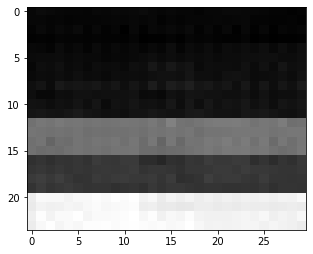

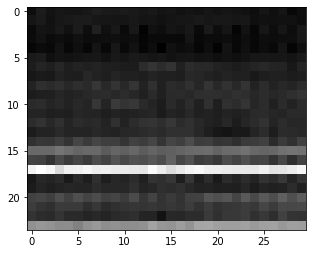

[7601/17000] loss_d: -0.473, loss_g: 0.761
[7602/17000] loss_d: -0.404, loss_g: 0.818
[7603/17000] loss_d: -0.400, loss_g: 0.911
[7604/17000] loss_d: -0.390, loss_g: 0.841
[7605/17000] loss_d: -0.385, loss_g: 0.888
[7606/17000] loss_d: -0.406, loss_g: 0.956
[7607/17000] loss_d: -0.404, loss_g: 0.865
[7608/17000] loss_d: -0.406, loss_g: 0.847
[7609/17000] loss_d: -0.444, loss_g: 0.782
[7610/17000] loss_d: -0.421, loss_g: 0.883
[7611/17000] loss_d: -0.414, loss_g: 0.923
[7612/17000] loss_d: -0.381, loss_g: 0.838
[7613/17000] loss_d: -0.402, loss_g: 0.876
[7614/17000] loss_d: -0.401, loss_g: 0.783
[7615/17000] loss_d: -0.404, loss_g: 0.816
[7616/17000] loss_d: -0.423, loss_g: 0.880
[7617/17000] loss_d: -0.407, loss_g: 0.848
[7618/17000] loss_d: -0.399, loss_g: 0.893
[7619/17000] loss_d: -0.413, loss_g: 0.951
[7620/17000] loss_d: -0.378, loss_g: 0.867
[7621/17000] loss_d: -0.408, loss_g: 1.006
[7622/17000] loss_d: -0.379, loss_g: 0.791
[7623/17000] loss_d: -0.416, loss_g: 0.886
[7624/17000

<Figure size 432x288 with 0 Axes>

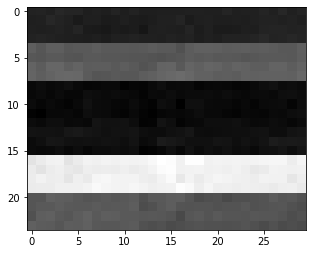

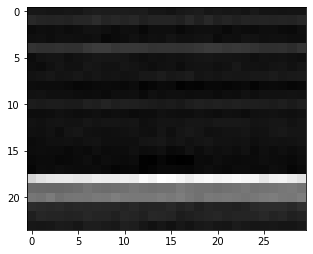

[7651/17000] loss_d: -0.392, loss_g: 0.855
[7652/17000] loss_d: -0.408, loss_g: 0.863
[7653/17000] loss_d: -0.423, loss_g: 0.816
[7654/17000] loss_d: -0.392, loss_g: 0.959
[7655/17000] loss_d: -0.408, loss_g: 0.909
[7656/17000] loss_d: -0.401, loss_g: 0.933
[7657/17000] loss_d: -0.429, loss_g: 0.849
[7658/17000] loss_d: -0.418, loss_g: 0.871
[7659/17000] loss_d: -0.393, loss_g: 0.890
[7660/17000] loss_d: -0.410, loss_g: 0.885
[7661/17000] loss_d: -0.449, loss_g: 0.889
[7662/17000] loss_d: -0.425, loss_g: 1.037
[7663/17000] loss_d: -0.425, loss_g: 0.934
[7664/17000] loss_d: -0.389, loss_g: 0.960
[7665/17000] loss_d: -0.410, loss_g: 0.946
[7666/17000] loss_d: -0.418, loss_g: 0.907
[7667/17000] loss_d: -0.374, loss_g: 0.991
[7668/17000] loss_d: -0.442, loss_g: 0.968
[7669/17000] loss_d: -0.421, loss_g: 1.118
[7670/17000] loss_d: -0.430, loss_g: 0.888
[7671/17000] loss_d: -0.406, loss_g: 0.861
[7672/17000] loss_d: -0.394, loss_g: 0.925
[7673/17000] loss_d: -0.407, loss_g: 0.938
[7674/17000

<Figure size 432x288 with 0 Axes>

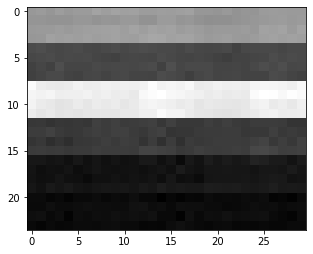

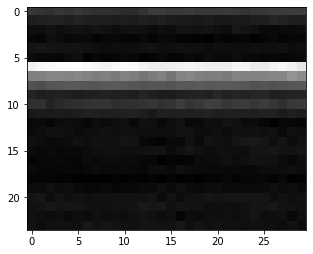

[7701/17000] loss_d: -0.411, loss_g: 0.836
[7702/17000] loss_d: -0.419, loss_g: 0.897
[7703/17000] loss_d: -0.407, loss_g: 0.884
[7704/17000] loss_d: -0.391, loss_g: 0.914
[7705/17000] loss_d: -0.369, loss_g: 0.828
[7706/17000] loss_d: -0.421, loss_g: 0.930
[7707/17000] loss_d: -0.431, loss_g: 0.877
[7708/17000] loss_d: -0.421, loss_g: 0.875
[7709/17000] loss_d: -0.396, loss_g: 0.856
[7710/17000] loss_d: -0.397, loss_g: 0.925
[7711/17000] loss_d: -0.429, loss_g: 0.873
[7712/17000] loss_d: -0.418, loss_g: 0.999
[7713/17000] loss_d: -0.395, loss_g: 0.935
[7714/17000] loss_d: -0.406, loss_g: 1.001
[7715/17000] loss_d: -0.437, loss_g: 0.907
[7716/17000] loss_d: -0.376, loss_g: 0.893
[7717/17000] loss_d: -0.411, loss_g: 0.814
[7718/17000] loss_d: -0.401, loss_g: 0.883
[7719/17000] loss_d: -0.396, loss_g: 0.912
[7720/17000] loss_d: -0.406, loss_g: 0.851
[7721/17000] loss_d: -0.405, loss_g: 0.867
[7722/17000] loss_d: -0.424, loss_g: 0.836
[7723/17000] loss_d: -0.459, loss_g: 0.768
[7724/17000

<Figure size 432x288 with 0 Axes>

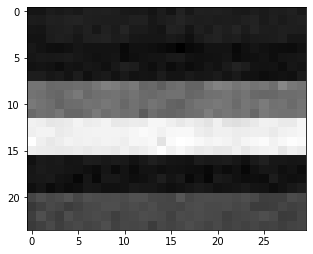

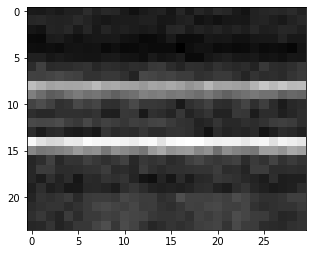

[7751/17000] loss_d: -0.417, loss_g: 0.809
[7752/17000] loss_d: -0.411, loss_g: 0.914
[7753/17000] loss_d: -0.394, loss_g: 0.838
[7754/17000] loss_d: -0.396, loss_g: 0.883
[7755/17000] loss_d: -0.413, loss_g: 0.846
[7756/17000] loss_d: -0.372, loss_g: 0.945
[7757/17000] loss_d: -0.433, loss_g: 1.000
[7758/17000] loss_d: -0.409, loss_g: 1.057
[7759/17000] loss_d: -0.414, loss_g: 0.879
[7760/17000] loss_d: -0.417, loss_g: 0.873
[7761/17000] loss_d: -0.412, loss_g: 0.999
[7762/17000] loss_d: -0.416, loss_g: 0.937
[7763/17000] loss_d: -0.399, loss_g: 0.938
[7764/17000] loss_d: -0.419, loss_g: 0.988
[7765/17000] loss_d: -0.406, loss_g: 0.906
[7766/17000] loss_d: -0.405, loss_g: 0.980
[7767/17000] loss_d: -0.425, loss_g: 0.919
[7768/17000] loss_d: -0.417, loss_g: 0.948
[7769/17000] loss_d: -0.418, loss_g: 1.002
[7770/17000] loss_d: -0.436, loss_g: 1.001
[7771/17000] loss_d: -0.404, loss_g: 1.038
[7772/17000] loss_d: -0.391, loss_g: 1.031
[7773/17000] loss_d: -0.423, loss_g: 1.071
[7774/17000

<Figure size 432x288 with 0 Axes>

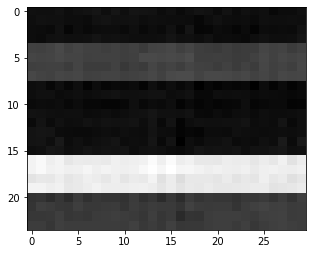

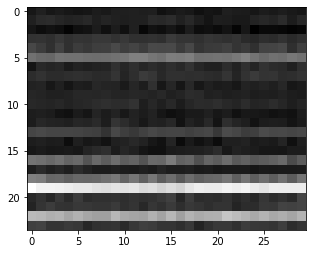

[7801/17000] loss_d: -0.397, loss_g: 1.006
[7802/17000] loss_d: -0.398, loss_g: 0.977
[7803/17000] loss_d: -0.409, loss_g: 0.866
[7804/17000] loss_d: -0.403, loss_g: 0.937
[7805/17000] loss_d: -0.445, loss_g: 0.959
[7806/17000] loss_d: -0.436, loss_g: 1.067
[7807/17000] loss_d: -0.423, loss_g: 0.991
[7808/17000] loss_d: -0.389, loss_g: 0.952
[7809/17000] loss_d: -0.382, loss_g: 0.927
[7810/17000] loss_d: -0.404, loss_g: 0.980
[7811/17000] loss_d: -0.438, loss_g: 1.023
[7812/17000] loss_d: -0.368, loss_g: 0.972
[7813/17000] loss_d: -0.415, loss_g: 0.991
[7814/17000] loss_d: -0.391, loss_g: 1.005
[7815/17000] loss_d: -0.423, loss_g: 1.059
[7816/17000] loss_d: -0.419, loss_g: 0.931
[7817/17000] loss_d: -0.401, loss_g: 0.929
[7818/17000] loss_d: -0.407, loss_g: 1.018
[7819/17000] loss_d: -0.430, loss_g: 0.988
[7820/17000] loss_d: -0.393, loss_g: 0.907
[7821/17000] loss_d: -0.399, loss_g: 0.989
[7822/17000] loss_d: -0.430, loss_g: 0.949
[7823/17000] loss_d: -0.404, loss_g: 0.946
[7824/17000

<Figure size 432x288 with 0 Axes>

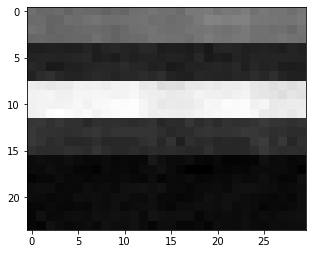

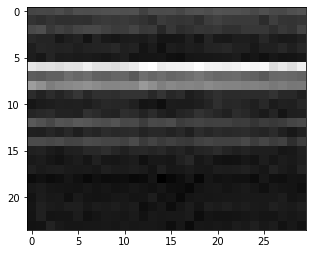

[7851/17000] loss_d: -0.356, loss_g: 0.867
[7852/17000] loss_d: -0.379, loss_g: 0.875
[7853/17000] loss_d: -0.389, loss_g: 0.917
[7854/17000] loss_d: -0.403, loss_g: 0.935
[7855/17000] loss_d: -0.425, loss_g: 0.931
[7856/17000] loss_d: -0.377, loss_g: 0.907
[7857/17000] loss_d: -0.401, loss_g: 0.930
[7858/17000] loss_d: -0.390, loss_g: 0.966
[7859/17000] loss_d: -0.410, loss_g: 0.970
[7860/17000] loss_d: -0.423, loss_g: 0.926
[7861/17000] loss_d: -0.393, loss_g: 0.800
[7862/17000] loss_d: -0.380, loss_g: 0.922
[7863/17000] loss_d: -0.406, loss_g: 0.951
[7864/17000] loss_d: -0.372, loss_g: 0.936
[7865/17000] loss_d: -0.440, loss_g: 0.922
[7866/17000] loss_d: -0.393, loss_g: 0.944
[7867/17000] loss_d: -0.409, loss_g: 0.955
[7868/17000] loss_d: -0.405, loss_g: 0.951
[7869/17000] loss_d: -0.381, loss_g: 0.879
[7870/17000] loss_d: -0.398, loss_g: 0.938
[7871/17000] loss_d: -0.397, loss_g: 0.932
[7872/17000] loss_d: -0.410, loss_g: 0.767
[7873/17000] loss_d: -0.391, loss_g: 0.949
[7874/17000

<Figure size 432x288 with 0 Axes>

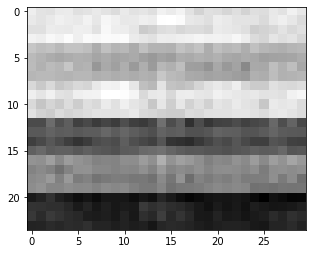

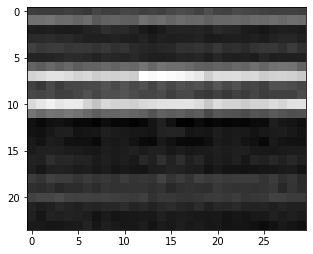

[7901/17000] loss_d: -0.357, loss_g: 0.951
[7902/17000] loss_d: -0.411, loss_g: 0.804
[7903/17000] loss_d: -0.392, loss_g: 0.831
[7904/17000] loss_d: -0.408, loss_g: 0.864
[7905/17000] loss_d: -0.414, loss_g: 0.857
[7906/17000] loss_d: -0.376, loss_g: 0.785
[7907/17000] loss_d: -0.421, loss_g: 0.788
[7908/17000] loss_d: -0.414, loss_g: 0.837
[7909/17000] loss_d: -0.357, loss_g: 0.864
[7910/17000] loss_d: -0.385, loss_g: 0.895
[7911/17000] loss_d: -0.427, loss_g: 0.895
[7912/17000] loss_d: -0.415, loss_g: 0.830
[7913/17000] loss_d: -0.402, loss_g: 0.842
[7914/17000] loss_d: -0.406, loss_g: 0.890
[7915/17000] loss_d: -0.417, loss_g: 0.909
[7916/17000] loss_d: -0.396, loss_g: 0.904
[7917/17000] loss_d: -0.410, loss_g: 0.982
[7918/17000] loss_d: -0.422, loss_g: 0.871
[7919/17000] loss_d: -0.424, loss_g: 0.897
[7920/17000] loss_d: -0.407, loss_g: 0.900
[7921/17000] loss_d: -0.412, loss_g: 0.915
[7922/17000] loss_d: -0.411, loss_g: 0.906
[7923/17000] loss_d: -0.387, loss_g: 0.935
[7924/17000

<Figure size 432x288 with 0 Axes>

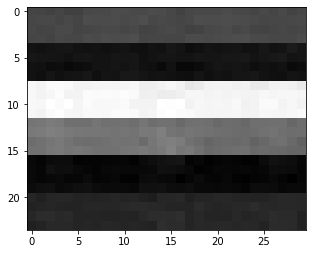

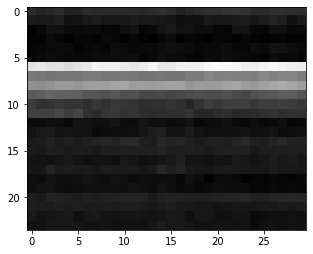

[7951/17000] loss_d: -0.412, loss_g: 0.816
[7952/17000] loss_d: -0.423, loss_g: 0.887
[7953/17000] loss_d: -0.388, loss_g: 0.917
[7954/17000] loss_d: -0.407, loss_g: 0.823
[7955/17000] loss_d: -0.422, loss_g: 0.830
[7956/17000] loss_d: -0.419, loss_g: 0.883
[7957/17000] loss_d: -0.397, loss_g: 0.811
[7958/17000] loss_d: -0.396, loss_g: 0.874
[7959/17000] loss_d: -0.407, loss_g: 0.754
[7960/17000] loss_d: -0.422, loss_g: 0.830
[7961/17000] loss_d: -0.403, loss_g: 0.740
[7962/17000] loss_d: -0.460, loss_g: 0.856
[7963/17000] loss_d: -0.422, loss_g: 0.937
[7964/17000] loss_d: -0.376, loss_g: 0.843
[7965/17000] loss_d: -0.425, loss_g: 0.925
[7966/17000] loss_d: -0.375, loss_g: 0.803
[7967/17000] loss_d: -0.398, loss_g: 0.786
[7968/17000] loss_d: -0.423, loss_g: 0.792
[7969/17000] loss_d: -0.439, loss_g: 0.830
[7970/17000] loss_d: -0.430, loss_g: 0.777
[7971/17000] loss_d: -0.387, loss_g: 0.816
[7972/17000] loss_d: -0.404, loss_g: 0.914
[7973/17000] loss_d: -0.412, loss_g: 0.856
[7974/17000

<Figure size 432x288 with 0 Axes>

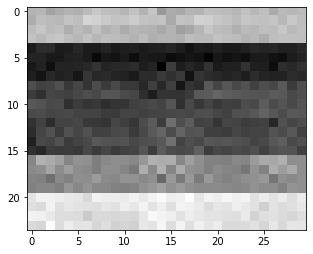

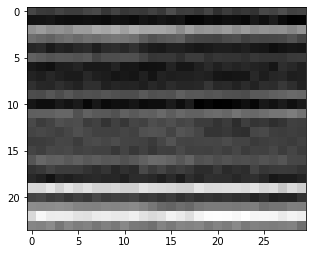

[8001/17000] loss_d: -0.402, loss_g: 1.000
[8002/17000] loss_d: -0.394, loss_g: 0.961
[8003/17000] loss_d: -0.382, loss_g: 0.860
[8004/17000] loss_d: -0.401, loss_g: 1.002
[8005/17000] loss_d: -0.429, loss_g: 0.924
[8006/17000] loss_d: -0.406, loss_g: 0.871
[8007/17000] loss_d: -0.429, loss_g: 0.869
[8008/17000] loss_d: -0.445, loss_g: 0.951
[8009/17000] loss_d: -0.368, loss_g: 0.929
[8010/17000] loss_d: -0.424, loss_g: 0.891
[8011/17000] loss_d: -0.393, loss_g: 0.914
[8012/17000] loss_d: -0.430, loss_g: 0.844
[8013/17000] loss_d: -0.413, loss_g: 0.844
[8014/17000] loss_d: -0.379, loss_g: 0.903
[8015/17000] loss_d: -0.446, loss_g: 1.024
[8016/17000] loss_d: -0.398, loss_g: 0.985
[8017/17000] loss_d: -0.383, loss_g: 1.019
[8018/17000] loss_d: -0.394, loss_g: 0.921
[8019/17000] loss_d: -0.415, loss_g: 0.930
[8020/17000] loss_d: -0.403, loss_g: 1.104
[8021/17000] loss_d: -0.437, loss_g: 0.904
[8022/17000] loss_d: -0.417, loss_g: 0.877
[8023/17000] loss_d: -0.440, loss_g: 0.948
[8024/17000

<Figure size 432x288 with 0 Axes>

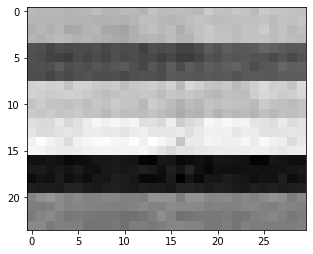

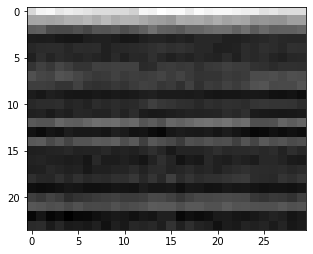

[8051/17000] loss_d: -0.422, loss_g: 0.972
[8052/17000] loss_d: -0.419, loss_g: 0.925
[8053/17000] loss_d: -0.391, loss_g: 0.816
[8054/17000] loss_d: -0.408, loss_g: 0.894
[8055/17000] loss_d: -0.418, loss_g: 1.017
[8056/17000] loss_d: -0.402, loss_g: 0.896
[8057/17000] loss_d: -0.401, loss_g: 0.962
[8058/17000] loss_d: -0.430, loss_g: 0.932
[8059/17000] loss_d: -0.368, loss_g: 0.972
[8060/17000] loss_d: -0.410, loss_g: 0.835
[8061/17000] loss_d: -0.339, loss_g: 0.901
[8062/17000] loss_d: -0.367, loss_g: 0.866
[8063/17000] loss_d: -0.373, loss_g: 1.127
[8064/17000] loss_d: -0.428, loss_g: 0.993
[8065/17000] loss_d: -0.407, loss_g: 0.994
[8066/17000] loss_d: -0.384, loss_g: 0.915
[8067/17000] loss_d: -0.401, loss_g: 1.036
[8068/17000] loss_d: -0.430, loss_g: 0.912
[8069/17000] loss_d: -0.401, loss_g: 0.950
[8070/17000] loss_d: -0.404, loss_g: 0.917
[8071/17000] loss_d: -0.410, loss_g: 0.918
[8072/17000] loss_d: -0.415, loss_g: 0.992
[8073/17000] loss_d: -0.435, loss_g: 0.977
[8074/17000

<Figure size 432x288 with 0 Axes>

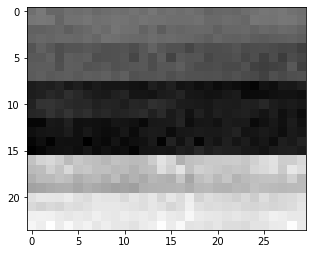

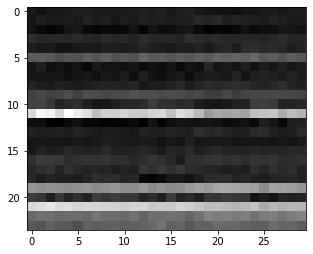

[8101/17000] loss_d: -0.387, loss_g: 0.950
[8102/17000] loss_d: -0.413, loss_g: 1.024
[8103/17000] loss_d: -0.398, loss_g: 0.920
[8104/17000] loss_d: -0.408, loss_g: 0.962
[8105/17000] loss_d: -0.412, loss_g: 0.949
[8106/17000] loss_d: -0.450, loss_g: 1.042
[8107/17000] loss_d: -0.413, loss_g: 1.018
[8108/17000] loss_d: -0.391, loss_g: 0.971
[8109/17000] loss_d: -0.381, loss_g: 1.090
[8110/17000] loss_d: -0.408, loss_g: 0.912
[8111/17000] loss_d: -0.440, loss_g: 1.081
[8112/17000] loss_d: -0.423, loss_g: 0.856
[8113/17000] loss_d: -0.374, loss_g: 0.894
[8114/17000] loss_d: -0.380, loss_g: 0.936
[8115/17000] loss_d: -0.405, loss_g: 1.009
[8116/17000] loss_d: -0.405, loss_g: 0.992
[8117/17000] loss_d: -0.426, loss_g: 1.130
[8118/17000] loss_d: -0.408, loss_g: 0.946
[8119/17000] loss_d: -0.390, loss_g: 1.094
[8120/17000] loss_d: -0.428, loss_g: 1.066
[8121/17000] loss_d: -0.392, loss_g: 0.939
[8122/17000] loss_d: -0.405, loss_g: 0.893
[8123/17000] loss_d: -0.430, loss_g: 0.989
[8124/17000

<Figure size 432x288 with 0 Axes>

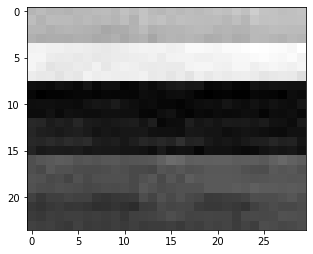

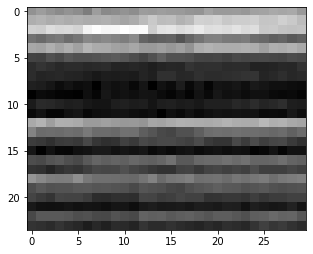

[8151/17000] loss_d: -0.437, loss_g: 0.960
[8152/17000] loss_d: -0.397, loss_g: 0.900
[8153/17000] loss_d: -0.389, loss_g: 0.879
[8154/17000] loss_d: -0.415, loss_g: 0.869
[8155/17000] loss_d: -0.403, loss_g: 0.950
[8156/17000] loss_d: -0.402, loss_g: 0.810
[8157/17000] loss_d: -0.426, loss_g: 0.940
[8158/17000] loss_d: -0.434, loss_g: 0.918
[8159/17000] loss_d: -0.375, loss_g: 0.875
[8160/17000] loss_d: -0.413, loss_g: 0.874
[8161/17000] loss_d: -0.398, loss_g: 0.905
[8162/17000] loss_d: -0.413, loss_g: 0.941
[8163/17000] loss_d: -0.417, loss_g: 0.939
[8164/17000] loss_d: -0.378, loss_g: 0.871
[8165/17000] loss_d: -0.384, loss_g: 0.889
[8166/17000] loss_d: -0.413, loss_g: 0.864
[8167/17000] loss_d: -0.418, loss_g: 0.953
[8168/17000] loss_d: -0.417, loss_g: 0.937
[8169/17000] loss_d: -0.402, loss_g: 0.911
[8170/17000] loss_d: -0.404, loss_g: 0.970
[8171/17000] loss_d: -0.439, loss_g: 0.966
[8172/17000] loss_d: -0.380, loss_g: 0.969
[8173/17000] loss_d: -0.423, loss_g: 0.951
[8174/17000

<Figure size 432x288 with 0 Axes>

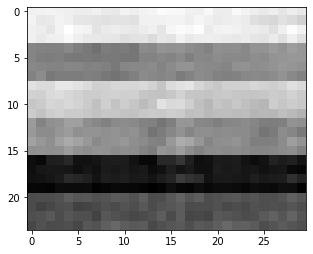

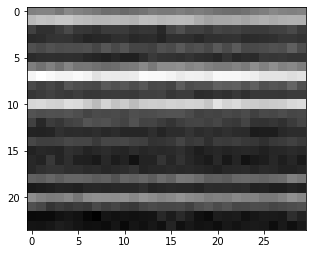

[8201/17000] loss_d: -0.417, loss_g: 0.947
[8202/17000] loss_d: -0.411, loss_g: 0.945
[8203/17000] loss_d: -0.413, loss_g: 0.886
[8204/17000] loss_d: -0.418, loss_g: 0.936
[8205/17000] loss_d: -0.411, loss_g: 0.984
[8206/17000] loss_d: -0.434, loss_g: 0.906
[8207/17000] loss_d: -0.420, loss_g: 0.916
[8208/17000] loss_d: -0.384, loss_g: 0.913
[8209/17000] loss_d: -0.390, loss_g: 0.964
[8210/17000] loss_d: -0.378, loss_g: 0.907
[8211/17000] loss_d: -0.420, loss_g: 0.971
[8212/17000] loss_d: -0.434, loss_g: 0.982
[8213/17000] loss_d: -0.418, loss_g: 0.914
[8214/17000] loss_d: -0.399, loss_g: 0.908
[8215/17000] loss_d: -0.418, loss_g: 0.917
[8216/17000] loss_d: -0.370, loss_g: 0.989
[8217/17000] loss_d: -0.411, loss_g: 0.941
[8218/17000] loss_d: -0.415, loss_g: 0.844
[8219/17000] loss_d: -0.411, loss_g: 0.899
[8220/17000] loss_d: -0.411, loss_g: 0.833
[8221/17000] loss_d: -0.424, loss_g: 0.967
[8222/17000] loss_d: -0.422, loss_g: 0.889
[8223/17000] loss_d: -0.417, loss_g: 0.946
[8224/17000

<Figure size 432x288 with 0 Axes>

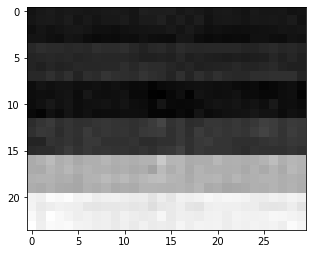

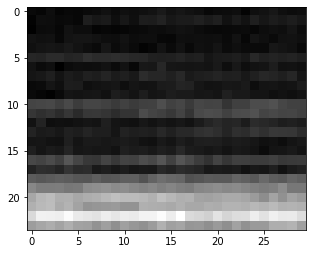

[8251/17000] loss_d: -0.400, loss_g: 0.883
[8252/17000] loss_d: -0.394, loss_g: 0.869
[8253/17000] loss_d: -0.433, loss_g: 0.978
[8254/17000] loss_d: -0.418, loss_g: 0.952
[8255/17000] loss_d: -0.428, loss_g: 0.894
[8256/17000] loss_d: -0.381, loss_g: 0.950
[8257/17000] loss_d: -0.411, loss_g: 0.891
[8258/17000] loss_d: -0.432, loss_g: 0.848
[8259/17000] loss_d: -0.432, loss_g: 0.929
[8260/17000] loss_d: -0.410, loss_g: 0.896
[8261/17000] loss_d: -0.414, loss_g: 0.911
[8262/17000] loss_d: -0.398, loss_g: 1.018
[8263/17000] loss_d: -0.414, loss_g: 0.810
[8264/17000] loss_d: -0.408, loss_g: 0.936
[8265/17000] loss_d: -0.412, loss_g: 0.909
[8266/17000] loss_d: -0.428, loss_g: 0.996
[8267/17000] loss_d: -0.453, loss_g: 0.944
[8268/17000] loss_d: -0.372, loss_g: 0.904
[8269/17000] loss_d: -0.417, loss_g: 0.922
[8270/17000] loss_d: -0.412, loss_g: 1.023
[8271/17000] loss_d: -0.410, loss_g: 0.953
[8272/17000] loss_d: -0.374, loss_g: 0.884
[8273/17000] loss_d: -0.392, loss_g: 0.899
[8274/17000

<Figure size 432x288 with 0 Axes>

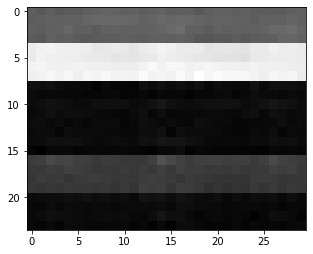

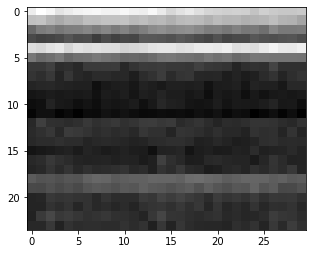

[8301/17000] loss_d: -0.414, loss_g: 0.947
[8302/17000] loss_d: -0.427, loss_g: 0.866
[8303/17000] loss_d: -0.390, loss_g: 1.013
[8304/17000] loss_d: -0.394, loss_g: 0.841
[8305/17000] loss_d: -0.423, loss_g: 0.934
[8306/17000] loss_d: -0.400, loss_g: 0.864
[8307/17000] loss_d: -0.414, loss_g: 0.923
[8308/17000] loss_d: -0.413, loss_g: 0.826
[8309/17000] loss_d: -0.410, loss_g: 0.919
[8310/17000] loss_d: -0.417, loss_g: 0.931
[8311/17000] loss_d: -0.420, loss_g: 0.870
[8312/17000] loss_d: -0.409, loss_g: 0.930
[8313/17000] loss_d: -0.413, loss_g: 0.928
[8314/17000] loss_d: -0.389, loss_g: 0.923
[8315/17000] loss_d: -0.415, loss_g: 0.982
[8316/17000] loss_d: -0.406, loss_g: 0.893
[8317/17000] loss_d: -0.418, loss_g: 0.873
[8318/17000] loss_d: -0.421, loss_g: 0.916
[8319/17000] loss_d: -0.396, loss_g: 0.885
[8320/17000] loss_d: -0.389, loss_g: 0.850
[8321/17000] loss_d: -0.410, loss_g: 0.936
[8322/17000] loss_d: -0.378, loss_g: 0.884
[8323/17000] loss_d: -0.434, loss_g: 0.923
[8324/17000

<Figure size 432x288 with 0 Axes>

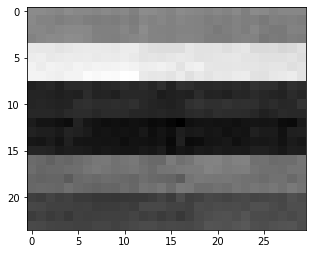

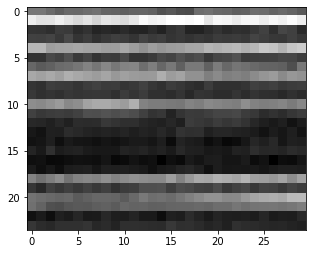

[8351/17000] loss_d: -0.446, loss_g: 0.870
[8352/17000] loss_d: -0.381, loss_g: 0.918
[8353/17000] loss_d: -0.416, loss_g: 0.875
[8354/17000] loss_d: -0.405, loss_g: 0.897
[8355/17000] loss_d: -0.416, loss_g: 0.939
[8356/17000] loss_d: -0.404, loss_g: 0.871
[8357/17000] loss_d: -0.408, loss_g: 0.873
[8358/17000] loss_d: -0.441, loss_g: 0.895
[8359/17000] loss_d: -0.429, loss_g: 0.919
[8360/17000] loss_d: -0.391, loss_g: 1.003
[8361/17000] loss_d: -0.417, loss_g: 0.885
[8362/17000] loss_d: -0.423, loss_g: 0.931
[8363/17000] loss_d: -0.399, loss_g: 0.831
[8364/17000] loss_d: -0.442, loss_g: 0.857
[8365/17000] loss_d: -0.411, loss_g: 0.822
[8366/17000] loss_d: -0.413, loss_g: 0.866
[8367/17000] loss_d: -0.399, loss_g: 0.876
[8368/17000] loss_d: -0.429, loss_g: 0.882
[8369/17000] loss_d: -0.387, loss_g: 0.910
[8370/17000] loss_d: -0.433, loss_g: 0.884
[8371/17000] loss_d: -0.377, loss_g: 0.862
[8372/17000] loss_d: -0.403, loss_g: 0.812
[8373/17000] loss_d: -0.409, loss_g: 0.904
[8374/17000

<Figure size 432x288 with 0 Axes>

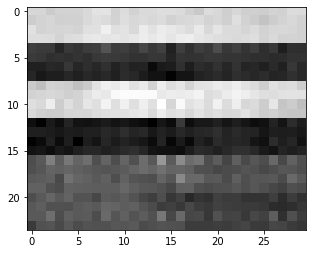

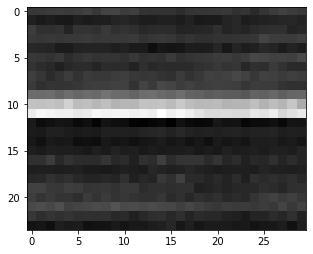

[8401/17000] loss_d: -0.435, loss_g: 0.771
[8402/17000] loss_d: -0.431, loss_g: 0.884
[8403/17000] loss_d: -0.409, loss_g: 0.898
[8404/17000] loss_d: -0.436, loss_g: 1.081
[8405/17000] loss_d: -0.392, loss_g: 1.031
[8406/17000] loss_d: -0.422, loss_g: 1.010
[8407/17000] loss_d: -0.397, loss_g: 0.923
[8408/17000] loss_d: -0.405, loss_g: 0.916
[8409/17000] loss_d: -0.390, loss_g: 0.931
[8410/17000] loss_d: -0.422, loss_g: 0.943
[8411/17000] loss_d: -0.392, loss_g: 0.945
[8412/17000] loss_d: -0.379, loss_g: 0.933
[8413/17000] loss_d: -0.402, loss_g: 0.981
[8414/17000] loss_d: -0.418, loss_g: 1.000
[8415/17000] loss_d: -0.449, loss_g: 0.951
[8416/17000] loss_d: -0.394, loss_g: 1.094
[8417/17000] loss_d: -0.357, loss_g: 0.965
[8418/17000] loss_d: -0.425, loss_g: 0.980
[8419/17000] loss_d: -0.407, loss_g: 0.981
[8420/17000] loss_d: -0.423, loss_g: 0.971
[8421/17000] loss_d: -0.450, loss_g: 0.970
[8422/17000] loss_d: -0.392, loss_g: 1.071
[8423/17000] loss_d: -0.442, loss_g: 0.957
[8424/17000

<Figure size 432x288 with 0 Axes>

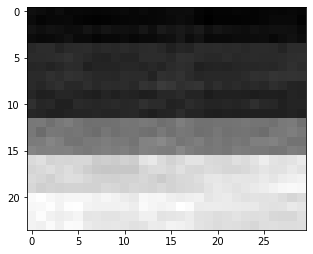

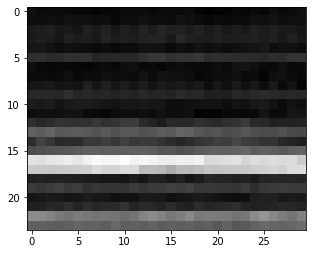

[8451/17000] loss_d: -0.424, loss_g: 0.951
[8452/17000] loss_d: -0.429, loss_g: 1.021
[8453/17000] loss_d: -0.386, loss_g: 0.951
[8454/17000] loss_d: -0.419, loss_g: 0.966
[8455/17000] loss_d: -0.412, loss_g: 1.015
[8456/17000] loss_d: -0.407, loss_g: 0.954
[8457/17000] loss_d: -0.423, loss_g: 0.961
[8458/17000] loss_d: -0.390, loss_g: 1.095
[8459/17000] loss_d: -0.386, loss_g: 1.022
[8460/17000] loss_d: -0.429, loss_g: 1.031
[8461/17000] loss_d: -0.411, loss_g: 0.893
[8462/17000] loss_d: -0.404, loss_g: 0.900
[8463/17000] loss_d: -0.400, loss_g: 0.988
[8464/17000] loss_d: -0.402, loss_g: 1.015
[8465/17000] loss_d: -0.367, loss_g: 1.083
[8466/17000] loss_d: -0.423, loss_g: 1.030
[8467/17000] loss_d: -0.418, loss_g: 1.004
[8468/17000] loss_d: -0.424, loss_g: 1.170
[8469/17000] loss_d: -0.431, loss_g: 1.065
[8470/17000] loss_d: -0.411, loss_g: 0.986
[8471/17000] loss_d: -0.414, loss_g: 0.954
[8472/17000] loss_d: -0.428, loss_g: 0.995
[8473/17000] loss_d: -0.430, loss_g: 0.814
[8474/17000

<Figure size 432x288 with 0 Axes>

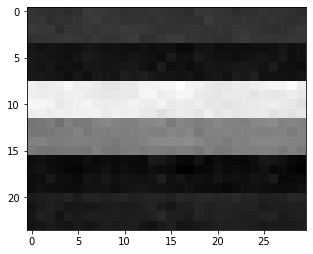

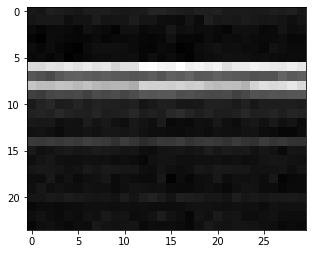

[8501/17000] loss_d: -0.446, loss_g: 0.971
[8502/17000] loss_d: -0.415, loss_g: 0.877
[8503/17000] loss_d: -0.366, loss_g: 0.868
[8504/17000] loss_d: -0.432, loss_g: 0.838
[8505/17000] loss_d: -0.418, loss_g: 1.025
[8506/17000] loss_d: -0.415, loss_g: 1.044
[8507/17000] loss_d: -0.433, loss_g: 1.069
[8508/17000] loss_d: -0.387, loss_g: 0.927
[8509/17000] loss_d: -0.421, loss_g: 0.968
[8510/17000] loss_d: -0.411, loss_g: 0.990
[8511/17000] loss_d: -0.348, loss_g: 0.929
[8512/17000] loss_d: -0.421, loss_g: 0.968
[8513/17000] loss_d: -0.425, loss_g: 1.010
[8514/17000] loss_d: -0.372, loss_g: 0.909
[8515/17000] loss_d: -0.420, loss_g: 0.918
[8516/17000] loss_d: -0.405, loss_g: 0.953
[8517/17000] loss_d: -0.438, loss_g: 0.949
[8518/17000] loss_d: -0.392, loss_g: 0.861
[8519/17000] loss_d: -0.422, loss_g: 0.974
[8520/17000] loss_d: -0.420, loss_g: 1.040
[8521/17000] loss_d: -0.414, loss_g: 0.954
[8522/17000] loss_d: -0.409, loss_g: 0.908
[8523/17000] loss_d: -0.436, loss_g: 0.807
[8524/17000

<Figure size 432x288 with 0 Axes>

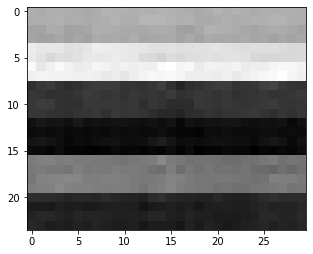

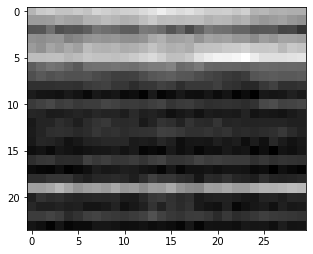

[8551/17000] loss_d: -0.379, loss_g: 0.865
[8552/17000] loss_d: -0.405, loss_g: 0.908
[8553/17000] loss_d: -0.403, loss_g: 0.918
[8554/17000] loss_d: -0.401, loss_g: 0.943
[8555/17000] loss_d: -0.407, loss_g: 0.879
[8556/17000] loss_d: -0.410, loss_g: 0.879
[8557/17000] loss_d: -0.386, loss_g: 0.854
[8558/17000] loss_d: -0.399, loss_g: 0.916
[8559/17000] loss_d: -0.432, loss_g: 0.891
[8560/17000] loss_d: -0.410, loss_g: 0.932
[8561/17000] loss_d: -0.384, loss_g: 0.938
[8562/17000] loss_d: -0.439, loss_g: 0.952
[8563/17000] loss_d: -0.385, loss_g: 0.849
[8564/17000] loss_d: -0.444, loss_g: 0.842
[8565/17000] loss_d: -0.389, loss_g: 0.910
[8566/17000] loss_d: -0.381, loss_g: 0.871
[8567/17000] loss_d: -0.388, loss_g: 0.928
[8568/17000] loss_d: -0.420, loss_g: 0.803
[8569/17000] loss_d: -0.419, loss_g: 0.820
[8570/17000] loss_d: -0.416, loss_g: 0.896
[8571/17000] loss_d: -0.413, loss_g: 0.884
[8572/17000] loss_d: -0.378, loss_g: 0.854
[8573/17000] loss_d: -0.431, loss_g: 0.902
[8574/17000

<Figure size 432x288 with 0 Axes>

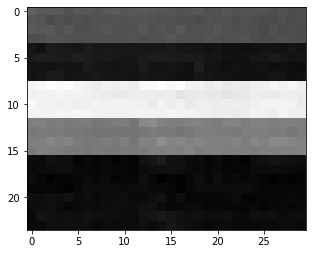

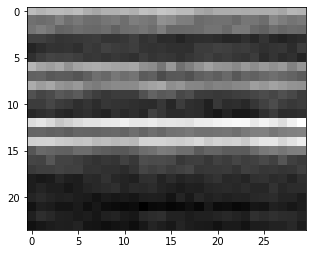

[8601/17000] loss_d: -0.421, loss_g: 0.903
[8602/17000] loss_d: -0.387, loss_g: 0.900
[8603/17000] loss_d: -0.393, loss_g: 0.940
[8604/17000] loss_d: -0.437, loss_g: 0.830
[8605/17000] loss_d: -0.431, loss_g: 0.898
[8606/17000] loss_d: -0.408, loss_g: 0.898
[8607/17000] loss_d: -0.402, loss_g: 0.871
[8608/17000] loss_d: -0.392, loss_g: 0.889
[8609/17000] loss_d: -0.384, loss_g: 0.944
[8610/17000] loss_d: -0.413, loss_g: 0.970
[8611/17000] loss_d: -0.422, loss_g: 0.923
[8612/17000] loss_d: -0.417, loss_g: 0.860
[8613/17000] loss_d: -0.369, loss_g: 0.900
[8614/17000] loss_d: -0.399, loss_g: 0.866
[8615/17000] loss_d: -0.396, loss_g: 0.886
[8616/17000] loss_d: -0.378, loss_g: 0.910
[8617/17000] loss_d: -0.390, loss_g: 0.969
[8618/17000] loss_d: -0.394, loss_g: 0.881
[8619/17000] loss_d: -0.381, loss_g: 0.891
[8620/17000] loss_d: -0.413, loss_g: 0.980
[8621/17000] loss_d: -0.427, loss_g: 0.837
[8622/17000] loss_d: -0.421, loss_g: 0.834
[8623/17000] loss_d: -0.411, loss_g: 0.934
[8624/17000

<Figure size 432x288 with 0 Axes>

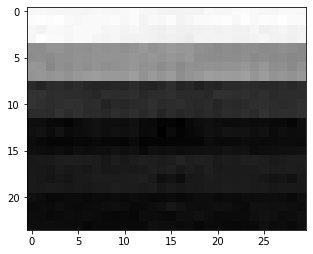

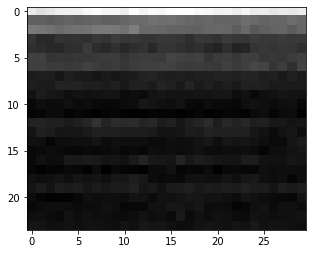

[8651/17000] loss_d: -0.372, loss_g: 0.905
[8652/17000] loss_d: -0.374, loss_g: 0.945
[8653/17000] loss_d: -0.387, loss_g: 0.827
[8654/17000] loss_d: -0.380, loss_g: 0.845
[8655/17000] loss_d: -0.394, loss_g: 0.877
[8656/17000] loss_d: -0.407, loss_g: 1.069
[8657/17000] loss_d: -0.428, loss_g: 0.821
[8658/17000] loss_d: -0.391, loss_g: 0.842
[8659/17000] loss_d: -0.442, loss_g: 0.988
[8660/17000] loss_d: -0.411, loss_g: 0.837
[8661/17000] loss_d: -0.371, loss_g: 0.929
[8662/17000] loss_d: -0.388, loss_g: 0.938
[8663/17000] loss_d: -0.384, loss_g: 0.864
[8664/17000] loss_d: -0.399, loss_g: 0.928
[8665/17000] loss_d: -0.385, loss_g: 0.895
[8666/17000] loss_d: -0.429, loss_g: 0.878
[8667/17000] loss_d: -0.362, loss_g: 0.856
[8668/17000] loss_d: -0.419, loss_g: 0.773
[8669/17000] loss_d: -0.383, loss_g: 0.756
[8670/17000] loss_d: -0.394, loss_g: 0.893
[8671/17000] loss_d: -0.418, loss_g: 0.810
[8672/17000] loss_d: -0.380, loss_g: 0.854
[8673/17000] loss_d: -0.425, loss_g: 0.873
[8674/17000

<Figure size 432x288 with 0 Axes>

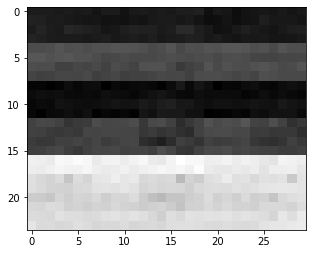

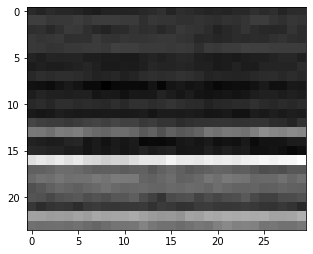

[8701/17000] loss_d: -0.389, loss_g: 0.832
[8702/17000] loss_d: -0.419, loss_g: 0.778
[8703/17000] loss_d: -0.396, loss_g: 0.862
[8704/17000] loss_d: -0.346, loss_g: 0.824
[8705/17000] loss_d: -0.394, loss_g: 0.819
[8706/17000] loss_d: -0.420, loss_g: 0.900
[8707/17000] loss_d: -0.450, loss_g: 0.838
[8708/17000] loss_d: -0.410, loss_g: 0.893
[8709/17000] loss_d: -0.374, loss_g: 0.876
[8710/17000] loss_d: -0.401, loss_g: 0.869
[8711/17000] loss_d: -0.380, loss_g: 0.923
[8712/17000] loss_d: -0.392, loss_g: 0.805
[8713/17000] loss_d: -0.412, loss_g: 0.877
[8714/17000] loss_d: -0.391, loss_g: 0.807
[8715/17000] loss_d: -0.407, loss_g: 0.839
[8716/17000] loss_d: -0.417, loss_g: 0.890
[8717/17000] loss_d: -0.362, loss_g: 0.885
[8718/17000] loss_d: -0.427, loss_g: 0.941
[8719/17000] loss_d: -0.408, loss_g: 0.859
[8720/17000] loss_d: -0.420, loss_g: 0.857
[8721/17000] loss_d: -0.403, loss_g: 0.913
[8722/17000] loss_d: -0.431, loss_g: 0.836
[8723/17000] loss_d: -0.414, loss_g: 0.860
[8724/17000

<Figure size 432x288 with 0 Axes>

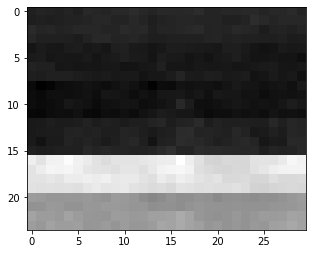

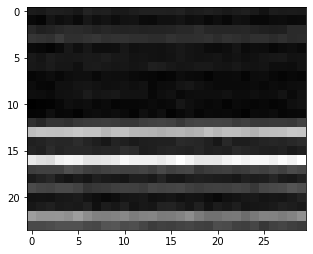

[8751/17000] loss_d: -0.399, loss_g: 0.840
[8752/17000] loss_d: -0.383, loss_g: 0.838
[8753/17000] loss_d: -0.409, loss_g: 0.981
[8754/17000] loss_d: -0.410, loss_g: 0.867
[8755/17000] loss_d: -0.423, loss_g: 0.857
[8756/17000] loss_d: -0.381, loss_g: 0.870
[8757/17000] loss_d: -0.402, loss_g: 0.892
[8758/17000] loss_d: -0.401, loss_g: 0.842
[8759/17000] loss_d: -0.403, loss_g: 0.873
[8760/17000] loss_d: -0.398, loss_g: 0.896
[8761/17000] loss_d: -0.415, loss_g: 0.872
[8762/17000] loss_d: -0.370, loss_g: 0.934
[8763/17000] loss_d: -0.368, loss_g: 0.885
[8764/17000] loss_d: -0.414, loss_g: 0.891
[8765/17000] loss_d: -0.401, loss_g: 0.744
[8766/17000] loss_d: -0.427, loss_g: 0.792
[8767/17000] loss_d: -0.407, loss_g: 0.887
[8768/17000] loss_d: -0.407, loss_g: 0.879
[8769/17000] loss_d: -0.430, loss_g: 0.904
[8770/17000] loss_d: -0.409, loss_g: 0.839
[8771/17000] loss_d: -0.454, loss_g: 0.843
[8772/17000] loss_d: -0.384, loss_g: 0.824
[8773/17000] loss_d: -0.422, loss_g: 0.785
[8774/17000

<Figure size 432x288 with 0 Axes>

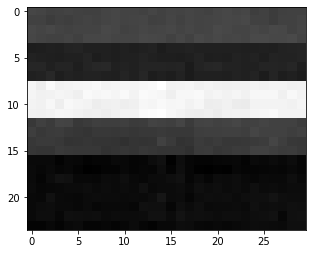

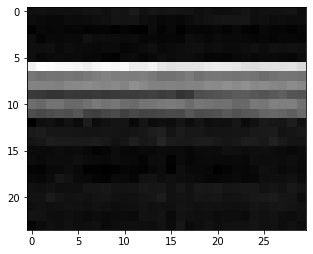

[8801/17000] loss_d: -0.441, loss_g: 0.833
[8802/17000] loss_d: -0.390, loss_g: 0.890
[8803/17000] loss_d: -0.415, loss_g: 0.897
[8804/17000] loss_d: -0.398, loss_g: 0.847
[8805/17000] loss_d: -0.398, loss_g: 0.828
[8806/17000] loss_d: -0.417, loss_g: 0.873
[8807/17000] loss_d: -0.440, loss_g: 0.862
[8808/17000] loss_d: -0.429, loss_g: 0.885
[8809/17000] loss_d: -0.375, loss_g: 0.902
[8810/17000] loss_d: -0.365, loss_g: 0.929
[8811/17000] loss_d: -0.381, loss_g: 0.929
[8812/17000] loss_d: -0.408, loss_g: 0.934
[8813/17000] loss_d: -0.409, loss_g: 0.865
[8814/17000] loss_d: -0.429, loss_g: 0.872
[8815/17000] loss_d: -0.406, loss_g: 0.943
[8816/17000] loss_d: -0.377, loss_g: 0.840
[8817/17000] loss_d: -0.401, loss_g: 0.856
[8818/17000] loss_d: -0.377, loss_g: 0.866
[8819/17000] loss_d: -0.408, loss_g: 0.847
[8820/17000] loss_d: -0.401, loss_g: 0.759
[8821/17000] loss_d: -0.381, loss_g: 0.986
[8822/17000] loss_d: -0.406, loss_g: 0.898
[8823/17000] loss_d: -0.415, loss_g: 0.837
[8824/17000

<Figure size 432x288 with 0 Axes>

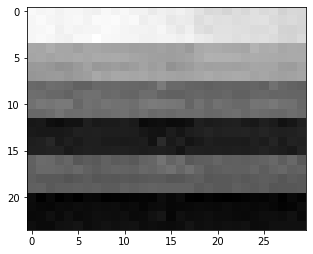

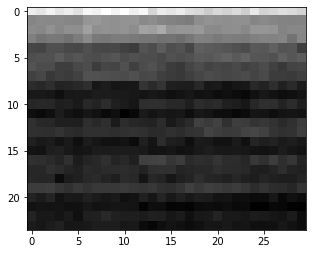

[8851/17000] loss_d: -0.404, loss_g: 0.859
[8852/17000] loss_d: -0.427, loss_g: 0.958
[8853/17000] loss_d: -0.443, loss_g: 1.061
[8854/17000] loss_d: -0.394, loss_g: 0.962
[8855/17000] loss_d: -0.414, loss_g: 0.825
[8856/17000] loss_d: -0.364, loss_g: 0.841
[8857/17000] loss_d: -0.364, loss_g: 0.827
[8858/17000] loss_d: -0.401, loss_g: 0.861
[8859/17000] loss_d: -0.411, loss_g: 0.855
[8860/17000] loss_d: -0.427, loss_g: 0.857
[8861/17000] loss_d: -0.390, loss_g: 0.826
[8862/17000] loss_d: -0.406, loss_g: 0.868
[8863/17000] loss_d: -0.401, loss_g: 0.914
[8864/17000] loss_d: -0.427, loss_g: 0.946
[8865/17000] loss_d: -0.387, loss_g: 0.911
[8866/17000] loss_d: -0.376, loss_g: 0.892
[8867/17000] loss_d: -0.393, loss_g: 0.873
[8868/17000] loss_d: -0.385, loss_g: 0.892
[8869/17000] loss_d: -0.414, loss_g: 0.813
[8870/17000] loss_d: -0.398, loss_g: 0.854
[8871/17000] loss_d: -0.407, loss_g: 0.825
[8872/17000] loss_d: -0.393, loss_g: 0.854
[8873/17000] loss_d: -0.412, loss_g: 0.846
[8874/17000

<Figure size 432x288 with 0 Axes>

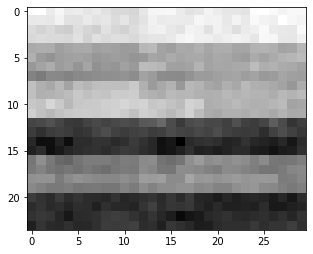

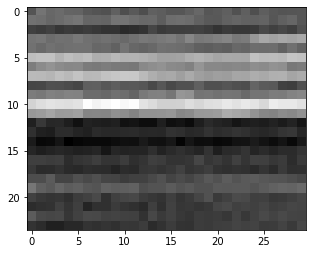

[8901/17000] loss_d: -0.400, loss_g: 0.812
[8902/17000] loss_d: -0.425, loss_g: 0.891
[8903/17000] loss_d: -0.403, loss_g: 0.815
[8904/17000] loss_d: -0.422, loss_g: 0.805
[8905/17000] loss_d: -0.414, loss_g: 0.961
[8906/17000] loss_d: -0.414, loss_g: 0.797
[8907/17000] loss_d: -0.413, loss_g: 0.748
[8908/17000] loss_d: -0.399, loss_g: 0.805
[8909/17000] loss_d: -0.397, loss_g: 0.831
[8910/17000] loss_d: -0.432, loss_g: 0.860
[8911/17000] loss_d: -0.373, loss_g: 0.783
[8912/17000] loss_d: -0.410, loss_g: 0.858
[8913/17000] loss_d: -0.425, loss_g: 0.833
[8914/17000] loss_d: -0.410, loss_g: 0.843
[8915/17000] loss_d: -0.401, loss_g: 0.865
[8916/17000] loss_d: -0.389, loss_g: 0.868
[8917/17000] loss_d: -0.388, loss_g: 0.850
[8918/17000] loss_d: -0.457, loss_g: 0.786
[8919/17000] loss_d: -0.358, loss_g: 0.822
[8920/17000] loss_d: -0.381, loss_g: 0.930
[8921/17000] loss_d: -0.409, loss_g: 0.878
[8922/17000] loss_d: -0.428, loss_g: 0.829
[8923/17000] loss_d: -0.409, loss_g: 0.882
[8924/17000

<Figure size 432x288 with 0 Axes>

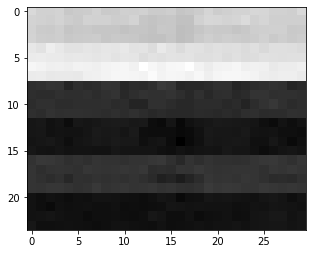

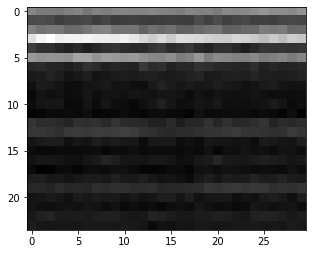

[8951/17000] loss_d: -0.394, loss_g: 0.872
[8952/17000] loss_d: -0.431, loss_g: 0.962
[8953/17000] loss_d: -0.388, loss_g: 0.785
[8954/17000] loss_d: -0.410, loss_g: 0.835
[8955/17000] loss_d: -0.384, loss_g: 0.850
[8956/17000] loss_d: -0.382, loss_g: 0.903
[8957/17000] loss_d: -0.376, loss_g: 0.870
[8958/17000] loss_d: -0.358, loss_g: 0.863
[8959/17000] loss_d: -0.417, loss_g: 0.920
[8960/17000] loss_d: -0.372, loss_g: 0.857
[8961/17000] loss_d: -0.425, loss_g: 0.870
[8962/17000] loss_d: -0.384, loss_g: 0.917
[8963/17000] loss_d: -0.446, loss_g: 0.899
[8964/17000] loss_d: -0.417, loss_g: 0.925
[8965/17000] loss_d: -0.408, loss_g: 0.886
[8966/17000] loss_d: -0.391, loss_g: 0.778
[8967/17000] loss_d: -0.386, loss_g: 0.896
[8968/17000] loss_d: -0.429, loss_g: 0.938
[8969/17000] loss_d: -0.406, loss_g: 0.891
[8970/17000] loss_d: -0.406, loss_g: 0.868
[8971/17000] loss_d: -0.426, loss_g: 0.865
[8972/17000] loss_d: -0.399, loss_g: 0.895
[8973/17000] loss_d: -0.407, loss_g: 0.904
[8974/17000

<Figure size 432x288 with 0 Axes>

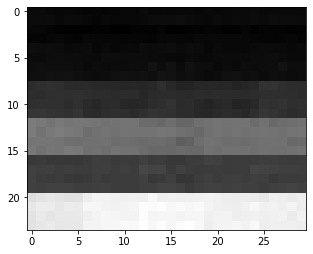

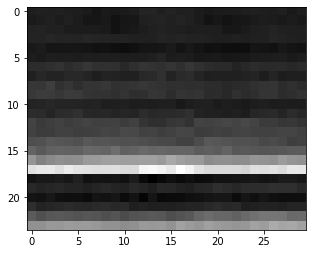

[9001/17000] loss_d: -0.391, loss_g: 0.820
[9002/17000] loss_d: -0.388, loss_g: 0.861
[9003/17000] loss_d: -0.378, loss_g: 0.945
[9004/17000] loss_d: -0.435, loss_g: 0.911
[9005/17000] loss_d: -0.410, loss_g: 0.882
[9006/17000] loss_d: -0.401, loss_g: 0.900
[9007/17000] loss_d: -0.435, loss_g: 0.898
[9008/17000] loss_d: -0.411, loss_g: 0.939
[9009/17000] loss_d: -0.402, loss_g: 0.950
[9010/17000] loss_d: -0.387, loss_g: 0.846
[9011/17000] loss_d: -0.421, loss_g: 0.856
[9012/17000] loss_d: -0.410, loss_g: 0.941
[9013/17000] loss_d: -0.410, loss_g: 0.968
[9014/17000] loss_d: -0.398, loss_g: 0.859
[9015/17000] loss_d: -0.416, loss_g: 0.870
[9016/17000] loss_d: -0.417, loss_g: 1.039
[9017/17000] loss_d: -0.397, loss_g: 0.955
[9018/17000] loss_d: -0.426, loss_g: 0.921
[9019/17000] loss_d: -0.392, loss_g: 0.994
[9020/17000] loss_d: -0.376, loss_g: 0.970
[9021/17000] loss_d: -0.411, loss_g: 0.953
[9022/17000] loss_d: -0.418, loss_g: 1.019
[9023/17000] loss_d: -0.383, loss_g: 0.965
[9024/17000

<Figure size 432x288 with 0 Axes>

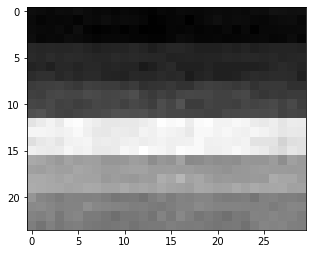

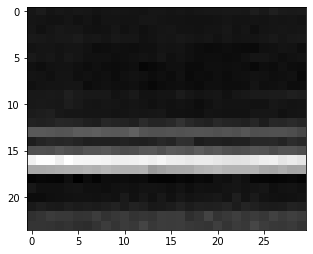

[9051/17000] loss_d: -0.410, loss_g: 0.883
[9052/17000] loss_d: -0.404, loss_g: 0.905
[9053/17000] loss_d: -0.396, loss_g: 0.962
[9054/17000] loss_d: -0.407, loss_g: 0.901
[9055/17000] loss_d: -0.421, loss_g: 0.952
[9056/17000] loss_d: -0.380, loss_g: 0.984
[9057/17000] loss_d: -0.447, loss_g: 0.978
[9058/17000] loss_d: -0.426, loss_g: 0.905
[9059/17000] loss_d: -0.424, loss_g: 0.846
[9060/17000] loss_d: -0.403, loss_g: 0.913
[9061/17000] loss_d: -0.389, loss_g: 0.912
[9062/17000] loss_d: -0.407, loss_g: 0.915
[9063/17000] loss_d: -0.429, loss_g: 0.818
[9064/17000] loss_d: -0.428, loss_g: 0.867
[9065/17000] loss_d: -0.376, loss_g: 0.905
[9066/17000] loss_d: -0.374, loss_g: 0.841
[9067/17000] loss_d: -0.402, loss_g: 0.876
[9068/17000] loss_d: -0.381, loss_g: 0.826
[9069/17000] loss_d: -0.419, loss_g: 0.883
[9070/17000] loss_d: -0.421, loss_g: 0.884
[9071/17000] loss_d: -0.384, loss_g: 0.896
[9072/17000] loss_d: -0.374, loss_g: 0.913
[9073/17000] loss_d: -0.399, loss_g: 0.980
[9074/17000

<Figure size 432x288 with 0 Axes>

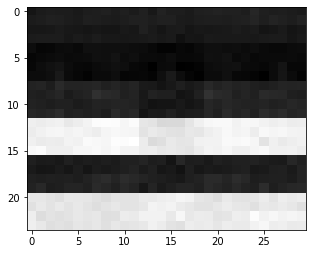

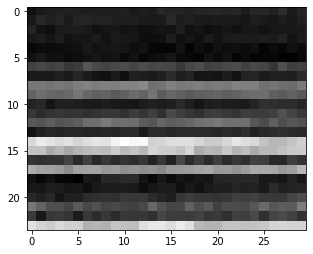

[9101/17000] loss_d: -0.370, loss_g: 0.886
[9102/17000] loss_d: -0.378, loss_g: 0.959
[9103/17000] loss_d: -0.367, loss_g: 0.846
[9104/17000] loss_d: -0.412, loss_g: 0.881
[9105/17000] loss_d: -0.383, loss_g: 0.902
[9106/17000] loss_d: -0.431, loss_g: 0.880
[9107/17000] loss_d: -0.407, loss_g: 0.890
[9108/17000] loss_d: -0.393, loss_g: 0.866
[9109/17000] loss_d: -0.407, loss_g: 0.842
[9110/17000] loss_d: -0.396, loss_g: 0.926
[9111/17000] loss_d: -0.434, loss_g: 0.960
[9112/17000] loss_d: -0.406, loss_g: 0.888
[9113/17000] loss_d: -0.408, loss_g: 0.916
[9114/17000] loss_d: -0.436, loss_g: 0.934
[9115/17000] loss_d: -0.433, loss_g: 0.909
[9116/17000] loss_d: -0.381, loss_g: 0.885
[9117/17000] loss_d: -0.400, loss_g: 0.835
[9118/17000] loss_d: -0.430, loss_g: 0.854
[9119/17000] loss_d: -0.414, loss_g: 0.958
[9120/17000] loss_d: -0.394, loss_g: 0.879
[9121/17000] loss_d: -0.354, loss_g: 0.852
[9122/17000] loss_d: -0.383, loss_g: 0.908
[9123/17000] loss_d: -0.357, loss_g: 0.899
[9124/17000

<Figure size 432x288 with 0 Axes>

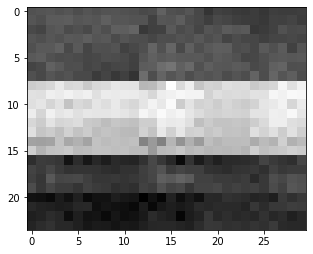

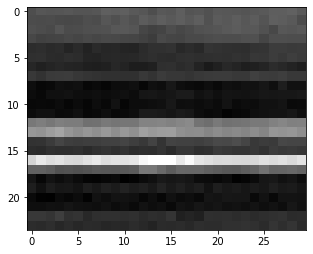

[9151/17000] loss_d: -0.405, loss_g: 0.840
[9152/17000] loss_d: -0.417, loss_g: 0.948
[9153/17000] loss_d: -0.408, loss_g: 0.889
[9154/17000] loss_d: -0.412, loss_g: 0.850
[9155/17000] loss_d: -0.376, loss_g: 0.894
[9156/17000] loss_d: -0.361, loss_g: 0.861
[9157/17000] loss_d: -0.429, loss_g: 1.025
[9158/17000] loss_d: -0.418, loss_g: 0.903
[9159/17000] loss_d: -0.349, loss_g: 0.928
[9160/17000] loss_d: -0.422, loss_g: 0.977
[9161/17000] loss_d: -0.432, loss_g: 1.005
[9162/17000] loss_d: -0.380, loss_g: 0.974
[9163/17000] loss_d: -0.400, loss_g: 1.012
[9164/17000] loss_d: -0.396, loss_g: 0.998
[9165/17000] loss_d: -0.427, loss_g: 0.946
[9166/17000] loss_d: -0.414, loss_g: 0.989
[9167/17000] loss_d: -0.414, loss_g: 0.995
[9168/17000] loss_d: -0.394, loss_g: 0.991
[9169/17000] loss_d: -0.413, loss_g: 0.931
[9170/17000] loss_d: -0.415, loss_g: 0.870
[9171/17000] loss_d: -0.394, loss_g: 0.942
[9172/17000] loss_d: -0.403, loss_g: 0.906
[9173/17000] loss_d: -0.377, loss_g: 0.887
[9174/17000

<Figure size 432x288 with 0 Axes>

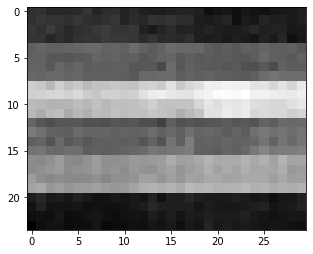

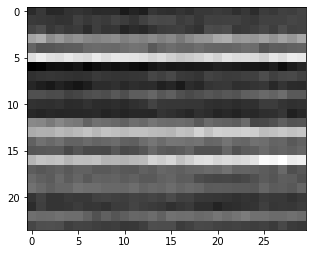

[9201/17000] loss_d: -0.377, loss_g: 0.970
[9202/17000] loss_d: -0.389, loss_g: 0.938
[9203/17000] loss_d: -0.396, loss_g: 0.893
[9204/17000] loss_d: -0.442, loss_g: 0.958
[9205/17000] loss_d: -0.397, loss_g: 0.994
[9206/17000] loss_d: -0.422, loss_g: 0.879
[9207/17000] loss_d: -0.400, loss_g: 0.921
[9208/17000] loss_d: -0.427, loss_g: 0.848
[9209/17000] loss_d: -0.383, loss_g: 0.913
[9210/17000] loss_d: -0.457, loss_g: 0.924
[9211/17000] loss_d: -0.409, loss_g: 0.920
[9212/17000] loss_d: -0.425, loss_g: 1.009
[9213/17000] loss_d: -0.439, loss_g: 0.896
[9214/17000] loss_d: -0.406, loss_g: 0.893
[9215/17000] loss_d: -0.393, loss_g: 0.926
[9216/17000] loss_d: -0.410, loss_g: 0.979
[9217/17000] loss_d: -0.415, loss_g: 0.968
[9218/17000] loss_d: -0.427, loss_g: 0.897
[9219/17000] loss_d: -0.419, loss_g: 0.956
[9220/17000] loss_d: -0.405, loss_g: 0.898
[9221/17000] loss_d: -0.391, loss_g: 0.951
[9222/17000] loss_d: -0.390, loss_g: 0.997
[9223/17000] loss_d: -0.394, loss_g: 0.928
[9224/17000

<Figure size 432x288 with 0 Axes>

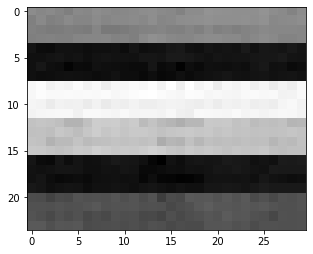

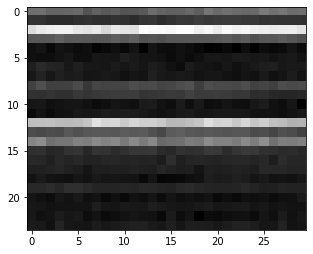

[9251/17000] loss_d: -0.427, loss_g: 0.868
[9252/17000] loss_d: -0.352, loss_g: 0.867
[9253/17000] loss_d: -0.411, loss_g: 0.828
[9254/17000] loss_d: -0.390, loss_g: 0.852
[9255/17000] loss_d: -0.430, loss_g: 0.930
[9256/17000] loss_d: -0.374, loss_g: 0.914
[9257/17000] loss_d: -0.420, loss_g: 0.863
[9258/17000] loss_d: -0.412, loss_g: 0.828
[9259/17000] loss_d: -0.406, loss_g: 0.942
[9260/17000] loss_d: -0.396, loss_g: 0.881
[9261/17000] loss_d: -0.413, loss_g: 0.820
[9262/17000] loss_d: -0.383, loss_g: 0.826
[9263/17000] loss_d: -0.410, loss_g: 0.843
[9264/17000] loss_d: -0.398, loss_g: 0.819
[9265/17000] loss_d: -0.415, loss_g: 0.790
[9266/17000] loss_d: -0.401, loss_g: 0.793
[9267/17000] loss_d: -0.409, loss_g: 0.818
[9268/17000] loss_d: -0.408, loss_g: 0.904
[9269/17000] loss_d: -0.451, loss_g: 0.924
[9270/17000] loss_d: -0.429, loss_g: 0.852
[9271/17000] loss_d: -0.410, loss_g: 0.915
[9272/17000] loss_d: -0.411, loss_g: 0.935
[9273/17000] loss_d: -0.396, loss_g: 0.917
[9274/17000

<Figure size 432x288 with 0 Axes>

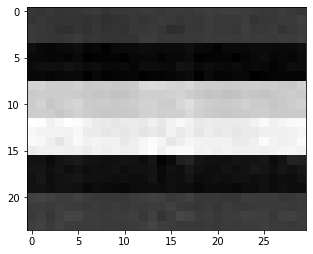

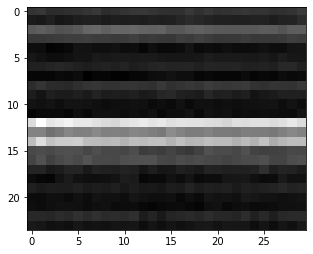

[9301/17000] loss_d: -0.418, loss_g: 0.853
[9302/17000] loss_d: -0.432, loss_g: 0.882
[9303/17000] loss_d: -0.429, loss_g: 0.831
[9304/17000] loss_d: -0.417, loss_g: 0.801
[9305/17000] loss_d: -0.398, loss_g: 0.862
[9306/17000] loss_d: -0.400, loss_g: 0.914
[9307/17000] loss_d: -0.412, loss_g: 0.820
[9308/17000] loss_d: -0.434, loss_g: 0.875
[9309/17000] loss_d: -0.422, loss_g: 0.796
[9310/17000] loss_d: -0.411, loss_g: 0.870
[9311/17000] loss_d: -0.423, loss_g: 0.894
[9312/17000] loss_d: -0.395, loss_g: 0.846
[9313/17000] loss_d: -0.438, loss_g: 0.865
[9314/17000] loss_d: -0.398, loss_g: 0.858
[9315/17000] loss_d: -0.405, loss_g: 0.856
[9316/17000] loss_d: -0.402, loss_g: 0.801
[9317/17000] loss_d: -0.417, loss_g: 0.862
[9318/17000] loss_d: -0.441, loss_g: 0.922
[9319/17000] loss_d: -0.409, loss_g: 0.927
[9320/17000] loss_d: -0.410, loss_g: 0.786
[9321/17000] loss_d: -0.410, loss_g: 0.882
[9322/17000] loss_d: -0.399, loss_g: 0.811
[9323/17000] loss_d: -0.415, loss_g: 0.802
[9324/17000

<Figure size 432x288 with 0 Axes>

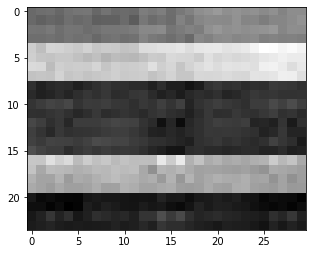

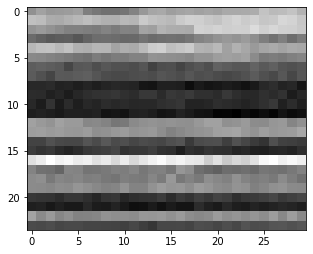

[9351/17000] loss_d: -0.368, loss_g: 0.875
[9352/17000] loss_d: -0.400, loss_g: 0.967
[9353/17000] loss_d: -0.435, loss_g: 0.873
[9354/17000] loss_d: -0.418, loss_g: 1.011
[9355/17000] loss_d: -0.416, loss_g: 1.002
[9356/17000] loss_d: -0.388, loss_g: 0.985
[9357/17000] loss_d: -0.378, loss_g: 0.932
[9358/17000] loss_d: -0.396, loss_g: 0.921
[9359/17000] loss_d: -0.432, loss_g: 0.935
[9360/17000] loss_d: -0.401, loss_g: 0.965
[9361/17000] loss_d: -0.412, loss_g: 0.864
[9362/17000] loss_d: -0.407, loss_g: 0.884
[9363/17000] loss_d: -0.425, loss_g: 0.900
[9364/17000] loss_d: -0.422, loss_g: 0.913
[9365/17000] loss_d: -0.435, loss_g: 0.944
[9366/17000] loss_d: -0.405, loss_g: 0.854
[9367/17000] loss_d: -0.384, loss_g: 0.932
[9368/17000] loss_d: -0.386, loss_g: 0.906
[9369/17000] loss_d: -0.406, loss_g: 1.129
[9370/17000] loss_d: -0.395, loss_g: 0.876
[9371/17000] loss_d: -0.361, loss_g: 0.848
[9372/17000] loss_d: -0.393, loss_g: 0.845
[9373/17000] loss_d: -0.420, loss_g: 0.865
[9374/17000

<Figure size 432x288 with 0 Axes>

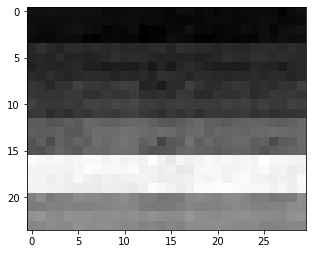

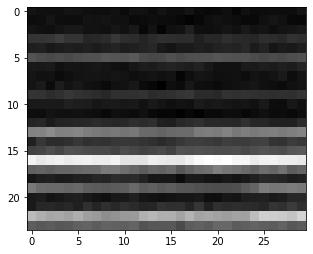

[9401/17000] loss_d: -0.421, loss_g: 0.826
[9402/17000] loss_d: -0.434, loss_g: 0.785
[9403/17000] loss_d: -0.436, loss_g: 0.734
[9404/17000] loss_d: -0.427, loss_g: 0.854
[9405/17000] loss_d: -0.421, loss_g: 0.870
[9406/17000] loss_d: -0.408, loss_g: 0.873
[9407/17000] loss_d: -0.385, loss_g: 0.866
[9408/17000] loss_d: -0.410, loss_g: 0.845
[9409/17000] loss_d: -0.413, loss_g: 0.919
[9410/17000] loss_d: -0.408, loss_g: 0.877
[9411/17000] loss_d: -0.400, loss_g: 0.757
[9412/17000] loss_d: -0.399, loss_g: 0.838
[9413/17000] loss_d: -0.397, loss_g: 0.801
[9414/17000] loss_d: -0.435, loss_g: 0.867
[9415/17000] loss_d: -0.415, loss_g: 0.852
[9416/17000] loss_d: -0.415, loss_g: 0.865
[9417/17000] loss_d: -0.411, loss_g: 0.917
[9418/17000] loss_d: -0.427, loss_g: 0.846
[9419/17000] loss_d: -0.400, loss_g: 0.820
[9420/17000] loss_d: -0.406, loss_g: 0.902
[9421/17000] loss_d: -0.403, loss_g: 0.917
[9422/17000] loss_d: -0.377, loss_g: 0.781
[9423/17000] loss_d: -0.408, loss_g: 0.854
[9424/17000

<Figure size 432x288 with 0 Axes>

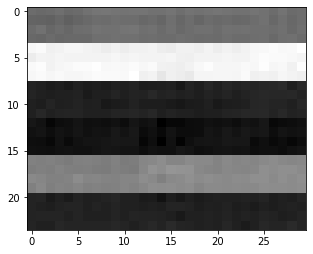

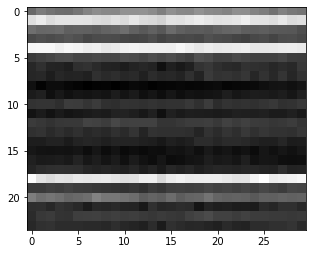

[9451/17000] loss_d: -0.433, loss_g: 0.838
[9452/17000] loss_d: -0.415, loss_g: 0.862
[9453/17000] loss_d: -0.404, loss_g: 0.918
[9454/17000] loss_d: -0.419, loss_g: 0.827
[9455/17000] loss_d: -0.405, loss_g: 0.797
[9456/17000] loss_d: -0.413, loss_g: 0.876
[9457/17000] loss_d: -0.416, loss_g: 0.778
[9458/17000] loss_d: -0.421, loss_g: 0.867
[9459/17000] loss_d: -0.415, loss_g: 0.946
[9460/17000] loss_d: -0.419, loss_g: 0.960
[9461/17000] loss_d: -0.443, loss_g: 0.842
[9462/17000] loss_d: -0.384, loss_g: 0.876
[9463/17000] loss_d: -0.365, loss_g: 0.874
[9464/17000] loss_d: -0.417, loss_g: 0.864
[9465/17000] loss_d: -0.400, loss_g: 0.846
[9466/17000] loss_d: -0.379, loss_g: 0.900
[9467/17000] loss_d: -0.419, loss_g: 0.848
[9468/17000] loss_d: -0.427, loss_g: 0.891
[9469/17000] loss_d: -0.421, loss_g: 0.865
[9470/17000] loss_d: -0.417, loss_g: 0.856
[9471/17000] loss_d: -0.399, loss_g: 0.936
[9472/17000] loss_d: -0.367, loss_g: 0.843
[9473/17000] loss_d: -0.392, loss_g: 0.821
[9474/17000

<Figure size 432x288 with 0 Axes>

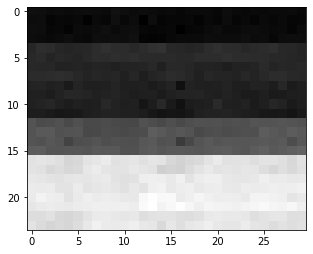

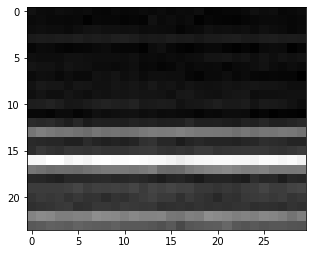

[9501/17000] loss_d: -0.407, loss_g: 0.874
[9502/17000] loss_d: -0.424, loss_g: 0.742
[9503/17000] loss_d: -0.391, loss_g: 0.858
[9504/17000] loss_d: -0.399, loss_g: 0.933
[9505/17000] loss_d: -0.391, loss_g: 0.870
[9506/17000] loss_d: -0.409, loss_g: 0.843
[9507/17000] loss_d: -0.384, loss_g: 0.883
[9508/17000] loss_d: -0.402, loss_g: 0.873
[9509/17000] loss_d: -0.389, loss_g: 0.858
[9510/17000] loss_d: -0.394, loss_g: 0.889
[9511/17000] loss_d: -0.416, loss_g: 0.897
[9512/17000] loss_d: -0.373, loss_g: 0.891
[9513/17000] loss_d: -0.397, loss_g: 0.883
[9514/17000] loss_d: -0.420, loss_g: 0.796
[9515/17000] loss_d: -0.387, loss_g: 0.812
[9516/17000] loss_d: -0.400, loss_g: 0.851
[9517/17000] loss_d: -0.441, loss_g: 0.826
[9518/17000] loss_d: -0.394, loss_g: 0.805
[9519/17000] loss_d: -0.392, loss_g: 0.893
[9520/17000] loss_d: -0.413, loss_g: 0.839
[9521/17000] loss_d: -0.427, loss_g: 0.863
[9522/17000] loss_d: -0.426, loss_g: 0.798
[9523/17000] loss_d: -0.379, loss_g: 0.829
[9524/17000

<Figure size 432x288 with 0 Axes>

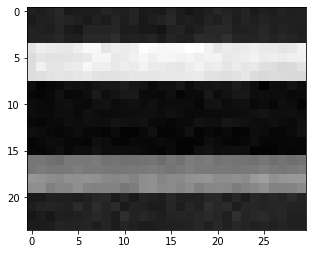

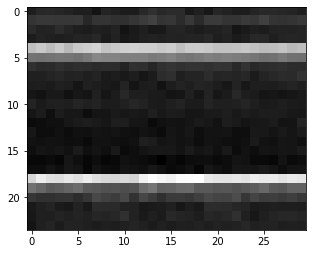

[9551/17000] loss_d: -0.466, loss_g: 0.961
[9552/17000] loss_d: -0.431, loss_g: 0.926
[9553/17000] loss_d: -0.422, loss_g: 0.843
[9554/17000] loss_d: -0.436, loss_g: 0.873
[9555/17000] loss_d: -0.433, loss_g: 0.838
[9556/17000] loss_d: -0.395, loss_g: 0.905
[9557/17000] loss_d: -0.364, loss_g: 0.950
[9558/17000] loss_d: -0.404, loss_g: 0.815
[9559/17000] loss_d: -0.379, loss_g: 0.861
[9560/17000] loss_d: -0.419, loss_g: 0.900
[9561/17000] loss_d: -0.380, loss_g: 0.901
[9562/17000] loss_d: -0.401, loss_g: 0.924
[9563/17000] loss_d: -0.391, loss_g: 0.869
[9564/17000] loss_d: -0.412, loss_g: 0.823
[9565/17000] loss_d: -0.384, loss_g: 0.855
[9566/17000] loss_d: -0.400, loss_g: 0.893
[9567/17000] loss_d: -0.397, loss_g: 0.877
[9568/17000] loss_d: -0.450, loss_g: 0.855
[9569/17000] loss_d: -0.394, loss_g: 0.921
[9570/17000] loss_d: -0.441, loss_g: 0.879
[9571/17000] loss_d: -0.390, loss_g: 0.856
[9572/17000] loss_d: -0.450, loss_g: 0.934
[9573/17000] loss_d: -0.426, loss_g: 0.796
[9574/17000

<Figure size 432x288 with 0 Axes>

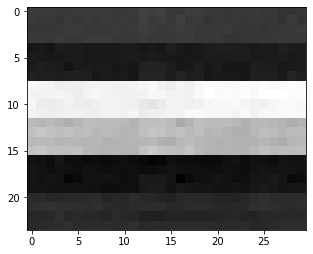

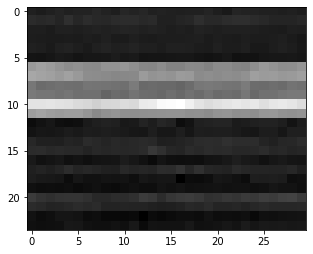

[9601/17000] loss_d: -0.421, loss_g: 0.947
[9602/17000] loss_d: -0.436, loss_g: 0.839
[9603/17000] loss_d: -0.402, loss_g: 0.791
[9604/17000] loss_d: -0.391, loss_g: 0.854
[9605/17000] loss_d: -0.434, loss_g: 0.864
[9606/17000] loss_d: -0.422, loss_g: 0.865
[9607/17000] loss_d: -0.432, loss_g: 0.830
[9608/17000] loss_d: -0.428, loss_g: 0.868
[9609/17000] loss_d: -0.379, loss_g: 0.831
[9610/17000] loss_d: -0.391, loss_g: 0.800
[9611/17000] loss_d: -0.391, loss_g: 0.815
[9612/17000] loss_d: -0.401, loss_g: 0.850
[9613/17000] loss_d: -0.376, loss_g: 0.794
[9614/17000] loss_d: -0.390, loss_g: 0.824
[9615/17000] loss_d: -0.383, loss_g: 0.800
[9616/17000] loss_d: -0.418, loss_g: 0.871
[9617/17000] loss_d: -0.386, loss_g: 0.851
[9618/17000] loss_d: -0.396, loss_g: 0.850
[9619/17000] loss_d: -0.405, loss_g: 0.915
[9620/17000] loss_d: -0.423, loss_g: 0.831
[9621/17000] loss_d: -0.383, loss_g: 0.816
[9622/17000] loss_d: -0.390, loss_g: 0.890
[9623/17000] loss_d: -0.420, loss_g: 0.828
[9624/17000

<Figure size 432x288 with 0 Axes>

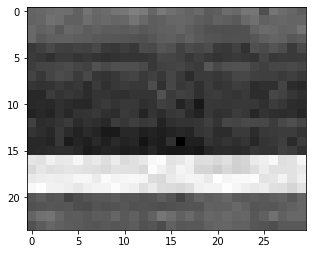

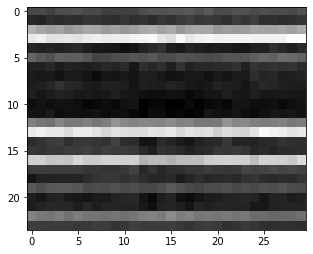

[9651/17000] loss_d: -0.419, loss_g: 0.883
[9652/17000] loss_d: -0.399, loss_g: 0.902
[9653/17000] loss_d: -0.449, loss_g: 0.918
[9654/17000] loss_d: -0.415, loss_g: 0.738
[9655/17000] loss_d: -0.430, loss_g: 0.833
[9656/17000] loss_d: -0.378, loss_g: 0.823
[9657/17000] loss_d: -0.347, loss_g: 0.864
[9658/17000] loss_d: -0.409, loss_g: 0.867
[9659/17000] loss_d: -0.395, loss_g: 0.877
[9660/17000] loss_d: -0.402, loss_g: 0.840
[9661/17000] loss_d: -0.402, loss_g: 0.864
[9662/17000] loss_d: -0.382, loss_g: 0.804
[9663/17000] loss_d: -0.398, loss_g: 0.873
[9664/17000] loss_d: -0.455, loss_g: 0.924
[9665/17000] loss_d: -0.446, loss_g: 1.025
[9666/17000] loss_d: -0.439, loss_g: 0.908
[9667/17000] loss_d: -0.395, loss_g: 0.932
[9668/17000] loss_d: -0.378, loss_g: 0.798
[9669/17000] loss_d: -0.381, loss_g: 0.819
[9670/17000] loss_d: -0.384, loss_g: 0.895
[9671/17000] loss_d: -0.399, loss_g: 0.814
[9672/17000] loss_d: -0.430, loss_g: 0.808
[9673/17000] loss_d: -0.422, loss_g: 0.863
[9674/17000

<Figure size 432x288 with 0 Axes>

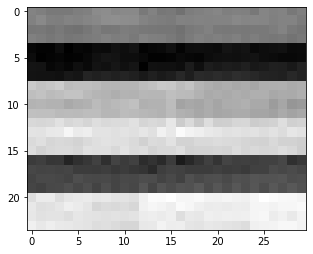

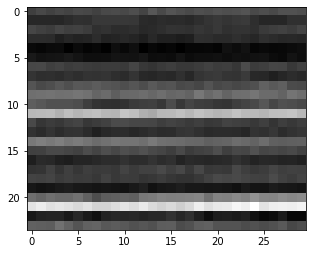

[9701/17000] loss_d: -0.369, loss_g: 0.843
[9702/17000] loss_d: -0.360, loss_g: 0.826
[9703/17000] loss_d: -0.406, loss_g: 0.838
[9704/17000] loss_d: -0.393, loss_g: 0.823
[9705/17000] loss_d: -0.388, loss_g: 0.789
[9706/17000] loss_d: -0.420, loss_g: 0.872
[9707/17000] loss_d: -0.382, loss_g: 0.842
[9708/17000] loss_d: -0.408, loss_g: 0.867
[9709/17000] loss_d: -0.433, loss_g: 0.807
[9710/17000] loss_d: -0.364, loss_g: 0.825
[9711/17000] loss_d: -0.393, loss_g: 0.789
[9712/17000] loss_d: -0.403, loss_g: 0.842
[9713/17000] loss_d: -0.376, loss_g: 0.764
[9714/17000] loss_d: -0.449, loss_g: 0.801
[9715/17000] loss_d: -0.405, loss_g: 0.892
[9716/17000] loss_d: -0.424, loss_g: 0.920
[9717/17000] loss_d: -0.435, loss_g: 0.796
[9718/17000] loss_d: -0.379, loss_g: 0.868
[9719/17000] loss_d: -0.382, loss_g: 0.779
[9720/17000] loss_d: -0.380, loss_g: 0.804
[9721/17000] loss_d: -0.408, loss_g: 0.808
[9722/17000] loss_d: -0.379, loss_g: 0.779
[9723/17000] loss_d: -0.389, loss_g: 0.805
[9724/17000

<Figure size 432x288 with 0 Axes>

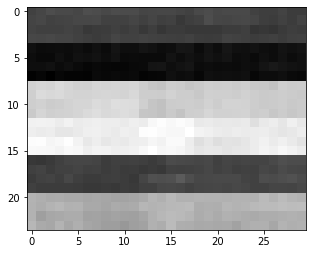

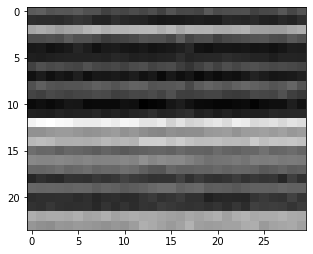

[9751/17000] loss_d: -0.425, loss_g: 0.891
[9752/17000] loss_d: -0.435, loss_g: 0.861
[9753/17000] loss_d: -0.382, loss_g: 0.926
[9754/17000] loss_d: -0.404, loss_g: 0.983
[9755/17000] loss_d: -0.389, loss_g: 0.915
[9756/17000] loss_d: -0.404, loss_g: 0.900
[9757/17000] loss_d: -0.397, loss_g: 0.887
[9758/17000] loss_d: -0.387, loss_g: 0.913
[9759/17000] loss_d: -0.414, loss_g: 0.879
[9760/17000] loss_d: -0.412, loss_g: 0.823
[9761/17000] loss_d: -0.406, loss_g: 0.884
[9762/17000] loss_d: -0.408, loss_g: 0.788
[9763/17000] loss_d: -0.441, loss_g: 0.888
[9764/17000] loss_d: -0.376, loss_g: 0.863
[9765/17000] loss_d: -0.388, loss_g: 0.910
[9766/17000] loss_d: -0.377, loss_g: 0.858
[9767/17000] loss_d: -0.414, loss_g: 0.923
[9768/17000] loss_d: -0.392, loss_g: 0.876
[9769/17000] loss_d: -0.381, loss_g: 0.908
[9770/17000] loss_d: -0.452, loss_g: 0.849
[9771/17000] loss_d: -0.401, loss_g: 0.811
[9772/17000] loss_d: -0.392, loss_g: 0.944
[9773/17000] loss_d: -0.406, loss_g: 0.906
[9774/17000

<Figure size 432x288 with 0 Axes>

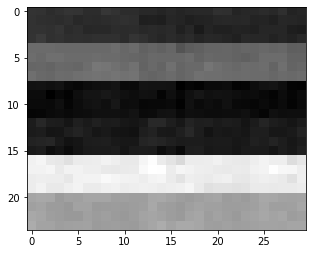

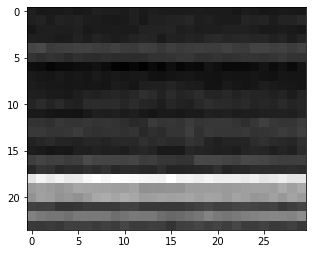

[9801/17000] loss_d: -0.397, loss_g: 0.868
[9802/17000] loss_d: -0.430, loss_g: 0.925
[9803/17000] loss_d: -0.403, loss_g: 0.833
[9804/17000] loss_d: -0.415, loss_g: 0.852
[9805/17000] loss_d: -0.401, loss_g: 0.804
[9806/17000] loss_d: -0.396, loss_g: 0.874
[9807/17000] loss_d: -0.389, loss_g: 0.858
[9808/17000] loss_d: -0.395, loss_g: 0.946
[9809/17000] loss_d: -0.411, loss_g: 0.784
[9810/17000] loss_d: -0.409, loss_g: 0.805
[9811/17000] loss_d: -0.403, loss_g: 0.848
[9812/17000] loss_d: -0.435, loss_g: 0.886
[9813/17000] loss_d: -0.382, loss_g: 0.905
[9814/17000] loss_d: -0.412, loss_g: 0.881
[9815/17000] loss_d: -0.398, loss_g: 0.874
[9816/17000] loss_d: -0.398, loss_g: 0.865
[9817/17000] loss_d: -0.418, loss_g: 0.896
[9818/17000] loss_d: -0.430, loss_g: 0.837
[9819/17000] loss_d: -0.400, loss_g: 0.887
[9820/17000] loss_d: -0.401, loss_g: 0.864
[9821/17000] loss_d: -0.442, loss_g: 0.901
[9822/17000] loss_d: -0.411, loss_g: 0.860
[9823/17000] loss_d: -0.389, loss_g: 0.858
[9824/17000

<Figure size 432x288 with 0 Axes>

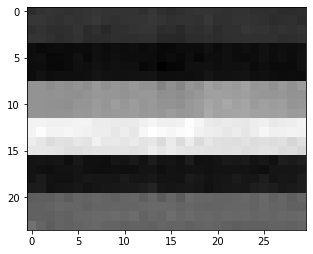

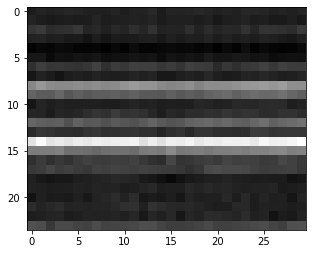

[9851/17000] loss_d: -0.388, loss_g: 0.860
[9852/17000] loss_d: -0.423, loss_g: 0.846
[9853/17000] loss_d: -0.395, loss_g: 0.865
[9854/17000] loss_d: -0.405, loss_g: 0.818
[9855/17000] loss_d: -0.373, loss_g: 0.893
[9856/17000] loss_d: -0.377, loss_g: 0.874
[9857/17000] loss_d: -0.416, loss_g: 0.858
[9858/17000] loss_d: -0.394, loss_g: 0.812
[9859/17000] loss_d: -0.395, loss_g: 0.933
[9860/17000] loss_d: -0.395, loss_g: 0.884
[9861/17000] loss_d: -0.432, loss_g: 0.831
[9862/17000] loss_d: -0.395, loss_g: 0.889
[9863/17000] loss_d: -0.397, loss_g: 0.826
[9864/17000] loss_d: -0.357, loss_g: 0.822
[9865/17000] loss_d: -0.398, loss_g: 0.840
[9866/17000] loss_d: -0.406, loss_g: 0.808
[9867/17000] loss_d: -0.390, loss_g: 0.744
[9868/17000] loss_d: -0.413, loss_g: 0.783
[9869/17000] loss_d: -0.419, loss_g: 0.777
[9870/17000] loss_d: -0.427, loss_g: 0.699
[9871/17000] loss_d: -0.393, loss_g: 0.806
[9872/17000] loss_d: -0.420, loss_g: 0.801
[9873/17000] loss_d: -0.400, loss_g: 0.828
[9874/17000

<Figure size 432x288 with 0 Axes>

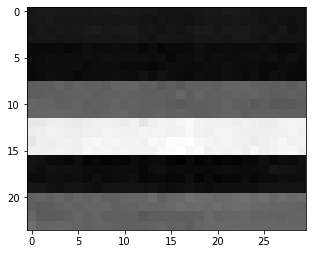

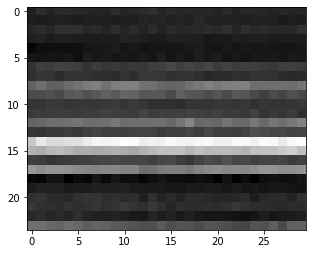

[9901/17000] loss_d: -0.416, loss_g: 0.842
[9902/17000] loss_d: -0.405, loss_g: 0.888
[9903/17000] loss_d: -0.401, loss_g: 0.811
[9904/17000] loss_d: -0.427, loss_g: 0.796
[9905/17000] loss_d: -0.433, loss_g: 0.866
[9906/17000] loss_d: -0.417, loss_g: 0.778
[9907/17000] loss_d: -0.409, loss_g: 0.815
[9908/17000] loss_d: -0.420, loss_g: 0.809
[9909/17000] loss_d: -0.420, loss_g: 0.788
[9910/17000] loss_d: -0.378, loss_g: 0.773
[9911/17000] loss_d: -0.404, loss_g: 0.854
[9912/17000] loss_d: -0.392, loss_g: 0.805
[9913/17000] loss_d: -0.399, loss_g: 0.919
[9914/17000] loss_d: -0.440, loss_g: 0.822
[9915/17000] loss_d: -0.416, loss_g: 0.845
[9916/17000] loss_d: -0.412, loss_g: 0.830
[9917/17000] loss_d: -0.367, loss_g: 0.798
[9918/17000] loss_d: -0.393, loss_g: 0.787
[9919/17000] loss_d: -0.429, loss_g: 0.833
[9920/17000] loss_d: -0.398, loss_g: 0.813
[9921/17000] loss_d: -0.382, loss_g: 0.815
[9922/17000] loss_d: -0.391, loss_g: 0.855
[9923/17000] loss_d: -0.456, loss_g: 0.793
[9924/17000

<Figure size 432x288 with 0 Axes>

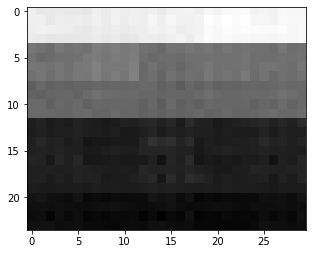

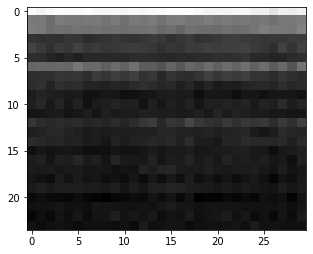

[9951/17000] loss_d: -0.408, loss_g: 0.952
[9952/17000] loss_d: -0.420, loss_g: 0.988
[9953/17000] loss_d: -0.386, loss_g: 0.988
[9954/17000] loss_d: -0.422, loss_g: 1.024
[9955/17000] loss_d: -0.408, loss_g: 0.956
[9956/17000] loss_d: -0.385, loss_g: 0.915
[9957/17000] loss_d: -0.422, loss_g: 0.975
[9958/17000] loss_d: -0.396, loss_g: 0.894
[9959/17000] loss_d: -0.384, loss_g: 0.919
[9960/17000] loss_d: -0.384, loss_g: 0.893
[9961/17000] loss_d: -0.437, loss_g: 0.919
[9962/17000] loss_d: -0.407, loss_g: 0.951
[9963/17000] loss_d: -0.424, loss_g: 0.822
[9964/17000] loss_d: -0.391, loss_g: 0.863
[9965/17000] loss_d: -0.414, loss_g: 0.843
[9966/17000] loss_d: -0.399, loss_g: 0.925
[9967/17000] loss_d: -0.397, loss_g: 0.849
[9968/17000] loss_d: -0.410, loss_g: 0.861
[9969/17000] loss_d: -0.469, loss_g: 0.830
[9970/17000] loss_d: -0.405, loss_g: 0.836
[9971/17000] loss_d: -0.399, loss_g: 0.891
[9972/17000] loss_d: -0.418, loss_g: 0.810
[9973/17000] loss_d: -0.372, loss_g: 0.880
[9974/17000

<Figure size 432x288 with 0 Axes>

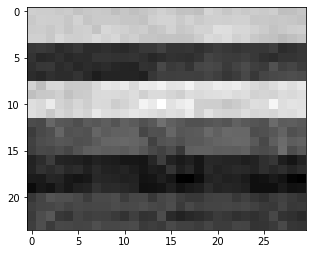

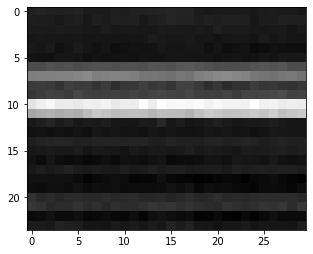

[10001/17000] loss_d: -0.412, loss_g: 0.771
[10002/17000] loss_d: -0.412, loss_g: 0.832
[10003/17000] loss_d: -0.414, loss_g: 0.954
[10004/17000] loss_d: -0.383, loss_g: 0.818
[10005/17000] loss_d: -0.382, loss_g: 0.872
[10006/17000] loss_d: -0.420, loss_g: 0.881
[10007/17000] loss_d: -0.418, loss_g: 0.732
[10008/17000] loss_d: -0.386, loss_g: 0.844
[10009/17000] loss_d: -0.414, loss_g: 0.887
[10010/17000] loss_d: -0.391, loss_g: 0.909
[10011/17000] loss_d: -0.413, loss_g: 0.849
[10012/17000] loss_d: -0.403, loss_g: 0.910
[10013/17000] loss_d: -0.391, loss_g: 0.923
[10014/17000] loss_d: -0.394, loss_g: 0.887
[10015/17000] loss_d: -0.377, loss_g: 0.860
[10016/17000] loss_d: -0.414, loss_g: 0.855
[10017/17000] loss_d: -0.409, loss_g: 0.897
[10018/17000] loss_d: -0.384, loss_g: 0.841
[10019/17000] loss_d: -0.384, loss_g: 0.892
[10020/17000] loss_d: -0.401, loss_g: 0.883
[10021/17000] loss_d: -0.429, loss_g: 0.930
[10022/17000] loss_d: -0.409, loss_g: 0.953
[10023/17000] loss_d: -0.402, lo

<Figure size 432x288 with 0 Axes>

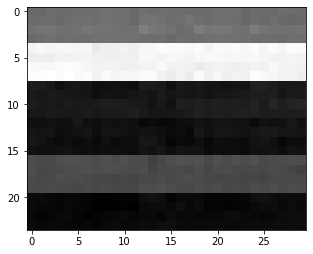

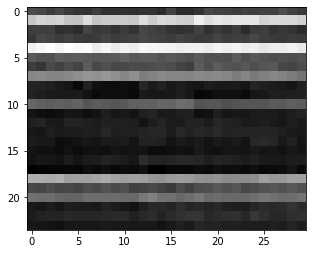

[10051/17000] loss_d: -0.392, loss_g: 0.852
[10052/17000] loss_d: -0.413, loss_g: 0.907
[10053/17000] loss_d: -0.392, loss_g: 0.907
[10054/17000] loss_d: -0.392, loss_g: 0.865
[10055/17000] loss_d: -0.409, loss_g: 0.879
[10056/17000] loss_d: -0.413, loss_g: 0.846
[10057/17000] loss_d: -0.409, loss_g: 0.876
[10058/17000] loss_d: -0.377, loss_g: 0.900
[10059/17000] loss_d: -0.359, loss_g: 0.873
[10060/17000] loss_d: -0.383, loss_g: 0.799
[10061/17000] loss_d: -0.418, loss_g: 0.865
[10062/17000] loss_d: -0.423, loss_g: 0.795
[10063/17000] loss_d: -0.389, loss_g: 0.807
[10064/17000] loss_d: -0.374, loss_g: 0.826
[10065/17000] loss_d: -0.437, loss_g: 0.859
[10066/17000] loss_d: -0.381, loss_g: 0.762
[10067/17000] loss_d: -0.400, loss_g: 0.878
[10068/17000] loss_d: -0.411, loss_g: 0.860
[10069/17000] loss_d: -0.390, loss_g: 0.870
[10070/17000] loss_d: -0.428, loss_g: 0.838
[10071/17000] loss_d: -0.388, loss_g: 0.845
[10072/17000] loss_d: -0.410, loss_g: 0.850
[10073/17000] loss_d: -0.426, lo

<Figure size 432x288 with 0 Axes>

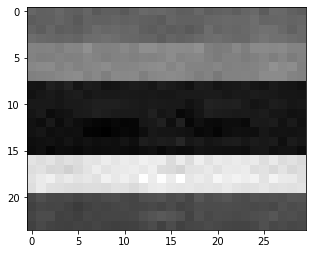

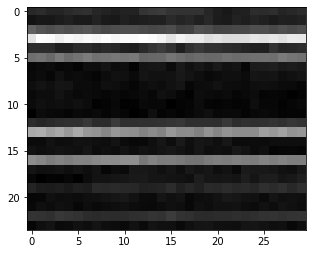

[10101/17000] loss_d: -0.409, loss_g: 0.773
[10102/17000] loss_d: -0.409, loss_g: 0.879
[10103/17000] loss_d: -0.381, loss_g: 0.864
[10104/17000] loss_d: -0.413, loss_g: 0.844
[10105/17000] loss_d: -0.399, loss_g: 0.766
[10106/17000] loss_d: -0.401, loss_g: 0.837
[10107/17000] loss_d: -0.427, loss_g: 0.871
[10108/17000] loss_d: -0.379, loss_g: 0.911
[10109/17000] loss_d: -0.395, loss_g: 0.821
[10110/17000] loss_d: -0.423, loss_g: 0.848
[10111/17000] loss_d: -0.422, loss_g: 0.868
[10112/17000] loss_d: -0.431, loss_g: 0.847
[10113/17000] loss_d: -0.407, loss_g: 0.891
[10114/17000] loss_d: -0.392, loss_g: 0.883
[10115/17000] loss_d: -0.396, loss_g: 0.946
[10116/17000] loss_d: -0.386, loss_g: 0.950
[10117/17000] loss_d: -0.399, loss_g: 0.830
[10118/17000] loss_d: -0.412, loss_g: 0.871
[10119/17000] loss_d: -0.392, loss_g: 0.824
[10120/17000] loss_d: -0.420, loss_g: 0.854
[10121/17000] loss_d: -0.398, loss_g: 0.911
[10122/17000] loss_d: -0.403, loss_g: 0.908
[10123/17000] loss_d: -0.428, lo

<Figure size 432x288 with 0 Axes>

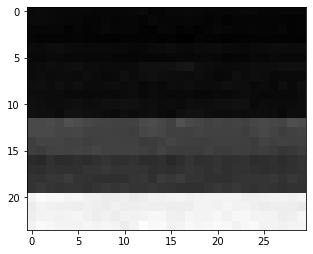

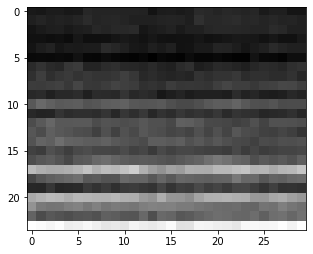

[10151/17000] loss_d: -0.408, loss_g: 0.889
[10152/17000] loss_d: -0.419, loss_g: 0.923
[10153/17000] loss_d: -0.397, loss_g: 0.890
[10154/17000] loss_d: -0.427, loss_g: 0.877
[10155/17000] loss_d: -0.390, loss_g: 0.838
[10156/17000] loss_d: -0.403, loss_g: 0.872
[10157/17000] loss_d: -0.428, loss_g: 0.855
[10158/17000] loss_d: -0.395, loss_g: 0.840
[10159/17000] loss_d: -0.380, loss_g: 0.844
[10160/17000] loss_d: -0.405, loss_g: 0.842
[10161/17000] loss_d: -0.397, loss_g: 0.831
[10162/17000] loss_d: -0.378, loss_g: 0.909
[10163/17000] loss_d: -0.407, loss_g: 0.804
[10164/17000] loss_d: -0.426, loss_g: 0.812
[10165/17000] loss_d: -0.421, loss_g: 0.843
[10166/17000] loss_d: -0.407, loss_g: 0.826
[10167/17000] loss_d: -0.431, loss_g: 1.128
[10168/17000] loss_d: -0.374, loss_g: 0.771
[10169/17000] loss_d: -0.416, loss_g: 0.803
[10170/17000] loss_d: -0.385, loss_g: 0.869
[10171/17000] loss_d: -0.382, loss_g: 0.826
[10172/17000] loss_d: -0.411, loss_g: 0.804
[10173/17000] loss_d: -0.412, lo

<Figure size 432x288 with 0 Axes>

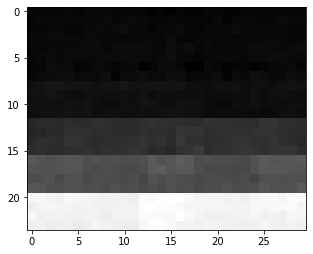

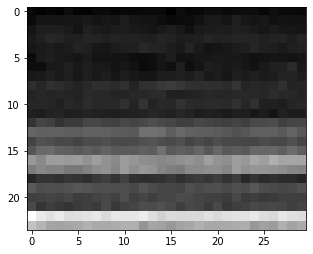

[10201/17000] loss_d: -0.406, loss_g: 0.949
[10202/17000] loss_d: -0.377, loss_g: 0.965
[10203/17000] loss_d: -0.388, loss_g: 0.987
[10204/17000] loss_d: -0.375, loss_g: 0.949
[10205/17000] loss_d: -0.410, loss_g: 0.969
[10206/17000] loss_d: -0.406, loss_g: 0.947
[10207/17000] loss_d: -0.425, loss_g: 0.885
[10208/17000] loss_d: -0.412, loss_g: 0.867
[10209/17000] loss_d: -0.428, loss_g: 0.898
[10210/17000] loss_d: -0.415, loss_g: 0.873
[10211/17000] loss_d: -0.424, loss_g: 0.916
[10212/17000] loss_d: -0.380, loss_g: 0.861
[10213/17000] loss_d: -0.400, loss_g: 0.879
[10214/17000] loss_d: -0.408, loss_g: 0.868
[10215/17000] loss_d: -0.420, loss_g: 0.901
[10216/17000] loss_d: -0.401, loss_g: 0.850
[10217/17000] loss_d: -0.422, loss_g: 0.905
[10218/17000] loss_d: -0.408, loss_g: 0.924
[10219/17000] loss_d: -0.379, loss_g: 1.023
[10220/17000] loss_d: -0.447, loss_g: 0.967
[10221/17000] loss_d: -0.396, loss_g: 0.877
[10222/17000] loss_d: -0.415, loss_g: 0.853
[10223/17000] loss_d: -0.397, lo

<Figure size 432x288 with 0 Axes>

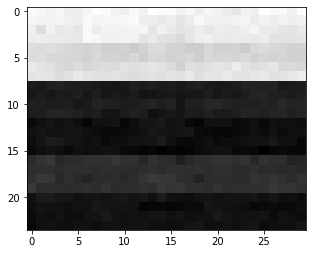

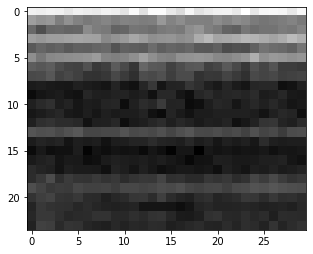

[10251/17000] loss_d: -0.405, loss_g: 0.946
[10252/17000] loss_d: -0.413, loss_g: 0.917
[10253/17000] loss_d: -0.409, loss_g: 0.902
[10254/17000] loss_d: -0.418, loss_g: 0.955
[10255/17000] loss_d: -0.407, loss_g: 0.919
[10256/17000] loss_d: -0.457, loss_g: 0.904
[10257/17000] loss_d: -0.416, loss_g: 0.881
[10258/17000] loss_d: -0.390, loss_g: 0.993
[10259/17000] loss_d: -0.384, loss_g: 0.884
[10260/17000] loss_d: -0.418, loss_g: 0.927
[10261/17000] loss_d: -0.391, loss_g: 0.908
[10262/17000] loss_d: -0.390, loss_g: 0.831
[10263/17000] loss_d: -0.416, loss_g: 0.924
[10264/17000] loss_d: -0.417, loss_g: 0.887
[10265/17000] loss_d: -0.374, loss_g: 0.843
[10266/17000] loss_d: -0.404, loss_g: 0.859
[10267/17000] loss_d: -0.390, loss_g: 0.890
[10268/17000] loss_d: -0.407, loss_g: 0.806
[10269/17000] loss_d: -0.402, loss_g: 0.924
[10270/17000] loss_d: -0.391, loss_g: 0.795
[10271/17000] loss_d: -0.420, loss_g: 0.880
[10272/17000] loss_d: -0.403, loss_g: 0.876
[10273/17000] loss_d: -0.420, lo

<Figure size 432x288 with 0 Axes>

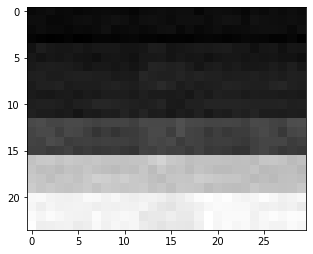

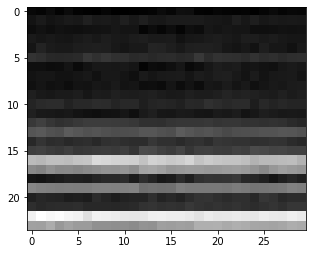

[10301/17000] loss_d: -0.400, loss_g: 0.917
[10302/17000] loss_d: -0.428, loss_g: 0.989
[10303/17000] loss_d: -0.413, loss_g: 0.979
[10304/17000] loss_d: -0.455, loss_g: 0.929
[10305/17000] loss_d: -0.369, loss_g: 0.943
[10306/17000] loss_d: -0.420, loss_g: 0.900
[10307/17000] loss_d: -0.397, loss_g: 0.953
[10308/17000] loss_d: -0.420, loss_g: 0.972
[10309/17000] loss_d: -0.388, loss_g: 0.944
[10310/17000] loss_d: -0.418, loss_g: 0.905
[10311/17000] loss_d: -0.415, loss_g: 0.914
[10312/17000] loss_d: -0.444, loss_g: 0.920
[10313/17000] loss_d: -0.386, loss_g: 0.958
[10314/17000] loss_d: -0.402, loss_g: 0.992
[10315/17000] loss_d: -0.399, loss_g: 0.971
[10316/17000] loss_d: -0.367, loss_g: 0.957
[10317/17000] loss_d: -0.434, loss_g: 0.910
[10318/17000] loss_d: -0.392, loss_g: 0.944
[10319/17000] loss_d: -0.414, loss_g: 0.970
[10320/17000] loss_d: -0.428, loss_g: 0.996
[10321/17000] loss_d: -0.418, loss_g: 0.878
[10322/17000] loss_d: -0.402, loss_g: 0.921
[10323/17000] loss_d: -0.388, lo

<Figure size 432x288 with 0 Axes>

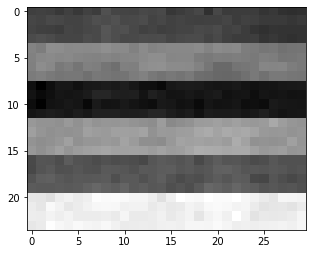

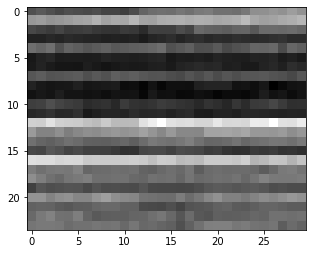

[10351/17000] loss_d: -0.369, loss_g: 0.994
[10352/17000] loss_d: -0.393, loss_g: 0.914
[10353/17000] loss_d: -0.427, loss_g: 0.869
[10354/17000] loss_d: -0.406, loss_g: 0.939
[10355/17000] loss_d: -0.386, loss_g: 0.886
[10356/17000] loss_d: -0.382, loss_g: 0.917
[10357/17000] loss_d: -0.416, loss_g: 0.915
[10358/17000] loss_d: -0.391, loss_g: 0.870
[10359/17000] loss_d: -0.373, loss_g: 0.887
[10360/17000] loss_d: -0.416, loss_g: 0.949
[10361/17000] loss_d: -0.394, loss_g: 0.956
[10362/17000] loss_d: -0.411, loss_g: 0.942
[10363/17000] loss_d: -0.388, loss_g: 0.848
[10364/17000] loss_d: -0.408, loss_g: 0.891
[10365/17000] loss_d: -0.424, loss_g: 0.847
[10366/17000] loss_d: -0.427, loss_g: 0.869
[10367/17000] loss_d: -0.421, loss_g: 0.885
[10368/17000] loss_d: -0.385, loss_g: 0.826
[10369/17000] loss_d: -0.374, loss_g: 0.853
[10370/17000] loss_d: -0.391, loss_g: 0.918
[10371/17000] loss_d: -0.413, loss_g: 0.895
[10372/17000] loss_d: -0.401, loss_g: 0.886
[10373/17000] loss_d: -0.390, lo

<Figure size 432x288 with 0 Axes>

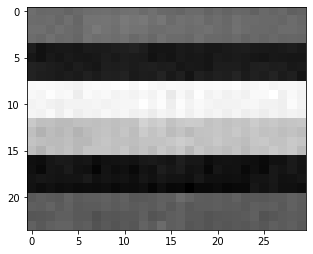

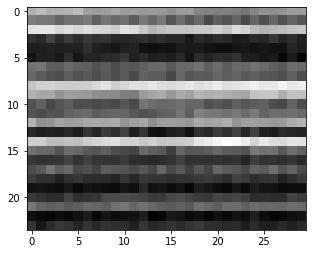

[10401/17000] loss_d: -0.431, loss_g: 0.903
[10402/17000] loss_d: -0.434, loss_g: 0.922
[10403/17000] loss_d: -0.415, loss_g: 0.913
[10404/17000] loss_d: -0.403, loss_g: 0.878
[10405/17000] loss_d: -0.391, loss_g: 0.930
[10406/17000] loss_d: -0.408, loss_g: 0.854
[10407/17000] loss_d: -0.377, loss_g: 0.863
[10408/17000] loss_d: -0.371, loss_g: 0.896
[10409/17000] loss_d: -0.384, loss_g: 0.905
[10410/17000] loss_d: -0.400, loss_g: 0.895
[10411/17000] loss_d: -0.400, loss_g: 0.942
[10412/17000] loss_d: -0.364, loss_g: 0.991
[10413/17000] loss_d: -0.367, loss_g: 0.963
[10414/17000] loss_d: -0.414, loss_g: 1.012
[10415/17000] loss_d: -0.434, loss_g: 0.958
[10416/17000] loss_d: -0.401, loss_g: 0.909
[10417/17000] loss_d: -0.403, loss_g: 0.879
[10418/17000] loss_d: -0.399, loss_g: 0.921
[10419/17000] loss_d: -0.406, loss_g: 0.998
[10420/17000] loss_d: -0.363, loss_g: 0.995
[10421/17000] loss_d: -0.406, loss_g: 0.909
[10422/17000] loss_d: -0.411, loss_g: 0.955
[10423/17000] loss_d: -0.401, lo

<Figure size 432x288 with 0 Axes>

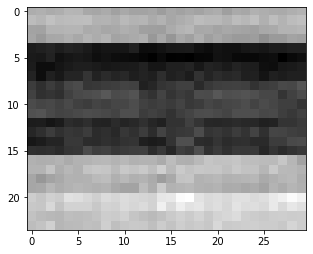

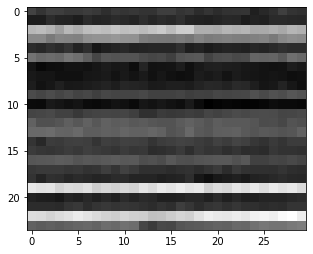

[10451/17000] loss_d: -0.418, loss_g: 0.853
[10452/17000] loss_d: -0.375, loss_g: 0.975
[10453/17000] loss_d: -0.380, loss_g: 0.927
[10454/17000] loss_d: -0.381, loss_g: 0.963
[10455/17000] loss_d: -0.420, loss_g: 0.917
[10456/17000] loss_d: -0.428, loss_g: 0.964
[10457/17000] loss_d: -0.389, loss_g: 0.917
[10458/17000] loss_d: -0.367, loss_g: 0.952
[10459/17000] loss_d: -0.420, loss_g: 0.955
[10460/17000] loss_d: -0.419, loss_g: 0.926
[10461/17000] loss_d: -0.414, loss_g: 0.920
[10462/17000] loss_d: -0.422, loss_g: 1.012
[10463/17000] loss_d: -0.393, loss_g: 0.879
[10464/17000] loss_d: -0.445, loss_g: 0.988
[10465/17000] loss_d: -0.395, loss_g: 0.950
[10466/17000] loss_d: -0.416, loss_g: 1.004
[10467/17000] loss_d: -0.417, loss_g: 0.976
[10468/17000] loss_d: -0.414, loss_g: 0.927
[10469/17000] loss_d: -0.408, loss_g: 0.863
[10470/17000] loss_d: -0.400, loss_g: 0.881
[10471/17000] loss_d: -0.406, loss_g: 0.909
[10472/17000] loss_d: -0.423, loss_g: 0.845
[10473/17000] loss_d: -0.411, lo

<Figure size 432x288 with 0 Axes>

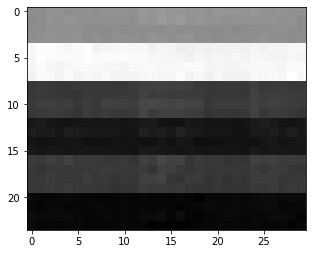

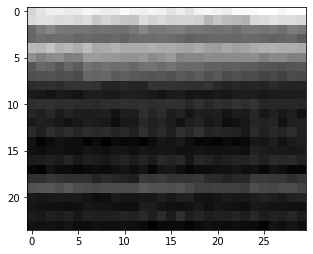

[10501/17000] loss_d: -0.425, loss_g: 0.905
[10502/17000] loss_d: -0.430, loss_g: 0.890
[10503/17000] loss_d: -0.415, loss_g: 0.800
[10504/17000] loss_d: -0.419, loss_g: 0.846
[10505/17000] loss_d: -0.426, loss_g: 0.801
[10506/17000] loss_d: -0.441, loss_g: 0.859
[10507/17000] loss_d: -0.433, loss_g: 0.955
[10508/17000] loss_d: -0.411, loss_g: 0.944
[10509/17000] loss_d: -0.411, loss_g: 0.886
[10510/17000] loss_d: -0.414, loss_g: 0.927
[10511/17000] loss_d: -0.445, loss_g: 0.957
[10512/17000] loss_d: -0.411, loss_g: 0.924
[10513/17000] loss_d: -0.426, loss_g: 1.006
[10514/17000] loss_d: -0.402, loss_g: 0.933
[10515/17000] loss_d: -0.421, loss_g: 0.941
[10516/17000] loss_d: -0.371, loss_g: 0.855
[10517/17000] loss_d: -0.404, loss_g: 0.979
[10518/17000] loss_d: -0.441, loss_g: 0.889
[10519/17000] loss_d: -0.394, loss_g: 0.983
[10520/17000] loss_d: -0.434, loss_g: 0.982
[10521/17000] loss_d: -0.405, loss_g: 0.932
[10522/17000] loss_d: -0.394, loss_g: 1.021
[10523/17000] loss_d: -0.394, lo

<Figure size 432x288 with 0 Axes>

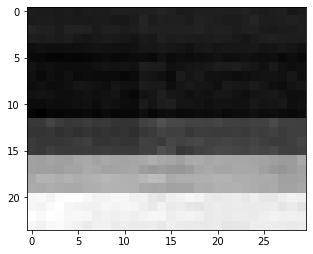

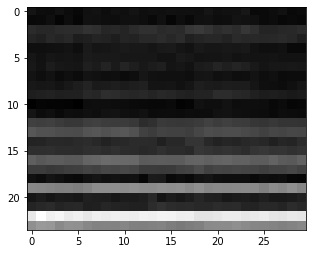

[10551/17000] loss_d: -0.374, loss_g: 0.888
[10552/17000] loss_d: -0.407, loss_g: 0.940
[10553/17000] loss_d: -0.432, loss_g: 0.858
[10554/17000] loss_d: -0.391, loss_g: 0.928
[10555/17000] loss_d: -0.382, loss_g: 0.913
[10556/17000] loss_d: -0.387, loss_g: 0.919
[10557/17000] loss_d: -0.400, loss_g: 0.946
[10558/17000] loss_d: -0.426, loss_g: 0.958
[10559/17000] loss_d: -0.405, loss_g: 0.846
[10560/17000] loss_d: -0.393, loss_g: 0.939
[10561/17000] loss_d: -0.388, loss_g: 0.916
[10562/17000] loss_d: -0.403, loss_g: 0.926
[10563/17000] loss_d: -0.386, loss_g: 0.883
[10564/17000] loss_d: -0.414, loss_g: 0.968
[10565/17000] loss_d: -0.427, loss_g: 0.929
[10566/17000] loss_d: -0.425, loss_g: 1.067
[10567/17000] loss_d: -0.415, loss_g: 0.993
[10568/17000] loss_d: -0.428, loss_g: 0.986
[10569/17000] loss_d: -0.394, loss_g: 0.974
[10570/17000] loss_d: -0.393, loss_g: 1.024
[10571/17000] loss_d: -0.420, loss_g: 1.004
[10572/17000] loss_d: -0.384, loss_g: 1.054
[10573/17000] loss_d: -0.416, lo

<Figure size 432x288 with 0 Axes>

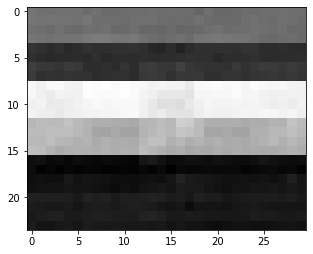

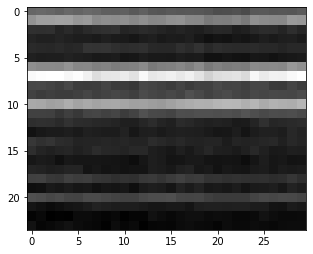

[10601/17000] loss_d: -0.382, loss_g: 1.021
[10602/17000] loss_d: -0.415, loss_g: 1.011
[10603/17000] loss_d: -0.379, loss_g: 0.988
[10604/17000] loss_d: -0.382, loss_g: 0.941
[10605/17000] loss_d: -0.412, loss_g: 0.989
[10606/17000] loss_d: -0.400, loss_g: 0.975
[10607/17000] loss_d: -0.428, loss_g: 1.077
[10608/17000] loss_d: -0.414, loss_g: 1.021
[10609/17000] loss_d: -0.411, loss_g: 1.018
[10610/17000] loss_d: -0.483, loss_g: 0.978
[10611/17000] loss_d: -0.427, loss_g: 1.065
[10612/17000] loss_d: -0.397, loss_g: 0.979
[10613/17000] loss_d: -0.400, loss_g: 0.958
[10614/17000] loss_d: -0.404, loss_g: 0.977
[10615/17000] loss_d: -0.425, loss_g: 1.003
[10616/17000] loss_d: -0.410, loss_g: 0.977
[10617/17000] loss_d: -0.385, loss_g: 1.096
[10618/17000] loss_d: -0.375, loss_g: 1.010
[10619/17000] loss_d: -0.415, loss_g: 1.018
[10620/17000] loss_d: -0.402, loss_g: 1.000
[10621/17000] loss_d: -0.402, loss_g: 0.942
[10622/17000] loss_d: -0.392, loss_g: 1.060
[10623/17000] loss_d: -0.429, lo

<Figure size 432x288 with 0 Axes>

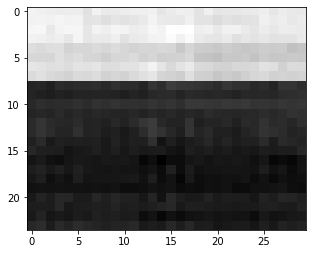

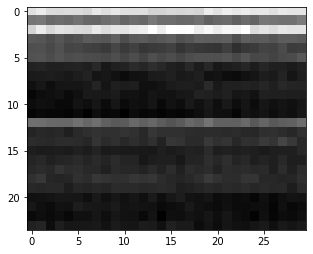

[10651/17000] loss_d: -0.398, loss_g: 0.914
[10652/17000] loss_d: -0.417, loss_g: 0.953
[10653/17000] loss_d: -0.397, loss_g: 0.972
[10654/17000] loss_d: -0.396, loss_g: 0.972
[10655/17000] loss_d: -0.384, loss_g: 0.864
[10656/17000] loss_d: -0.407, loss_g: 0.882
[10657/17000] loss_d: -0.406, loss_g: 0.963
[10658/17000] loss_d: -0.436, loss_g: 0.947
[10659/17000] loss_d: -0.419, loss_g: 0.962
[10660/17000] loss_d: -0.406, loss_g: 1.010
[10661/17000] loss_d: -0.399, loss_g: 1.002
[10662/17000] loss_d: -0.390, loss_g: 0.949
[10663/17000] loss_d: -0.417, loss_g: 0.989
[10664/17000] loss_d: -0.395, loss_g: 0.969
[10665/17000] loss_d: -0.387, loss_g: 0.973
[10666/17000] loss_d: -0.352, loss_g: 1.016
[10667/17000] loss_d: -0.395, loss_g: 0.944
[10668/17000] loss_d: -0.425, loss_g: 0.951
[10669/17000] loss_d: -0.390, loss_g: 0.988
[10670/17000] loss_d: -0.442, loss_g: 0.938
[10671/17000] loss_d: -0.381, loss_g: 0.968
[10672/17000] loss_d: -0.395, loss_g: 1.032
[10673/17000] loss_d: -0.412, lo

<Figure size 432x288 with 0 Axes>

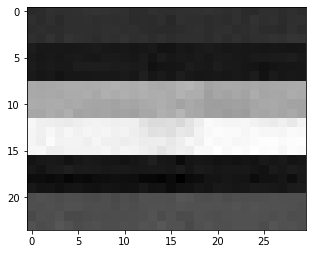

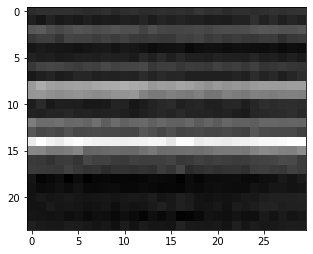

[10701/17000] loss_d: -0.428, loss_g: 0.935
[10702/17000] loss_d: -0.407, loss_g: 0.935
[10703/17000] loss_d: -0.402, loss_g: 0.956
[10704/17000] loss_d: -0.401, loss_g: 1.014
[10705/17000] loss_d: -0.382, loss_g: 0.908
[10706/17000] loss_d: -0.417, loss_g: 0.934
[10707/17000] loss_d: -0.398, loss_g: 0.968
[10708/17000] loss_d: -0.380, loss_g: 0.978
[10709/17000] loss_d: -0.379, loss_g: 0.992
[10710/17000] loss_d: -0.353, loss_g: 0.988
[10711/17000] loss_d: -0.413, loss_g: 0.874
[10712/17000] loss_d: -0.421, loss_g: 0.956
[10713/17000] loss_d: -0.375, loss_g: 0.965
[10714/17000] loss_d: -0.416, loss_g: 0.951
[10715/17000] loss_d: -0.408, loss_g: 0.892
[10716/17000] loss_d: -0.434, loss_g: 0.994
[10717/17000] loss_d: -0.407, loss_g: 0.940
[10718/17000] loss_d: -0.413, loss_g: 0.945
[10719/17000] loss_d: -0.422, loss_g: 0.934
[10720/17000] loss_d: -0.404, loss_g: 0.875
[10721/17000] loss_d: -0.384, loss_g: 0.932
[10722/17000] loss_d: -0.414, loss_g: 0.921
[10723/17000] loss_d: -0.429, lo

<Figure size 432x288 with 0 Axes>

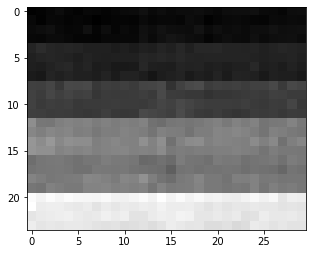

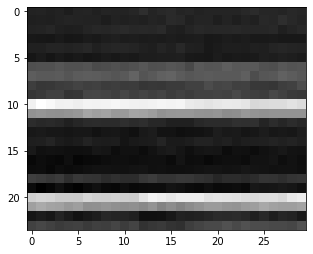

[10751/17000] loss_d: -0.403, loss_g: 0.958
[10752/17000] loss_d: -0.366, loss_g: 1.027
[10753/17000] loss_d: -0.389, loss_g: 0.968
[10754/17000] loss_d: -0.407, loss_g: 0.976
[10755/17000] loss_d: -0.384, loss_g: 0.997
[10756/17000] loss_d: -0.390, loss_g: 0.980
[10757/17000] loss_d: -0.421, loss_g: 0.922
[10758/17000] loss_d: -0.417, loss_g: 1.077
[10759/17000] loss_d: -0.422, loss_g: 0.946
[10760/17000] loss_d: -0.384, loss_g: 1.053
[10761/17000] loss_d: -0.377, loss_g: 0.978
[10762/17000] loss_d: -0.382, loss_g: 0.934
[10763/17000] loss_d: -0.414, loss_g: 1.049
[10764/17000] loss_d: -0.439, loss_g: 0.952
[10765/17000] loss_d: -0.392, loss_g: 1.025
[10766/17000] loss_d: -0.390, loss_g: 0.906
[10767/17000] loss_d: -0.400, loss_g: 0.961
[10768/17000] loss_d: -0.380, loss_g: 1.017
[10769/17000] loss_d: -0.386, loss_g: 0.959
[10770/17000] loss_d: -0.386, loss_g: 1.023
[10771/17000] loss_d: -0.391, loss_g: 0.978
[10772/17000] loss_d: -0.407, loss_g: 0.986
[10773/17000] loss_d: -0.386, lo

<Figure size 432x288 with 0 Axes>

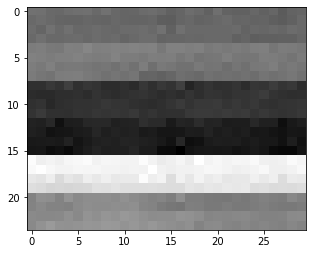

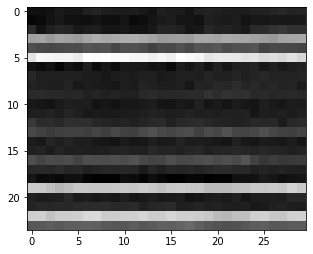

[10801/17000] loss_d: -0.425, loss_g: 1.024
[10802/17000] loss_d: -0.388, loss_g: 0.999
[10803/17000] loss_d: -0.407, loss_g: 1.056
[10804/17000] loss_d: -0.379, loss_g: 0.964
[10805/17000] loss_d: -0.400, loss_g: 0.968
[10806/17000] loss_d: -0.438, loss_g: 1.015
[10807/17000] loss_d: -0.377, loss_g: 0.899
[10808/17000] loss_d: -0.400, loss_g: 1.010
[10809/17000] loss_d: -0.367, loss_g: 1.061
[10810/17000] loss_d: -0.429, loss_g: 1.001
[10811/17000] loss_d: -0.377, loss_g: 1.004
[10812/17000] loss_d: -0.393, loss_g: 0.969
[10813/17000] loss_d: -0.396, loss_g: 1.027
[10814/17000] loss_d: -0.418, loss_g: 1.046
[10815/17000] loss_d: -0.393, loss_g: 0.971
[10816/17000] loss_d: -0.414, loss_g: 0.951
[10817/17000] loss_d: -0.405, loss_g: 0.964
[10818/17000] loss_d: -0.427, loss_g: 1.030
[10819/17000] loss_d: -0.404, loss_g: 0.939
[10820/17000] loss_d: -0.408, loss_g: 1.081
[10821/17000] loss_d: -0.418, loss_g: 0.976
[10822/17000] loss_d: -0.401, loss_g: 0.990
[10823/17000] loss_d: -0.385, lo

<Figure size 432x288 with 0 Axes>

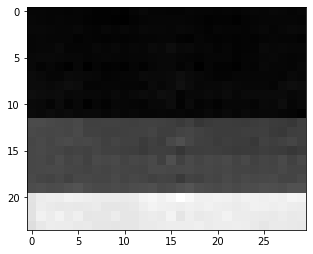

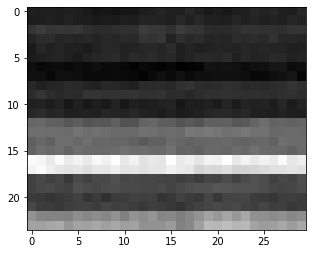

[10851/17000] loss_d: -0.397, loss_g: 0.904
[10852/17000] loss_d: -0.394, loss_g: 1.005
[10853/17000] loss_d: -0.409, loss_g: 1.050
[10854/17000] loss_d: -0.405, loss_g: 1.184
[10855/17000] loss_d: -0.426, loss_g: 1.018
[10856/17000] loss_d: -0.433, loss_g: 0.984
[10857/17000] loss_d: -0.395, loss_g: 1.001
[10858/17000] loss_d: -0.404, loss_g: 0.953
[10859/17000] loss_d: -0.387, loss_g: 0.972
[10860/17000] loss_d: -0.401, loss_g: 0.993
[10861/17000] loss_d: -0.402, loss_g: 1.027
[10862/17000] loss_d: -0.394, loss_g: 0.948
[10863/17000] loss_d: -0.378, loss_g: 1.050
[10864/17000] loss_d: -0.404, loss_g: 1.041
[10865/17000] loss_d: -0.400, loss_g: 1.065
[10866/17000] loss_d: -0.418, loss_g: 1.142
[10867/17000] loss_d: -0.406, loss_g: 1.012
[10868/17000] loss_d: -0.379, loss_g: 1.055
[10869/17000] loss_d: -0.394, loss_g: 0.987
[10870/17000] loss_d: -0.436, loss_g: 0.996
[10871/17000] loss_d: -0.442, loss_g: 1.057
[10872/17000] loss_d: -0.420, loss_g: 1.041
[10873/17000] loss_d: -0.377, lo

<Figure size 432x288 with 0 Axes>

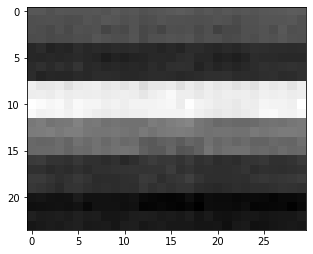

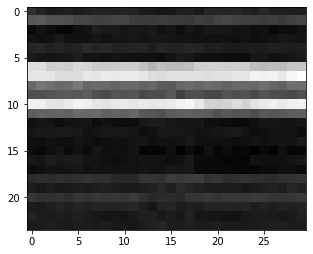

[10901/17000] loss_d: -0.421, loss_g: 1.076
[10902/17000] loss_d: -0.418, loss_g: 0.953
[10903/17000] loss_d: -0.411, loss_g: 0.964
[10904/17000] loss_d: -0.389, loss_g: 1.019
[10905/17000] loss_d: -0.368, loss_g: 0.899
[10906/17000] loss_d: -0.425, loss_g: 1.021
[10907/17000] loss_d: -0.413, loss_g: 0.876
[10908/17000] loss_d: -0.423, loss_g: 0.951
[10909/17000] loss_d: -0.386, loss_g: 0.833
[10910/17000] loss_d: -0.377, loss_g: 0.934
[10911/17000] loss_d: -0.428, loss_g: 0.971
[10912/17000] loss_d: -0.385, loss_g: 1.018
[10913/17000] loss_d: -0.380, loss_g: 1.008
[10914/17000] loss_d: -0.388, loss_g: 0.910
[10915/17000] loss_d: -0.371, loss_g: 0.934
[10916/17000] loss_d: -0.381, loss_g: 0.990
[10917/17000] loss_d: -0.391, loss_g: 0.965
[10918/17000] loss_d: -0.433, loss_g: 1.026
[10919/17000] loss_d: -0.407, loss_g: 0.954
[10920/17000] loss_d: -0.415, loss_g: 1.043
[10921/17000] loss_d: -0.406, loss_g: 0.980
[10922/17000] loss_d: -0.405, loss_g: 0.906
[10923/17000] loss_d: -0.420, lo

<Figure size 432x288 with 0 Axes>

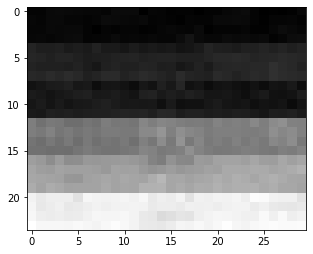

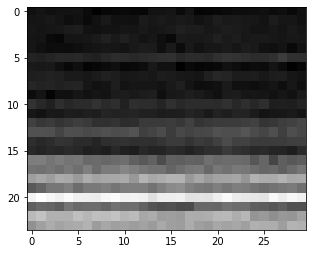

[10951/17000] loss_d: -0.405, loss_g: 1.001
[10952/17000] loss_d: -0.418, loss_g: 1.006
[10953/17000] loss_d: -0.437, loss_g: 0.954
[10954/17000] loss_d: -0.393, loss_g: 1.037
[10955/17000] loss_d: -0.385, loss_g: 0.981
[10956/17000] loss_d: -0.421, loss_g: 1.020
[10957/17000] loss_d: -0.426, loss_g: 0.976
[10958/17000] loss_d: -0.424, loss_g: 0.968
[10959/17000] loss_d: -0.373, loss_g: 1.009
[10960/17000] loss_d: -0.408, loss_g: 1.007
[10961/17000] loss_d: -0.421, loss_g: 0.934
[10962/17000] loss_d: -0.363, loss_g: 0.980
[10963/17000] loss_d: -0.416, loss_g: 0.973
[10964/17000] loss_d: -0.356, loss_g: 1.021
[10965/17000] loss_d: -0.403, loss_g: 0.961
[10966/17000] loss_d: -0.402, loss_g: 0.985
[10967/17000] loss_d: -0.382, loss_g: 0.976
[10968/17000] loss_d: -0.379, loss_g: 0.990
[10969/17000] loss_d: -0.394, loss_g: 0.912
[10970/17000] loss_d: -0.396, loss_g: 0.946
[10971/17000] loss_d: -0.410, loss_g: 0.931
[10972/17000] loss_d: -0.376, loss_g: 0.947
[10973/17000] loss_d: -0.396, lo

<Figure size 432x288 with 0 Axes>

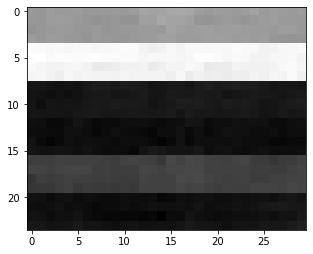

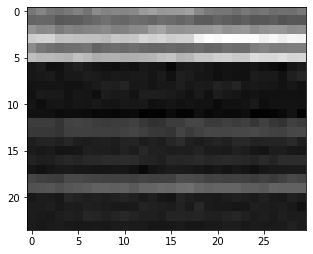

[11001/17000] loss_d: -0.432, loss_g: 0.948
[11002/17000] loss_d: -0.427, loss_g: 0.985
[11003/17000] loss_d: -0.409, loss_g: 0.934
[11004/17000] loss_d: -0.376, loss_g: 0.932
[11005/17000] loss_d: -0.378, loss_g: 0.946
[11006/17000] loss_d: -0.422, loss_g: 0.891
[11007/17000] loss_d: -0.378, loss_g: 0.974
[11008/17000] loss_d: -0.373, loss_g: 0.938
[11009/17000] loss_d: -0.397, loss_g: 1.004
[11010/17000] loss_d: -0.393, loss_g: 0.895
[11011/17000] loss_d: -0.382, loss_g: 0.944
[11012/17000] loss_d: -0.357, loss_g: 1.005
[11013/17000] loss_d: -0.377, loss_g: 0.985
[11014/17000] loss_d: -0.419, loss_g: 1.004
[11015/17000] loss_d: -0.364, loss_g: 0.996
[11016/17000] loss_d: -0.420, loss_g: 0.989
[11017/17000] loss_d: -0.424, loss_g: 0.997
[11018/17000] loss_d: -0.375, loss_g: 0.996
[11019/17000] loss_d: -0.398, loss_g: 0.986
[11020/17000] loss_d: -0.413, loss_g: 0.937
[11021/17000] loss_d: -0.419, loss_g: 0.877
[11022/17000] loss_d: -0.401, loss_g: 0.900
[11023/17000] loss_d: -0.387, lo

<Figure size 432x288 with 0 Axes>

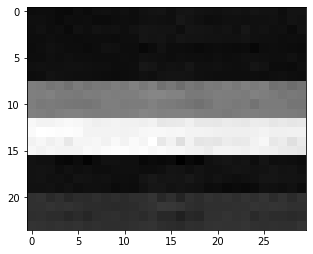

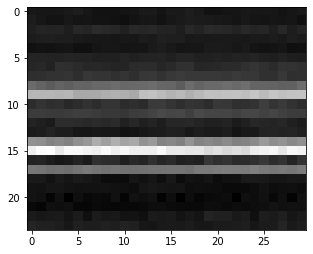

[11051/17000] loss_d: -0.456, loss_g: 0.963
[11052/17000] loss_d: -0.416, loss_g: 0.946
[11053/17000] loss_d: -0.416, loss_g: 0.949
[11054/17000] loss_d: -0.388, loss_g: 1.023
[11055/17000] loss_d: -0.407, loss_g: 0.988
[11056/17000] loss_d: -0.415, loss_g: 0.963
[11057/17000] loss_d: -0.448, loss_g: 1.037
[11058/17000] loss_d: -0.392, loss_g: 1.021
[11059/17000] loss_d: -0.372, loss_g: 0.975
[11060/17000] loss_d: -0.405, loss_g: 0.974
[11061/17000] loss_d: -0.391, loss_g: 0.954
[11062/17000] loss_d: -0.401, loss_g: 0.933
[11063/17000] loss_d: -0.427, loss_g: 0.960
[11064/17000] loss_d: -0.385, loss_g: 0.954
[11065/17000] loss_d: -0.388, loss_g: 0.919
[11066/17000] loss_d: -0.381, loss_g: 1.021
[11067/17000] loss_d: -0.389, loss_g: 0.930
[11068/17000] loss_d: -0.409, loss_g: 0.940
[11069/17000] loss_d: -0.408, loss_g: 0.965
[11070/17000] loss_d: -0.383, loss_g: 1.006
[11071/17000] loss_d: -0.426, loss_g: 0.978
[11072/17000] loss_d: -0.401, loss_g: 1.007
[11073/17000] loss_d: -0.363, lo

<Figure size 432x288 with 0 Axes>

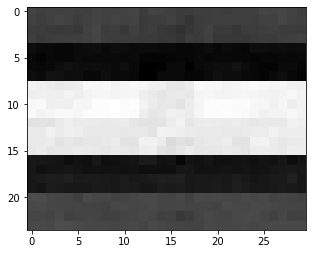

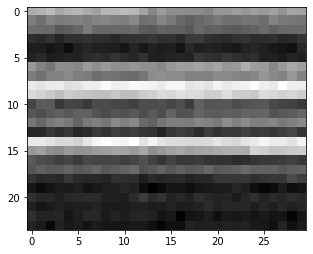

[11101/17000] loss_d: -0.406, loss_g: 0.829
[11102/17000] loss_d: -0.400, loss_g: 0.837
[11103/17000] loss_d: -0.366, loss_g: 0.892
[11104/17000] loss_d: -0.466, loss_g: 0.882
[11105/17000] loss_d: -0.375, loss_g: 0.888
[11106/17000] loss_d: -0.369, loss_g: 0.894
[11107/17000] loss_d: -0.423, loss_g: 0.898
[11108/17000] loss_d: -0.366, loss_g: 0.907
[11109/17000] loss_d: -0.391, loss_g: 0.837
[11110/17000] loss_d: -0.392, loss_g: 0.896
[11111/17000] loss_d: -0.418, loss_g: 0.846
[11112/17000] loss_d: -0.395, loss_g: 0.892
[11113/17000] loss_d: -0.417, loss_g: 0.947
[11114/17000] loss_d: -0.409, loss_g: 0.906
[11115/17000] loss_d: -0.389, loss_g: 0.987
[11116/17000] loss_d: -0.397, loss_g: 0.888
[11117/17000] loss_d: -0.429, loss_g: 0.995
[11118/17000] loss_d: -0.398, loss_g: 0.900
[11119/17000] loss_d: -0.392, loss_g: 0.866
[11120/17000] loss_d: -0.430, loss_g: 1.006
[11121/17000] loss_d: -0.406, loss_g: 0.890
[11122/17000] loss_d: -0.374, loss_g: 0.932
[11123/17000] loss_d: -0.409, lo

<Figure size 432x288 with 0 Axes>

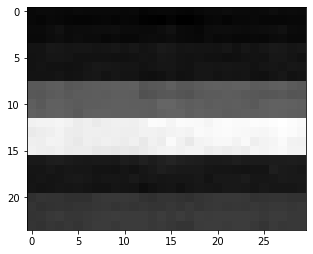

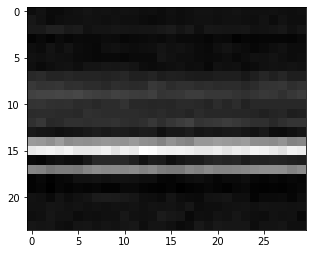

[11151/17000] loss_d: -0.415, loss_g: 0.956
[11152/17000] loss_d: -0.393, loss_g: 0.876
[11153/17000] loss_d: -0.395, loss_g: 0.901
[11154/17000] loss_d: -0.405, loss_g: 0.919
[11155/17000] loss_d: -0.388, loss_g: 0.877
[11156/17000] loss_d: -0.406, loss_g: 0.875
[11157/17000] loss_d: -0.407, loss_g: 0.916
[11158/17000] loss_d: -0.398, loss_g: 0.840
[11159/17000] loss_d: -0.387, loss_g: 0.871
[11160/17000] loss_d: -0.354, loss_g: 0.834
[11161/17000] loss_d: -0.385, loss_g: 0.891
[11162/17000] loss_d: -0.394, loss_g: 0.865
[11163/17000] loss_d: -0.386, loss_g: 0.914
[11164/17000] loss_d: -0.403, loss_g: 0.962
[11165/17000] loss_d: -0.424, loss_g: 0.889
[11166/17000] loss_d: -0.372, loss_g: 0.911
[11167/17000] loss_d: -0.391, loss_g: 0.908
[11168/17000] loss_d: -0.352, loss_g: 0.869
[11169/17000] loss_d: -0.407, loss_g: 0.908
[11170/17000] loss_d: -0.411, loss_g: 0.937
[11171/17000] loss_d: -0.395, loss_g: 0.977
[11172/17000] loss_d: -0.424, loss_g: 0.942
[11173/17000] loss_d: -0.415, lo

<Figure size 432x288 with 0 Axes>

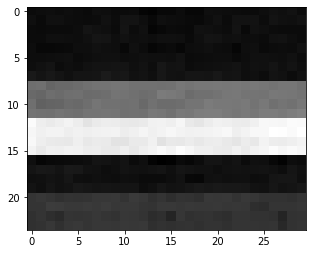

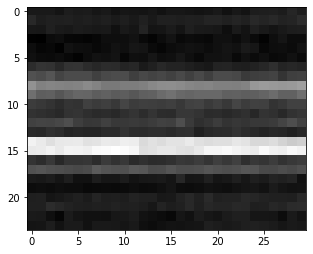

[11201/17000] loss_d: -0.387, loss_g: 0.906
[11202/17000] loss_d: -0.416, loss_g: 0.943
[11203/17000] loss_d: -0.423, loss_g: 0.850
[11204/17000] loss_d: -0.386, loss_g: 0.869
[11205/17000] loss_d: -0.404, loss_g: 0.844
[11206/17000] loss_d: -0.392, loss_g: 0.885
[11207/17000] loss_d: -0.392, loss_g: 0.884
[11208/17000] loss_d: -0.428, loss_g: 0.913
[11209/17000] loss_d: -0.393, loss_g: 0.955
[11210/17000] loss_d: -0.463, loss_g: 0.940
[11211/17000] loss_d: -0.374, loss_g: 0.894
[11212/17000] loss_d: -0.437, loss_g: 0.935
[11213/17000] loss_d: -0.407, loss_g: 0.962
[11214/17000] loss_d: -0.400, loss_g: 0.910
[11215/17000] loss_d: -0.404, loss_g: 0.892
[11216/17000] loss_d: -0.395, loss_g: 0.959
[11217/17000] loss_d: -0.398, loss_g: 0.820
[11218/17000] loss_d: -0.394, loss_g: 0.931
[11219/17000] loss_d: -0.401, loss_g: 0.895
[11220/17000] loss_d: -0.397, loss_g: 0.943
[11221/17000] loss_d: -0.374, loss_g: 0.897
[11222/17000] loss_d: -0.416, loss_g: 0.881
[11223/17000] loss_d: -0.406, lo

<Figure size 432x288 with 0 Axes>

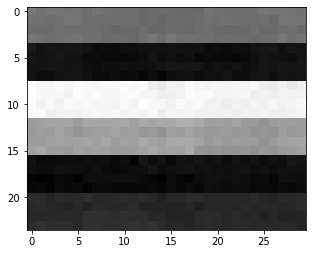

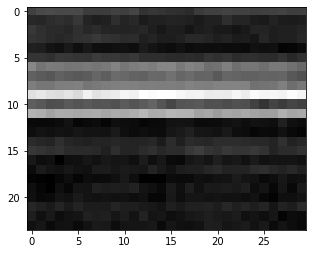

[11251/17000] loss_d: -0.392, loss_g: 0.965
[11252/17000] loss_d: -0.387, loss_g: 0.956
[11253/17000] loss_d: -0.406, loss_g: 0.997
[11254/17000] loss_d: -0.397, loss_g: 0.960
[11255/17000] loss_d: -0.440, loss_g: 0.963
[11256/17000] loss_d: -0.390, loss_g: 1.034
[11257/17000] loss_d: -0.389, loss_g: 1.005
[11258/17000] loss_d: -0.399, loss_g: 1.026
[11259/17000] loss_d: -0.395, loss_g: 0.958
[11260/17000] loss_d: -0.442, loss_g: 0.936
[11261/17000] loss_d: -0.426, loss_g: 1.028
[11262/17000] loss_d: -0.414, loss_g: 0.946
[11263/17000] loss_d: -0.367, loss_g: 1.065
[11264/17000] loss_d: -0.403, loss_g: 1.063
[11265/17000] loss_d: -0.403, loss_g: 1.036
[11266/17000] loss_d: -0.386, loss_g: 0.884
[11267/17000] loss_d: -0.416, loss_g: 0.963
[11268/17000] loss_d: -0.424, loss_g: 0.986
[11269/17000] loss_d: -0.407, loss_g: 0.887
[11270/17000] loss_d: -0.317, loss_g: 1.024
[11271/17000] loss_d: -0.398, loss_g: 0.946
[11272/17000] loss_d: -0.404, loss_g: 1.034
[11273/17000] loss_d: -0.414, lo

<Figure size 432x288 with 0 Axes>

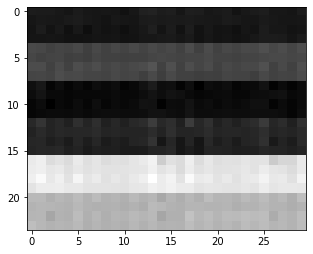

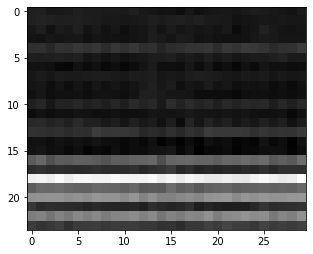

[11301/17000] loss_d: -0.417, loss_g: 0.945
[11302/17000] loss_d: -0.384, loss_g: 0.959
[11303/17000] loss_d: -0.424, loss_g: 0.870
[11304/17000] loss_d: -0.411, loss_g: 0.968
[11305/17000] loss_d: -0.418, loss_g: 0.909
[11306/17000] loss_d: -0.405, loss_g: 0.944
[11307/17000] loss_d: -0.414, loss_g: 0.856
[11308/17000] loss_d: -0.416, loss_g: 0.885
[11309/17000] loss_d: -0.386, loss_g: 0.872
[11310/17000] loss_d: -0.425, loss_g: 0.951
[11311/17000] loss_d: -0.401, loss_g: 0.909
[11312/17000] loss_d: -0.397, loss_g: 0.969
[11313/17000] loss_d: -0.394, loss_g: 0.903
[11314/17000] loss_d: -0.403, loss_g: 0.894
[11315/17000] loss_d: -0.389, loss_g: 1.011
[11316/17000] loss_d: -0.419, loss_g: 0.958
[11317/17000] loss_d: -0.407, loss_g: 0.988
[11318/17000] loss_d: -0.407, loss_g: 1.000
[11319/17000] loss_d: -0.399, loss_g: 0.923
[11320/17000] loss_d: -0.387, loss_g: 0.937
[11321/17000] loss_d: -0.397, loss_g: 0.997
[11322/17000] loss_d: -0.362, loss_g: 0.948
[11323/17000] loss_d: -0.386, lo

<Figure size 432x288 with 0 Axes>

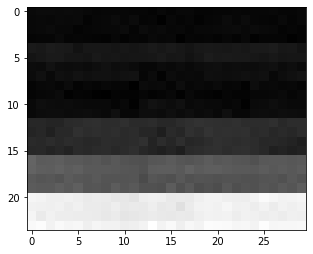

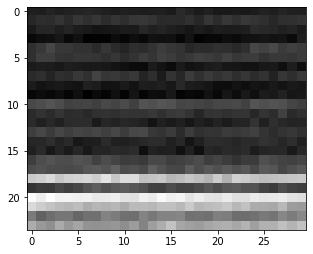

[11351/17000] loss_d: -0.415, loss_g: 0.961
[11352/17000] loss_d: -0.377, loss_g: 0.895
[11353/17000] loss_d: -0.419, loss_g: 0.845
[11354/17000] loss_d: -0.418, loss_g: 1.001
[11355/17000] loss_d: -0.383, loss_g: 0.967
[11356/17000] loss_d: -0.373, loss_g: 0.976
[11357/17000] loss_d: -0.414, loss_g: 0.878
[11358/17000] loss_d: -0.393, loss_g: 0.859
[11359/17000] loss_d: -0.432, loss_g: 0.942
[11360/17000] loss_d: -0.365, loss_g: 0.957
[11361/17000] loss_d: -0.422, loss_g: 0.942
[11362/17000] loss_d: -0.393, loss_g: 1.037
[11363/17000] loss_d: -0.387, loss_g: 1.032
[11364/17000] loss_d: -0.422, loss_g: 0.930
[11365/17000] loss_d: -0.436, loss_g: 0.882
[11366/17000] loss_d: -0.390, loss_g: 0.950
[11367/17000] loss_d: -0.385, loss_g: 1.073
[11368/17000] loss_d: -0.427, loss_g: 0.931
[11369/17000] loss_d: -0.396, loss_g: 0.954
[11370/17000] loss_d: -0.397, loss_g: 0.983
[11371/17000] loss_d: -0.400, loss_g: 1.015
[11372/17000] loss_d: -0.391, loss_g: 0.948
[11373/17000] loss_d: -0.403, lo

<Figure size 432x288 with 0 Axes>

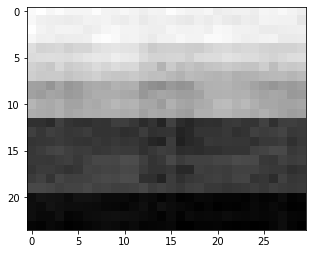

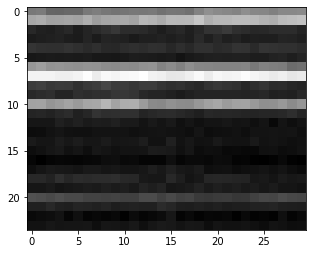

[11401/17000] loss_d: -0.410, loss_g: 0.902
[11402/17000] loss_d: -0.416, loss_g: 0.886
[11403/17000] loss_d: -0.399, loss_g: 0.929
[11404/17000] loss_d: -0.416, loss_g: 1.013
[11405/17000] loss_d: -0.377, loss_g: 0.972
[11406/17000] loss_d: -0.412, loss_g: 1.032
[11407/17000] loss_d: -0.406, loss_g: 0.927
[11408/17000] loss_d: -0.400, loss_g: 0.984
[11409/17000] loss_d: -0.387, loss_g: 0.931
[11410/17000] loss_d: -0.407, loss_g: 0.971
[11411/17000] loss_d: -0.397, loss_g: 0.963
[11412/17000] loss_d: -0.395, loss_g: 1.040
[11413/17000] loss_d: -0.422, loss_g: 0.952
[11414/17000] loss_d: -0.395, loss_g: 0.967
[11415/17000] loss_d: -0.409, loss_g: 0.938
[11416/17000] loss_d: -0.378, loss_g: 0.959
[11417/17000] loss_d: -0.397, loss_g: 1.042
[11418/17000] loss_d: -0.396, loss_g: 0.901
[11419/17000] loss_d: -0.407, loss_g: 0.958
[11420/17000] loss_d: -0.406, loss_g: 0.972
[11421/17000] loss_d: -0.406, loss_g: 1.035
[11422/17000] loss_d: -0.407, loss_g: 1.009
[11423/17000] loss_d: -0.412, lo

<Figure size 432x288 with 0 Axes>

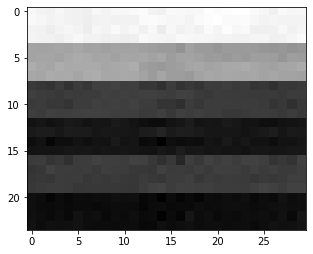

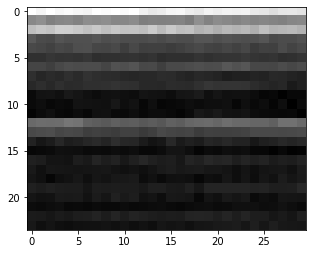

[11451/17000] loss_d: -0.416, loss_g: 0.942
[11452/17000] loss_d: -0.401, loss_g: 0.911
[11453/17000] loss_d: -0.381, loss_g: 0.899
[11454/17000] loss_d: -0.411, loss_g: 0.972
[11455/17000] loss_d: -0.412, loss_g: 0.961
[11456/17000] loss_d: -0.383, loss_g: 1.033
[11457/17000] loss_d: -0.396, loss_g: 0.954
[11458/17000] loss_d: -0.406, loss_g: 1.027
[11459/17000] loss_d: -0.401, loss_g: 1.028
[11460/17000] loss_d: -0.416, loss_g: 0.974
[11461/17000] loss_d: -0.406, loss_g: 0.987
[11462/17000] loss_d: -0.411, loss_g: 1.014
[11463/17000] loss_d: -0.404, loss_g: 1.006
[11464/17000] loss_d: -0.392, loss_g: 0.999
[11465/17000] loss_d: -0.377, loss_g: 0.993
[11466/17000] loss_d: -0.401, loss_g: 0.992
[11467/17000] loss_d: -0.417, loss_g: 0.974
[11468/17000] loss_d: -0.401, loss_g: 0.941
[11469/17000] loss_d: -0.417, loss_g: 0.909
[11470/17000] loss_d: -0.423, loss_g: 0.980
[11471/17000] loss_d: -0.383, loss_g: 0.920
[11472/17000] loss_d: -0.393, loss_g: 0.905
[11473/17000] loss_d: -0.397, lo

<Figure size 432x288 with 0 Axes>

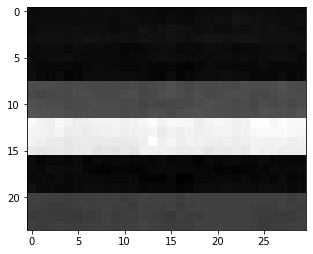

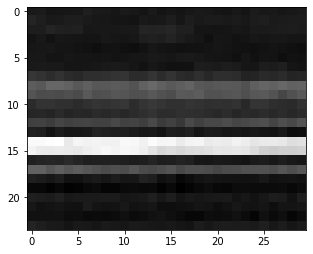

[11501/17000] loss_d: -0.382, loss_g: 0.889
[11502/17000] loss_d: -0.395, loss_g: 0.958
[11503/17000] loss_d: -0.394, loss_g: 0.967
[11504/17000] loss_d: -0.369, loss_g: 0.919
[11505/17000] loss_d: -0.403, loss_g: 0.995
[11506/17000] loss_d: -0.403, loss_g: 0.962
[11507/17000] loss_d: -0.416, loss_g: 0.921
[11508/17000] loss_d: -0.430, loss_g: 0.946
[11509/17000] loss_d: -0.426, loss_g: 0.892
[11510/17000] loss_d: -0.418, loss_g: 0.982
[11511/17000] loss_d: -0.401, loss_g: 0.946
[11512/17000] loss_d: -0.375, loss_g: 0.980
[11513/17000] loss_d: -0.413, loss_g: 0.910
[11514/17000] loss_d: -0.462, loss_g: 0.919
[11515/17000] loss_d: -0.400, loss_g: 0.943
[11516/17000] loss_d: -0.380, loss_g: 1.021
[11517/17000] loss_d: -0.380, loss_g: 0.889
[11518/17000] loss_d: -0.407, loss_g: 0.956
[11519/17000] loss_d: -0.396, loss_g: 0.902
[11520/17000] loss_d: -0.412, loss_g: 0.899
[11521/17000] loss_d: -0.422, loss_g: 0.917
[11522/17000] loss_d: -0.438, loss_g: 0.947
[11523/17000] loss_d: -0.448, lo

<Figure size 432x288 with 0 Axes>

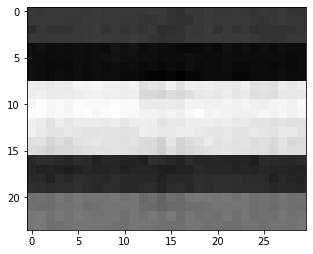

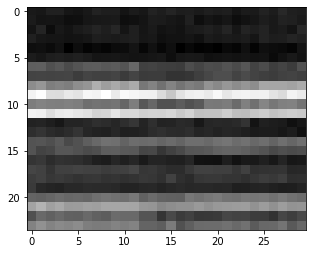

[11551/17000] loss_d: -0.393, loss_g: 0.957
[11552/17000] loss_d: -0.398, loss_g: 0.923
[11553/17000] loss_d: -0.390, loss_g: 1.009
[11554/17000] loss_d: -0.416, loss_g: 0.963
[11555/17000] loss_d: -0.415, loss_g: 0.855
[11556/17000] loss_d: -0.399, loss_g: 1.000
[11557/17000] loss_d: -0.413, loss_g: 1.029
[11558/17000] loss_d: -0.402, loss_g: 1.007
[11559/17000] loss_d: -0.373, loss_g: 1.057
[11560/17000] loss_d: -0.430, loss_g: 0.970
[11561/17000] loss_d: -0.413, loss_g: 1.041
[11562/17000] loss_d: -0.407, loss_g: 1.077
[11563/17000] loss_d: -0.407, loss_g: 0.947
[11564/17000] loss_d: -0.408, loss_g: 1.021
[11565/17000] loss_d: -0.398, loss_g: 1.067
[11566/17000] loss_d: -0.397, loss_g: 1.005
[11567/17000] loss_d: -0.386, loss_g: 1.014
[11568/17000] loss_d: -0.401, loss_g: 0.987
[11569/17000] loss_d: -0.425, loss_g: 0.940
[11570/17000] loss_d: -0.416, loss_g: 1.017
[11571/17000] loss_d: -0.406, loss_g: 0.987
[11572/17000] loss_d: -0.387, loss_g: 1.007
[11573/17000] loss_d: -0.386, lo

<Figure size 432x288 with 0 Axes>

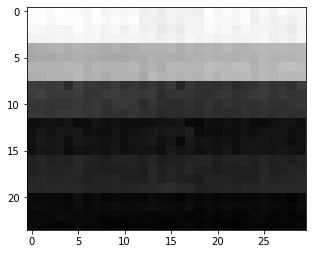

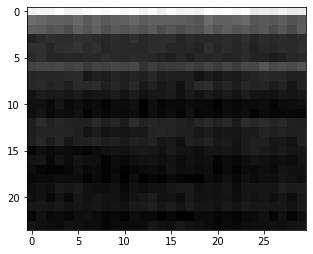

[11601/17000] loss_d: -0.425, loss_g: 1.041
[11602/17000] loss_d: -0.384, loss_g: 0.987
[11603/17000] loss_d: -0.389, loss_g: 1.001
[11604/17000] loss_d: -0.372, loss_g: 0.991
[11605/17000] loss_d: -0.407, loss_g: 0.996
[11606/17000] loss_d: -0.371, loss_g: 1.012
[11607/17000] loss_d: -0.371, loss_g: 1.000
[11608/17000] loss_d: -0.432, loss_g: 1.005
[11609/17000] loss_d: -0.388, loss_g: 0.983
[11610/17000] loss_d: -0.406, loss_g: 0.990
[11611/17000] loss_d: -0.409, loss_g: 1.020
[11612/17000] loss_d: -0.391, loss_g: 0.969
[11613/17000] loss_d: -0.356, loss_g: 0.975
[11614/17000] loss_d: -0.414, loss_g: 0.959
[11615/17000] loss_d: -0.438, loss_g: 1.010
[11616/17000] loss_d: -0.378, loss_g: 0.923
[11617/17000] loss_d: -0.389, loss_g: 0.958
[11618/17000] loss_d: -0.380, loss_g: 1.035
[11619/17000] loss_d: -0.401, loss_g: 0.965
[11620/17000] loss_d: -0.422, loss_g: 0.964
[11621/17000] loss_d: -0.394, loss_g: 1.014
[11622/17000] loss_d: -0.407, loss_g: 0.959
[11623/17000] loss_d: -0.407, lo

<Figure size 432x288 with 0 Axes>

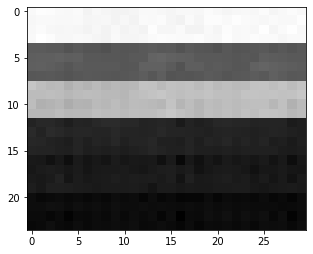

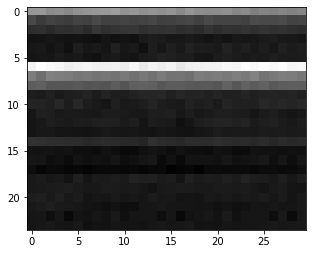

[11651/17000] loss_d: -0.402, loss_g: 1.024
[11652/17000] loss_d: -0.406, loss_g: 1.006
[11653/17000] loss_d: -0.419, loss_g: 0.923
[11654/17000] loss_d: -0.372, loss_g: 0.992
[11655/17000] loss_d: -0.439, loss_g: 1.009
[11656/17000] loss_d: -0.413, loss_g: 1.039
[11657/17000] loss_d: -0.423, loss_g: 0.912
[11658/17000] loss_d: -0.391, loss_g: 0.996
[11659/17000] loss_d: -0.379, loss_g: 1.061
[11660/17000] loss_d: -0.385, loss_g: 1.022
[11661/17000] loss_d: -0.406, loss_g: 0.982
[11662/17000] loss_d: -0.405, loss_g: 0.970
[11663/17000] loss_d: -0.419, loss_g: 0.979
[11664/17000] loss_d: -0.393, loss_g: 0.975
[11665/17000] loss_d: -0.407, loss_g: 0.971
[11666/17000] loss_d: -0.376, loss_g: 0.989
[11667/17000] loss_d: -0.441, loss_g: 0.995
[11668/17000] loss_d: -0.448, loss_g: 1.069
[11669/17000] loss_d: -0.414, loss_g: 0.994
[11670/17000] loss_d: -0.416, loss_g: 0.986
[11671/17000] loss_d: -0.384, loss_g: 0.949
[11672/17000] loss_d: -0.416, loss_g: 0.955
[11673/17000] loss_d: -0.419, lo

<Figure size 432x288 with 0 Axes>

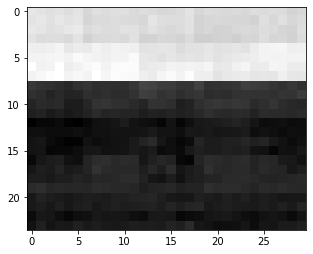

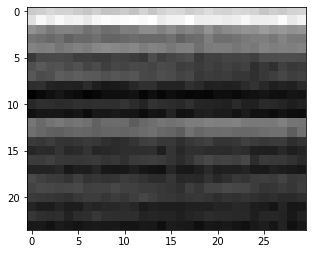

[11701/17000] loss_d: -0.420, loss_g: 0.928
[11702/17000] loss_d: -0.416, loss_g: 0.946
[11703/17000] loss_d: -0.412, loss_g: 1.035
[11704/17000] loss_d: -0.365, loss_g: 1.025
[11705/17000] loss_d: -0.395, loss_g: 0.940
[11706/17000] loss_d: -0.399, loss_g: 0.985
[11707/17000] loss_d: -0.363, loss_g: 0.975
[11708/17000] loss_d: -0.395, loss_g: 0.810
[11709/17000] loss_d: -0.378, loss_g: 0.910
[11710/17000] loss_d: -0.402, loss_g: 0.889
[11711/17000] loss_d: -0.420, loss_g: 0.928
[11712/17000] loss_d: -0.385, loss_g: 0.918
[11713/17000] loss_d: -0.386, loss_g: 1.023
[11714/17000] loss_d: -0.409, loss_g: 0.953
[11715/17000] loss_d: -0.412, loss_g: 0.932
[11716/17000] loss_d: -0.441, loss_g: 0.930
[11717/17000] loss_d: -0.416, loss_g: 0.848
[11718/17000] loss_d: -0.372, loss_g: 0.880
[11719/17000] loss_d: -0.415, loss_g: 1.005
[11720/17000] loss_d: -0.381, loss_g: 0.998
[11721/17000] loss_d: -0.397, loss_g: 0.935
[11722/17000] loss_d: -0.379, loss_g: 0.943
[11723/17000] loss_d: -0.428, lo

<Figure size 432x288 with 0 Axes>

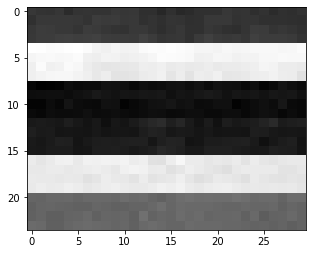

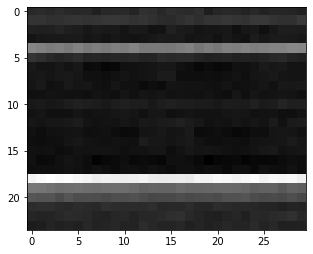

[11751/17000] loss_d: -0.418, loss_g: 0.959
[11752/17000] loss_d: -0.416, loss_g: 1.022
[11753/17000] loss_d: -0.402, loss_g: 1.030
[11754/17000] loss_d: -0.390, loss_g: 0.955
[11755/17000] loss_d: -0.412, loss_g: 0.973
[11756/17000] loss_d: -0.402, loss_g: 1.006
[11757/17000] loss_d: -0.409, loss_g: 0.902
[11758/17000] loss_d: -0.385, loss_g: 0.976
[11759/17000] loss_d: -0.410, loss_g: 0.948
[11760/17000] loss_d: -0.400, loss_g: 0.884
[11761/17000] loss_d: -0.429, loss_g: 0.947
[11762/17000] loss_d: -0.426, loss_g: 0.934
[11763/17000] loss_d: -0.399, loss_g: 0.964
[11764/17000] loss_d: -0.439, loss_g: 1.059
[11765/17000] loss_d: -0.441, loss_g: 0.914
[11766/17000] loss_d: -0.383, loss_g: 1.034
[11767/17000] loss_d: -0.431, loss_g: 0.963
[11768/17000] loss_d: -0.375, loss_g: 0.986
[11769/17000] loss_d: -0.397, loss_g: 0.958
[11770/17000] loss_d: -0.393, loss_g: 0.911
[11771/17000] loss_d: -0.432, loss_g: 1.016
[11772/17000] loss_d: -0.371, loss_g: 0.948
[11773/17000] loss_d: -0.404, lo

<Figure size 432x288 with 0 Axes>

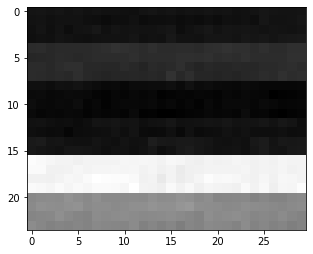

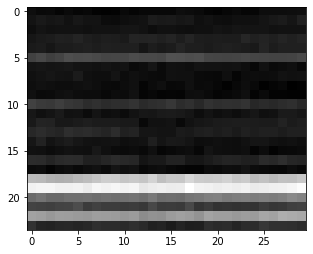

[11801/17000] loss_d: -0.403, loss_g: 0.931
[11802/17000] loss_d: -0.433, loss_g: 0.894
[11803/17000] loss_d: -0.377, loss_g: 0.901
[11804/17000] loss_d: -0.400, loss_g: 0.901
[11805/17000] loss_d: -0.446, loss_g: 0.956
[11806/17000] loss_d: -0.386, loss_g: 0.983
[11807/17000] loss_d: -0.410, loss_g: 0.954
[11808/17000] loss_d: -0.393, loss_g: 0.971
[11809/17000] loss_d: -0.385, loss_g: 1.004
[11810/17000] loss_d: -0.392, loss_g: 0.974
[11811/17000] loss_d: -0.385, loss_g: 0.881
[11812/17000] loss_d: -0.377, loss_g: 0.978
[11813/17000] loss_d: -0.413, loss_g: 1.008
[11814/17000] loss_d: -0.385, loss_g: 0.950
[11815/17000] loss_d: -0.392, loss_g: 0.923
[11816/17000] loss_d: -0.411, loss_g: 0.865
[11817/17000] loss_d: -0.438, loss_g: 0.922
[11818/17000] loss_d: -0.393, loss_g: 0.985
[11819/17000] loss_d: -0.391, loss_g: 0.953
[11820/17000] loss_d: -0.361, loss_g: 0.955
[11821/17000] loss_d: -0.376, loss_g: 1.004
[11822/17000] loss_d: -0.399, loss_g: 1.032
[11823/17000] loss_d: -0.386, lo

<Figure size 432x288 with 0 Axes>

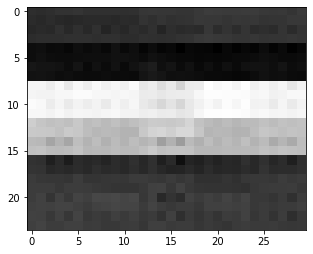

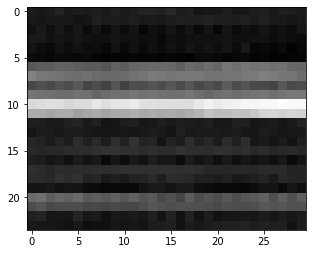

[11851/17000] loss_d: -0.428, loss_g: 0.969
[11852/17000] loss_d: -0.417, loss_g: 0.949
[11853/17000] loss_d: -0.397, loss_g: 0.978
[11854/17000] loss_d: -0.377, loss_g: 0.969
[11855/17000] loss_d: -0.415, loss_g: 0.960
[11856/17000] loss_d: -0.418, loss_g: 1.019
[11857/17000] loss_d: -0.417, loss_g: 1.001
[11858/17000] loss_d: -0.405, loss_g: 0.919
[11859/17000] loss_d: -0.400, loss_g: 0.994
[11860/17000] loss_d: -0.385, loss_g: 0.988
[11861/17000] loss_d: -0.381, loss_g: 0.962
[11862/17000] loss_d: -0.389, loss_g: 1.013
[11863/17000] loss_d: -0.381, loss_g: 0.966
[11864/17000] loss_d: -0.413, loss_g: 1.041
[11865/17000] loss_d: -0.396, loss_g: 0.994
[11866/17000] loss_d: -0.392, loss_g: 0.974
[11867/17000] loss_d: -0.373, loss_g: 1.073
[11868/17000] loss_d: -0.401, loss_g: 0.951
[11869/17000] loss_d: -0.397, loss_g: 0.995
[11870/17000] loss_d: -0.408, loss_g: 0.977
[11871/17000] loss_d: -0.395, loss_g: 0.953
[11872/17000] loss_d: -0.420, loss_g: 0.972
[11873/17000] loss_d: -0.418, lo

<Figure size 432x288 with 0 Axes>

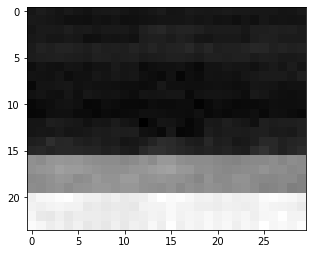

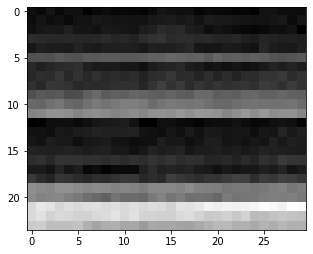

[11901/17000] loss_d: -0.404, loss_g: 0.975
[11902/17000] loss_d: -0.401, loss_g: 1.019
[11903/17000] loss_d: -0.410, loss_g: 0.990
[11904/17000] loss_d: -0.414, loss_g: 1.043
[11905/17000] loss_d: -0.431, loss_g: 1.055
[11906/17000] loss_d: -0.419, loss_g: 0.966
[11907/17000] loss_d: -0.393, loss_g: 1.050
[11908/17000] loss_d: -0.406, loss_g: 1.069
[11909/17000] loss_d: -0.408, loss_g: 0.968
[11910/17000] loss_d: -0.392, loss_g: 0.959
[11911/17000] loss_d: -0.355, loss_g: 1.056
[11912/17000] loss_d: -0.429, loss_g: 0.970
[11913/17000] loss_d: -0.380, loss_g: 0.919
[11914/17000] loss_d: -0.403, loss_g: 0.890
[11915/17000] loss_d: -0.394, loss_g: 0.960
[11916/17000] loss_d: -0.399, loss_g: 0.866
[11917/17000] loss_d: -0.421, loss_g: 0.942
[11918/17000] loss_d: -0.362, loss_g: 0.951
[11919/17000] loss_d: -0.413, loss_g: 0.992
[11920/17000] loss_d: -0.377, loss_g: 0.912
[11921/17000] loss_d: -0.404, loss_g: 0.949
[11922/17000] loss_d: -0.437, loss_g: 0.949
[11923/17000] loss_d: -0.396, lo

<Figure size 432x288 with 0 Axes>

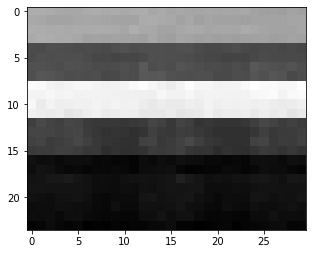

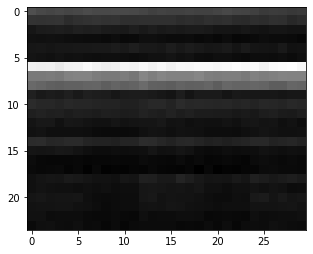

[11951/17000] loss_d: -0.403, loss_g: 1.068
[11952/17000] loss_d: -0.399, loss_g: 1.083
[11953/17000] loss_d: -0.368, loss_g: 1.070
[11954/17000] loss_d: -0.403, loss_g: 1.025
[11955/17000] loss_d: -0.393, loss_g: 1.007
[11956/17000] loss_d: -0.434, loss_g: 1.031
[11957/17000] loss_d: -0.392, loss_g: 0.976
[11958/17000] loss_d: -0.370, loss_g: 1.055
[11959/17000] loss_d: -0.385, loss_g: 1.033
[11960/17000] loss_d: -0.392, loss_g: 0.972
[11961/17000] loss_d: -0.368, loss_g: 0.997
[11962/17000] loss_d: -0.430, loss_g: 0.919
[11963/17000] loss_d: -0.402, loss_g: 1.008
[11964/17000] loss_d: -0.410, loss_g: 1.021
[11965/17000] loss_d: -0.387, loss_g: 1.003
[11966/17000] loss_d: -0.398, loss_g: 0.986
[11967/17000] loss_d: -0.406, loss_g: 0.997
[11968/17000] loss_d: -0.370, loss_g: 0.966
[11969/17000] loss_d: -0.455, loss_g: 0.960
[11970/17000] loss_d: -0.374, loss_g: 0.970
[11971/17000] loss_d: -0.396, loss_g: 0.979
[11972/17000] loss_d: -0.408, loss_g: 0.959
[11973/17000] loss_d: -0.416, lo

<Figure size 432x288 with 0 Axes>

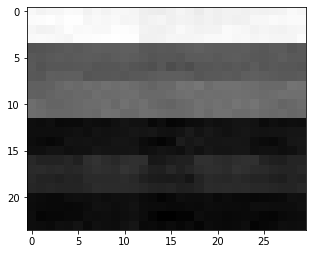

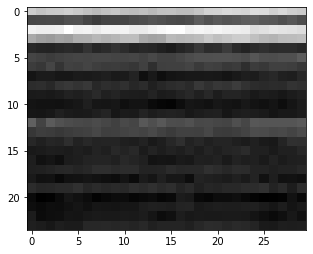

[12001/17000] loss_d: -0.393, loss_g: 1.057
[12002/17000] loss_d: -0.409, loss_g: 0.982
[12003/17000] loss_d: -0.410, loss_g: 0.943
[12004/17000] loss_d: -0.433, loss_g: 0.956
[12005/17000] loss_d: -0.420, loss_g: 0.947
[12006/17000] loss_d: -0.379, loss_g: 0.862
[12007/17000] loss_d: -0.389, loss_g: 0.996
[12008/17000] loss_d: -0.402, loss_g: 0.914
[12009/17000] loss_d: -0.393, loss_g: 0.954
[12010/17000] loss_d: -0.421, loss_g: 1.016
[12011/17000] loss_d: -0.365, loss_g: 1.046
[12012/17000] loss_d: -0.392, loss_g: 0.982
[12013/17000] loss_d: -0.400, loss_g: 1.060
[12014/17000] loss_d: -0.407, loss_g: 1.157
[12015/17000] loss_d: -0.378, loss_g: 1.032
[12016/17000] loss_d: -0.380, loss_g: 0.990
[12017/17000] loss_d: -0.388, loss_g: 0.930
[12018/17000] loss_d: -0.449, loss_g: 0.999
[12019/17000] loss_d: -0.382, loss_g: 0.998
[12020/17000] loss_d: -0.402, loss_g: 1.014
[12021/17000] loss_d: -0.416, loss_g: 0.966
[12022/17000] loss_d: -0.392, loss_g: 1.068
[12023/17000] loss_d: -0.376, lo

<Figure size 432x288 with 0 Axes>

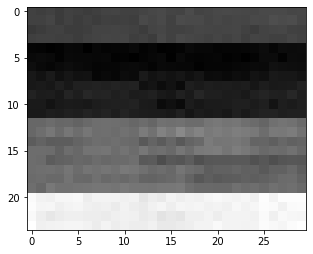

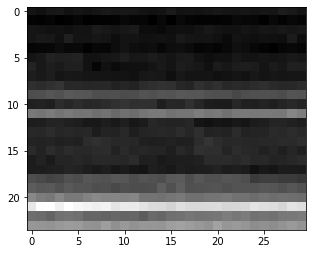

[12051/17000] loss_d: -0.369, loss_g: 0.972
[12052/17000] loss_d: -0.365, loss_g: 1.056
[12053/17000] loss_d: -0.348, loss_g: 1.049
[12054/17000] loss_d: -0.407, loss_g: 0.991
[12055/17000] loss_d: -0.410, loss_g: 0.998
[12056/17000] loss_d: -0.382, loss_g: 0.941
[12057/17000] loss_d: -0.398, loss_g: 0.998
[12058/17000] loss_d: -0.412, loss_g: 0.967
[12059/17000] loss_d: -0.431, loss_g: 1.020
[12060/17000] loss_d: -0.396, loss_g: 0.974
[12061/17000] loss_d: -0.391, loss_g: 1.019
[12062/17000] loss_d: -0.408, loss_g: 1.007
[12063/17000] loss_d: -0.392, loss_g: 0.951
[12064/17000] loss_d: -0.383, loss_g: 1.003
[12065/17000] loss_d: -0.409, loss_g: 0.974
[12066/17000] loss_d: -0.405, loss_g: 0.964
[12067/17000] loss_d: -0.383, loss_g: 0.984
[12068/17000] loss_d: -0.401, loss_g: 0.901
[12069/17000] loss_d: -0.369, loss_g: 1.000
[12070/17000] loss_d: -0.419, loss_g: 0.994
[12071/17000] loss_d: -0.437, loss_g: 0.952
[12072/17000] loss_d: -0.434, loss_g: 1.020
[12073/17000] loss_d: -0.384, lo

<Figure size 432x288 with 0 Axes>

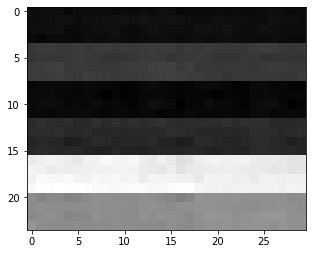

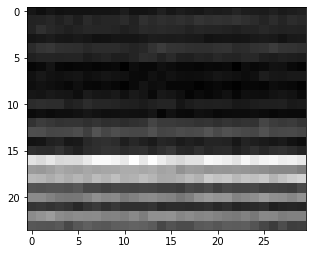

[12101/17000] loss_d: -0.388, loss_g: 0.996
[12102/17000] loss_d: -0.398, loss_g: 1.034
[12103/17000] loss_d: -0.458, loss_g: 0.950
[12104/17000] loss_d: -0.420, loss_g: 0.972
[12105/17000] loss_d: -0.413, loss_g: 0.980
[12106/17000] loss_d: -0.367, loss_g: 0.991
[12107/17000] loss_d: -0.406, loss_g: 1.005
[12108/17000] loss_d: -0.418, loss_g: 1.013
[12109/17000] loss_d: -0.404, loss_g: 0.949
[12110/17000] loss_d: -0.403, loss_g: 0.992
[12111/17000] loss_d: -0.402, loss_g: 1.043
[12112/17000] loss_d: -0.365, loss_g: 1.013
[12113/17000] loss_d: -0.341, loss_g: 0.983
[12114/17000] loss_d: -0.398, loss_g: 1.022
[12115/17000] loss_d: -0.411, loss_g: 1.032
[12116/17000] loss_d: -0.428, loss_g: 0.989
[12117/17000] loss_d: -0.372, loss_g: 0.967
[12118/17000] loss_d: -0.403, loss_g: 1.091
[12119/17000] loss_d: -0.402, loss_g: 1.018
[12120/17000] loss_d: -0.392, loss_g: 0.917
[12121/17000] loss_d: -0.373, loss_g: 0.987
[12122/17000] loss_d: -0.412, loss_g: 1.028
[12123/17000] loss_d: -0.375, lo

<Figure size 432x288 with 0 Axes>

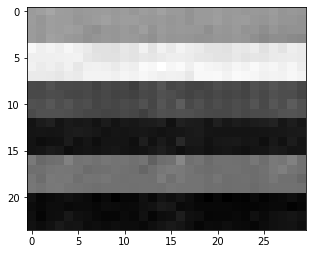

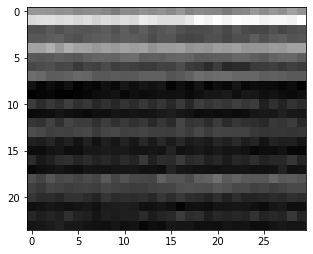

[12151/17000] loss_d: -0.389, loss_g: 0.964
[12152/17000] loss_d: -0.371, loss_g: 0.955
[12153/17000] loss_d: -0.427, loss_g: 0.909
[12154/17000] loss_d: -0.387, loss_g: 0.889
[12155/17000] loss_d: -0.430, loss_g: 0.939
[12156/17000] loss_d: -0.431, loss_g: 1.003
[12157/17000] loss_d: -0.414, loss_g: 0.923
[12158/17000] loss_d: -0.427, loss_g: 1.018
[12159/17000] loss_d: -0.416, loss_g: 1.042
[12160/17000] loss_d: -0.385, loss_g: 1.024
[12161/17000] loss_d: -0.380, loss_g: 1.017
[12162/17000] loss_d: -0.395, loss_g: 0.965
[12163/17000] loss_d: -0.351, loss_g: 1.037
[12164/17000] loss_d: -0.433, loss_g: 0.942
[12165/17000] loss_d: -0.403, loss_g: 0.992
[12166/17000] loss_d: -0.417, loss_g: 0.914
[12167/17000] loss_d: -0.395, loss_g: 0.981
[12168/17000] loss_d: -0.421, loss_g: 0.944
[12169/17000] loss_d: -0.406, loss_g: 0.919
[12170/17000] loss_d: -0.394, loss_g: 0.979
[12171/17000] loss_d: -0.392, loss_g: 0.954
[12172/17000] loss_d: -0.388, loss_g: 0.933
[12173/17000] loss_d: -0.399, lo

<Figure size 432x288 with 0 Axes>

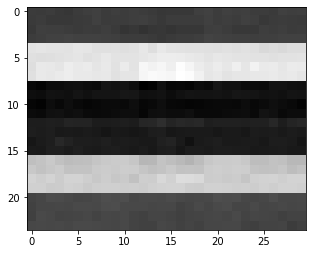

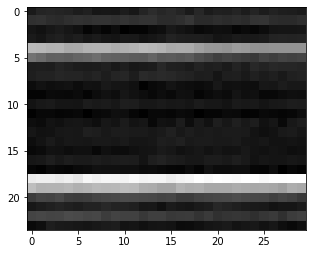

[12201/17000] loss_d: -0.403, loss_g: 1.011
[12202/17000] loss_d: -0.390, loss_g: 1.052
[12203/17000] loss_d: -0.435, loss_g: 0.926
[12204/17000] loss_d: -0.388, loss_g: 0.981
[12205/17000] loss_d: -0.416, loss_g: 0.989
[12206/17000] loss_d: -0.420, loss_g: 1.006
[12207/17000] loss_d: -0.445, loss_g: 1.086
[12208/17000] loss_d: -0.358, loss_g: 1.008
[12209/17000] loss_d: -0.390, loss_g: 1.090
[12210/17000] loss_d: -0.406, loss_g: 1.096
[12211/17000] loss_d: -0.375, loss_g: 0.953
[12212/17000] loss_d: -0.389, loss_g: 1.142
[12213/17000] loss_d: -0.412, loss_g: 0.992
[12214/17000] loss_d: -0.387, loss_g: 1.086
[12215/17000] loss_d: -0.413, loss_g: 0.977
[12216/17000] loss_d: -0.345, loss_g: 0.998
[12217/17000] loss_d: -0.397, loss_g: 1.117
[12218/17000] loss_d: -0.405, loss_g: 1.086
[12219/17000] loss_d: -0.389, loss_g: 0.983
[12220/17000] loss_d: -0.397, loss_g: 0.996
[12221/17000] loss_d: -0.370, loss_g: 0.988
[12222/17000] loss_d: -0.406, loss_g: 0.957
[12223/17000] loss_d: -0.419, lo

<Figure size 432x288 with 0 Axes>

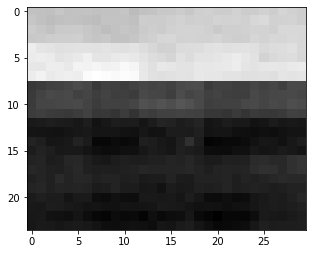

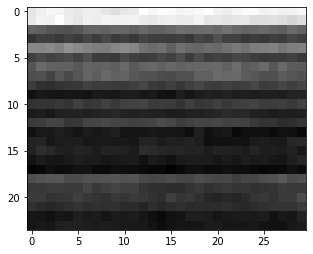

[12251/17000] loss_d: -0.400, loss_g: 0.962
[12252/17000] loss_d: -0.400, loss_g: 0.994
[12253/17000] loss_d: -0.413, loss_g: 0.942
[12254/17000] loss_d: -0.415, loss_g: 0.986
[12255/17000] loss_d: -0.374, loss_g: 1.058
[12256/17000] loss_d: -0.380, loss_g: 1.005
[12257/17000] loss_d: -0.423, loss_g: 1.091
[12258/17000] loss_d: -0.418, loss_g: 0.938
[12259/17000] loss_d: -0.403, loss_g: 1.039
[12260/17000] loss_d: -0.379, loss_g: 0.860
[12261/17000] loss_d: -0.386, loss_g: 0.957
[12262/17000] loss_d: -0.403, loss_g: 0.971
[12263/17000] loss_d: -0.401, loss_g: 0.935
[12264/17000] loss_d: -0.397, loss_g: 0.947
[12265/17000] loss_d: -0.389, loss_g: 0.972
[12266/17000] loss_d: -0.391, loss_g: 0.971
[12267/17000] loss_d: -0.368, loss_g: 0.945
[12268/17000] loss_d: -0.409, loss_g: 1.004
[12269/17000] loss_d: -0.428, loss_g: 0.948
[12270/17000] loss_d: -0.362, loss_g: 1.005
[12271/17000] loss_d: -0.401, loss_g: 0.996
[12272/17000] loss_d: -0.425, loss_g: 0.979
[12273/17000] loss_d: -0.391, lo

<Figure size 432x288 with 0 Axes>

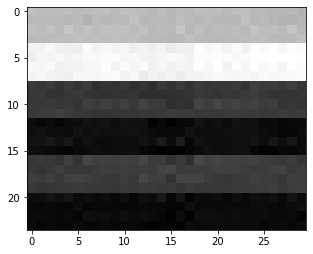

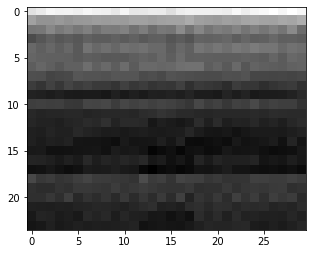

[12301/17000] loss_d: -0.395, loss_g: 1.010
[12302/17000] loss_d: -0.395, loss_g: 1.059
[12303/17000] loss_d: -0.392, loss_g: 1.009
[12304/17000] loss_d: -0.389, loss_g: 1.076
[12305/17000] loss_d: -0.395, loss_g: 1.064
[12306/17000] loss_d: -0.416, loss_g: 0.998
[12307/17000] loss_d: -0.385, loss_g: 0.910
[12308/17000] loss_d: -0.400, loss_g: 0.992
[12309/17000] loss_d: -0.408, loss_g: 0.981
[12310/17000] loss_d: -0.398, loss_g: 1.029
[12311/17000] loss_d: -0.426, loss_g: 1.035
[12312/17000] loss_d: -0.395, loss_g: 1.041
[12313/17000] loss_d: -0.414, loss_g: 1.008
[12314/17000] loss_d: -0.392, loss_g: 1.164
[12315/17000] loss_d: -0.395, loss_g: 1.037
[12316/17000] loss_d: -0.387, loss_g: 1.046
[12317/17000] loss_d: -0.396, loss_g: 1.096
[12318/17000] loss_d: -0.387, loss_g: 1.003
[12319/17000] loss_d: -0.398, loss_g: 1.005
[12320/17000] loss_d: -0.399, loss_g: 0.969
[12321/17000] loss_d: -0.419, loss_g: 1.044
[12322/17000] loss_d: -0.405, loss_g: 0.974
[12323/17000] loss_d: -0.423, lo

<Figure size 432x288 with 0 Axes>

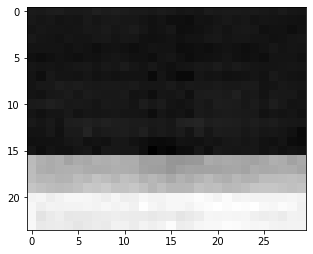

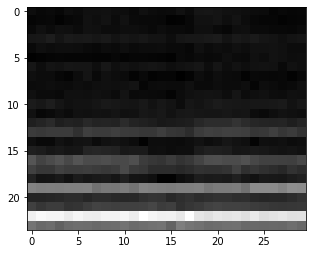

[12351/17000] loss_d: -0.403, loss_g: 1.000
[12352/17000] loss_d: -0.412, loss_g: 1.011
[12353/17000] loss_d: -0.390, loss_g: 1.153
[12354/17000] loss_d: -0.353, loss_g: 1.077
[12355/17000] loss_d: -0.388, loss_g: 1.018
[12356/17000] loss_d: -0.402, loss_g: 1.043
[12357/17000] loss_d: -0.389, loss_g: 1.021
[12358/17000] loss_d: -0.408, loss_g: 1.037
[12359/17000] loss_d: -0.415, loss_g: 1.049
[12360/17000] loss_d: -0.402, loss_g: 1.085
[12361/17000] loss_d: -0.417, loss_g: 1.071
[12362/17000] loss_d: -0.364, loss_g: 1.026
[12363/17000] loss_d: -0.396, loss_g: 1.085
[12364/17000] loss_d: -0.404, loss_g: 1.047
[12365/17000] loss_d: -0.418, loss_g: 1.040
[12366/17000] loss_d: -0.381, loss_g: 1.048
[12367/17000] loss_d: -0.409, loss_g: 0.963
[12368/17000] loss_d: -0.387, loss_g: 1.032
[12369/17000] loss_d: -0.399, loss_g: 1.039
[12370/17000] loss_d: -0.411, loss_g: 1.048
[12371/17000] loss_d: -0.401, loss_g: 1.101
[12372/17000] loss_d: -0.371, loss_g: 0.993
[12373/17000] loss_d: -0.432, lo

<Figure size 432x288 with 0 Axes>

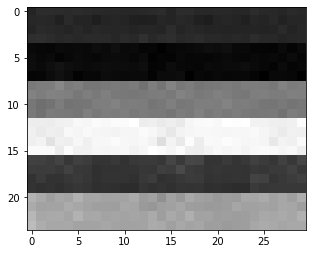

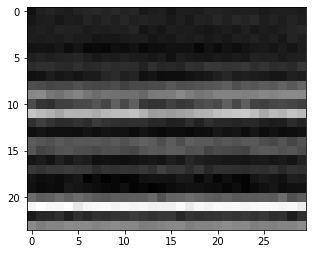

[12401/17000] loss_d: -0.398, loss_g: 1.025
[12402/17000] loss_d: -0.442, loss_g: 1.111
[12403/17000] loss_d: -0.378, loss_g: 1.181
[12404/17000] loss_d: -0.400, loss_g: 1.027
[12405/17000] loss_d: -0.421, loss_g: 1.104
[12406/17000] loss_d: -0.392, loss_g: 1.212
[12407/17000] loss_d: -0.420, loss_g: 1.130
[12408/17000] loss_d: -0.405, loss_g: 1.110
[12409/17000] loss_d: -0.415, loss_g: 1.140
[12410/17000] loss_d: -0.427, loss_g: 1.107
[12411/17000] loss_d: -0.394, loss_g: 1.154
[12412/17000] loss_d: -0.397, loss_g: 1.107
[12413/17000] loss_d: -0.393, loss_g: 1.146
[12414/17000] loss_d: -0.385, loss_g: 1.084
[12415/17000] loss_d: -0.410, loss_g: 1.103
[12416/17000] loss_d: -0.398, loss_g: 1.173
[12417/17000] loss_d: -0.420, loss_g: 1.132
[12418/17000] loss_d: -0.414, loss_g: 1.149
[12419/17000] loss_d: -0.397, loss_g: 1.156
[12420/17000] loss_d: -0.393, loss_g: 1.103
[12421/17000] loss_d: -0.374, loss_g: 1.103
[12422/17000] loss_d: -0.366, loss_g: 1.109
[12423/17000] loss_d: -0.389, lo

<Figure size 432x288 with 0 Axes>

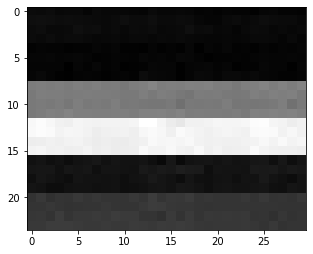

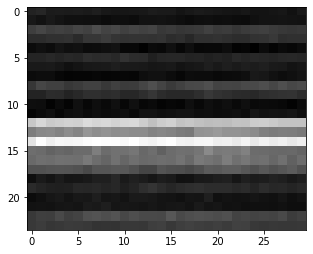

[12451/17000] loss_d: -0.451, loss_g: 1.164
[12452/17000] loss_d: -0.393, loss_g: 1.068
[12453/17000] loss_d: -0.393, loss_g: 1.004
[12454/17000] loss_d: -0.426, loss_g: 1.031
[12455/17000] loss_d: -0.404, loss_g: 1.050
[12456/17000] loss_d: -0.378, loss_g: 1.061
[12457/17000] loss_d: -0.415, loss_g: 0.990
[12458/17000] loss_d: -0.405, loss_g: 1.063
[12459/17000] loss_d: -0.396, loss_g: 1.035
[12460/17000] loss_d: -0.407, loss_g: 1.053
[12461/17000] loss_d: -0.427, loss_g: 1.057
[12462/17000] loss_d: -0.422, loss_g: 1.126
[12463/17000] loss_d: -0.445, loss_g: 1.120
[12464/17000] loss_d: -0.428, loss_g: 1.025
[12465/17000] loss_d: -0.363, loss_g: 1.082
[12466/17000] loss_d: -0.403, loss_g: 1.059
[12467/17000] loss_d: -0.400, loss_g: 0.997
[12468/17000] loss_d: -0.413, loss_g: 1.110
[12469/17000] loss_d: -0.391, loss_g: 1.039
[12470/17000] loss_d: -0.381, loss_g: 1.007
[12471/17000] loss_d: -0.408, loss_g: 1.027
[12472/17000] loss_d: -0.434, loss_g: 1.113
[12473/17000] loss_d: -0.368, lo

<Figure size 432x288 with 0 Axes>

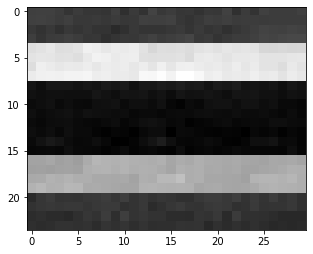

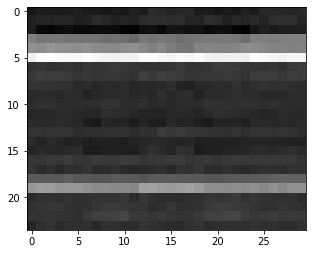

[12501/17000] loss_d: -0.412, loss_g: 1.118
[12502/17000] loss_d: -0.375, loss_g: 1.043
[12503/17000] loss_d: -0.406, loss_g: 1.111
[12504/17000] loss_d: -0.424, loss_g: 1.056
[12505/17000] loss_d: -0.405, loss_g: 1.022
[12506/17000] loss_d: -0.425, loss_g: 1.038
[12507/17000] loss_d: -0.410, loss_g: 1.010
[12508/17000] loss_d: -0.393, loss_g: 1.059
[12509/17000] loss_d: -0.399, loss_g: 1.006
[12510/17000] loss_d: -0.394, loss_g: 0.991
[12511/17000] loss_d: -0.416, loss_g: 1.083
[12512/17000] loss_d: -0.404, loss_g: 1.010
[12513/17000] loss_d: -0.385, loss_g: 0.963
[12514/17000] loss_d: -0.434, loss_g: 0.949
[12515/17000] loss_d: -0.381, loss_g: 1.080
[12516/17000] loss_d: -0.400, loss_g: 1.029
[12517/17000] loss_d: -0.394, loss_g: 1.025
[12518/17000] loss_d: -0.368, loss_g: 1.002
[12519/17000] loss_d: -0.390, loss_g: 0.962
[12520/17000] loss_d: -0.406, loss_g: 1.074
[12521/17000] loss_d: -0.414, loss_g: 1.010
[12522/17000] loss_d: -0.422, loss_g: 1.076
[12523/17000] loss_d: -0.416, lo

<Figure size 432x288 with 0 Axes>

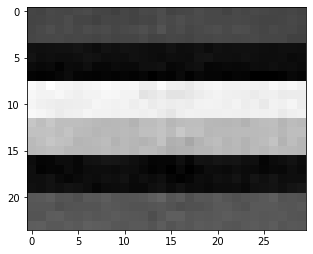

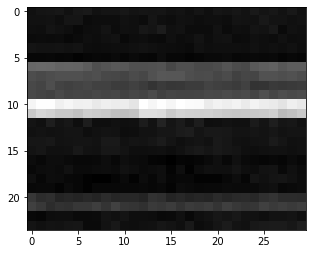

[12551/17000] loss_d: -0.382, loss_g: 1.041
[12552/17000] loss_d: -0.403, loss_g: 0.894
[12553/17000] loss_d: -0.410, loss_g: 0.956
[12554/17000] loss_d: -0.400, loss_g: 1.056
[12555/17000] loss_d: -0.371, loss_g: 1.037
[12556/17000] loss_d: -0.402, loss_g: 0.958
[12557/17000] loss_d: -0.392, loss_g: 0.977
[12558/17000] loss_d: -0.390, loss_g: 0.973
[12559/17000] loss_d: -0.398, loss_g: 1.008
[12560/17000] loss_d: -0.386, loss_g: 0.982
[12561/17000] loss_d: -0.428, loss_g: 1.030
[12562/17000] loss_d: -0.380, loss_g: 0.982
[12563/17000] loss_d: -0.379, loss_g: 0.965
[12564/17000] loss_d: -0.414, loss_g: 1.016
[12565/17000] loss_d: -0.400, loss_g: 0.987
[12566/17000] loss_d: -0.412, loss_g: 0.983
[12567/17000] loss_d: -0.402, loss_g: 0.946
[12568/17000] loss_d: -0.393, loss_g: 0.980
[12569/17000] loss_d: -0.377, loss_g: 1.028
[12570/17000] loss_d: -0.374, loss_g: 1.060
[12571/17000] loss_d: -0.429, loss_g: 1.016
[12572/17000] loss_d: -0.378, loss_g: 1.023
[12573/17000] loss_d: -0.414, lo

<Figure size 432x288 with 0 Axes>

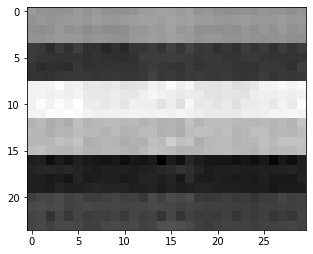

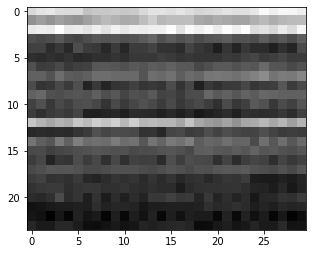

[12601/17000] loss_d: -0.383, loss_g: 1.055
[12602/17000] loss_d: -0.423, loss_g: 0.973
[12603/17000] loss_d: -0.412, loss_g: 1.040
[12604/17000] loss_d: -0.417, loss_g: 1.017
[12605/17000] loss_d: -0.397, loss_g: 1.046
[12606/17000] loss_d: -0.396, loss_g: 0.968
[12607/17000] loss_d: -0.372, loss_g: 1.027
[12608/17000] loss_d: -0.392, loss_g: 1.020
[12609/17000] loss_d: -0.379, loss_g: 0.935
[12610/17000] loss_d: -0.370, loss_g: 1.044
[12611/17000] loss_d: -0.382, loss_g: 0.980
[12612/17000] loss_d: -0.372, loss_g: 1.063
[12613/17000] loss_d: -0.427, loss_g: 1.028
[12614/17000] loss_d: -0.408, loss_g: 0.995
[12615/17000] loss_d: -0.397, loss_g: 1.041
[12616/17000] loss_d: -0.387, loss_g: 0.997
[12617/17000] loss_d: -0.391, loss_g: 0.887
[12618/17000] loss_d: -0.440, loss_g: 1.003
[12619/17000] loss_d: -0.387, loss_g: 1.132
[12620/17000] loss_d: -0.406, loss_g: 0.911
[12621/17000] loss_d: -0.410, loss_g: 1.019
[12622/17000] loss_d: -0.410, loss_g: 1.098
[12623/17000] loss_d: -0.425, lo

<Figure size 432x288 with 0 Axes>

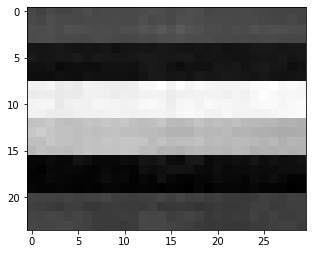

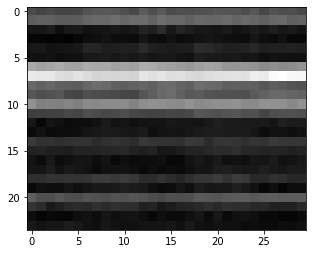

[12651/17000] loss_d: -0.399, loss_g: 0.995
[12652/17000] loss_d: -0.447, loss_g: 1.056
[12653/17000] loss_d: -0.424, loss_g: 1.004
[12654/17000] loss_d: -0.399, loss_g: 1.021
[12655/17000] loss_d: -0.397, loss_g: 0.987
[12656/17000] loss_d: -0.427, loss_g: 0.957
[12657/17000] loss_d: -0.398, loss_g: 1.037
[12658/17000] loss_d: -0.410, loss_g: 1.077
[12659/17000] loss_d: -0.384, loss_g: 1.055
[12660/17000] loss_d: -0.398, loss_g: 1.026
[12661/17000] loss_d: -0.387, loss_g: 1.128
[12662/17000] loss_d: -0.396, loss_g: 1.055
[12663/17000] loss_d: -0.381, loss_g: 0.979
[12664/17000] loss_d: -0.386, loss_g: 0.999
[12665/17000] loss_d: -0.384, loss_g: 1.031
[12666/17000] loss_d: -0.399, loss_g: 1.074
[12667/17000] loss_d: -0.424, loss_g: 0.980
[12668/17000] loss_d: -0.408, loss_g: 1.004
[12669/17000] loss_d: -0.397, loss_g: 1.014
[12670/17000] loss_d: -0.388, loss_g: 1.030
[12671/17000] loss_d: -0.433, loss_g: 0.934
[12672/17000] loss_d: -0.396, loss_g: 0.997
[12673/17000] loss_d: -0.413, lo

<Figure size 432x288 with 0 Axes>

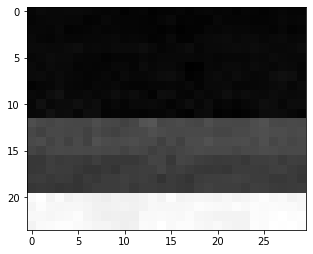

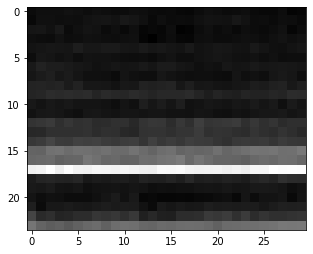

[12701/17000] loss_d: -0.402, loss_g: 1.072
[12702/17000] loss_d: -0.388, loss_g: 1.011
[12703/17000] loss_d: -0.396, loss_g: 0.981
[12704/17000] loss_d: -0.441, loss_g: 0.994
[12705/17000] loss_d: -0.371, loss_g: 1.043
[12706/17000] loss_d: -0.397, loss_g: 1.041
[12707/17000] loss_d: -0.402, loss_g: 1.056
[12708/17000] loss_d: -0.413, loss_g: 0.989
[12709/17000] loss_d: -0.425, loss_g: 1.040
[12710/17000] loss_d: -0.421, loss_g: 0.992
[12711/17000] loss_d: -0.396, loss_g: 0.986
[12712/17000] loss_d: -0.373, loss_g: 0.965
[12713/17000] loss_d: -0.401, loss_g: 0.960
[12714/17000] loss_d: -0.379, loss_g: 0.976
[12715/17000] loss_d: -0.392, loss_g: 0.926
[12716/17000] loss_d: -0.416, loss_g: 1.010
[12717/17000] loss_d: -0.406, loss_g: 0.949
[12718/17000] loss_d: -0.376, loss_g: 0.980
[12719/17000] loss_d: -0.389, loss_g: 0.969
[12720/17000] loss_d: -0.434, loss_g: 0.969
[12721/17000] loss_d: -0.432, loss_g: 0.927
[12722/17000] loss_d: -0.382, loss_g: 1.103
[12723/17000] loss_d: -0.375, lo

<Figure size 432x288 with 0 Axes>

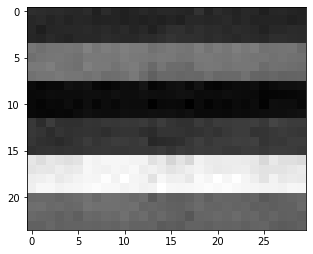

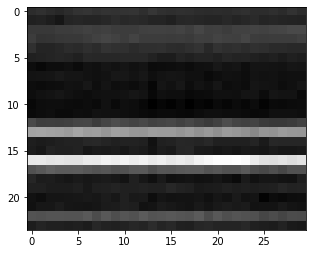

[12751/17000] loss_d: -0.385, loss_g: 1.090
[12752/17000] loss_d: -0.394, loss_g: 1.055
[12753/17000] loss_d: -0.423, loss_g: 1.069
[12754/17000] loss_d: -0.420, loss_g: 1.095
[12755/17000] loss_d: -0.405, loss_g: 1.027
[12756/17000] loss_d: -0.428, loss_g: 0.969
[12757/17000] loss_d: -0.383, loss_g: 1.107
[12758/17000] loss_d: -0.385, loss_g: 1.096
[12759/17000] loss_d: -0.390, loss_g: 1.054
[12760/17000] loss_d: -0.393, loss_g: 1.022
[12761/17000] loss_d: -0.372, loss_g: 1.007
[12762/17000] loss_d: -0.383, loss_g: 1.044
[12763/17000] loss_d: -0.421, loss_g: 1.082
[12764/17000] loss_d: -0.399, loss_g: 1.053
[12765/17000] loss_d: -0.401, loss_g: 1.006
[12766/17000] loss_d: -0.400, loss_g: 1.098
[12767/17000] loss_d: -0.395, loss_g: 0.969
[12768/17000] loss_d: -0.402, loss_g: 1.032
[12769/17000] loss_d: -0.372, loss_g: 1.012
[12770/17000] loss_d: -0.390, loss_g: 1.009
[12771/17000] loss_d: -0.407, loss_g: 0.966
[12772/17000] loss_d: -0.381, loss_g: 0.956
[12773/17000] loss_d: -0.414, lo

<Figure size 432x288 with 0 Axes>

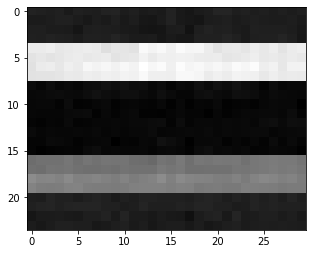

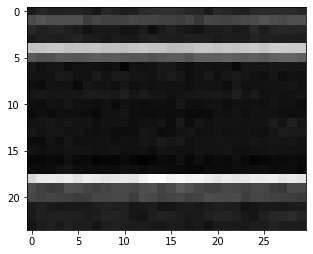

[12801/17000] loss_d: -0.424, loss_g: 0.965
[12802/17000] loss_d: -0.383, loss_g: 0.995
[12803/17000] loss_d: -0.395, loss_g: 1.016
[12804/17000] loss_d: -0.401, loss_g: 0.983
[12805/17000] loss_d: -0.382, loss_g: 1.074
[12806/17000] loss_d: -0.403, loss_g: 1.079
[12807/17000] loss_d: -0.391, loss_g: 1.012
[12808/17000] loss_d: -0.386, loss_g: 1.075
[12809/17000] loss_d: -0.381, loss_g: 1.115
[12810/17000] loss_d: -0.415, loss_g: 1.107
[12811/17000] loss_d: -0.359, loss_g: 1.026
[12812/17000] loss_d: -0.405, loss_g: 1.093
[12813/17000] loss_d: -0.432, loss_g: 1.039
[12814/17000] loss_d: -0.391, loss_g: 1.020
[12815/17000] loss_d: -0.387, loss_g: 1.101
[12816/17000] loss_d: -0.347, loss_g: 1.065
[12817/17000] loss_d: -0.364, loss_g: 1.126
[12818/17000] loss_d: -0.409, loss_g: 1.084
[12819/17000] loss_d: -0.412, loss_g: 1.051
[12820/17000] loss_d: -0.396, loss_g: 1.042
[12821/17000] loss_d: -0.378, loss_g: 1.048
[12822/17000] loss_d: -0.389, loss_g: 1.074
[12823/17000] loss_d: -0.409, lo

<Figure size 432x288 with 0 Axes>

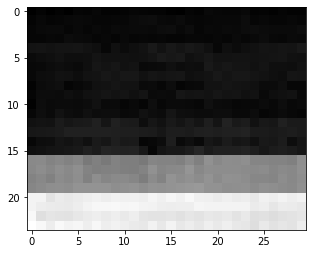

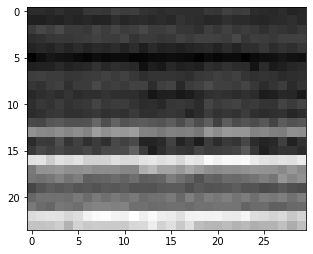

[12851/17000] loss_d: -0.388, loss_g: 1.074
[12852/17000] loss_d: -0.397, loss_g: 1.037
[12853/17000] loss_d: -0.404, loss_g: 1.013
[12854/17000] loss_d: -0.403, loss_g: 0.958
[12855/17000] loss_d: -0.406, loss_g: 1.074
[12856/17000] loss_d: -0.365, loss_g: 1.163
[12857/17000] loss_d: -0.398, loss_g: 1.076
[12858/17000] loss_d: -0.366, loss_g: 1.082
[12859/17000] loss_d: -0.384, loss_g: 1.025
[12860/17000] loss_d: -0.360, loss_g: 1.057
[12861/17000] loss_d: -0.420, loss_g: 1.019
[12862/17000] loss_d: -0.370, loss_g: 0.981
[12863/17000] loss_d: -0.374, loss_g: 1.088
[12864/17000] loss_d: -0.388, loss_g: 0.995
[12865/17000] loss_d: -0.415, loss_g: 0.988
[12866/17000] loss_d: -0.371, loss_g: 0.962
[12867/17000] loss_d: -0.387, loss_g: 1.012
[12868/17000] loss_d: -0.406, loss_g: 0.933
[12869/17000] loss_d: -0.418, loss_g: 1.106
[12870/17000] loss_d: -0.424, loss_g: 1.036
[12871/17000] loss_d: -0.383, loss_g: 1.002
[12872/17000] loss_d: -0.404, loss_g: 1.034
[12873/17000] loss_d: -0.426, lo

<Figure size 432x288 with 0 Axes>

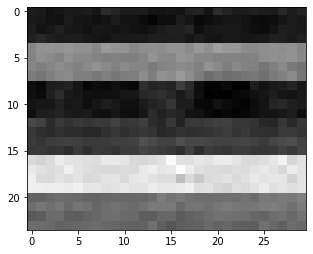

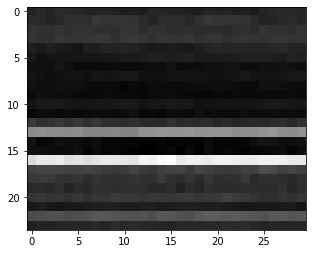

[12901/17000] loss_d: -0.453, loss_g: 1.043
[12902/17000] loss_d: -0.409, loss_g: 1.021
[12903/17000] loss_d: -0.387, loss_g: 1.074
[12904/17000] loss_d: -0.412, loss_g: 1.032
[12905/17000] loss_d: -0.347, loss_g: 1.059
[12906/17000] loss_d: -0.389, loss_g: 1.130
[12907/17000] loss_d: -0.429, loss_g: 1.018
[12908/17000] loss_d: -0.386, loss_g: 0.973
[12909/17000] loss_d: -0.322, loss_g: 1.096
[12910/17000] loss_d: -0.391, loss_g: 1.019
[12911/17000] loss_d: -0.400, loss_g: 0.992
[12912/17000] loss_d: -0.400, loss_g: 1.066
[12913/17000] loss_d: -0.429, loss_g: 1.065
[12914/17000] loss_d: -0.409, loss_g: 1.037
[12915/17000] loss_d: -0.439, loss_g: 1.008
[12916/17000] loss_d: -0.397, loss_g: 1.029
[12917/17000] loss_d: -0.397, loss_g: 0.982
[12918/17000] loss_d: -0.395, loss_g: 0.943
[12919/17000] loss_d: -0.405, loss_g: 0.916
[12920/17000] loss_d: -0.416, loss_g: 0.973
[12921/17000] loss_d: -0.415, loss_g: 0.956
[12922/17000] loss_d: -0.433, loss_g: 0.928
[12923/17000] loss_d: -0.430, lo

<Figure size 432x288 with 0 Axes>

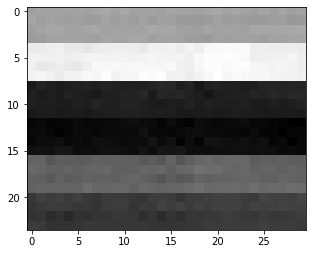

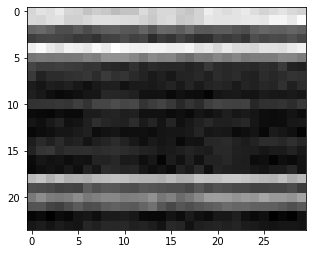

[12951/17000] loss_d: -0.413, loss_g: 0.992
[12952/17000] loss_d: -0.378, loss_g: 1.015
[12953/17000] loss_d: -0.394, loss_g: 1.092
[12954/17000] loss_d: -0.421, loss_g: 1.028
[12955/17000] loss_d: -0.383, loss_g: 0.933
[12956/17000] loss_d: -0.427, loss_g: 0.913
[12957/17000] loss_d: -0.382, loss_g: 0.974
[12958/17000] loss_d: -0.401, loss_g: 0.958
[12959/17000] loss_d: -0.397, loss_g: 0.988
[12960/17000] loss_d: -0.404, loss_g: 1.050
[12961/17000] loss_d: -0.390, loss_g: 0.986
[12962/17000] loss_d: -0.391, loss_g: 1.052
[12963/17000] loss_d: -0.380, loss_g: 1.095
[12964/17000] loss_d: -0.414, loss_g: 1.042
[12965/17000] loss_d: -0.405, loss_g: 1.075
[12966/17000] loss_d: -0.432, loss_g: 1.115
[12967/17000] loss_d: -0.406, loss_g: 1.077
[12968/17000] loss_d: -0.383, loss_g: 1.094
[12969/17000] loss_d: -0.382, loss_g: 1.090
[12970/17000] loss_d: -0.398, loss_g: 1.045
[12971/17000] loss_d: -0.392, loss_g: 1.016
[12972/17000] loss_d: -0.373, loss_g: 1.051
[12973/17000] loss_d: -0.365, lo

<Figure size 432x288 with 0 Axes>

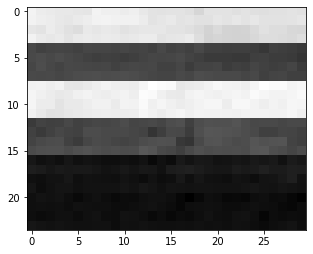

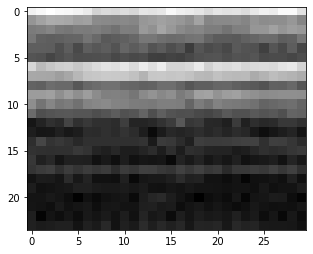

[13001/17000] loss_d: -0.381, loss_g: 1.048
[13002/17000] loss_d: -0.393, loss_g: 1.030
[13003/17000] loss_d: -0.382, loss_g: 1.035
[13004/17000] loss_d: -0.411, loss_g: 1.070
[13005/17000] loss_d: -0.412, loss_g: 1.012
[13006/17000] loss_d: -0.384, loss_g: 1.003
[13007/17000] loss_d: -0.439, loss_g: 1.066
[13008/17000] loss_d: -0.377, loss_g: 1.111
[13009/17000] loss_d: -0.383, loss_g: 1.082
[13010/17000] loss_d: -0.399, loss_g: 1.049
[13011/17000] loss_d: -0.380, loss_g: 0.968
[13012/17000] loss_d: -0.417, loss_g: 1.068
[13013/17000] loss_d: -0.381, loss_g: 1.061
[13014/17000] loss_d: -0.398, loss_g: 1.083
[13015/17000] loss_d: -0.408, loss_g: 1.002
[13016/17000] loss_d: -0.399, loss_g: 1.024
[13017/17000] loss_d: -0.400, loss_g: 1.082
[13018/17000] loss_d: -0.381, loss_g: 1.039
[13019/17000] loss_d: -0.406, loss_g: 1.050
[13020/17000] loss_d: -0.408, loss_g: 0.981
[13021/17000] loss_d: -0.372, loss_g: 0.984
[13022/17000] loss_d: -0.353, loss_g: 1.050
[13023/17000] loss_d: -0.402, lo

<Figure size 432x288 with 0 Axes>

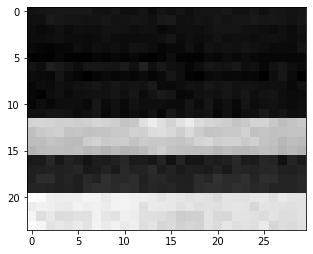

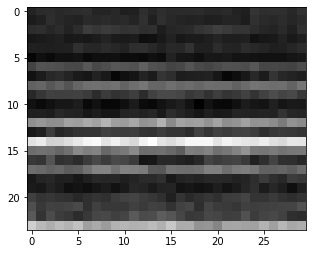

[13051/17000] loss_d: -0.380, loss_g: 1.001
[13052/17000] loss_d: -0.419, loss_g: 1.034
[13053/17000] loss_d: -0.447, loss_g: 0.992
[13054/17000] loss_d: -0.395, loss_g: 1.001
[13055/17000] loss_d: -0.406, loss_g: 0.977
[13056/17000] loss_d: -0.414, loss_g: 1.044
[13057/17000] loss_d: -0.405, loss_g: 1.031
[13058/17000] loss_d: -0.379, loss_g: 1.021
[13059/17000] loss_d: -0.391, loss_g: 1.077
[13060/17000] loss_d: -0.411, loss_g: 1.046
[13061/17000] loss_d: -0.434, loss_g: 1.045
[13062/17000] loss_d: -0.436, loss_g: 1.048
[13063/17000] loss_d: -0.432, loss_g: 1.022
[13064/17000] loss_d: -0.397, loss_g: 1.026
[13065/17000] loss_d: -0.376, loss_g: 1.066
[13066/17000] loss_d: -0.406, loss_g: 0.946
[13067/17000] loss_d: -0.385, loss_g: 1.006
[13068/17000] loss_d: -0.386, loss_g: 1.095
[13069/17000] loss_d: -0.378, loss_g: 1.076
[13070/17000] loss_d: -0.402, loss_g: 0.993
[13071/17000] loss_d: -0.402, loss_g: 1.114
[13072/17000] loss_d: -0.409, loss_g: 1.093
[13073/17000] loss_d: -0.409, lo

<Figure size 432x288 with 0 Axes>

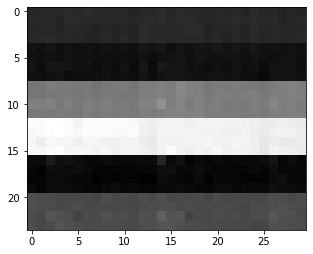

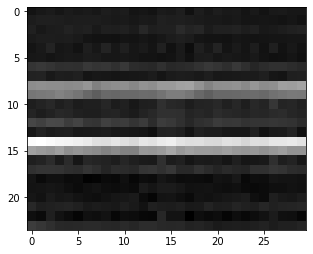

[13101/17000] loss_d: -0.386, loss_g: 1.078
[13102/17000] loss_d: -0.415, loss_g: 1.009
[13103/17000] loss_d: -0.429, loss_g: 1.120
[13104/17000] loss_d: -0.381, loss_g: 1.045
[13105/17000] loss_d: -0.383, loss_g: 1.156
[13106/17000] loss_d: -0.406, loss_g: 1.097
[13107/17000] loss_d: -0.416, loss_g: 1.042
[13108/17000] loss_d: -0.423, loss_g: 1.033
[13109/17000] loss_d: -0.382, loss_g: 1.047
[13110/17000] loss_d: -0.404, loss_g: 1.118
[13111/17000] loss_d: -0.363, loss_g: 1.022
[13112/17000] loss_d: -0.407, loss_g: 0.989
[13113/17000] loss_d: -0.396, loss_g: 1.026
[13114/17000] loss_d: -0.399, loss_g: 1.027
[13115/17000] loss_d: -0.393, loss_g: 0.996
[13116/17000] loss_d: -0.413, loss_g: 0.971
[13117/17000] loss_d: -0.363, loss_g: 1.061
[13118/17000] loss_d: -0.411, loss_g: 1.030
[13119/17000] loss_d: -0.418, loss_g: 1.074
[13120/17000] loss_d: -0.382, loss_g: 0.972
[13121/17000] loss_d: -0.371, loss_g: 1.028
[13122/17000] loss_d: -0.383, loss_g: 0.998
[13123/17000] loss_d: -0.413, lo

<Figure size 432x288 with 0 Axes>

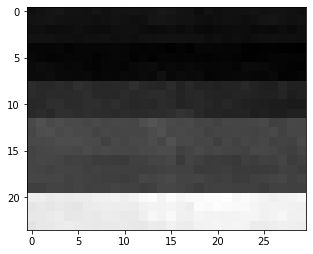

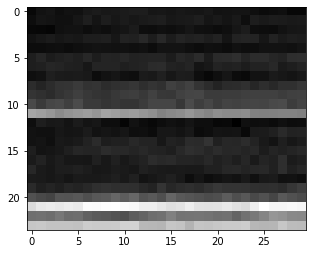

[13151/17000] loss_d: -0.408, loss_g: 1.017
[13152/17000] loss_d: -0.441, loss_g: 1.073
[13153/17000] loss_d: -0.415, loss_g: 0.988
[13154/17000] loss_d: -0.378, loss_g: 1.018
[13155/17000] loss_d: -0.399, loss_g: 1.007
[13156/17000] loss_d: -0.426, loss_g: 1.043
[13157/17000] loss_d: -0.406, loss_g: 0.988
[13158/17000] loss_d: -0.429, loss_g: 1.002
[13159/17000] loss_d: -0.355, loss_g: 0.980
[13160/17000] loss_d: -0.390, loss_g: 1.049
[13161/17000] loss_d: -0.378, loss_g: 1.115
[13162/17000] loss_d: -0.417, loss_g: 1.071
[13163/17000] loss_d: -0.414, loss_g: 1.052
[13164/17000] loss_d: -0.420, loss_g: 1.007
[13165/17000] loss_d: -0.419, loss_g: 0.967
[13166/17000] loss_d: -0.380, loss_g: 1.125
[13167/17000] loss_d: -0.397, loss_g: 1.009
[13168/17000] loss_d: -0.394, loss_g: 1.084
[13169/17000] loss_d: -0.374, loss_g: 1.120
[13170/17000] loss_d: -0.409, loss_g: 1.107
[13171/17000] loss_d: -0.364, loss_g: 1.039
[13172/17000] loss_d: -0.404, loss_g: 1.020
[13173/17000] loss_d: -0.379, lo

<Figure size 432x288 with 0 Axes>

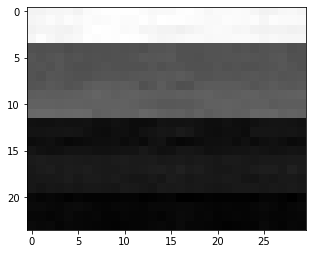

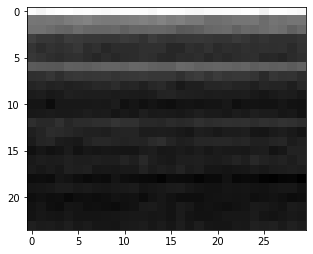

[13201/17000] loss_d: -0.392, loss_g: 1.072
[13202/17000] loss_d: -0.390, loss_g: 0.941
[13203/17000] loss_d: -0.403, loss_g: 0.971
[13204/17000] loss_d: -0.395, loss_g: 1.051
[13205/17000] loss_d: -0.414, loss_g: 1.040
[13206/17000] loss_d: -0.411, loss_g: 0.948
[13207/17000] loss_d: -0.386, loss_g: 0.986
[13208/17000] loss_d: -0.427, loss_g: 1.015
[13209/17000] loss_d: -0.397, loss_g: 1.018
[13210/17000] loss_d: -0.396, loss_g: 1.015
[13211/17000] loss_d: -0.405, loss_g: 0.901
[13212/17000] loss_d: -0.408, loss_g: 0.922
[13213/17000] loss_d: -0.391, loss_g: 1.020
[13214/17000] loss_d: -0.401, loss_g: 0.989
[13215/17000] loss_d: -0.379, loss_g: 0.941
[13216/17000] loss_d: -0.377, loss_g: 1.030
[13217/17000] loss_d: -0.391, loss_g: 1.109
[13218/17000] loss_d: -0.426, loss_g: 1.009
[13219/17000] loss_d: -0.413, loss_g: 1.114
[13220/17000] loss_d: -0.397, loss_g: 0.983
[13221/17000] loss_d: -0.374, loss_g: 1.092
[13222/17000] loss_d: -0.418, loss_g: 1.115
[13223/17000] loss_d: -0.385, lo

<Figure size 432x288 with 0 Axes>

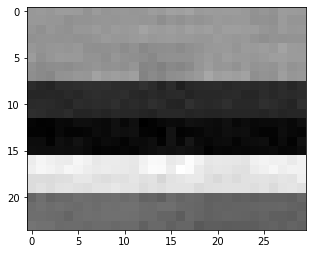

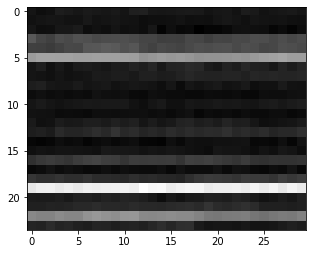

[13251/17000] loss_d: -0.386, loss_g: 1.025
[13252/17000] loss_d: -0.395, loss_g: 1.135
[13253/17000] loss_d: -0.413, loss_g: 1.135
[13254/17000] loss_d: -0.391, loss_g: 1.055
[13255/17000] loss_d: -0.380, loss_g: 1.063
[13256/17000] loss_d: -0.372, loss_g: 1.039
[13257/17000] loss_d: -0.391, loss_g: 1.056
[13258/17000] loss_d: -0.408, loss_g: 1.096
[13259/17000] loss_d: -0.422, loss_g: 1.145
[13260/17000] loss_d: -0.365, loss_g: 1.006
[13261/17000] loss_d: -0.401, loss_g: 1.051
[13262/17000] loss_d: -0.377, loss_g: 1.129
[13263/17000] loss_d: -0.395, loss_g: 1.164
[13264/17000] loss_d: -0.386, loss_g: 1.067
[13265/17000] loss_d: -0.406, loss_g: 1.086
[13266/17000] loss_d: -0.371, loss_g: 1.084
[13267/17000] loss_d: -0.418, loss_g: 1.158
[13268/17000] loss_d: -0.396, loss_g: 1.009
[13269/17000] loss_d: -0.378, loss_g: 1.076
[13270/17000] loss_d: -0.389, loss_g: 1.033
[13271/17000] loss_d: -0.403, loss_g: 1.095
[13272/17000] loss_d: -0.398, loss_g: 0.988
[13273/17000] loss_d: -0.381, lo

<Figure size 432x288 with 0 Axes>

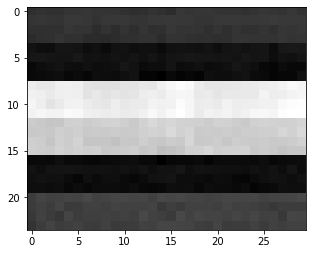

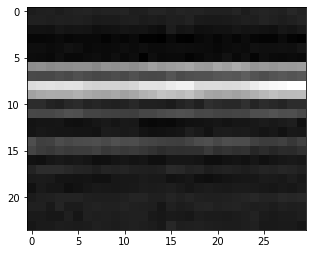

[13301/17000] loss_d: -0.367, loss_g: 1.068
[13302/17000] loss_d: -0.415, loss_g: 1.008
[13303/17000] loss_d: -0.381, loss_g: 1.065
[13304/17000] loss_d: -0.375, loss_g: 1.053
[13305/17000] loss_d: -0.375, loss_g: 0.990
[13306/17000] loss_d: -0.421, loss_g: 1.034
[13307/17000] loss_d: -0.385, loss_g: 1.065
[13308/17000] loss_d: -0.378, loss_g: 1.096
[13309/17000] loss_d: -0.371, loss_g: 1.120
[13310/17000] loss_d: -0.379, loss_g: 1.067
[13311/17000] loss_d: -0.407, loss_g: 1.241
[13312/17000] loss_d: -0.402, loss_g: 1.014
[13313/17000] loss_d: -0.391, loss_g: 1.047
[13314/17000] loss_d: -0.372, loss_g: 1.049
[13315/17000] loss_d: -0.390, loss_g: 1.052
[13316/17000] loss_d: -0.356, loss_g: 1.154
[13317/17000] loss_d: -0.383, loss_g: 1.083
[13318/17000] loss_d: -0.405, loss_g: 1.080
[13319/17000] loss_d: -0.406, loss_g: 1.131
[13320/17000] loss_d: -0.379, loss_g: 1.044
[13321/17000] loss_d: -0.366, loss_g: 1.021
[13322/17000] loss_d: -0.408, loss_g: 1.151
[13323/17000] loss_d: -0.425, lo

<Figure size 432x288 with 0 Axes>

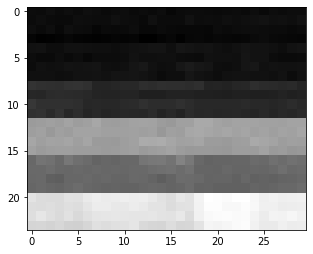

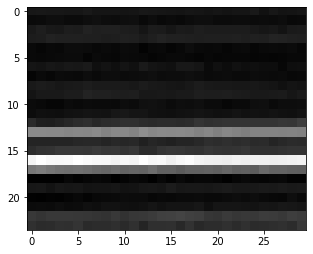

[13351/17000] loss_d: -0.362, loss_g: 1.096
[13352/17000] loss_d: -0.396, loss_g: 1.064
[13353/17000] loss_d: -0.447, loss_g: 0.954
[13354/17000] loss_d: -0.392, loss_g: 0.997
[13355/17000] loss_d: -0.359, loss_g: 1.017
[13356/17000] loss_d: -0.402, loss_g: 1.116
[13357/17000] loss_d: -0.393, loss_g: 1.141
[13358/17000] loss_d: -0.407, loss_g: 1.069
[13359/17000] loss_d: -0.373, loss_g: 1.189
[13360/17000] loss_d: -0.391, loss_g: 1.097
[13361/17000] loss_d: -0.398, loss_g: 1.180
[13362/17000] loss_d: -0.376, loss_g: 1.109
[13363/17000] loss_d: -0.422, loss_g: 1.054
[13364/17000] loss_d: -0.393, loss_g: 1.111
[13365/17000] loss_d: -0.398, loss_g: 1.027
[13366/17000] loss_d: -0.366, loss_g: 0.965
[13367/17000] loss_d: -0.368, loss_g: 1.071
[13368/17000] loss_d: -0.432, loss_g: 1.080
[13369/17000] loss_d: -0.405, loss_g: 1.013
[13370/17000] loss_d: -0.396, loss_g: 1.054
[13371/17000] loss_d: -0.415, loss_g: 1.053
[13372/17000] loss_d: -0.399, loss_g: 1.046
[13373/17000] loss_d: -0.385, lo

<Figure size 432x288 with 0 Axes>

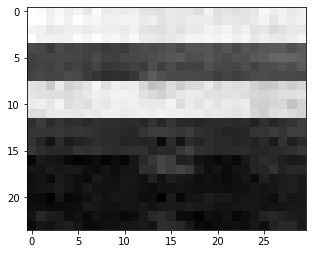

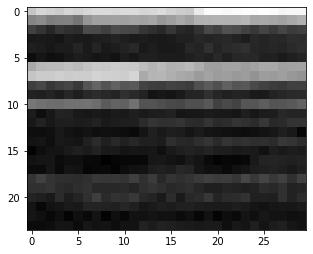

[13401/17000] loss_d: -0.393, loss_g: 1.119
[13402/17000] loss_d: -0.408, loss_g: 1.000
[13403/17000] loss_d: -0.423, loss_g: 1.043
[13404/17000] loss_d: -0.414, loss_g: 1.009
[13405/17000] loss_d: -0.390, loss_g: 1.029
[13406/17000] loss_d: -0.361, loss_g: 1.044
[13407/17000] loss_d: -0.399, loss_g: 1.031
[13408/17000] loss_d: -0.376, loss_g: 1.012
[13409/17000] loss_d: -0.435, loss_g: 1.117
[13410/17000] loss_d: -0.390, loss_g: 0.992
[13411/17000] loss_d: -0.388, loss_g: 1.118
[13412/17000] loss_d: -0.387, loss_g: 1.108
[13413/17000] loss_d: -0.433, loss_g: 1.041
[13414/17000] loss_d: -0.411, loss_g: 1.048
[13415/17000] loss_d: -0.368, loss_g: 1.123
[13416/17000] loss_d: -0.400, loss_g: 1.099
[13417/17000] loss_d: -0.409, loss_g: 1.077
[13418/17000] loss_d: -0.403, loss_g: 1.014
[13419/17000] loss_d: -0.406, loss_g: 1.095
[13420/17000] loss_d: -0.389, loss_g: 1.100
[13421/17000] loss_d: -0.412, loss_g: 1.122
[13422/17000] loss_d: -0.383, loss_g: 1.064
[13423/17000] loss_d: -0.406, lo

<Figure size 432x288 with 0 Axes>

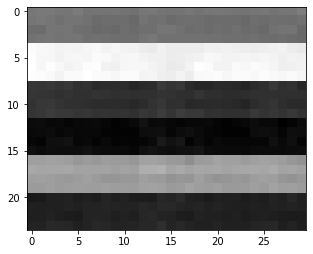

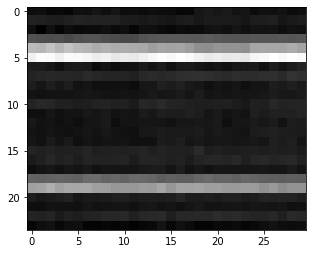

[13451/17000] loss_d: -0.377, loss_g: 1.078
[13452/17000] loss_d: -0.388, loss_g: 1.186
[13453/17000] loss_d: -0.406, loss_g: 1.088
[13454/17000] loss_d: -0.412, loss_g: 1.123
[13455/17000] loss_d: -0.414, loss_g: 1.134
[13456/17000] loss_d: -0.407, loss_g: 1.094
[13457/17000] loss_d: -0.378, loss_g: 1.108
[13458/17000] loss_d: -0.375, loss_g: 1.175
[13459/17000] loss_d: -0.397, loss_g: 1.129
[13460/17000] loss_d: -0.392, loss_g: 1.048
[13461/17000] loss_d: -0.394, loss_g: 1.075
[13462/17000] loss_d: -0.388, loss_g: 1.070
[13463/17000] loss_d: -0.396, loss_g: 1.115
[13464/17000] loss_d: -0.426, loss_g: 1.105
[13465/17000] loss_d: -0.402, loss_g: 1.151
[13466/17000] loss_d: -0.336, loss_g: 1.098
[13467/17000] loss_d: -0.408, loss_g: 1.016
[13468/17000] loss_d: -0.397, loss_g: 1.085
[13469/17000] loss_d: -0.421, loss_g: 1.076
[13470/17000] loss_d: -0.405, loss_g: 1.148
[13471/17000] loss_d: -0.416, loss_g: 1.076
[13472/17000] loss_d: -0.420, loss_g: 1.126
[13473/17000] loss_d: -0.359, lo

<Figure size 432x288 with 0 Axes>

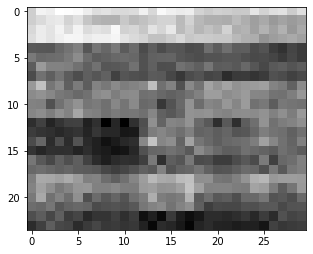

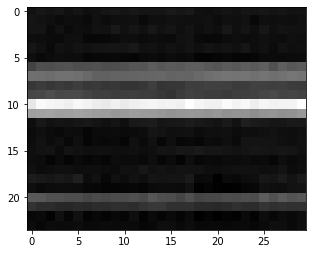

[13501/17000] loss_d: -0.400, loss_g: 1.061
[13502/17000] loss_d: -0.423, loss_g: 1.038
[13503/17000] loss_d: -0.412, loss_g: 1.103
[13504/17000] loss_d: -0.383, loss_g: 1.123
[13505/17000] loss_d: -0.385, loss_g: 1.053
[13506/17000] loss_d: -0.386, loss_g: 1.144
[13507/17000] loss_d: -0.374, loss_g: 1.129
[13508/17000] loss_d: -0.436, loss_g: 1.196
[13509/17000] loss_d: -0.379, loss_g: 1.077
[13510/17000] loss_d: -0.404, loss_g: 1.057
[13511/17000] loss_d: -0.413, loss_g: 1.124
[13512/17000] loss_d: -0.403, loss_g: 1.117
[13513/17000] loss_d: -0.408, loss_g: 1.217
[13514/17000] loss_d: -0.415, loss_g: 1.151
[13515/17000] loss_d: -0.415, loss_g: 1.158
[13516/17000] loss_d: -0.369, loss_g: 1.136
[13517/17000] loss_d: -0.356, loss_g: 1.140
[13518/17000] loss_d: -0.364, loss_g: 1.078
[13519/17000] loss_d: -0.378, loss_g: 1.082
[13520/17000] loss_d: -0.377, loss_g: 1.151
[13521/17000] loss_d: -0.423, loss_g: 1.121
[13522/17000] loss_d: -0.374, loss_g: 1.091
[13523/17000] loss_d: -0.400, lo

<Figure size 432x288 with 0 Axes>

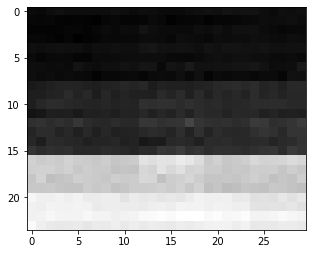

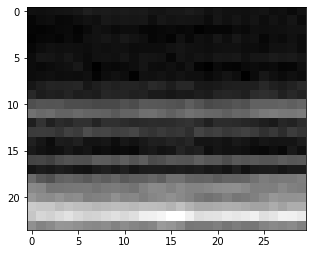

[13551/17000] loss_d: -0.422, loss_g: 1.163
[13552/17000] loss_d: -0.385, loss_g: 1.204
[13553/17000] loss_d: -0.397, loss_g: 1.182
[13554/17000] loss_d: -0.403, loss_g: 1.134
[13555/17000] loss_d: -0.426, loss_g: 1.116
[13556/17000] loss_d: -0.379, loss_g: 1.091
[13557/17000] loss_d: -0.391, loss_g: 1.049
[13558/17000] loss_d: -0.415, loss_g: 1.138
[13559/17000] loss_d: -0.407, loss_g: 1.018
[13560/17000] loss_d: -0.379, loss_g: 1.096
[13561/17000] loss_d: -0.382, loss_g: 1.089
[13562/17000] loss_d: -0.414, loss_g: 1.110
[13563/17000] loss_d: -0.419, loss_g: 1.135
[13564/17000] loss_d: -0.420, loss_g: 1.193
[13565/17000] loss_d: -0.393, loss_g: 1.151
[13566/17000] loss_d: -0.382, loss_g: 1.135
[13567/17000] loss_d: -0.396, loss_g: 1.068
[13568/17000] loss_d: -0.371, loss_g: 1.077
[13569/17000] loss_d: -0.397, loss_g: 1.149
[13570/17000] loss_d: -0.426, loss_g: 1.085
[13571/17000] loss_d: -0.408, loss_g: 1.053
[13572/17000] loss_d: -0.412, loss_g: 1.094
[13573/17000] loss_d: -0.397, lo

<Figure size 432x288 with 0 Axes>

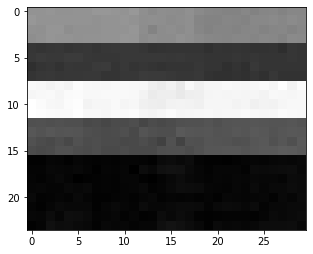

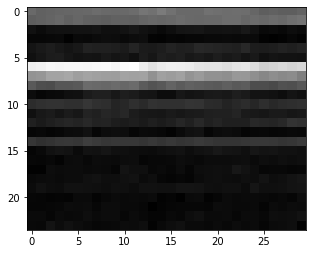

[13601/17000] loss_d: -0.384, loss_g: 1.206
[13602/17000] loss_d: -0.402, loss_g: 1.151
[13603/17000] loss_d: -0.407, loss_g: 1.072
[13604/17000] loss_d: -0.358, loss_g: 1.179
[13605/17000] loss_d: -0.368, loss_g: 1.080
[13606/17000] loss_d: -0.407, loss_g: 1.119
[13607/17000] loss_d: -0.410, loss_g: 1.212
[13608/17000] loss_d: -0.386, loss_g: 1.176
[13609/17000] loss_d: -0.428, loss_g: 1.197
[13610/17000] loss_d: -0.394, loss_g: 1.171
[13611/17000] loss_d: -0.392, loss_g: 1.136
[13612/17000] loss_d: -0.384, loss_g: 1.146
[13613/17000] loss_d: -0.388, loss_g: 1.209
[13614/17000] loss_d: -0.393, loss_g: 1.249
[13615/17000] loss_d: -0.397, loss_g: 1.166
[13616/17000] loss_d: -0.407, loss_g: 1.132
[13617/17000] loss_d: -0.414, loss_g: 1.228
[13618/17000] loss_d: -0.393, loss_g: 1.113
[13619/17000] loss_d: -0.370, loss_g: 1.165
[13620/17000] loss_d: -0.373, loss_g: 1.178
[13621/17000] loss_d: -0.415, loss_g: 1.207
[13622/17000] loss_d: -0.419, loss_g: 1.152
[13623/17000] loss_d: -0.430, lo

<Figure size 432x288 with 0 Axes>

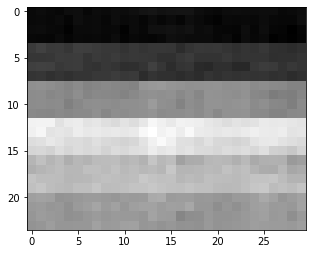

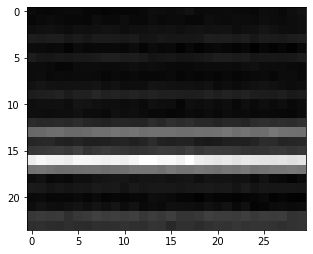

[13651/17000] loss_d: -0.374, loss_g: 1.189
[13652/17000] loss_d: -0.418, loss_g: 1.138
[13653/17000] loss_d: -0.404, loss_g: 1.125
[13654/17000] loss_d: -0.401, loss_g: 1.165
[13655/17000] loss_d: -0.392, loss_g: 1.195
[13656/17000] loss_d: -0.385, loss_g: 1.101
[13657/17000] loss_d: -0.398, loss_g: 1.127
[13658/17000] loss_d: -0.370, loss_g: 1.214
[13659/17000] loss_d: -0.397, loss_g: 1.154
[13660/17000] loss_d: -0.410, loss_g: 1.097
[13661/17000] loss_d: -0.395, loss_g: 1.149
[13662/17000] loss_d: -0.414, loss_g: 1.144
[13663/17000] loss_d: -0.407, loss_g: 1.170
[13664/17000] loss_d: -0.420, loss_g: 1.093
[13665/17000] loss_d: -0.412, loss_g: 1.102
[13666/17000] loss_d: -0.398, loss_g: 1.213
[13667/17000] loss_d: -0.398, loss_g: 1.221
[13668/17000] loss_d: -0.408, loss_g: 1.167
[13669/17000] loss_d: -0.409, loss_g: 1.124
[13670/17000] loss_d: -0.382, loss_g: 1.028
[13671/17000] loss_d: -0.370, loss_g: 1.161
[13672/17000] loss_d: -0.404, loss_g: 1.128
[13673/17000] loss_d: -0.374, lo

<Figure size 432x288 with 0 Axes>

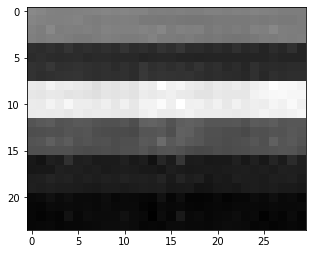

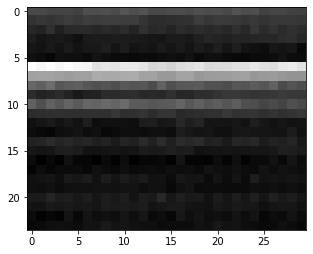

[13701/17000] loss_d: -0.403, loss_g: 1.151
[13702/17000] loss_d: -0.418, loss_g: 1.200
[13703/17000] loss_d: -0.429, loss_g: 1.167
[13704/17000] loss_d: -0.388, loss_g: 1.180
[13705/17000] loss_d: -0.409, loss_g: 1.112
[13706/17000] loss_d: -0.405, loss_g: 1.076
[13707/17000] loss_d: -0.391, loss_g: 1.071
[13708/17000] loss_d: -0.383, loss_g: 1.067
[13709/17000] loss_d: -0.412, loss_g: 1.014
[13710/17000] loss_d: -0.411, loss_g: 1.052
[13711/17000] loss_d: -0.399, loss_g: 1.045
[13712/17000] loss_d: -0.405, loss_g: 1.097
[13713/17000] loss_d: -0.423, loss_g: 1.173
[13714/17000] loss_d: -0.387, loss_g: 1.060
[13715/17000] loss_d: -0.426, loss_g: 1.260
[13716/17000] loss_d: -0.418, loss_g: 1.051
[13717/17000] loss_d: -0.403, loss_g: 1.086
[13718/17000] loss_d: -0.381, loss_g: 1.025
[13719/17000] loss_d: -0.412, loss_g: 1.061
[13720/17000] loss_d: -0.405, loss_g: 1.013
[13721/17000] loss_d: -0.403, loss_g: 1.110
[13722/17000] loss_d: -0.392, loss_g: 1.100
[13723/17000] loss_d: -0.396, lo

<Figure size 432x288 with 0 Axes>

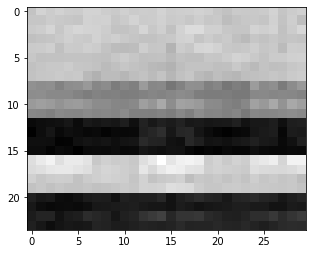

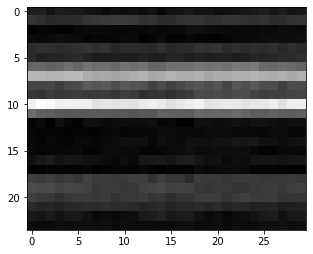

[13751/17000] loss_d: -0.359, loss_g: 1.059
[13752/17000] loss_d: -0.363, loss_g: 1.068
[13753/17000] loss_d: -0.385, loss_g: 1.051
[13754/17000] loss_d: -0.390, loss_g: 1.022
[13755/17000] loss_d: -0.388, loss_g: 1.112
[13756/17000] loss_d: -0.406, loss_g: 1.177
[13757/17000] loss_d: -0.390, loss_g: 1.080
[13758/17000] loss_d: -0.384, loss_g: 1.141
[13759/17000] loss_d: -0.389, loss_g: 1.126
[13760/17000] loss_d: -0.393, loss_g: 1.190
[13761/17000] loss_d: -0.394, loss_g: 1.107
[13762/17000] loss_d: -0.372, loss_g: 1.157
[13763/17000] loss_d: -0.420, loss_g: 1.247
[13764/17000] loss_d: -0.395, loss_g: 1.115
[13765/17000] loss_d: -0.341, loss_g: 1.147
[13766/17000] loss_d: -0.365, loss_g: 1.172
[13767/17000] loss_d: -0.394, loss_g: 1.178
[13768/17000] loss_d: -0.400, loss_g: 1.164
[13769/17000] loss_d: -0.418, loss_g: 1.183
[13770/17000] loss_d: -0.411, loss_g: 1.191
[13771/17000] loss_d: -0.396, loss_g: 1.120
[13772/17000] loss_d: -0.406, loss_g: 1.202
[13773/17000] loss_d: -0.363, lo

<Figure size 432x288 with 0 Axes>

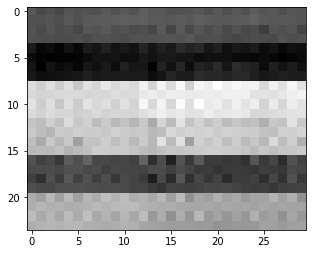

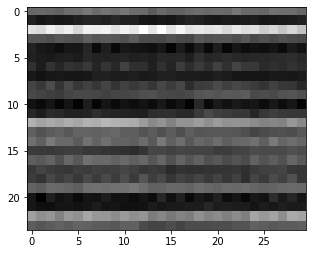

[13801/17000] loss_d: -0.400, loss_g: 1.094
[13802/17000] loss_d: -0.438, loss_g: 1.139
[13803/17000] loss_d: -0.418, loss_g: 1.199
[13804/17000] loss_d: -0.372, loss_g: 1.192
[13805/17000] loss_d: -0.404, loss_g: 1.164
[13806/17000] loss_d: -0.389, loss_g: 1.157
[13807/17000] loss_d: -0.371, loss_g: 1.231
[13808/17000] loss_d: -0.405, loss_g: 1.136
[13809/17000] loss_d: -0.378, loss_g: 1.181
[13810/17000] loss_d: -0.397, loss_g: 1.185
[13811/17000] loss_d: -0.386, loss_g: 1.192
[13812/17000] loss_d: -0.414, loss_g: 1.188
[13813/17000] loss_d: -0.408, loss_g: 1.117
[13814/17000] loss_d: -0.392, loss_g: 1.106
[13815/17000] loss_d: -0.405, loss_g: 1.137
[13816/17000] loss_d: -0.382, loss_g: 1.200
[13817/17000] loss_d: -0.396, loss_g: 1.372
[13818/17000] loss_d: -0.387, loss_g: 1.199
[13819/17000] loss_d: -0.389, loss_g: 1.152
[13820/17000] loss_d: -0.413, loss_g: 1.125
[13821/17000] loss_d: -0.402, loss_g: 1.118
[13822/17000] loss_d: -0.417, loss_g: 1.166
[13823/17000] loss_d: -0.415, lo

<Figure size 432x288 with 0 Axes>

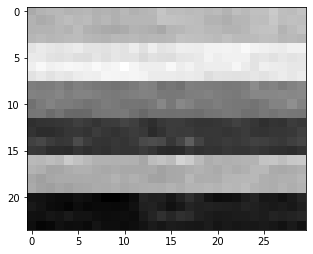

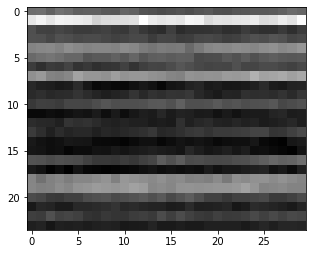

[13851/17000] loss_d: -0.377, loss_g: 1.128
[13852/17000] loss_d: -0.407, loss_g: 1.089
[13853/17000] loss_d: -0.393, loss_g: 1.112
[13854/17000] loss_d: -0.388, loss_g: 1.135
[13855/17000] loss_d: -0.397, loss_g: 1.234
[13856/17000] loss_d: -0.383, loss_g: 1.205
[13857/17000] loss_d: -0.392, loss_g: 1.238
[13858/17000] loss_d: -0.404, loss_g: 1.201
[13859/17000] loss_d: -0.392, loss_g: 1.110
[13860/17000] loss_d: -0.397, loss_g: 1.224
[13861/17000] loss_d: -0.374, loss_g: 1.182
[13862/17000] loss_d: -0.397, loss_g: 1.238
[13863/17000] loss_d: -0.408, loss_g: 1.176
[13864/17000] loss_d: -0.396, loss_g: 1.155
[13865/17000] loss_d: -0.379, loss_g: 1.158
[13866/17000] loss_d: -0.425, loss_g: 1.144
[13867/17000] loss_d: -0.411, loss_g: 1.168
[13868/17000] loss_d: -0.406, loss_g: 1.135
[13869/17000] loss_d: -0.374, loss_g: 1.163
[13870/17000] loss_d: -0.397, loss_g: 1.166
[13871/17000] loss_d: -0.411, loss_g: 1.169
[13872/17000] loss_d: -0.402, loss_g: 1.138
[13873/17000] loss_d: -0.412, lo

<Figure size 432x288 with 0 Axes>

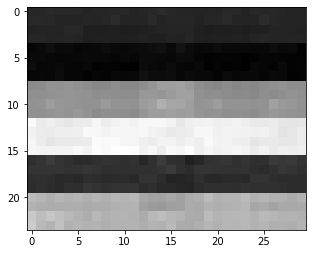

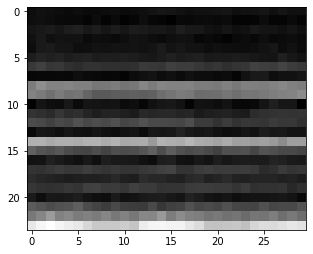

[13901/17000] loss_d: -0.412, loss_g: 1.134
[13902/17000] loss_d: -0.376, loss_g: 1.160
[13903/17000] loss_d: -0.376, loss_g: 1.148
[13904/17000] loss_d: -0.410, loss_g: 1.164
[13905/17000] loss_d: -0.386, loss_g: 1.171
[13906/17000] loss_d: -0.376, loss_g: 1.072
[13907/17000] loss_d: -0.406, loss_g: 1.098
[13908/17000] loss_d: -0.410, loss_g: 1.142
[13909/17000] loss_d: -0.362, loss_g: 1.098
[13910/17000] loss_d: -0.370, loss_g: 1.080
[13911/17000] loss_d: -0.385, loss_g: 1.082
[13912/17000] loss_d: -0.394, loss_g: 1.148
[13913/17000] loss_d: -0.355, loss_g: 1.068
[13914/17000] loss_d: -0.409, loss_g: 1.166
[13915/17000] loss_d: -0.409, loss_g: 1.027
[13916/17000] loss_d: -0.403, loss_g: 1.053
[13917/17000] loss_d: -0.384, loss_g: 1.075
[13918/17000] loss_d: -0.390, loss_g: 1.043
[13919/17000] loss_d: -0.397, loss_g: 1.126
[13920/17000] loss_d: -0.407, loss_g: 1.101
[13921/17000] loss_d: -0.358, loss_g: 1.157
[13922/17000] loss_d: -0.400, loss_g: 1.072
[13923/17000] loss_d: -0.379, lo

<Figure size 432x288 with 0 Axes>

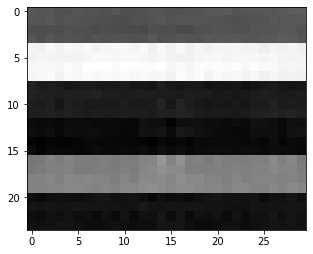

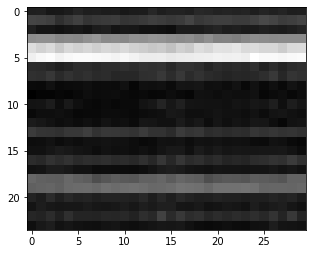

[13951/17000] loss_d: -0.384, loss_g: 1.110
[13952/17000] loss_d: -0.394, loss_g: 1.157
[13953/17000] loss_d: -0.375, loss_g: 1.073
[13954/17000] loss_d: -0.364, loss_g: 1.127
[13955/17000] loss_d: -0.416, loss_g: 1.186
[13956/17000] loss_d: -0.387, loss_g: 1.145
[13957/17000] loss_d: -0.391, loss_g: 1.152
[13958/17000] loss_d: -0.415, loss_g: 1.135
[13959/17000] loss_d: -0.392, loss_g: 1.144
[13960/17000] loss_d: -0.394, loss_g: 1.084
[13961/17000] loss_d: -0.366, loss_g: 1.110
[13962/17000] loss_d: -0.394, loss_g: 1.097
[13963/17000] loss_d: -0.384, loss_g: 1.212
[13964/17000] loss_d: -0.376, loss_g: 1.135
[13965/17000] loss_d: -0.409, loss_g: 1.138
[13966/17000] loss_d: -0.400, loss_g: 1.092
[13967/17000] loss_d: -0.384, loss_g: 1.114
[13968/17000] loss_d: -0.373, loss_g: 1.099
[13969/17000] loss_d: -0.401, loss_g: 1.121
[13970/17000] loss_d: -0.378, loss_g: 1.066
[13971/17000] loss_d: -0.396, loss_g: 1.223
[13972/17000] loss_d: -0.393, loss_g: 1.143
[13973/17000] loss_d: -0.377, lo

<Figure size 432x288 with 0 Axes>

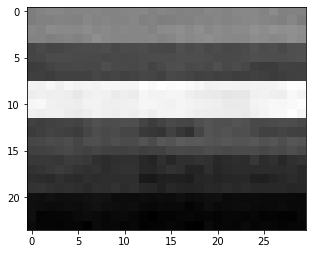

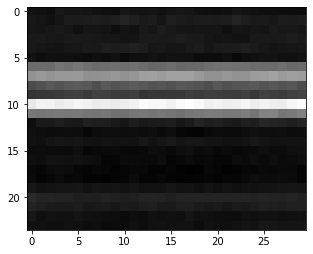

[14001/17000] loss_d: -0.408, loss_g: 1.190
[14002/17000] loss_d: -0.402, loss_g: 1.163
[14003/17000] loss_d: -0.406, loss_g: 1.084
[14004/17000] loss_d: -0.433, loss_g: 1.126
[14005/17000] loss_d: -0.368, loss_g: 1.151
[14006/17000] loss_d: -0.373, loss_g: 1.136
[14007/17000] loss_d: -0.384, loss_g: 1.108
[14008/17000] loss_d: -0.370, loss_g: 1.137
[14009/17000] loss_d: -0.382, loss_g: 1.217
[14010/17000] loss_d: -0.402, loss_g: 1.076
[14011/17000] loss_d: -0.400, loss_g: 1.181
[14012/17000] loss_d: -0.395, loss_g: 1.206
[14013/17000] loss_d: -0.412, loss_g: 1.157
[14014/17000] loss_d: -0.387, loss_g: 1.145
[14015/17000] loss_d: -0.398, loss_g: 1.153
[14016/17000] loss_d: -0.365, loss_g: 1.141
[14017/17000] loss_d: -0.418, loss_g: 1.207
[14018/17000] loss_d: -0.379, loss_g: 1.191
[14019/17000] loss_d: -0.393, loss_g: 1.111
[14020/17000] loss_d: -0.395, loss_g: 1.068
[14021/17000] loss_d: -0.391, loss_g: 1.059
[14022/17000] loss_d: -0.395, loss_g: 1.108
[14023/17000] loss_d: -0.379, lo

<Figure size 432x288 with 0 Axes>

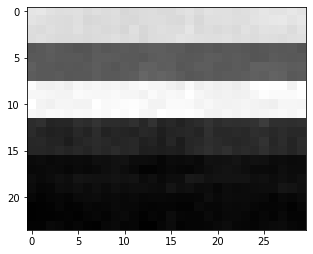

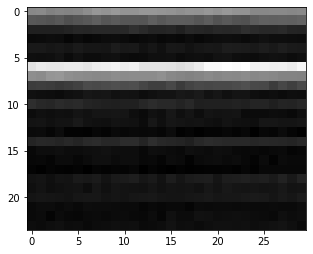

[14051/17000] loss_d: -0.388, loss_g: 1.230
[14052/17000] loss_d: -0.404, loss_g: 1.200
[14053/17000] loss_d: -0.370, loss_g: 1.247
[14054/17000] loss_d: -0.406, loss_g: 1.155
[14055/17000] loss_d: -0.363, loss_g: 1.168
[14056/17000] loss_d: -0.405, loss_g: 1.122
[14057/17000] loss_d: -0.389, loss_g: 1.120
[14058/17000] loss_d: -0.405, loss_g: 1.181
[14059/17000] loss_d: -0.394, loss_g: 1.177
[14060/17000] loss_d: -0.413, loss_g: 1.163
[14061/17000] loss_d: -0.390, loss_g: 1.242
[14062/17000] loss_d: -0.363, loss_g: 1.197
[14063/17000] loss_d: -0.405, loss_g: 1.219
[14064/17000] loss_d: -0.398, loss_g: 1.188
[14065/17000] loss_d: -0.353, loss_g: 1.171
[14066/17000] loss_d: -0.386, loss_g: 1.262
[14067/17000] loss_d: -0.360, loss_g: 1.147
[14068/17000] loss_d: -0.379, loss_g: 1.211
[14069/17000] loss_d: -0.384, loss_g: 1.213
[14070/17000] loss_d: -0.415, loss_g: 1.215
[14071/17000] loss_d: -0.386, loss_g: 1.178
[14072/17000] loss_d: -0.398, loss_g: 1.160
[14073/17000] loss_d: -0.361, lo

<Figure size 432x288 with 0 Axes>

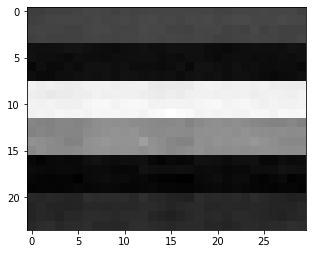

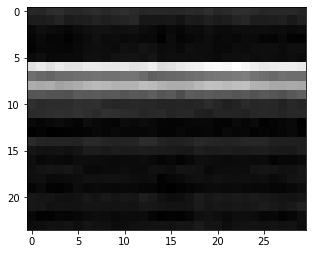

[14101/17000] loss_d: -0.382, loss_g: 1.165
[14102/17000] loss_d: -0.389, loss_g: 1.150
[14103/17000] loss_d: -0.377, loss_g: 1.186
[14104/17000] loss_d: -0.381, loss_g: 1.129
[14105/17000] loss_d: -0.398, loss_g: 1.137
[14106/17000] loss_d: -0.374, loss_g: 1.189
[14107/17000] loss_d: -0.382, loss_g: 1.250
[14108/17000] loss_d: -0.360, loss_g: 1.217
[14109/17000] loss_d: -0.402, loss_g: 1.176
[14110/17000] loss_d: -0.390, loss_g: 1.179
[14111/17000] loss_d: -0.377, loss_g: 1.181
[14112/17000] loss_d: -0.402, loss_g: 1.262
[14113/17000] loss_d: -0.382, loss_g: 1.127
[14114/17000] loss_d: -0.411, loss_g: 1.076
[14115/17000] loss_d: -0.354, loss_g: 1.283
[14116/17000] loss_d: -0.414, loss_g: 1.166
[14117/17000] loss_d: -0.417, loss_g: 1.184
[14118/17000] loss_d: -0.372, loss_g: 1.113
[14119/17000] loss_d: -0.398, loss_g: 1.105
[14120/17000] loss_d: -0.405, loss_g: 1.182
[14121/17000] loss_d: -0.351, loss_g: 1.144
[14122/17000] loss_d: -0.396, loss_g: 1.230
[14123/17000] loss_d: -0.374, lo

<Figure size 432x288 with 0 Axes>

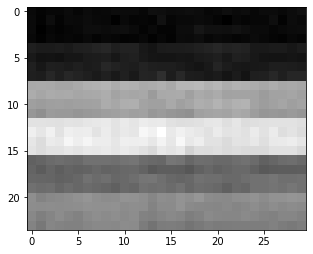

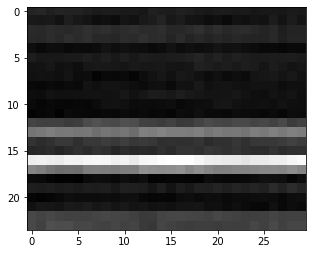

[14151/17000] loss_d: -0.423, loss_g: 1.154
[14152/17000] loss_d: -0.398, loss_g: 1.233
[14153/17000] loss_d: -0.407, loss_g: 1.255
[14154/17000] loss_d: -0.393, loss_g: 1.071
[14155/17000] loss_d: -0.392, loss_g: 1.225
[14156/17000] loss_d: -0.405, loss_g: 1.193
[14157/17000] loss_d: -0.411, loss_g: 1.269
[14158/17000] loss_d: -0.386, loss_g: 1.194
[14159/17000] loss_d: -0.400, loss_g: 1.194
[14160/17000] loss_d: -0.397, loss_g: 1.215
[14161/17000] loss_d: -0.386, loss_g: 1.257
[14162/17000] loss_d: -0.415, loss_g: 1.197
[14163/17000] loss_d: -0.392, loss_g: 1.176
[14164/17000] loss_d: -0.367, loss_g: 1.170
[14165/17000] loss_d: -0.392, loss_g: 1.109
[14166/17000] loss_d: -0.391, loss_g: 1.055
[14167/17000] loss_d: -0.379, loss_g: 1.186
[14168/17000] loss_d: -0.380, loss_g: 1.155
[14169/17000] loss_d: -0.361, loss_g: 1.286
[14170/17000] loss_d: -0.393, loss_g: 1.131
[14171/17000] loss_d: -0.391, loss_g: 1.150
[14172/17000] loss_d: -0.398, loss_g: 1.197
[14173/17000] loss_d: -0.395, lo

<Figure size 432x288 with 0 Axes>

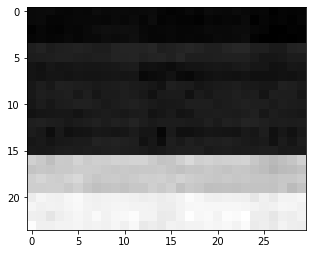

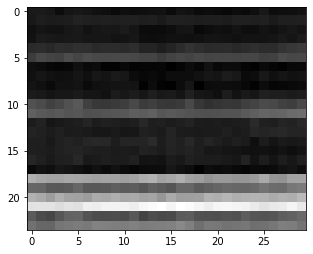

[14201/17000] loss_d: -0.406, loss_g: 1.086
[14202/17000] loss_d: -0.399, loss_g: 1.191
[14203/17000] loss_d: -0.387, loss_g: 1.180
[14204/17000] loss_d: -0.405, loss_g: 1.141
[14205/17000] loss_d: -0.390, loss_g: 1.253
[14206/17000] loss_d: -0.365, loss_g: 1.126
[14207/17000] loss_d: -0.376, loss_g: 1.182
[14208/17000] loss_d: -0.373, loss_g: 1.186
[14209/17000] loss_d: -0.359, loss_g: 1.127
[14210/17000] loss_d: -0.410, loss_g: 1.081
[14211/17000] loss_d: -0.386, loss_g: 1.157
[14212/17000] loss_d: -0.371, loss_g: 1.149
[14213/17000] loss_d: -0.412, loss_g: 1.205
[14214/17000] loss_d: -0.415, loss_g: 1.405
[14215/17000] loss_d: -0.416, loss_g: 1.235
[14216/17000] loss_d: -0.411, loss_g: 1.153
[14217/17000] loss_d: -0.380, loss_g: 1.301
[14218/17000] loss_d: -0.399, loss_g: 1.167
[14219/17000] loss_d: -0.387, loss_g: 1.128
[14220/17000] loss_d: -0.378, loss_g: 1.166
[14221/17000] loss_d: -0.380, loss_g: 1.179
[14222/17000] loss_d: -0.396, loss_g: 1.187
[14223/17000] loss_d: -0.379, lo

<Figure size 432x288 with 0 Axes>

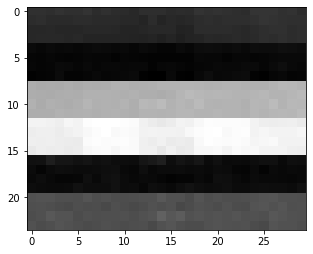

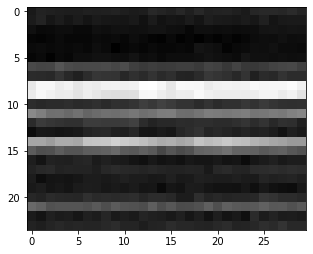

[14251/17000] loss_d: -0.404, loss_g: 1.185
[14252/17000] loss_d: -0.386, loss_g: 1.138
[14253/17000] loss_d: -0.364, loss_g: 1.221
[14254/17000] loss_d: -0.392, loss_g: 1.182
[14255/17000] loss_d: -0.376, loss_g: 1.181
[14256/17000] loss_d: -0.376, loss_g: 1.186
[14257/17000] loss_d: -0.439, loss_g: 1.242
[14258/17000] loss_d: -0.420, loss_g: 1.220
[14259/17000] loss_d: -0.411, loss_g: 1.277
[14260/17000] loss_d: -0.369, loss_g: 1.207
[14261/17000] loss_d: -0.389, loss_g: 1.209
[14262/17000] loss_d: -0.372, loss_g: 1.250
[14263/17000] loss_d: -0.391, loss_g: 1.225
[14264/17000] loss_d: -0.406, loss_g: 1.143
[14265/17000] loss_d: -0.384, loss_g: 1.159
[14266/17000] loss_d: -0.374, loss_g: 1.079
[14267/17000] loss_d: -0.411, loss_g: 1.168
[14268/17000] loss_d: -0.387, loss_g: 1.128
[14269/17000] loss_d: -0.395, loss_g: 1.100
[14270/17000] loss_d: -0.384, loss_g: 1.128
[14271/17000] loss_d: -0.425, loss_g: 1.169
[14272/17000] loss_d: -0.398, loss_g: 1.179
[14273/17000] loss_d: -0.404, lo

<Figure size 432x288 with 0 Axes>

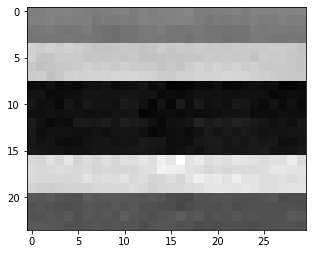

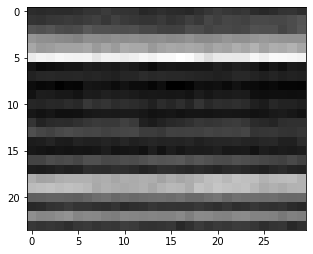

[14301/17000] loss_d: -0.412, loss_g: 1.180
[14302/17000] loss_d: -0.386, loss_g: 1.211
[14303/17000] loss_d: -0.417, loss_g: 1.266
[14304/17000] loss_d: -0.398, loss_g: 1.260
[14305/17000] loss_d: -0.372, loss_g: 1.183
[14306/17000] loss_d: -0.380, loss_g: 1.293
[14307/17000] loss_d: -0.401, loss_g: 1.210
[14308/17000] loss_d: -0.402, loss_g: 1.257
[14309/17000] loss_d: -0.418, loss_g: 1.220
[14310/17000] loss_d: -0.409, loss_g: 1.243
[14311/17000] loss_d: -0.422, loss_g: 1.434
[14312/17000] loss_d: -0.410, loss_g: 1.256
[14313/17000] loss_d: -0.434, loss_g: 1.275
[14314/17000] loss_d: -0.374, loss_g: 1.266
[14315/17000] loss_d: -0.391, loss_g: 1.198
[14316/17000] loss_d: -0.400, loss_g: 1.277
[14317/17000] loss_d: -0.374, loss_g: 1.186
[14318/17000] loss_d: -0.404, loss_g: 1.181
[14319/17000] loss_d: -0.401, loss_g: 1.165
[14320/17000] loss_d: -0.407, loss_g: 1.207
[14321/17000] loss_d: -0.386, loss_g: 1.269
[14322/17000] loss_d: -0.385, loss_g: 1.064
[14323/17000] loss_d: -0.392, lo

<Figure size 432x288 with 0 Axes>

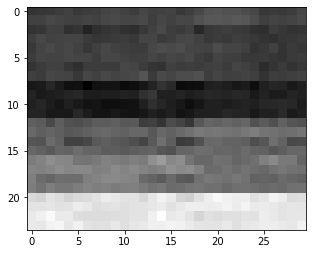

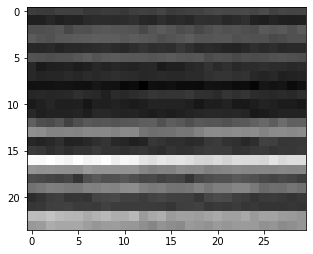

[14351/17000] loss_d: -0.357, loss_g: 1.138
[14352/17000] loss_d: -0.411, loss_g: 1.116
[14353/17000] loss_d: -0.381, loss_g: 1.344
[14354/17000] loss_d: -0.400, loss_g: 1.133
[14355/17000] loss_d: -0.412, loss_g: 1.099
[14356/17000] loss_d: -0.409, loss_g: 1.131
[14357/17000] loss_d: -0.404, loss_g: 1.146
[14358/17000] loss_d: -0.401, loss_g: 1.163
[14359/17000] loss_d: -0.389, loss_g: 1.201
[14360/17000] loss_d: -0.416, loss_g: 1.124
[14361/17000] loss_d: -0.414, loss_g: 1.143
[14362/17000] loss_d: -0.382, loss_g: 1.130
[14363/17000] loss_d: -0.397, loss_g: 1.165
[14364/17000] loss_d: -0.387, loss_g: 1.171
[14365/17000] loss_d: -0.406, loss_g: 1.117
[14366/17000] loss_d: -0.392, loss_g: 1.161
[14367/17000] loss_d: -0.410, loss_g: 1.189
[14368/17000] loss_d: -0.413, loss_g: 1.167
[14369/17000] loss_d: -0.415, loss_g: 1.186
[14370/17000] loss_d: -0.406, loss_g: 1.186
[14371/17000] loss_d: -0.396, loss_g: 1.226
[14372/17000] loss_d: -0.397, loss_g: 1.099
[14373/17000] loss_d: -0.399, lo

<Figure size 432x288 with 0 Axes>

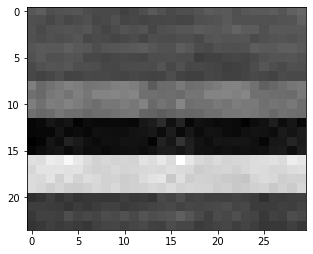

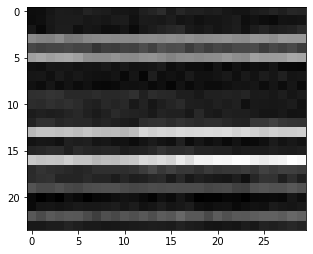

[14401/17000] loss_d: -0.371, loss_g: 1.129
[14402/17000] loss_d: -0.385, loss_g: 1.135
[14403/17000] loss_d: -0.417, loss_g: 1.058
[14404/17000] loss_d: -0.407, loss_g: 1.076
[14405/17000] loss_d: -0.397, loss_g: 1.143
[14406/17000] loss_d: -0.397, loss_g: 1.120
[14407/17000] loss_d: -0.394, loss_g: 1.228
[14408/17000] loss_d: -0.400, loss_g: 1.122
[14409/17000] loss_d: -0.368, loss_g: 1.128
[14410/17000] loss_d: -0.400, loss_g: 1.182
[14411/17000] loss_d: -0.381, loss_g: 1.138
[14412/17000] loss_d: -0.382, loss_g: 1.118
[14413/17000] loss_d: -0.403, loss_g: 1.107
[14414/17000] loss_d: -0.402, loss_g: 1.174
[14415/17000] loss_d: -0.415, loss_g: 1.143
[14416/17000] loss_d: -0.356, loss_g: 1.077
[14417/17000] loss_d: -0.387, loss_g: 1.202
[14418/17000] loss_d: -0.415, loss_g: 1.203
[14419/17000] loss_d: -0.379, loss_g: 1.094
[14420/17000] loss_d: -0.373, loss_g: 1.039
[14421/17000] loss_d: -0.400, loss_g: 1.112
[14422/17000] loss_d: -0.408, loss_g: 1.172
[14423/17000] loss_d: -0.376, lo

<Figure size 432x288 with 0 Axes>

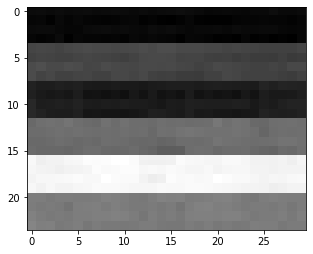

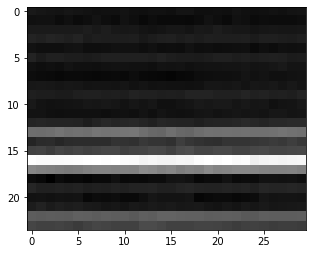

[14451/17000] loss_d: -0.380, loss_g: 1.101
[14452/17000] loss_d: -0.360, loss_g: 1.154
[14453/17000] loss_d: -0.407, loss_g: 1.327
[14454/17000] loss_d: -0.391, loss_g: 1.215
[14455/17000] loss_d: -0.368, loss_g: 1.243
[14456/17000] loss_d: -0.405, loss_g: 1.170
[14457/17000] loss_d: -0.404, loss_g: 1.191
[14458/17000] loss_d: -0.387, loss_g: 1.168
[14459/17000] loss_d: -0.400, loss_g: 1.246
[14460/17000] loss_d: -0.398, loss_g: 1.164
[14461/17000] loss_d: -0.393, loss_g: 1.206
[14462/17000] loss_d: -0.403, loss_g: 1.118
[14463/17000] loss_d: -0.405, loss_g: 1.180
[14464/17000] loss_d: -0.371, loss_g: 1.235
[14465/17000] loss_d: -0.410, loss_g: 1.187
[14466/17000] loss_d: -0.377, loss_g: 1.124
[14467/17000] loss_d: -0.378, loss_g: 1.176
[14468/17000] loss_d: -0.422, loss_g: 1.137
[14469/17000] loss_d: -0.416, loss_g: 1.181
[14470/17000] loss_d: -0.400, loss_g: 1.161
[14471/17000] loss_d: -0.420, loss_g: 1.178
[14472/17000] loss_d: -0.363, loss_g: 1.158
[14473/17000] loss_d: -0.372, lo

<Figure size 432x288 with 0 Axes>

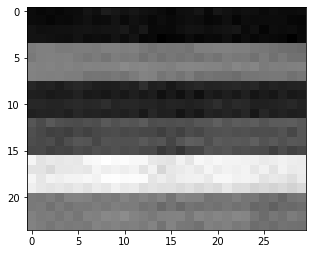

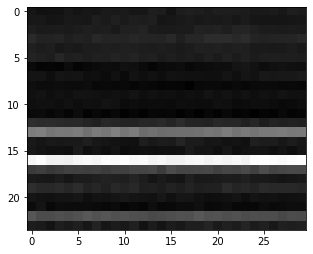

[14501/17000] loss_d: -0.388, loss_g: 1.207
[14502/17000] loss_d: -0.403, loss_g: 1.211
[14503/17000] loss_d: -0.401, loss_g: 1.196
[14504/17000] loss_d: -0.414, loss_g: 1.213
[14505/17000] loss_d: -0.411, loss_g: 1.161
[14506/17000] loss_d: -0.385, loss_g: 1.193
[14507/17000] loss_d: -0.382, loss_g: 1.238
[14508/17000] loss_d: -0.390, loss_g: 1.221
[14509/17000] loss_d: -0.362, loss_g: 1.201
[14510/17000] loss_d: -0.413, loss_g: 1.180
[14511/17000] loss_d: -0.391, loss_g: 1.152
[14512/17000] loss_d: -0.399, loss_g: 1.198
[14513/17000] loss_d: -0.404, loss_g: 1.229
[14514/17000] loss_d: -0.371, loss_g: 1.196
[14515/17000] loss_d: -0.437, loss_g: 1.172
[14516/17000] loss_d: -0.430, loss_g: 1.217
[14517/17000] loss_d: -0.393, loss_g: 1.191
[14518/17000] loss_d: -0.394, loss_g: 1.196
[14519/17000] loss_d: -0.379, loss_g: 1.162
[14520/17000] loss_d: -0.386, loss_g: 1.163
[14521/17000] loss_d: -0.414, loss_g: 1.208
[14522/17000] loss_d: -0.397, loss_g: 1.208
[14523/17000] loss_d: -0.379, lo

<Figure size 432x288 with 0 Axes>

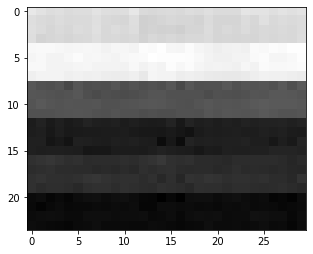

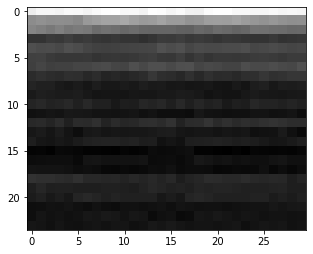

[14551/17000] loss_d: -0.386, loss_g: 1.243
[14552/17000] loss_d: -0.385, loss_g: 1.285
[14553/17000] loss_d: -0.399, loss_g: 1.232
[14554/17000] loss_d: -0.361, loss_g: 1.245
[14555/17000] loss_d: -0.378, loss_g: 1.124
[14556/17000] loss_d: -0.394, loss_g: 1.132
[14557/17000] loss_d: -0.415, loss_g: 1.092
[14558/17000] loss_d: -0.406, loss_g: 1.216
[14559/17000] loss_d: -0.342, loss_g: 1.276
[14560/17000] loss_d: -0.454, loss_g: 1.232
[14561/17000] loss_d: -0.387, loss_g: 1.219
[14562/17000] loss_d: -0.366, loss_g: 1.221
[14563/17000] loss_d: -0.411, loss_g: 1.257
[14564/17000] loss_d: -0.389, loss_g: 1.239
[14565/17000] loss_d: -0.365, loss_g: 1.241
[14566/17000] loss_d: -0.423, loss_g: 1.234
[14567/17000] loss_d: -0.368, loss_g: 1.205
[14568/17000] loss_d: -0.389, loss_g: 1.257
[14569/17000] loss_d: -0.382, loss_g: 1.285
[14570/17000] loss_d: -0.435, loss_g: 1.258
[14571/17000] loss_d: -0.367, loss_g: 1.243
[14572/17000] loss_d: -0.399, loss_g: 1.224
[14573/17000] loss_d: -0.405, lo

<Figure size 432x288 with 0 Axes>

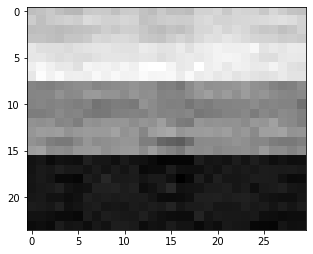

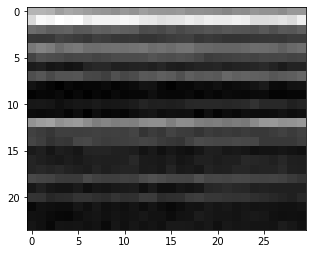

[14601/17000] loss_d: -0.415, loss_g: 1.377
[14602/17000] loss_d: -0.383, loss_g: 1.275
[14603/17000] loss_d: -0.399, loss_g: 1.316
[14604/17000] loss_d: -0.373, loss_g: 1.243
[14605/17000] loss_d: -0.384, loss_g: 1.263
[14606/17000] loss_d: -0.430, loss_g: 1.241
[14607/17000] loss_d: -0.379, loss_g: 1.269
[14608/17000] loss_d: -0.409, loss_g: 1.242
[14609/17000] loss_d: -0.384, loss_g: 1.222
[14610/17000] loss_d: -0.388, loss_g: 1.246
[14611/17000] loss_d: -0.354, loss_g: 1.289
[14612/17000] loss_d: -0.391, loss_g: 1.295
[14613/17000] loss_d: -0.375, loss_g: 1.267
[14614/17000] loss_d: -0.403, loss_g: 1.237
[14615/17000] loss_d: -0.427, loss_g: 1.281
[14616/17000] loss_d: -0.389, loss_g: 1.195
[14617/17000] loss_d: -0.414, loss_g: 1.220
[14618/17000] loss_d: -0.388, loss_g: 1.241
[14619/17000] loss_d: -0.393, loss_g: 1.199
[14620/17000] loss_d: -0.324, loss_g: 1.180
[14621/17000] loss_d: -0.360, loss_g: 1.117
[14622/17000] loss_d: -0.401, loss_g: 1.206
[14623/17000] loss_d: -0.414, lo

<Figure size 432x288 with 0 Axes>

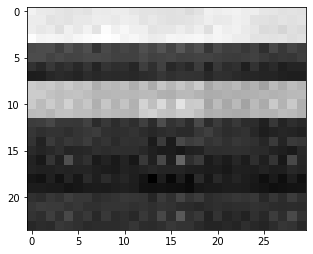

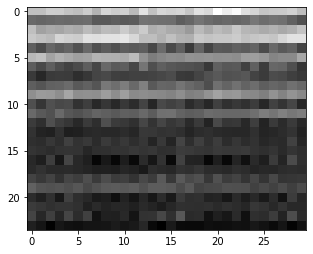

[14651/17000] loss_d: -0.388, loss_g: 1.260
[14652/17000] loss_d: -0.423, loss_g: 1.174
[14653/17000] loss_d: -0.410, loss_g: 1.249
[14654/17000] loss_d: -0.399, loss_g: 1.286
[14655/17000] loss_d: -0.397, loss_g: 1.316
[14656/17000] loss_d: -0.404, loss_g: 1.224
[14657/17000] loss_d: -0.395, loss_g: 1.208
[14658/17000] loss_d: -0.391, loss_g: 1.216
[14659/17000] loss_d: -0.374, loss_g: 1.245
[14660/17000] loss_d: -0.394, loss_g: 1.221
[14661/17000] loss_d: -0.404, loss_g: 1.308
[14662/17000] loss_d: -0.384, loss_g: 1.239
[14663/17000] loss_d: -0.389, loss_g: 1.244
[14664/17000] loss_d: -0.375, loss_g: 1.226
[14665/17000] loss_d: -0.386, loss_g: 1.195
[14666/17000] loss_d: -0.349, loss_g: 1.215
[14667/17000] loss_d: -0.374, loss_g: 1.242
[14668/17000] loss_d: -0.389, loss_g: 1.205
[14669/17000] loss_d: -0.426, loss_g: 1.194
[14670/17000] loss_d: -0.414, loss_g: 1.176
[14671/17000] loss_d: -0.402, loss_g: 1.182
[14672/17000] loss_d: -0.402, loss_g: 1.234
[14673/17000] loss_d: -0.396, lo

<Figure size 432x288 with 0 Axes>

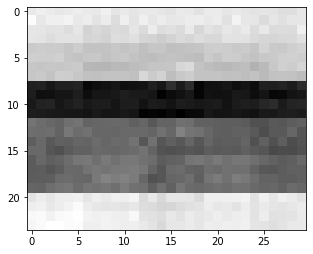

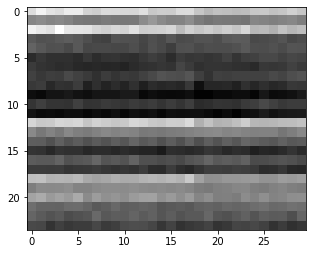

[14701/17000] loss_d: -0.399, loss_g: 1.224
[14702/17000] loss_d: -0.384, loss_g: 1.238
[14703/17000] loss_d: -0.395, loss_g: 1.250
[14704/17000] loss_d: -0.393, loss_g: 1.183
[14705/17000] loss_d: -0.392, loss_g: 1.192
[14706/17000] loss_d: -0.401, loss_g: 1.186
[14707/17000] loss_d: -0.423, loss_g: 1.122
[14708/17000] loss_d: -0.359, loss_g: 1.206
[14709/17000] loss_d: -0.376, loss_g: 1.216
[14710/17000] loss_d: -0.367, loss_g: 1.223
[14711/17000] loss_d: -0.406, loss_g: 1.206
[14712/17000] loss_d: -0.408, loss_g: 1.204
[14713/17000] loss_d: -0.419, loss_g: 1.202
[14714/17000] loss_d: -0.400, loss_g: 1.236
[14715/17000] loss_d: -0.421, loss_g: 1.246
[14716/17000] loss_d: -0.423, loss_g: 1.223
[14717/17000] loss_d: -0.395, loss_g: 1.269
[14718/17000] loss_d: -0.397, loss_g: 1.208
[14719/17000] loss_d: -0.432, loss_g: 1.170
[14720/17000] loss_d: -0.382, loss_g: 1.201
[14721/17000] loss_d: -0.383, loss_g: 1.223
[14722/17000] loss_d: -0.385, loss_g: 1.220
[14723/17000] loss_d: -0.391, lo

<Figure size 432x288 with 0 Axes>

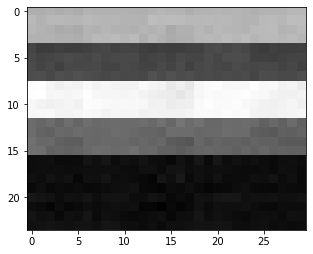

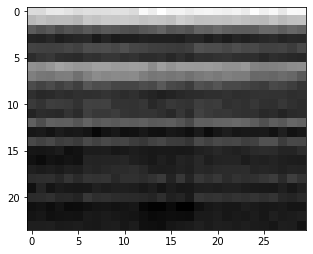

[14751/17000] loss_d: -0.406, loss_g: 1.207
[14752/17000] loss_d: -0.381, loss_g: 1.284
[14753/17000] loss_d: -0.388, loss_g: 1.251
[14754/17000] loss_d: -0.429, loss_g: 1.241
[14755/17000] loss_d: -0.401, loss_g: 1.200
[14756/17000] loss_d: -0.383, loss_g: 1.226
[14757/17000] loss_d: -0.394, loss_g: 1.160
[14758/17000] loss_d: -0.420, loss_g: 1.166
[14759/17000] loss_d: -0.403, loss_g: 1.182
[14760/17000] loss_d: -0.400, loss_g: 1.189
[14761/17000] loss_d: -0.393, loss_g: 1.277
[14762/17000] loss_d: -0.363, loss_g: 1.262
[14763/17000] loss_d: -0.390, loss_g: 1.233
[14764/17000] loss_d: -0.408, loss_g: 1.347
[14765/17000] loss_d: -0.373, loss_g: 1.273
[14766/17000] loss_d: -0.370, loss_g: 1.283
[14767/17000] loss_d: -0.388, loss_g: 1.250
[14768/17000] loss_d: -0.380, loss_g: 1.271
[14769/17000] loss_d: -0.360, loss_g: 1.205
[14770/17000] loss_d: -0.406, loss_g: 1.251
[14771/17000] loss_d: -0.395, loss_g: 1.277
[14772/17000] loss_d: -0.321, loss_g: 1.242
[14773/17000] loss_d: -0.383, lo

<Figure size 432x288 with 0 Axes>

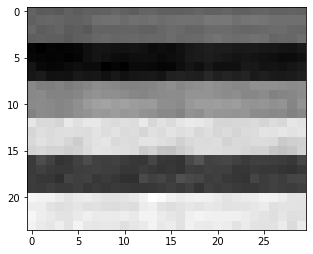

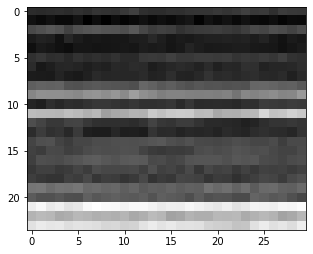

[14801/17000] loss_d: -0.400, loss_g: 1.184
[14802/17000] loss_d: -0.396, loss_g: 1.213
[14803/17000] loss_d: -0.356, loss_g: 1.165
[14804/17000] loss_d: -0.369, loss_g: 1.207
[14805/17000] loss_d: -0.400, loss_g: 1.277
[14806/17000] loss_d: -0.363, loss_g: 1.289
[14807/17000] loss_d: -0.384, loss_g: 1.235
[14808/17000] loss_d: -0.406, loss_g: 1.254
[14809/17000] loss_d: -0.382, loss_g: 1.279
[14810/17000] loss_d: -0.396, loss_g: 1.180
[14811/17000] loss_d: -0.366, loss_g: 1.189
[14812/17000] loss_d: -0.396, loss_g: 1.194
[14813/17000] loss_d: -0.380, loss_g: 1.162
[14814/17000] loss_d: -0.417, loss_g: 1.309
[14815/17000] loss_d: -0.391, loss_g: 1.281
[14816/17000] loss_d: -0.377, loss_g: 1.259
[14817/17000] loss_d: -0.397, loss_g: 1.300
[14818/17000] loss_d: -0.390, loss_g: 1.371
[14819/17000] loss_d: -0.397, loss_g: 1.265
[14820/17000] loss_d: -0.411, loss_g: 1.266
[14821/17000] loss_d: -0.420, loss_g: 1.259
[14822/17000] loss_d: -0.408, loss_g: 1.219
[14823/17000] loss_d: -0.392, lo

<Figure size 432x288 with 0 Axes>

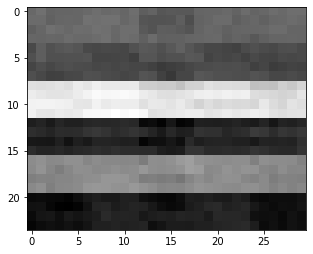

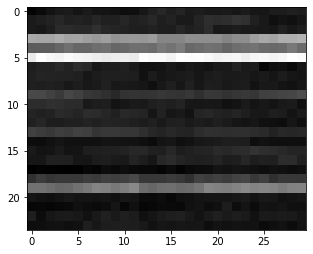

[14851/17000] loss_d: -0.386, loss_g: 1.460
[14852/17000] loss_d: -0.401, loss_g: 1.248
[14853/17000] loss_d: -0.389, loss_g: 1.123
[14854/17000] loss_d: -0.417, loss_g: 1.119
[14855/17000] loss_d: -0.390, loss_g: 1.163
[14856/17000] loss_d: -0.369, loss_g: 1.115
[14857/17000] loss_d: -0.382, loss_g: 1.174
[14858/17000] loss_d: -0.396, loss_g: 1.238
[14859/17000] loss_d: -0.391, loss_g: 1.127
[14860/17000] loss_d: -0.390, loss_g: 1.154
[14861/17000] loss_d: -0.397, loss_g: 1.267
[14862/17000] loss_d: -0.394, loss_g: 1.200
[14863/17000] loss_d: -0.405, loss_g: 1.203
[14864/17000] loss_d: -0.391, loss_g: 1.294
[14865/17000] loss_d: -0.387, loss_g: 1.192
[14866/17000] loss_d: -0.404, loss_g: 1.118
[14867/17000] loss_d: -0.407, loss_g: 1.214
[14868/17000] loss_d: -0.377, loss_g: 1.248
[14869/17000] loss_d: -0.406, loss_g: 1.229
[14870/17000] loss_d: -0.401, loss_g: 1.175
[14871/17000] loss_d: -0.365, loss_g: 1.196
[14872/17000] loss_d: -0.347, loss_g: 1.297
[14873/17000] loss_d: -0.417, lo

<Figure size 432x288 with 0 Axes>

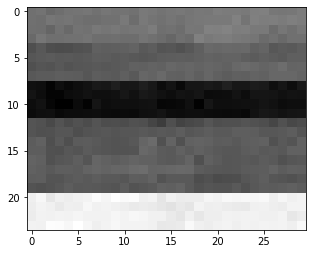

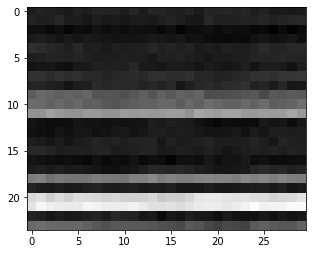

[14901/17000] loss_d: -0.398, loss_g: 1.213
[14902/17000] loss_d: -0.410, loss_g: 1.235
[14903/17000] loss_d: -0.383, loss_g: 1.245
[14904/17000] loss_d: -0.412, loss_g: 1.253
[14905/17000] loss_d: -0.387, loss_g: 1.254
[14906/17000] loss_d: -0.398, loss_g: 1.203
[14907/17000] loss_d: -0.385, loss_g: 1.249
[14908/17000] loss_d: -0.372, loss_g: 1.293
[14909/17000] loss_d: -0.401, loss_g: 1.184
[14910/17000] loss_d: -0.401, loss_g: 1.231
[14911/17000] loss_d: -0.422, loss_g: 1.216
[14912/17000] loss_d: -0.411, loss_g: 1.258
[14913/17000] loss_d: -0.388, loss_g: 1.307
[14914/17000] loss_d: -0.436, loss_g: 1.295
[14915/17000] loss_d: -0.368, loss_g: 1.277
[14916/17000] loss_d: -0.389, loss_g: 1.240
[14917/17000] loss_d: -0.396, loss_g: 1.189
[14918/17000] loss_d: -0.358, loss_g: 1.199
[14919/17000] loss_d: -0.394, loss_g: 1.135
[14920/17000] loss_d: -0.368, loss_g: 1.201
[14921/17000] loss_d: -0.393, loss_g: 1.183
[14922/17000] loss_d: -0.399, loss_g: 1.223
[14923/17000] loss_d: -0.383, lo

<Figure size 432x288 with 0 Axes>

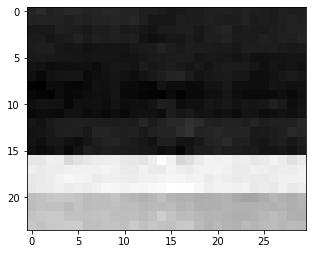

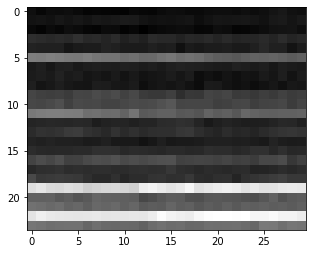

[14951/17000] loss_d: -0.409, loss_g: 1.198
[14952/17000] loss_d: -0.412, loss_g: 1.240
[14953/17000] loss_d: -0.387, loss_g: 1.209
[14954/17000] loss_d: -0.412, loss_g: 1.293
[14955/17000] loss_d: -0.398, loss_g: 1.231
[14956/17000] loss_d: -0.374, loss_g: 1.299
[14957/17000] loss_d: -0.372, loss_g: 1.334
[14958/17000] loss_d: -0.395, loss_g: 1.187
[14959/17000] loss_d: -0.419, loss_g: 1.271
[14960/17000] loss_d: -0.393, loss_g: 1.234
[14961/17000] loss_d: -0.393, loss_g: 1.314
[14962/17000] loss_d: -0.409, loss_g: 1.265
[14963/17000] loss_d: -0.340, loss_g: 1.222
[14964/17000] loss_d: -0.398, loss_g: 1.245
[14965/17000] loss_d: -0.381, loss_g: 1.182
[14966/17000] loss_d: -0.389, loss_g: 1.211
[14967/17000] loss_d: -0.414, loss_g: 1.196
[14968/17000] loss_d: -0.360, loss_g: 1.131
[14969/17000] loss_d: -0.424, loss_g: 1.266
[14970/17000] loss_d: -0.370, loss_g: 1.198
[14971/17000] loss_d: -0.391, loss_g: 1.277
[14972/17000] loss_d: -0.352, loss_g: 1.240
[14973/17000] loss_d: -0.358, lo

<Figure size 432x288 with 0 Axes>

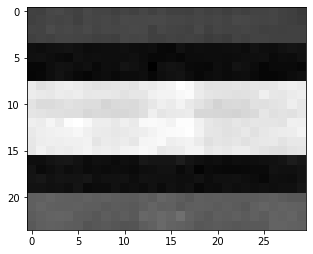

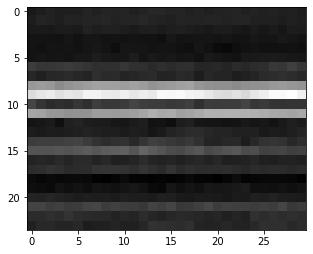

[15001/17000] loss_d: -0.366, loss_g: 1.183
[15002/17000] loss_d: -0.393, loss_g: 1.236
[15003/17000] loss_d: -0.403, loss_g: 1.193
[15004/17000] loss_d: -0.402, loss_g: 1.143
[15005/17000] loss_d: -0.357, loss_g: 1.205
[15006/17000] loss_d: -0.385, loss_g: 1.186
[15007/17000] loss_d: -0.410, loss_g: 1.128
[15008/17000] loss_d: -0.394, loss_g: 1.180
[15009/17000] loss_d: -0.362, loss_g: 1.146
[15010/17000] loss_d: -0.369, loss_g: 1.092
[15011/17000] loss_d: -0.376, loss_g: 1.125
[15012/17000] loss_d: -0.360, loss_g: 1.206
[15013/17000] loss_d: -0.343, loss_g: 1.135
[15014/17000] loss_d: -0.393, loss_g: 1.229
[15015/17000] loss_d: -0.409, loss_g: 1.142
[15016/17000] loss_d: -0.383, loss_g: 1.187
[15017/17000] loss_d: -0.381, loss_g: 1.222
[15018/17000] loss_d: -0.352, loss_g: 1.143
[15019/17000] loss_d: -0.413, loss_g: 1.198
[15020/17000] loss_d: -0.387, loss_g: 1.275
[15021/17000] loss_d: -0.385, loss_g: 1.211
[15022/17000] loss_d: -0.405, loss_g: 1.210
[15023/17000] loss_d: -0.396, lo

<Figure size 432x288 with 0 Axes>

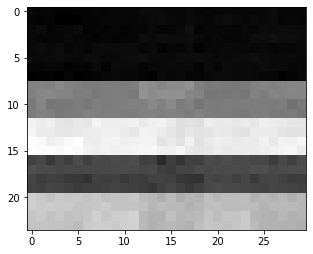

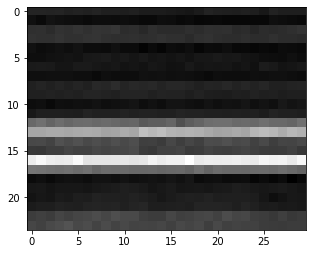

[15051/17000] loss_d: -0.431, loss_g: 1.287
[15052/17000] loss_d: -0.383, loss_g: 1.229
[15053/17000] loss_d: -0.380, loss_g: 1.220
[15054/17000] loss_d: -0.391, loss_g: 1.139
[15055/17000] loss_d: -0.371, loss_g: 1.164
[15056/17000] loss_d: -0.373, loss_g: 1.237
[15057/17000] loss_d: -0.390, loss_g: 1.186
[15058/17000] loss_d: -0.349, loss_g: 1.166
[15059/17000] loss_d: -0.381, loss_g: 1.265
[15060/17000] loss_d: -0.367, loss_g: 1.205
[15061/17000] loss_d: -0.430, loss_g: 1.212
[15062/17000] loss_d: -0.401, loss_g: 1.203
[15063/17000] loss_d: -0.417, loss_g: 1.335
[15064/17000] loss_d: -0.393, loss_g: 1.343
[15065/17000] loss_d: -0.387, loss_g: 1.269
[15066/17000] loss_d: -0.389, loss_g: 1.282
[15067/17000] loss_d: -0.406, loss_g: 1.281
[15068/17000] loss_d: -0.396, loss_g: 1.203
[15069/17000] loss_d: -0.386, loss_g: 1.254
[15070/17000] loss_d: -0.403, loss_g: 1.286
[15071/17000] loss_d: -0.429, loss_g: 1.294
[15072/17000] loss_d: -0.372, loss_g: 1.211
[15073/17000] loss_d: -0.373, lo

<Figure size 432x288 with 0 Axes>

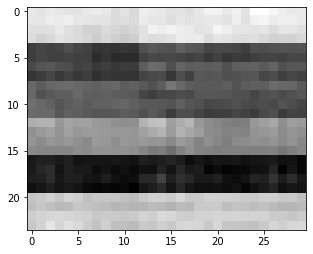

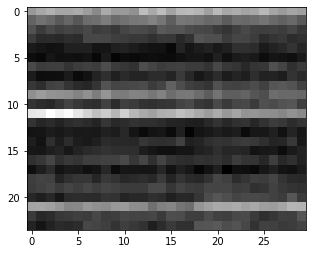

[15101/17000] loss_d: -0.381, loss_g: 1.195
[15102/17000] loss_d: -0.427, loss_g: 1.155
[15103/17000] loss_d: -0.390, loss_g: 1.217
[15104/17000] loss_d: -0.382, loss_g: 1.264
[15105/17000] loss_d: -0.380, loss_g: 1.175
[15106/17000] loss_d: -0.393, loss_g: 1.247
[15107/17000] loss_d: -0.389, loss_g: 1.181
[15108/17000] loss_d: -0.380, loss_g: 1.248
[15109/17000] loss_d: -0.399, loss_g: 1.307
[15110/17000] loss_d: -0.379, loss_g: 1.251
[15111/17000] loss_d: -0.415, loss_g: 1.223
[15112/17000] loss_d: -0.401, loss_g: 1.231
[15113/17000] loss_d: -0.381, loss_g: 1.240
[15114/17000] loss_d: -0.384, loss_g: 1.228
[15115/17000] loss_d: -0.387, loss_g: 1.248
[15116/17000] loss_d: -0.361, loss_g: 1.166
[15117/17000] loss_d: -0.375, loss_g: 1.229
[15118/17000] loss_d: -0.385, loss_g: 1.203
[15119/17000] loss_d: -0.362, loss_g: 1.250
[15120/17000] loss_d: -0.398, loss_g: 1.199
[15121/17000] loss_d: -0.398, loss_g: 1.171
[15122/17000] loss_d: -0.422, loss_g: 1.201
[15123/17000] loss_d: -0.367, lo

<Figure size 432x288 with 0 Axes>

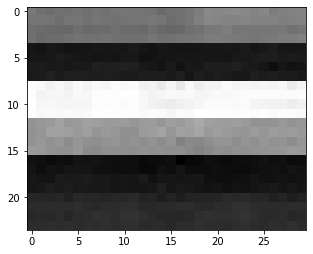

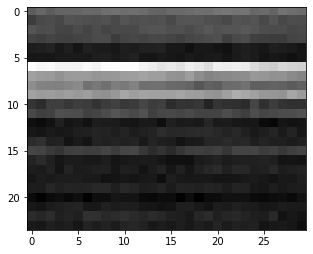

[15151/17000] loss_d: -0.432, loss_g: 1.175
[15152/17000] loss_d: -0.378, loss_g: 1.127
[15153/17000] loss_d: -0.379, loss_g: 1.191
[15154/17000] loss_d: -0.403, loss_g: 1.195
[15155/17000] loss_d: -0.399, loss_g: 1.201
[15156/17000] loss_d: -0.415, loss_g: 1.132
[15157/17000] loss_d: -0.388, loss_g: 1.180
[15158/17000] loss_d: -0.399, loss_g: 1.249
[15159/17000] loss_d: -0.410, loss_g: 1.163
[15160/17000] loss_d: -0.389, loss_g: 1.194
[15161/17000] loss_d: -0.380, loss_g: 1.114
[15162/17000] loss_d: -0.423, loss_g: 1.181
[15163/17000] loss_d: -0.405, loss_g: 1.263
[15164/17000] loss_d: -0.320, loss_g: 1.303
[15165/17000] loss_d: -0.394, loss_g: 1.200
[15166/17000] loss_d: -0.414, loss_g: 1.201
[15167/17000] loss_d: -0.361, loss_g: 1.195
[15168/17000] loss_d: -0.378, loss_g: 1.166
[15169/17000] loss_d: -0.363, loss_g: 1.164
[15170/17000] loss_d: -0.397, loss_g: 1.161
[15171/17000] loss_d: -0.393, loss_g: 1.193
[15172/17000] loss_d: -0.398, loss_g: 1.189
[15173/17000] loss_d: -0.376, lo

<Figure size 432x288 with 0 Axes>

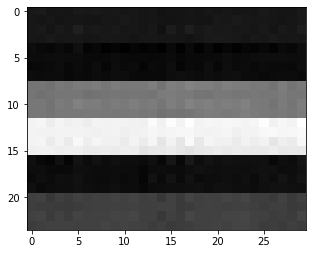

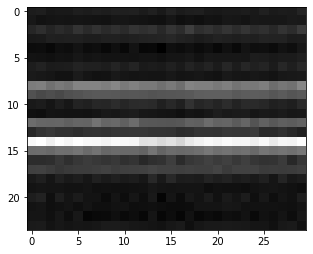

[15201/17000] loss_d: -0.395, loss_g: 1.193
[15202/17000] loss_d: -0.385, loss_g: 1.158
[15203/17000] loss_d: -0.352, loss_g: 1.148
[15204/17000] loss_d: -0.413, loss_g: 1.188
[15205/17000] loss_d: -0.392, loss_g: 1.144
[15206/17000] loss_d: -0.372, loss_g: 1.162
[15207/17000] loss_d: -0.387, loss_g: 1.112
[15208/17000] loss_d: -0.446, loss_g: 1.153
[15209/17000] loss_d: -0.378, loss_g: 1.244
[15210/17000] loss_d: -0.384, loss_g: 1.262
[15211/17000] loss_d: -0.371, loss_g: 1.197
[15212/17000] loss_d: -0.371, loss_g: 1.205
[15213/17000] loss_d: -0.423, loss_g: 1.202
[15214/17000] loss_d: -0.410, loss_g: 1.212
[15215/17000] loss_d: -0.396, loss_g: 1.176
[15216/17000] loss_d: -0.412, loss_g: 1.215
[15217/17000] loss_d: -0.429, loss_g: 1.175
[15218/17000] loss_d: -0.385, loss_g: 1.261
[15219/17000] loss_d: -0.380, loss_g: 1.229
[15220/17000] loss_d: -0.365, loss_g: 1.294
[15221/17000] loss_d: -0.390, loss_g: 1.337
[15222/17000] loss_d: -0.387, loss_g: 1.245
[15223/17000] loss_d: -0.377, lo

<Figure size 432x288 with 0 Axes>

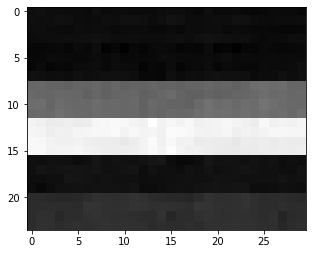

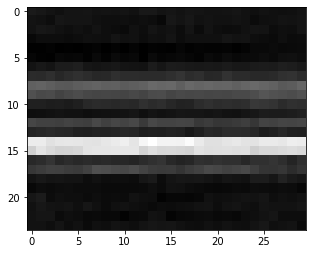

[15251/17000] loss_d: -0.404, loss_g: 1.235
[15252/17000] loss_d: -0.416, loss_g: 1.207
[15253/17000] loss_d: -0.353, loss_g: 1.244
[15254/17000] loss_d: -0.357, loss_g: 1.190
[15255/17000] loss_d: -0.408, loss_g: 1.188
[15256/17000] loss_d: -0.380, loss_g: 1.193
[15257/17000] loss_d: -0.417, loss_g: 1.185
[15258/17000] loss_d: -0.410, loss_g: 1.230
[15259/17000] loss_d: -0.401, loss_g: 1.155
[15260/17000] loss_d: -0.402, loss_g: 1.198
[15261/17000] loss_d: -0.386, loss_g: 1.238
[15262/17000] loss_d: -0.382, loss_g: 1.294
[15263/17000] loss_d: -0.399, loss_g: 1.214
[15264/17000] loss_d: -0.415, loss_g: 1.218
[15265/17000] loss_d: -0.404, loss_g: 1.285
[15266/17000] loss_d: -0.410, loss_g: 1.179
[15267/17000] loss_d: -0.378, loss_g: 1.242
[15268/17000] loss_d: -0.390, loss_g: 1.242
[15269/17000] loss_d: -0.382, loss_g: 1.229
[15270/17000] loss_d: -0.378, loss_g: 1.211
[15271/17000] loss_d: -0.387, loss_g: 1.261
[15272/17000] loss_d: -0.361, loss_g: 1.231
[15273/17000] loss_d: -0.391, lo

<Figure size 432x288 with 0 Axes>

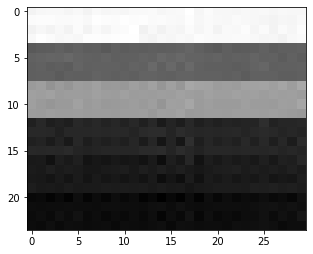

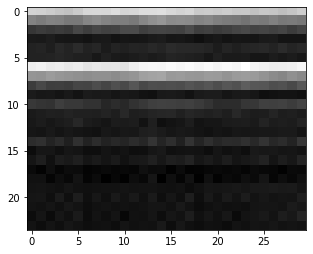

[15301/17000] loss_d: -0.349, loss_g: 1.198
[15302/17000] loss_d: -0.390, loss_g: 1.211
[15303/17000] loss_d: -0.390, loss_g: 1.122
[15304/17000] loss_d: -0.338, loss_g: 1.222
[15305/17000] loss_d: -0.369, loss_g: 1.307
[15306/17000] loss_d: -0.410, loss_g: 1.208
[15307/17000] loss_d: -0.369, loss_g: 1.243
[15308/17000] loss_d: -0.376, loss_g: 1.216
[15309/17000] loss_d: -0.369, loss_g: 1.229
[15310/17000] loss_d: -0.364, loss_g: 1.238
[15311/17000] loss_d: -0.405, loss_g: 1.250
[15312/17000] loss_d: -0.405, loss_g: 1.246
[15313/17000] loss_d: -0.389, loss_g: 1.196
[15314/17000] loss_d: -0.388, loss_g: 1.168
[15315/17000] loss_d: -0.387, loss_g: 1.176
[15316/17000] loss_d: -0.406, loss_g: 1.262
[15317/17000] loss_d: -0.444, loss_g: 1.248
[15318/17000] loss_d: -0.380, loss_g: 1.213
[15319/17000] loss_d: -0.385, loss_g: 1.160
[15320/17000] loss_d: -0.393, loss_g: 1.228
[15321/17000] loss_d: -0.391, loss_g: 1.273
[15322/17000] loss_d: -0.374, loss_g: 1.204
[15323/17000] loss_d: -0.357, lo

<Figure size 432x288 with 0 Axes>

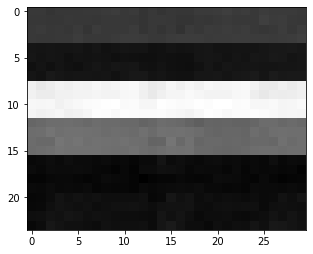

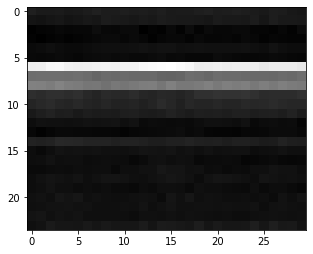

[15351/17000] loss_d: -0.376, loss_g: 1.206
[15352/17000] loss_d: -0.376, loss_g: 1.238
[15353/17000] loss_d: -0.382, loss_g: 1.187
[15354/17000] loss_d: -0.391, loss_g: 1.154
[15355/17000] loss_d: -0.379, loss_g: 1.237
[15356/17000] loss_d: -0.391, loss_g: 1.152
[15357/17000] loss_d: -0.400, loss_g: 1.181
[15358/17000] loss_d: -0.394, loss_g: 1.244
[15359/17000] loss_d: -0.396, loss_g: 1.272
[15360/17000] loss_d: -0.406, loss_g: 1.248
[15361/17000] loss_d: -0.375, loss_g: 1.219
[15362/17000] loss_d: -0.430, loss_g: 1.312
[15363/17000] loss_d: -0.422, loss_g: 1.328
[15364/17000] loss_d: -0.424, loss_g: 1.252
[15365/17000] loss_d: -0.373, loss_g: 1.172
[15366/17000] loss_d: -0.374, loss_g: 1.287
[15367/17000] loss_d: -0.433, loss_g: 1.301
[15368/17000] loss_d: -0.397, loss_g: 1.211
[15369/17000] loss_d: -0.369, loss_g: 1.188
[15370/17000] loss_d: -0.363, loss_g: 1.251
[15371/17000] loss_d: -0.404, loss_g: 1.156
[15372/17000] loss_d: -0.400, loss_g: 1.159
[15373/17000] loss_d: -0.353, lo

<Figure size 432x288 with 0 Axes>

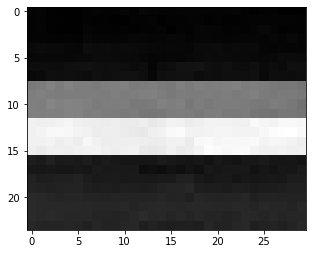

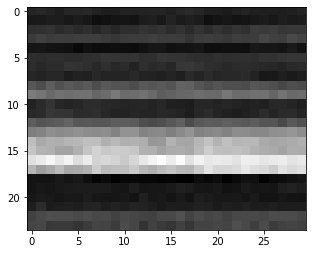

[15401/17000] loss_d: -0.375, loss_g: 1.110
[15402/17000] loss_d: -0.413, loss_g: 1.221
[15403/17000] loss_d: -0.362, loss_g: 1.237
[15404/17000] loss_d: -0.361, loss_g: 1.233
[15405/17000] loss_d: -0.388, loss_g: 1.308
[15406/17000] loss_d: -0.404, loss_g: 1.256
[15407/17000] loss_d: -0.391, loss_g: 1.211
[15408/17000] loss_d: -0.393, loss_g: 1.099
[15409/17000] loss_d: -0.358, loss_g: 1.156
[15410/17000] loss_d: -0.371, loss_g: 1.123
[15411/17000] loss_d: -0.386, loss_g: 1.239
[15412/17000] loss_d: -0.396, loss_g: 1.203
[15413/17000] loss_d: -0.410, loss_g: 1.132
[15414/17000] loss_d: -0.391, loss_g: 1.230
[15415/17000] loss_d: -0.388, loss_g: 1.239
[15416/17000] loss_d: -0.404, loss_g: 1.201
[15417/17000] loss_d: -0.386, loss_g: 1.152
[15418/17000] loss_d: -0.403, loss_g: 1.221
[15419/17000] loss_d: -0.367, loss_g: 1.154
[15420/17000] loss_d: -0.378, loss_g: 1.127
[15421/17000] loss_d: -0.397, loss_g: 1.140
[15422/17000] loss_d: -0.395, loss_g: 1.209
[15423/17000] loss_d: -0.372, lo

<Figure size 432x288 with 0 Axes>

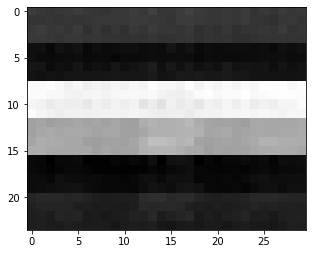

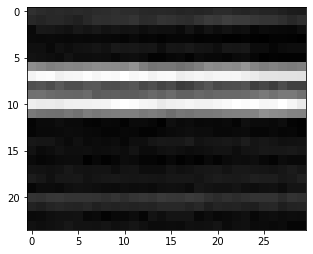

[15451/17000] loss_d: -0.395, loss_g: 1.187
[15452/17000] loss_d: -0.402, loss_g: 1.133
[15453/17000] loss_d: -0.363, loss_g: 1.227
[15454/17000] loss_d: -0.436, loss_g: 1.139
[15455/17000] loss_d: -0.344, loss_g: 1.118
[15456/17000] loss_d: -0.366, loss_g: 1.111
[15457/17000] loss_d: -0.404, loss_g: 1.147
[15458/17000] loss_d: -0.397, loss_g: 1.199
[15459/17000] loss_d: -0.371, loss_g: 1.145
[15460/17000] loss_d: -0.404, loss_g: 1.126
[15461/17000] loss_d: -0.404, loss_g: 1.154
[15462/17000] loss_d: -0.393, loss_g: 1.058
[15463/17000] loss_d: -0.360, loss_g: 1.261
[15464/17000] loss_d: -0.352, loss_g: 1.207
[15465/17000] loss_d: -0.379, loss_g: 1.130
[15466/17000] loss_d: -0.410, loss_g: 1.180
[15467/17000] loss_d: -0.409, loss_g: 1.161
[15468/17000] loss_d: -0.388, loss_g: 1.177
[15469/17000] loss_d: -0.383, loss_g: 1.180
[15470/17000] loss_d: -0.370, loss_g: 1.152
[15471/17000] loss_d: -0.406, loss_g: 1.265
[15472/17000] loss_d: -0.392, loss_g: 1.279
[15473/17000] loss_d: -0.352, lo

<Figure size 432x288 with 0 Axes>

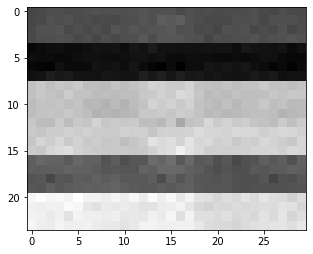

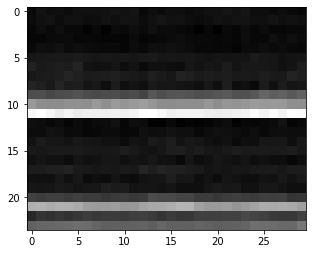

[15501/17000] loss_d: -0.399, loss_g: 1.297
[15502/17000] loss_d: -0.391, loss_g: 1.324
[15503/17000] loss_d: -0.372, loss_g: 1.254
[15504/17000] loss_d: -0.403, loss_g: 1.205
[15505/17000] loss_d: -0.402, loss_g: 1.222
[15506/17000] loss_d: -0.383, loss_g: 1.202
[15507/17000] loss_d: -0.385, loss_g: 1.320
[15508/17000] loss_d: -0.371, loss_g: 1.298
[15509/17000] loss_d: -0.400, loss_g: 1.237
[15510/17000] loss_d: -0.409, loss_g: 1.260
[15511/17000] loss_d: -0.400, loss_g: 1.157
[15512/17000] loss_d: -0.375, loss_g: 1.261
[15513/17000] loss_d: -0.379, loss_g: 1.197
[15514/17000] loss_d: -0.424, loss_g: 1.247
[15515/17000] loss_d: -0.438, loss_g: 1.285
[15516/17000] loss_d: -0.366, loss_g: 1.212
[15517/17000] loss_d: -0.395, loss_g: 1.176
[15518/17000] loss_d: -0.376, loss_g: 1.253
[15519/17000] loss_d: -0.382, loss_g: 1.280
[15520/17000] loss_d: -0.395, loss_g: 1.174
[15521/17000] loss_d: -0.392, loss_g: 1.237
[15522/17000] loss_d: -0.367, loss_g: 1.202
[15523/17000] loss_d: -0.356, lo

<Figure size 432x288 with 0 Axes>

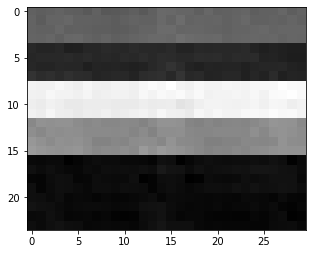

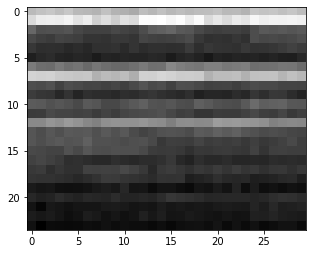

[15551/17000] loss_d: -0.379, loss_g: 1.150
[15552/17000] loss_d: -0.365, loss_g: 1.160
[15553/17000] loss_d: -0.368, loss_g: 1.232
[15554/17000] loss_d: -0.409, loss_g: 1.165
[15555/17000] loss_d: -0.392, loss_g: 1.128
[15556/17000] loss_d: -0.444, loss_g: 1.113
[15557/17000] loss_d: -0.407, loss_g: 1.140
[15558/17000] loss_d: -0.361, loss_g: 1.174
[15559/17000] loss_d: -0.372, loss_g: 1.204
[15560/17000] loss_d: -0.375, loss_g: 1.225
[15561/17000] loss_d: -0.368, loss_g: 1.132
[15562/17000] loss_d: -0.380, loss_g: 1.175
[15563/17000] loss_d: -0.401, loss_g: 1.271
[15564/17000] loss_d: -0.356, loss_g: 1.114
[15565/17000] loss_d: -0.414, loss_g: 1.224
[15566/17000] loss_d: -0.383, loss_g: 1.198
[15567/17000] loss_d: -0.405, loss_g: 1.206
[15568/17000] loss_d: -0.368, loss_g: 1.153
[15569/17000] loss_d: -0.373, loss_g: 1.242
[15570/17000] loss_d: -0.403, loss_g: 1.224
[15571/17000] loss_d: -0.373, loss_g: 1.228
[15572/17000] loss_d: -0.390, loss_g: 1.208
[15573/17000] loss_d: -0.395, lo

<Figure size 432x288 with 0 Axes>

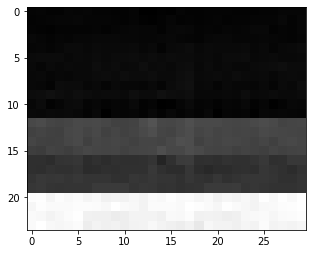

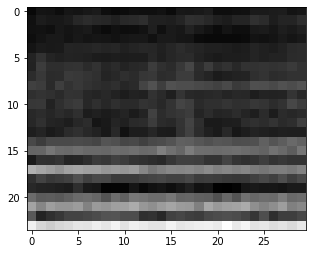

[15601/17000] loss_d: -0.387, loss_g: 1.215
[15602/17000] loss_d: -0.347, loss_g: 1.237
[15603/17000] loss_d: -0.379, loss_g: 1.217
[15604/17000] loss_d: -0.399, loss_g: 1.183
[15605/17000] loss_d: -0.361, loss_g: 1.237
[15606/17000] loss_d: -0.410, loss_g: 1.211
[15607/17000] loss_d: -0.371, loss_g: 1.231
[15608/17000] loss_d: -0.378, loss_g: 1.155
[15609/17000] loss_d: -0.382, loss_g: 1.185
[15610/17000] loss_d: -0.390, loss_g: 1.216
[15611/17000] loss_d: -0.399, loss_g: 1.226
[15612/17000] loss_d: -0.397, loss_g: 1.232
[15613/17000] loss_d: -0.403, loss_g: 1.236
[15614/17000] loss_d: -0.401, loss_g: 1.289
[15615/17000] loss_d: -0.373, loss_g: 1.160
[15616/17000] loss_d: -0.392, loss_g: 1.187
[15617/17000] loss_d: -0.386, loss_g: 1.173
[15618/17000] loss_d: -0.383, loss_g: 1.175
[15619/17000] loss_d: -0.403, loss_g: 1.193
[15620/17000] loss_d: -0.380, loss_g: 1.102
[15621/17000] loss_d: -0.401, loss_g: 1.147
[15622/17000] loss_d: -0.354, loss_g: 1.066
[15623/17000] loss_d: -0.321, lo

<Figure size 432x288 with 0 Axes>

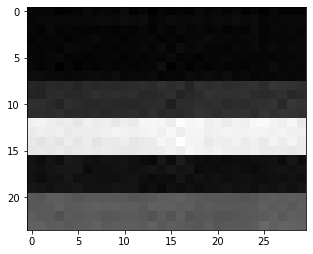

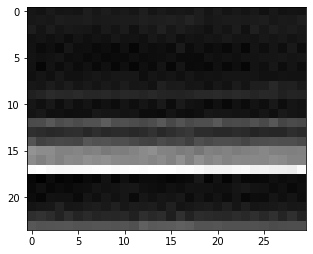

[15651/17000] loss_d: -0.421, loss_g: 1.302
[15652/17000] loss_d: -0.418, loss_g: 1.279
[15653/17000] loss_d: -0.405, loss_g: 1.355
[15654/17000] loss_d: -0.346, loss_g: 1.398
[15655/17000] loss_d: -0.383, loss_g: 1.286
[15656/17000] loss_d: -0.402, loss_g: 1.269
[15657/17000] loss_d: -0.388, loss_g: 1.368
[15658/17000] loss_d: -0.383, loss_g: 1.285
[15659/17000] loss_d: -0.421, loss_g: 1.272
[15660/17000] loss_d: -0.364, loss_g: 1.340
[15661/17000] loss_d: -0.435, loss_g: 1.202
[15662/17000] loss_d: -0.391, loss_g: 1.219
[15663/17000] loss_d: -0.391, loss_g: 1.307
[15664/17000] loss_d: -0.425, loss_g: 1.291
[15665/17000] loss_d: -0.374, loss_g: 1.234
[15666/17000] loss_d: -0.373, loss_g: 1.247
[15667/17000] loss_d: -0.386, loss_g: 1.256
[15668/17000] loss_d: -0.411, loss_g: 1.247
[15669/17000] loss_d: -0.406, loss_g: 1.265
[15670/17000] loss_d: -0.421, loss_g: 1.252
[15671/17000] loss_d: -0.383, loss_g: 1.286
[15672/17000] loss_d: -0.386, loss_g: 1.340
[15673/17000] loss_d: -0.409, lo

<Figure size 432x288 with 0 Axes>

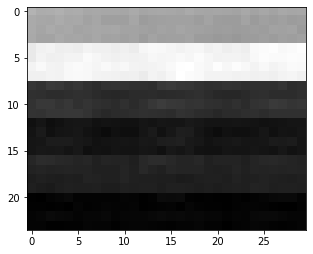

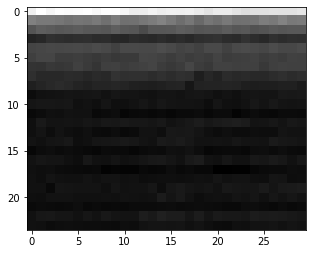

[15701/17000] loss_d: -0.398, loss_g: 1.236
[15702/17000] loss_d: -0.390, loss_g: 1.341
[15703/17000] loss_d: -0.399, loss_g: 1.303
[15704/17000] loss_d: -0.398, loss_g: 1.331
[15705/17000] loss_d: -0.356, loss_g: 1.277
[15706/17000] loss_d: -0.426, loss_g: 1.194
[15707/17000] loss_d: -0.381, loss_g: 1.265
[15708/17000] loss_d: -0.386, loss_g: 1.257
[15709/17000] loss_d: -0.367, loss_g: 1.186
[15710/17000] loss_d: -0.386, loss_g: 1.287
[15711/17000] loss_d: -0.414, loss_g: 1.272
[15712/17000] loss_d: -0.379, loss_g: 1.303
[15713/17000] loss_d: -0.403, loss_g: 1.248
[15714/17000] loss_d: -0.419, loss_g: 1.380
[15715/17000] loss_d: -0.364, loss_g: 1.280
[15716/17000] loss_d: -0.420, loss_g: 1.310
[15717/17000] loss_d: -0.394, loss_g: 1.343
[15718/17000] loss_d: -0.390, loss_g: 1.364
[15719/17000] loss_d: -0.380, loss_g: 1.238
[15720/17000] loss_d: -0.346, loss_g: 1.286
[15721/17000] loss_d: -0.401, loss_g: 1.259
[15722/17000] loss_d: -0.386, loss_g: 1.233
[15723/17000] loss_d: -0.402, lo

<Figure size 432x288 with 0 Axes>

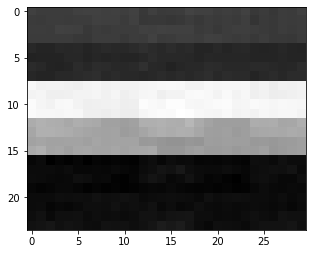

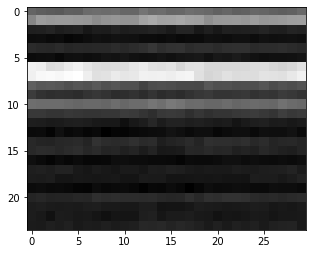

[15751/17000] loss_d: -0.405, loss_g: 1.319
[15752/17000] loss_d: -0.381, loss_g: 1.242
[15753/17000] loss_d: -0.410, loss_g: 1.264
[15754/17000] loss_d: -0.400, loss_g: 1.262
[15755/17000] loss_d: -0.398, loss_g: 1.299
[15756/17000] loss_d: -0.400, loss_g: 1.262
[15757/17000] loss_d: -0.418, loss_g: 1.252
[15758/17000] loss_d: -0.384, loss_g: 1.251
[15759/17000] loss_d: -0.394, loss_g: 1.226
[15760/17000] loss_d: -0.394, loss_g: 1.240
[15761/17000] loss_d: -0.382, loss_g: 1.276
[15762/17000] loss_d: -0.413, loss_g: 1.193
[15763/17000] loss_d: -0.399, loss_g: 1.233
[15764/17000] loss_d: -0.414, loss_g: 1.290
[15765/17000] loss_d: -0.393, loss_g: 1.192
[15766/17000] loss_d: -0.378, loss_g: 1.168
[15767/17000] loss_d: -0.362, loss_g: 1.191
[15768/17000] loss_d: -0.410, loss_g: 1.243
[15769/17000] loss_d: -0.420, loss_g: 1.305
[15770/17000] loss_d: -0.380, loss_g: 1.340
[15771/17000] loss_d: -0.373, loss_g: 1.273
[15772/17000] loss_d: -0.392, loss_g: 1.310
[15773/17000] loss_d: -0.381, lo

<Figure size 432x288 with 0 Axes>

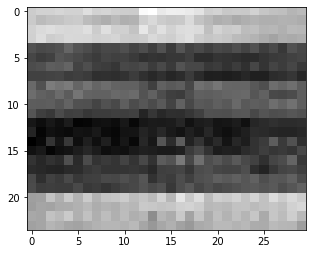

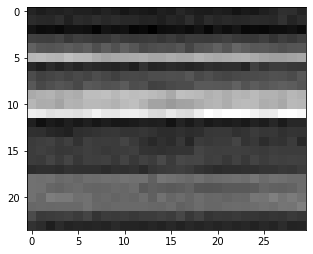

[15801/17000] loss_d: -0.375, loss_g: 1.311
[15802/17000] loss_d: -0.364, loss_g: 1.218
[15803/17000] loss_d: -0.395, loss_g: 1.242
[15804/17000] loss_d: -0.419, loss_g: 1.229
[15805/17000] loss_d: -0.410, loss_g: 1.235
[15806/17000] loss_d: -0.345, loss_g: 1.355
[15807/17000] loss_d: -0.388, loss_g: 1.280
[15808/17000] loss_d: -0.356, loss_g: 1.220
[15809/17000] loss_d: -0.375, loss_g: 1.201
[15810/17000] loss_d: -0.380, loss_g: 1.257
[15811/17000] loss_d: -0.394, loss_g: 1.236
[15812/17000] loss_d: -0.404, loss_g: 1.274
[15813/17000] loss_d: -0.351, loss_g: 1.311
[15814/17000] loss_d: -0.405, loss_g: 1.335
[15815/17000] loss_d: -0.369, loss_g: 1.236
[15816/17000] loss_d: -0.379, loss_g: 1.255
[15817/17000] loss_d: -0.343, loss_g: 1.269
[15818/17000] loss_d: -0.407, loss_g: 1.219
[15819/17000] loss_d: -0.386, loss_g: 1.312
[15820/17000] loss_d: -0.404, loss_g: 1.286
[15821/17000] loss_d: -0.389, loss_g: 1.218
[15822/17000] loss_d: -0.405, loss_g: 1.267
[15823/17000] loss_d: -0.385, lo

<Figure size 432x288 with 0 Axes>

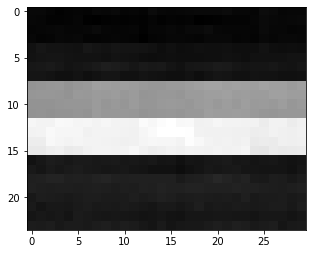

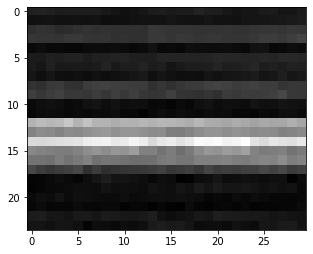

[15851/17000] loss_d: -0.369, loss_g: 1.239
[15852/17000] loss_d: -0.395, loss_g: 1.264
[15853/17000] loss_d: -0.406, loss_g: 1.182
[15854/17000] loss_d: -0.405, loss_g: 1.310
[15855/17000] loss_d: -0.421, loss_g: 1.378
[15856/17000] loss_d: -0.399, loss_g: 1.274
[15857/17000] loss_d: -0.370, loss_g: 1.300
[15858/17000] loss_d: -0.370, loss_g: 1.422
[15859/17000] loss_d: -0.393, loss_g: 1.264
[15860/17000] loss_d: -0.368, loss_g: 1.293
[15861/17000] loss_d: -0.402, loss_g: 1.329
[15862/17000] loss_d: -0.393, loss_g: 1.221
[15863/17000] loss_d: -0.397, loss_g: 1.240
[15864/17000] loss_d: -0.396, loss_g: 1.239
[15865/17000] loss_d: -0.360, loss_g: 1.296
[15866/17000] loss_d: -0.363, loss_g: 1.257
[15867/17000] loss_d: -0.394, loss_g: 1.306
[15868/17000] loss_d: -0.359, loss_g: 1.229
[15869/17000] loss_d: -0.354, loss_g: 1.266
[15870/17000] loss_d: -0.394, loss_g: 1.334
[15871/17000] loss_d: -0.376, loss_g: 1.404
[15872/17000] loss_d: -0.351, loss_g: 1.326
[15873/17000] loss_d: -0.393, lo

<Figure size 432x288 with 0 Axes>

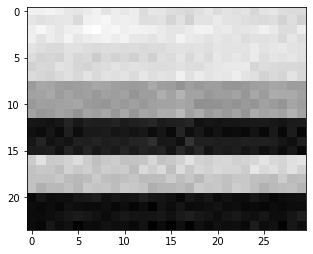

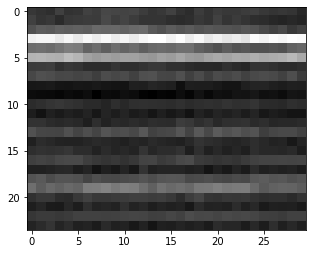

[15901/17000] loss_d: -0.378, loss_g: 1.283
[15902/17000] loss_d: -0.367, loss_g: 1.277
[15903/17000] loss_d: -0.371, loss_g: 1.244
[15904/17000] loss_d: -0.382, loss_g: 1.238
[15905/17000] loss_d: -0.387, loss_g: 1.321
[15906/17000] loss_d: -0.376, loss_g: 1.375
[15907/17000] loss_d: -0.363, loss_g: 1.471
[15908/17000] loss_d: -0.389, loss_g: 1.359
[15909/17000] loss_d: -0.420, loss_g: 1.246
[15910/17000] loss_d: -0.369, loss_g: 1.263
[15911/17000] loss_d: -0.374, loss_g: 1.361
[15912/17000] loss_d: -0.381, loss_g: 1.320
[15913/17000] loss_d: -0.399, loss_g: 1.292
[15914/17000] loss_d: -0.392, loss_g: 1.392
[15915/17000] loss_d: -0.384, loss_g: 1.277
[15916/17000] loss_d: -0.399, loss_g: 1.302
[15917/17000] loss_d: -0.392, loss_g: 1.301
[15918/17000] loss_d: -0.397, loss_g: 1.220
[15919/17000] loss_d: -0.435, loss_g: 1.296
[15920/17000] loss_d: -0.393, loss_g: 1.296
[15921/17000] loss_d: -0.405, loss_g: 1.263
[15922/17000] loss_d: -0.398, loss_g: 1.223
[15923/17000] loss_d: -0.364, lo

<Figure size 432x288 with 0 Axes>

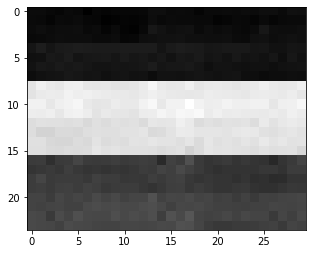

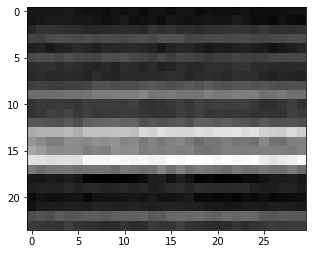

[15951/17000] loss_d: -0.361, loss_g: 1.226
[15952/17000] loss_d: -0.359, loss_g: 1.273
[15953/17000] loss_d: -0.364, loss_g: 1.248
[15954/17000] loss_d: -0.413, loss_g: 1.292
[15955/17000] loss_d: -0.364, loss_g: 1.359
[15956/17000] loss_d: -0.366, loss_g: 1.281
[15957/17000] loss_d: -0.356, loss_g: 1.182
[15958/17000] loss_d: -0.385, loss_g: 1.269
[15959/17000] loss_d: -0.392, loss_g: 1.189
[15960/17000] loss_d: -0.360, loss_g: 1.212
[15961/17000] loss_d: -0.397, loss_g: 1.255
[15962/17000] loss_d: -0.358, loss_g: 1.205
[15963/17000] loss_d: -0.384, loss_g: 1.308
[15964/17000] loss_d: -0.417, loss_g: 1.197
[15965/17000] loss_d: -0.412, loss_g: 1.251
[15966/17000] loss_d: -0.414, loss_g: 1.249
[15967/17000] loss_d: -0.410, loss_g: 1.248
[15968/17000] loss_d: -0.380, loss_g: 1.258
[15969/17000] loss_d: -0.369, loss_g: 1.181
[15970/17000] loss_d: -0.374, loss_g: 1.251
[15971/17000] loss_d: -0.413, loss_g: 1.155
[15972/17000] loss_d: -0.360, loss_g: 1.287
[15973/17000] loss_d: -0.399, lo

<Figure size 432x288 with 0 Axes>

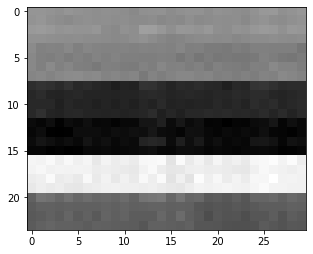

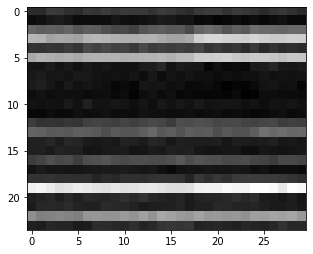

[16001/17000] loss_d: -0.382, loss_g: 1.303
[16002/17000] loss_d: -0.378, loss_g: 1.270
[16003/17000] loss_d: -0.390, loss_g: 1.278
[16004/17000] loss_d: -0.385, loss_g: 1.301
[16005/17000] loss_d: -0.388, loss_g: 1.318
[16006/17000] loss_d: -0.361, loss_g: 1.200
[16007/17000] loss_d: -0.372, loss_g: 1.204
[16008/17000] loss_d: -0.369, loss_g: 1.182
[16009/17000] loss_d: -0.421, loss_g: 1.244
[16010/17000] loss_d: -0.399, loss_g: 1.207
[16011/17000] loss_d: -0.393, loss_g: 1.280
[16012/17000] loss_d: -0.378, loss_g: 1.214
[16013/17000] loss_d: -0.366, loss_g: 1.197
[16014/17000] loss_d: -0.421, loss_g: 1.216
[16015/17000] loss_d: -0.380, loss_g: 1.205
[16016/17000] loss_d: -0.403, loss_g: 1.212
[16017/17000] loss_d: -0.399, loss_g: 1.158
[16018/17000] loss_d: -0.398, loss_g: 1.226
[16019/17000] loss_d: -0.373, loss_g: 1.096
[16020/17000] loss_d: -0.379, loss_g: 1.191
[16021/17000] loss_d: -0.400, loss_g: 1.148
[16022/17000] loss_d: -0.351, loss_g: 1.209
[16023/17000] loss_d: -0.383, lo

<Figure size 432x288 with 0 Axes>

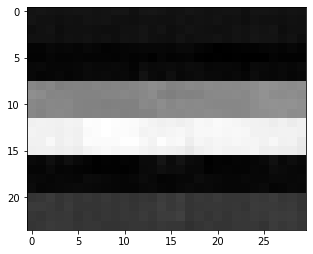

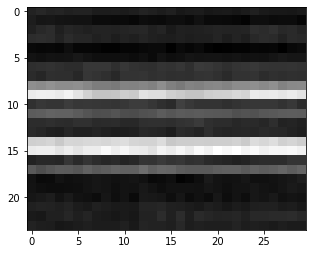

[16051/17000] loss_d: -0.402, loss_g: 1.305
[16052/17000] loss_d: -0.387, loss_g: 1.261
[16053/17000] loss_d: -0.411, loss_g: 1.265
[16054/17000] loss_d: -0.357, loss_g: 1.236
[16055/17000] loss_d: -0.347, loss_g: 1.314
[16056/17000] loss_d: -0.367, loss_g: 1.244
[16057/17000] loss_d: -0.383, loss_g: 1.257
[16058/17000] loss_d: -0.393, loss_g: 1.290
[16059/17000] loss_d: -0.409, loss_g: 1.226
[16060/17000] loss_d: -0.358, loss_g: 1.196
[16061/17000] loss_d: -0.395, loss_g: 1.286
[16062/17000] loss_d: -0.405, loss_g: 1.248
[16063/17000] loss_d: -0.376, loss_g: 1.304
[16064/17000] loss_d: -0.378, loss_g: 1.222
[16065/17000] loss_d: -0.384, loss_g: 1.230
[16066/17000] loss_d: -0.406, loss_g: 1.309
[16067/17000] loss_d: -0.364, loss_g: 1.245
[16068/17000] loss_d: -0.365, loss_g: 1.193
[16069/17000] loss_d: -0.399, loss_g: 1.266
[16070/17000] loss_d: -0.386, loss_g: 1.167
[16071/17000] loss_d: -0.387, loss_g: 1.183
[16072/17000] loss_d: -0.373, loss_g: 1.177
[16073/17000] loss_d: -0.363, lo

<Figure size 432x288 with 0 Axes>

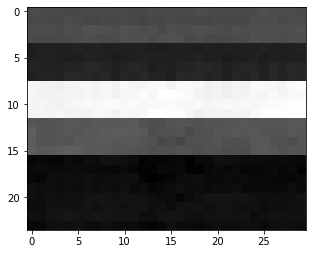

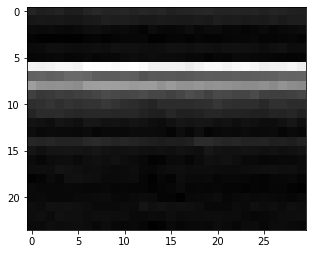

[16101/17000] loss_d: -0.351, loss_g: 1.248
[16102/17000] loss_d: -0.368, loss_g: 1.198
[16103/17000] loss_d: -0.378, loss_g: 1.205
[16104/17000] loss_d: -0.365, loss_g: 1.213
[16105/17000] loss_d: -0.371, loss_g: 1.268
[16106/17000] loss_d: -0.423, loss_g: 1.233
[16107/17000] loss_d: -0.400, loss_g: 1.277
[16108/17000] loss_d: -0.397, loss_g: 1.298
[16109/17000] loss_d: -0.401, loss_g: 1.214
[16110/17000] loss_d: -0.378, loss_g: 1.263
[16111/17000] loss_d: -0.370, loss_g: 1.311
[16112/17000] loss_d: -0.413, loss_g: 1.254
[16113/17000] loss_d: -0.403, loss_g: 1.270
[16114/17000] loss_d: -0.400, loss_g: 1.289
[16115/17000] loss_d: -0.411, loss_g: 1.288
[16116/17000] loss_d: -0.400, loss_g: 1.274
[16117/17000] loss_d: -0.419, loss_g: 1.252
[16118/17000] loss_d: -0.357, loss_g: 1.117
[16119/17000] loss_d: -0.366, loss_g: 1.219
[16120/17000] loss_d: -0.347, loss_g: 1.238
[16121/17000] loss_d: -0.366, loss_g: 1.250
[16122/17000] loss_d: -0.396, loss_g: 1.221
[16123/17000] loss_d: -0.387, lo

<Figure size 432x288 with 0 Axes>

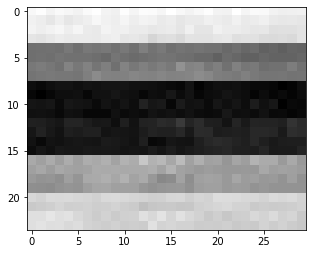

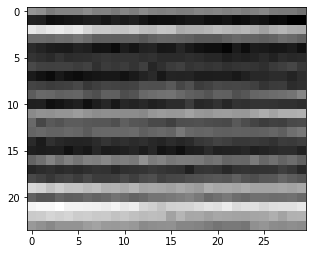

[16151/17000] loss_d: -0.379, loss_g: 1.222
[16152/17000] loss_d: -0.421, loss_g: 1.238
[16153/17000] loss_d: -0.363, loss_g: 1.256
[16154/17000] loss_d: -0.371, loss_g: 1.196
[16155/17000] loss_d: -0.407, loss_g: 1.273
[16156/17000] loss_d: -0.379, loss_g: 1.185
[16157/17000] loss_d: -0.404, loss_g: 1.259
[16158/17000] loss_d: -0.387, loss_g: 1.196
[16159/17000] loss_d: -0.383, loss_g: 1.235
[16160/17000] loss_d: -0.391, loss_g: 1.245
[16161/17000] loss_d: -0.397, loss_g: 1.191
[16162/17000] loss_d: -0.370, loss_g: 1.233
[16163/17000] loss_d: -0.370, loss_g: 1.283
[16164/17000] loss_d: -0.353, loss_g: 1.288
[16165/17000] loss_d: -0.393, loss_g: 1.273
[16166/17000] loss_d: -0.383, loss_g: 1.271
[16167/17000] loss_d: -0.368, loss_g: 1.336
[16168/17000] loss_d: -0.429, loss_g: 1.279
[16169/17000] loss_d: -0.392, loss_g: 1.258
[16170/17000] loss_d: -0.363, loss_g: 1.182
[16171/17000] loss_d: -0.397, loss_g: 1.311
[16172/17000] loss_d: -0.407, loss_g: 1.224
[16173/17000] loss_d: -0.412, lo

<Figure size 432x288 with 0 Axes>

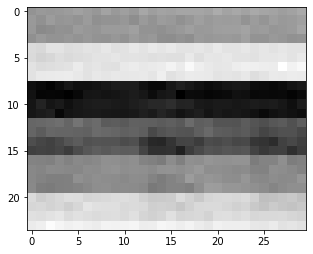

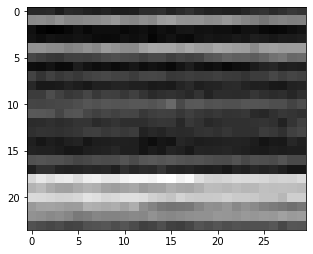

[16201/17000] loss_d: -0.408, loss_g: 1.291
[16202/17000] loss_d: -0.399, loss_g: 1.282
[16203/17000] loss_d: -0.403, loss_g: 1.264
[16204/17000] loss_d: -0.403, loss_g: 1.291
[16205/17000] loss_d: -0.370, loss_g: 1.206
[16206/17000] loss_d: -0.407, loss_g: 1.274
[16207/17000] loss_d: -0.387, loss_g: 1.520
[16208/17000] loss_d: -0.412, loss_g: 1.318
[16209/17000] loss_d: -0.378, loss_g: 1.332
[16210/17000] loss_d: -0.374, loss_g: 1.253
[16211/17000] loss_d: -0.408, loss_g: 1.305
[16212/17000] loss_d: -0.420, loss_g: 1.333
[16213/17000] loss_d: -0.383, loss_g: 1.213
[16214/17000] loss_d: -0.405, loss_g: 1.162
[16215/17000] loss_d: -0.383, loss_g: 1.159
[16216/17000] loss_d: -0.414, loss_g: 1.206
[16217/17000] loss_d: -0.423, loss_g: 1.287
[16218/17000] loss_d: -0.417, loss_g: 1.272
[16219/17000] loss_d: -0.365, loss_g: 1.279
[16220/17000] loss_d: -0.389, loss_g: 1.299
[16221/17000] loss_d: -0.416, loss_g: 1.288
[16222/17000] loss_d: -0.415, loss_g: 1.499
[16223/17000] loss_d: -0.408, lo

<Figure size 432x288 with 0 Axes>

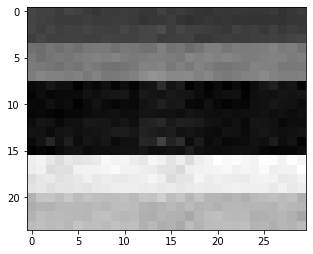

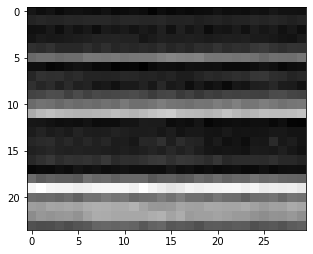

[16251/17000] loss_d: -0.379, loss_g: 1.234
[16252/17000] loss_d: -0.381, loss_g: 1.250
[16253/17000] loss_d: -0.423, loss_g: 1.259
[16254/17000] loss_d: -0.416, loss_g: 1.177
[16255/17000] loss_d: -0.382, loss_g: 1.248
[16256/17000] loss_d: -0.382, loss_g: 1.225
[16257/17000] loss_d: -0.394, loss_g: 1.205
[16258/17000] loss_d: -0.396, loss_g: 1.279
[16259/17000] loss_d: -0.379, loss_g: 1.250
[16260/17000] loss_d: -0.384, loss_g: 1.256
[16261/17000] loss_d: -0.398, loss_g: 1.249
[16262/17000] loss_d: -0.359, loss_g: 1.266
[16263/17000] loss_d: -0.375, loss_g: 1.260
[16264/17000] loss_d: -0.420, loss_g: 1.173
[16265/17000] loss_d: -0.426, loss_g: 1.295
[16266/17000] loss_d: -0.400, loss_g: 1.268
[16267/17000] loss_d: -0.373, loss_g: 1.270
[16268/17000] loss_d: -0.414, loss_g: 1.335
[16269/17000] loss_d: -0.406, loss_g: 1.182
[16270/17000] loss_d: -0.375, loss_g: 1.201
[16271/17000] loss_d: -0.384, loss_g: 1.244
[16272/17000] loss_d: -0.412, loss_g: 1.273
[16273/17000] loss_d: -0.397, lo

<Figure size 432x288 with 0 Axes>

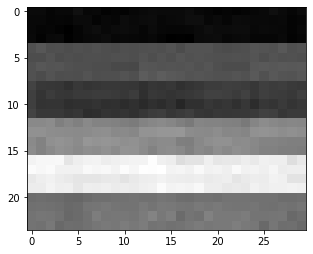

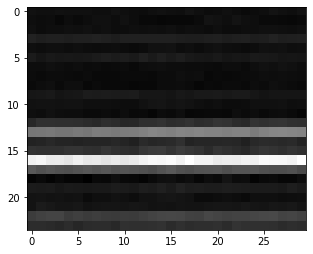

[16301/17000] loss_d: -0.381, loss_g: 1.310
[16302/17000] loss_d: -0.383, loss_g: 1.352
[16303/17000] loss_d: -0.324, loss_g: 1.290
[16304/17000] loss_d: -0.353, loss_g: 1.306
[16305/17000] loss_d: -0.393, loss_g: 1.418
[16306/17000] loss_d: -0.367, loss_g: 1.338
[16307/17000] loss_d: -0.407, loss_g: 1.260
[16308/17000] loss_d: -0.387, loss_g: 1.310
[16309/17000] loss_d: -0.366, loss_g: 1.361
[16310/17000] loss_d: -0.395, loss_g: 1.327
[16311/17000] loss_d: -0.390, loss_g: 1.279
[16312/17000] loss_d: -0.399, loss_g: 1.242
[16313/17000] loss_d: -0.375, loss_g: 1.219
[16314/17000] loss_d: -0.374, loss_g: 1.271
[16315/17000] loss_d: -0.351, loss_g: 1.268
[16316/17000] loss_d: -0.419, loss_g: 1.239
[16317/17000] loss_d: -0.411, loss_g: 1.324
[16318/17000] loss_d: -0.423, loss_g: 1.304
[16319/17000] loss_d: -0.397, loss_g: 1.354
[16320/17000] loss_d: -0.383, loss_g: 1.351
[16321/17000] loss_d: -0.380, loss_g: 1.263
[16322/17000] loss_d: -0.364, loss_g: 1.360
[16323/17000] loss_d: -0.349, lo

<Figure size 432x288 with 0 Axes>

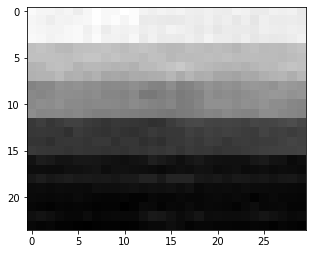

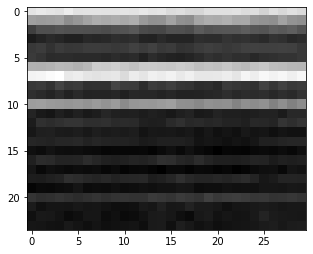

[16351/17000] loss_d: -0.392, loss_g: 1.337
[16352/17000] loss_d: -0.396, loss_g: 1.357
[16353/17000] loss_d: -0.369, loss_g: 1.298
[16354/17000] loss_d: -0.385, loss_g: 1.294
[16355/17000] loss_d: -0.354, loss_g: 1.346
[16356/17000] loss_d: -0.396, loss_g: 1.387
[16357/17000] loss_d: -0.392, loss_g: 1.292
[16358/17000] loss_d: -0.375, loss_g: 1.348
[16359/17000] loss_d: -0.395, loss_g: 1.397
[16360/17000] loss_d: -0.404, loss_g: 1.305
[16361/17000] loss_d: -0.358, loss_g: 1.339
[16362/17000] loss_d: -0.380, loss_g: 1.331
[16363/17000] loss_d: -0.415, loss_g: 1.323
[16364/17000] loss_d: -0.390, loss_g: 1.269
[16365/17000] loss_d: -0.364, loss_g: 1.349
[16366/17000] loss_d: -0.389, loss_g: 1.354
[16367/17000] loss_d: -0.417, loss_g: 1.337
[16368/17000] loss_d: -0.388, loss_g: 1.450
[16369/17000] loss_d: -0.444, loss_g: 1.415
[16370/17000] loss_d: -0.333, loss_g: 1.366
[16371/17000] loss_d: -0.405, loss_g: 1.354
[16372/17000] loss_d: -0.373, loss_g: 1.377
[16373/17000] loss_d: -0.453, lo

<Figure size 432x288 with 0 Axes>

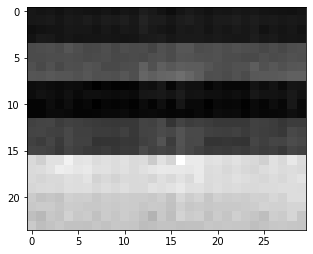

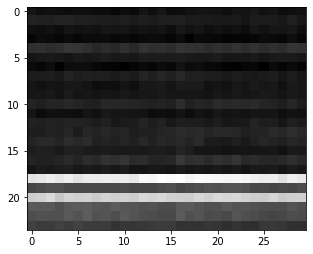

[16401/17000] loss_d: -0.408, loss_g: 1.314
[16402/17000] loss_d: -0.423, loss_g: 1.402
[16403/17000] loss_d: -0.415, loss_g: 1.346
[16404/17000] loss_d: -0.354, loss_g: 1.368
[16405/17000] loss_d: -0.371, loss_g: 1.299
[16406/17000] loss_d: -0.418, loss_g: 1.277
[16407/17000] loss_d: -0.393, loss_g: 1.282
[16408/17000] loss_d: -0.415, loss_g: 1.303
[16409/17000] loss_d: -0.443, loss_g: 1.275
[16410/17000] loss_d: -0.388, loss_g: 1.308
[16411/17000] loss_d: -0.406, loss_g: 1.357
[16412/17000] loss_d: -0.383, loss_g: 1.244
[16413/17000] loss_d: -0.410, loss_g: 1.215
[16414/17000] loss_d: -0.400, loss_g: 1.287
[16415/17000] loss_d: -0.404, loss_g: 1.240
[16416/17000] loss_d: -0.403, loss_g: 1.321
[16417/17000] loss_d: -0.402, loss_g: 1.296
[16418/17000] loss_d: -0.383, loss_g: 1.282
[16419/17000] loss_d: -0.360, loss_g: 1.309
[16420/17000] loss_d: -0.369, loss_g: 1.377
[16421/17000] loss_d: -0.415, loss_g: 1.269
[16422/17000] loss_d: -0.389, loss_g: 1.299
[16423/17000] loss_d: -0.432, lo

<Figure size 432x288 with 0 Axes>

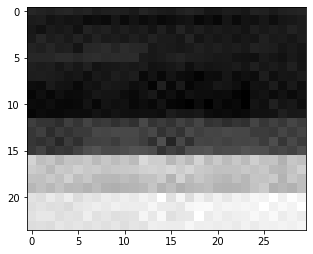

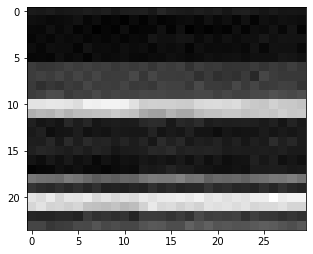

[16451/17000] loss_d: -0.394, loss_g: 1.399
[16452/17000] loss_d: -0.362, loss_g: 1.331
[16453/17000] loss_d: -0.374, loss_g: 1.355
[16454/17000] loss_d: -0.399, loss_g: 1.327
[16455/17000] loss_d: -0.421, loss_g: 1.345
[16456/17000] loss_d: -0.402, loss_g: 1.259
[16457/17000] loss_d: -0.380, loss_g: 1.305
[16458/17000] loss_d: -0.422, loss_g: 1.319
[16459/17000] loss_d: -0.407, loss_g: 1.291
[16460/17000] loss_d: -0.373, loss_g: 1.296
[16461/17000] loss_d: -0.391, loss_g: 1.276
[16462/17000] loss_d: -0.386, loss_g: 1.325
[16463/17000] loss_d: -0.413, loss_g: 1.380
[16464/17000] loss_d: -0.419, loss_g: 1.328
[16465/17000] loss_d: -0.406, loss_g: 1.422
[16466/17000] loss_d: -0.409, loss_g: 1.329
[16467/17000] loss_d: -0.397, loss_g: 1.360
[16468/17000] loss_d: -0.354, loss_g: 1.344
[16469/17000] loss_d: -0.383, loss_g: 1.386
[16470/17000] loss_d: -0.350, loss_g: 1.298
[16471/17000] loss_d: -0.384, loss_g: 1.341
[16472/17000] loss_d: -0.403, loss_g: 1.278
[16473/17000] loss_d: -0.371, lo

<Figure size 432x288 with 0 Axes>

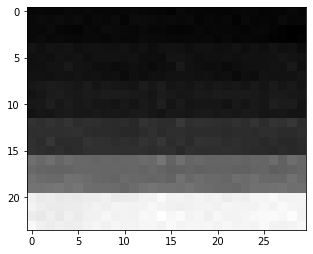

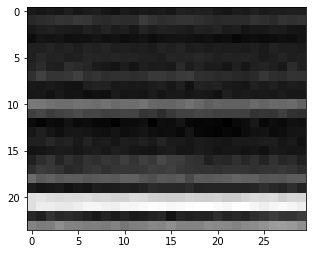

[16501/17000] loss_d: -0.388, loss_g: 1.169
[16502/17000] loss_d: -0.354, loss_g: 1.257
[16503/17000] loss_d: -0.351, loss_g: 1.281
[16504/17000] loss_d: -0.399, loss_g: 1.284
[16505/17000] loss_d: -0.384, loss_g: 1.255
[16506/17000] loss_d: -0.386, loss_g: 1.212
[16507/17000] loss_d: -0.378, loss_g: 1.153
[16508/17000] loss_d: -0.400, loss_g: 1.245
[16509/17000] loss_d: -0.356, loss_g: 1.229
[16510/17000] loss_d: -0.376, loss_g: 1.282
[16511/17000] loss_d: -0.377, loss_g: 1.285
[16512/17000] loss_d: -0.352, loss_g: 1.284
[16513/17000] loss_d: -0.383, loss_g: 1.235
[16514/17000] loss_d: -0.373, loss_g: 1.291
[16515/17000] loss_d: -0.385, loss_g: 1.287
[16516/17000] loss_d: -0.397, loss_g: 1.337
[16517/17000] loss_d: -0.418, loss_g: 1.325
[16518/17000] loss_d: -0.394, loss_g: 1.331
[16519/17000] loss_d: -0.338, loss_g: 1.345
[16520/17000] loss_d: -0.386, loss_g: 1.372
[16521/17000] loss_d: -0.377, loss_g: 1.280
[16522/17000] loss_d: -0.392, loss_g: 1.247
[16523/17000] loss_d: -0.381, lo

<Figure size 432x288 with 0 Axes>

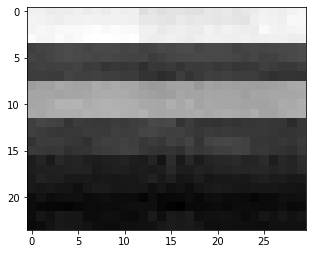

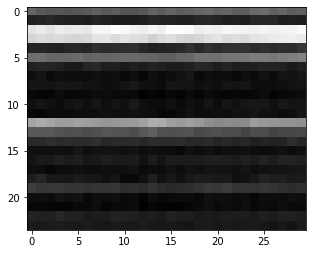

[16551/17000] loss_d: -0.397, loss_g: 1.181
[16552/17000] loss_d: -0.373, loss_g: 1.258
[16553/17000] loss_d: -0.359, loss_g: 1.231
[16554/17000] loss_d: -0.380, loss_g: 1.278
[16555/17000] loss_d: -0.370, loss_g: 1.276
[16556/17000] loss_d: -0.383, loss_g: 1.253
[16557/17000] loss_d: -0.388, loss_g: 1.260
[16558/17000] loss_d: -0.384, loss_g: 1.244
[16559/17000] loss_d: -0.386, loss_g: 1.334
[16560/17000] loss_d: -0.377, loss_g: 1.238
[16561/17000] loss_d: -0.353, loss_g: 1.334
[16562/17000] loss_d: -0.414, loss_g: 1.276
[16563/17000] loss_d: -0.387, loss_g: 1.286
[16564/17000] loss_d: -0.362, loss_g: 1.232
[16565/17000] loss_d: -0.400, loss_g: 1.263
[16566/17000] loss_d: -0.399, loss_g: 1.295
[16567/17000] loss_d: -0.376, loss_g: 1.280
[16568/17000] loss_d: -0.387, loss_g: 1.276
[16569/17000] loss_d: -0.364, loss_g: 1.294
[16570/17000] loss_d: -0.377, loss_g: 1.274
[16571/17000] loss_d: -0.397, loss_g: 1.207
[16572/17000] loss_d: -0.412, loss_g: 1.328
[16573/17000] loss_d: -0.381, lo

<Figure size 432x288 with 0 Axes>

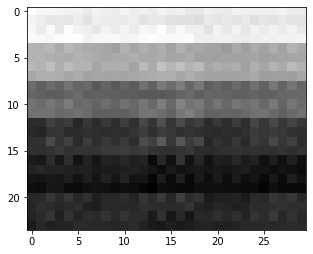

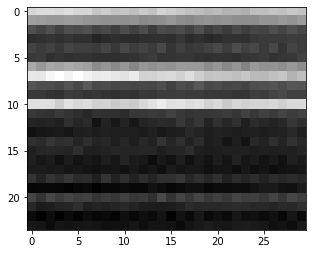

[16601/17000] loss_d: -0.389, loss_g: 1.234
[16602/17000] loss_d: -0.374, loss_g: 1.270
[16603/17000] loss_d: -0.364, loss_g: 1.341
[16604/17000] loss_d: -0.371, loss_g: 1.220
[16605/17000] loss_d: -0.343, loss_g: 1.236
[16606/17000] loss_d: -0.384, loss_g: 1.292
[16607/17000] loss_d: -0.355, loss_g: 1.248
[16608/17000] loss_d: -0.390, loss_g: 1.258
[16609/17000] loss_d: -0.349, loss_g: 1.216
[16610/17000] loss_d: -0.371, loss_g: 1.278
[16611/17000] loss_d: -0.398, loss_g: 1.274
[16612/17000] loss_d: -0.413, loss_g: 1.263
[16613/17000] loss_d: -0.347, loss_g: 1.314
[16614/17000] loss_d: -0.395, loss_g: 1.384
[16615/17000] loss_d: -0.398, loss_g: 1.287
[16616/17000] loss_d: -0.376, loss_g: 1.208
[16617/17000] loss_d: -0.414, loss_g: 1.151
[16618/17000] loss_d: -0.383, loss_g: 1.282
[16619/17000] loss_d: -0.391, loss_g: 1.267
[16620/17000] loss_d: -0.360, loss_g: 1.277
[16621/17000] loss_d: -0.396, loss_g: 1.291
[16622/17000] loss_d: -0.377, loss_g: 1.306
[16623/17000] loss_d: -0.382, lo

<Figure size 432x288 with 0 Axes>

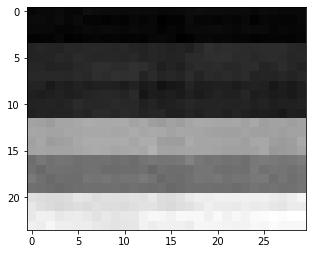

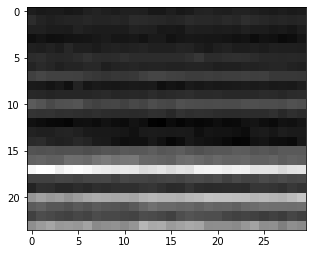

[16651/17000] loss_d: -0.396, loss_g: 1.288
[16652/17000] loss_d: -0.355, loss_g: 1.441
[16653/17000] loss_d: -0.419, loss_g: 1.285
[16654/17000] loss_d: -0.397, loss_g: 1.380
[16655/17000] loss_d: -0.366, loss_g: 1.358
[16656/17000] loss_d: -0.430, loss_g: 1.355
[16657/17000] loss_d: -0.406, loss_g: 1.390
[16658/17000] loss_d: -0.401, loss_g: 1.317
[16659/17000] loss_d: -0.362, loss_g: 1.373
[16660/17000] loss_d: -0.347, loss_g: 1.423
[16661/17000] loss_d: -0.399, loss_g: 1.285
[16662/17000] loss_d: -0.372, loss_g: 1.358
[16663/17000] loss_d: -0.406, loss_g: 1.346
[16664/17000] loss_d: -0.399, loss_g: 1.330
[16665/17000] loss_d: -0.411, loss_g: 1.333
[16666/17000] loss_d: -0.363, loss_g: 1.355
[16667/17000] loss_d: -0.381, loss_g: 1.336
[16668/17000] loss_d: -0.402, loss_g: 1.412
[16669/17000] loss_d: -0.395, loss_g: 1.385
[16670/17000] loss_d: -0.362, loss_g: 1.380
[16671/17000] loss_d: -0.394, loss_g: 1.305
[16672/17000] loss_d: -0.404, loss_g: 1.394
[16673/17000] loss_d: -0.401, lo

<Figure size 432x288 with 0 Axes>

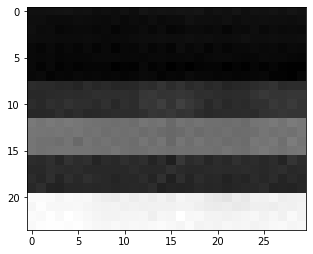

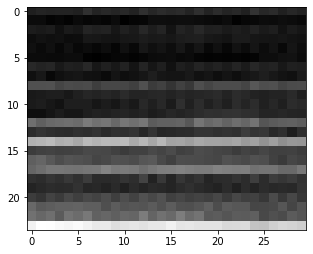

[16701/17000] loss_d: -0.365, loss_g: 1.359
[16702/17000] loss_d: -0.400, loss_g: 1.355
[16703/17000] loss_d: -0.407, loss_g: 1.380
[16704/17000] loss_d: -0.389, loss_g: 1.278
[16705/17000] loss_d: -0.380, loss_g: 1.308
[16706/17000] loss_d: -0.372, loss_g: 1.262
[16707/17000] loss_d: -0.387, loss_g: 1.362
[16708/17000] loss_d: -0.389, loss_g: 1.321
[16709/17000] loss_d: -0.402, loss_g: 1.261
[16710/17000] loss_d: -0.385, loss_g: 1.237
[16711/17000] loss_d: -0.370, loss_g: 1.298
[16712/17000] loss_d: -0.388, loss_g: 1.352
[16713/17000] loss_d: -0.373, loss_g: 1.332
[16714/17000] loss_d: -0.395, loss_g: 1.302
[16715/17000] loss_d: -0.429, loss_g: 1.306
[16716/17000] loss_d: -0.393, loss_g: 1.312
[16717/17000] loss_d: -0.404, loss_g: 1.293
[16718/17000] loss_d: -0.424, loss_g: 1.324
[16719/17000] loss_d: -0.386, loss_g: 1.388
[16720/17000] loss_d: -0.389, loss_g: 1.312
[16721/17000] loss_d: -0.417, loss_g: 1.325
[16722/17000] loss_d: -0.401, loss_g: 1.260
[16723/17000] loss_d: -0.407, lo

<Figure size 432x288 with 0 Axes>

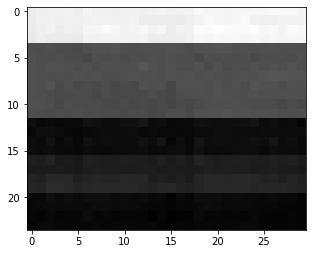

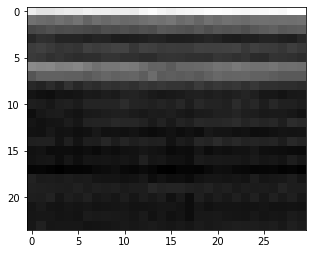

[16751/17000] loss_d: -0.397, loss_g: 1.349
[16752/17000] loss_d: -0.368, loss_g: 1.361
[16753/17000] loss_d: -0.342, loss_g: 1.302
[16754/17000] loss_d: -0.392, loss_g: 1.395
[16755/17000] loss_d: -0.388, loss_g: 1.354
[16756/17000] loss_d: -0.382, loss_g: 1.245
[16757/17000] loss_d: -0.392, loss_g: 1.348
[16758/17000] loss_d: -0.378, loss_g: 1.304
[16759/17000] loss_d: -0.368, loss_g: 1.298
[16760/17000] loss_d: -0.396, loss_g: 1.250
[16761/17000] loss_d: -0.396, loss_g: 1.315
[16762/17000] loss_d: -0.415, loss_g: 1.296
[16763/17000] loss_d: -0.407, loss_g: 1.296
[16764/17000] loss_d: -0.393, loss_g: 1.421
[16765/17000] loss_d: -0.376, loss_g: 1.307
[16766/17000] loss_d: -0.382, loss_g: 1.256
[16767/17000] loss_d: -0.393, loss_g: 1.374
[16768/17000] loss_d: -0.406, loss_g: 1.334
[16769/17000] loss_d: -0.341, loss_g: 1.291
[16770/17000] loss_d: -0.391, loss_g: 1.359
[16771/17000] loss_d: -0.405, loss_g: 1.319
[16772/17000] loss_d: -0.369, loss_g: 1.314
[16773/17000] loss_d: -0.410, lo

<Figure size 432x288 with 0 Axes>

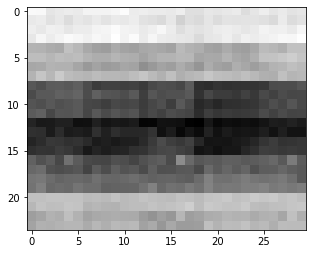

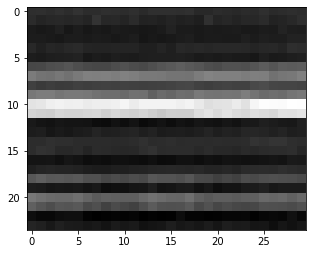

[16801/17000] loss_d: -0.343, loss_g: 1.330
[16802/17000] loss_d: -0.353, loss_g: 1.263
[16803/17000] loss_d: -0.398, loss_g: 1.249
[16804/17000] loss_d: -0.410, loss_g: 1.275
[16805/17000] loss_d: -0.364, loss_g: 1.274
[16806/17000] loss_d: -0.381, loss_g: 1.237
[16807/17000] loss_d: -0.382, loss_g: 1.274
[16808/17000] loss_d: -0.393, loss_g: 1.279
[16809/17000] loss_d: -0.380, loss_g: 1.284
[16810/17000] loss_d: -0.359, loss_g: 1.327
[16811/17000] loss_d: -0.382, loss_g: 1.286
[16812/17000] loss_d: -0.378, loss_g: 1.331
[16813/17000] loss_d: -0.415, loss_g: 1.281
[16814/17000] loss_d: -0.389, loss_g: 1.119
[16815/17000] loss_d: -0.404, loss_g: 1.156
[16816/17000] loss_d: -0.374, loss_g: 1.372
[16817/17000] loss_d: -0.351, loss_g: 1.339
[16818/17000] loss_d: -0.399, loss_g: 1.270
[16819/17000] loss_d: -0.388, loss_g: 1.312
[16820/17000] loss_d: -0.394, loss_g: 1.272
[16821/17000] loss_d: -0.392, loss_g: 1.274
[16822/17000] loss_d: -0.389, loss_g: 1.229
[16823/17000] loss_d: -0.430, lo

<Figure size 432x288 with 0 Axes>

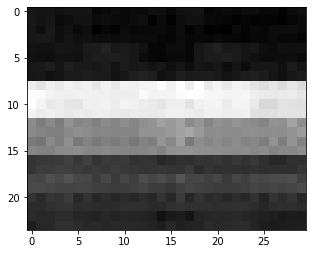

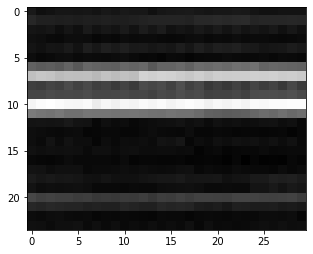

[16851/17000] loss_d: -0.396, loss_g: 1.298
[16852/17000] loss_d: -0.402, loss_g: 1.304
[16853/17000] loss_d: -0.424, loss_g: 1.414
[16854/17000] loss_d: -0.374, loss_g: 1.297
[16855/17000] loss_d: -0.383, loss_g: 1.341
[16856/17000] loss_d: -0.383, loss_g: 1.287
[16857/17000] loss_d: -0.368, loss_g: 1.288
[16858/17000] loss_d: -0.374, loss_g: 1.284
[16859/17000] loss_d: -0.365, loss_g: 1.287
[16860/17000] loss_d: -0.374, loss_g: 1.287
[16861/17000] loss_d: -0.380, loss_g: 1.328
[16862/17000] loss_d: -0.379, loss_g: 1.398
[16863/17000] loss_d: -0.359, loss_g: 1.299
[16864/17000] loss_d: -0.338, loss_g: 1.401
[16865/17000] loss_d: -0.389, loss_g: 1.332
[16866/17000] loss_d: -0.354, loss_g: 1.277
[16867/17000] loss_d: -0.399, loss_g: 1.352
[16868/17000] loss_d: -0.380, loss_g: 1.343
[16869/17000] loss_d: -0.380, loss_g: 1.368
[16870/17000] loss_d: -0.370, loss_g: 1.343
[16871/17000] loss_d: -0.411, loss_g: 1.309
[16872/17000] loss_d: -0.401, loss_g: 1.344
[16873/17000] loss_d: -0.360, lo

<Figure size 432x288 with 0 Axes>

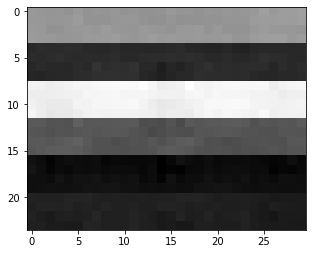

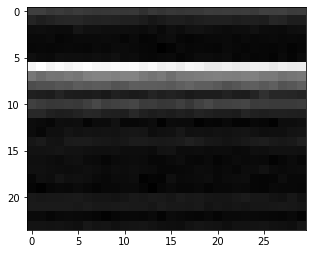

[16901/17000] loss_d: -0.380, loss_g: 1.333
[16902/17000] loss_d: -0.391, loss_g: 1.339
[16903/17000] loss_d: -0.389, loss_g: 1.330
[16904/17000] loss_d: -0.390, loss_g: 1.338
[16905/17000] loss_d: -0.351, loss_g: 1.357
[16906/17000] loss_d: -0.370, loss_g: 1.265
[16907/17000] loss_d: -0.383, loss_g: 1.209
[16908/17000] loss_d: -0.385, loss_g: 1.298
[16909/17000] loss_d: -0.416, loss_g: 1.297
[16910/17000] loss_d: -0.414, loss_g: 1.356
[16911/17000] loss_d: -0.362, loss_g: 1.331
[16912/17000] loss_d: -0.386, loss_g: 1.255
[16913/17000] loss_d: -0.402, loss_g: 1.288
[16914/17000] loss_d: -0.401, loss_g: 1.293
[16915/17000] loss_d: -0.405, loss_g: 1.342
[16916/17000] loss_d: -0.396, loss_g: 1.256
[16917/17000] loss_d: -0.375, loss_g: 1.321
[16918/17000] loss_d: -0.389, loss_g: 1.227
[16919/17000] loss_d: -0.387, loss_g: 1.261
[16920/17000] loss_d: -0.368, loss_g: 1.208
[16921/17000] loss_d: -0.380, loss_g: 1.264
[16922/17000] loss_d: -0.406, loss_g: 1.202
[16923/17000] loss_d: -0.380, lo

<Figure size 432x288 with 0 Axes>

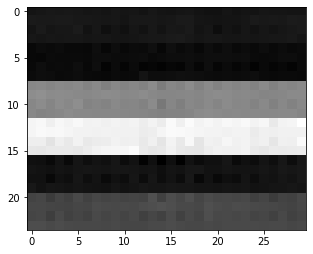

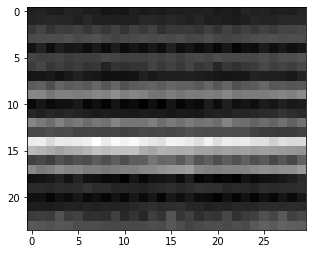

[16951/17000] loss_d: -0.374, loss_g: 1.341
[16952/17000] loss_d: -0.379, loss_g: 1.246
[16953/17000] loss_d: -0.383, loss_g: 1.330
[16954/17000] loss_d: -0.407, loss_g: 1.278
[16955/17000] loss_d: -0.358, loss_g: 1.313
[16956/17000] loss_d: -0.360, loss_g: 1.205
[16957/17000] loss_d: -0.394, loss_g: 1.229
[16958/17000] loss_d: -0.366, loss_g: 1.257
[16959/17000] loss_d: -0.398, loss_g: 1.284
[16960/17000] loss_d: -0.380, loss_g: 1.262
[16961/17000] loss_d: -0.395, loss_g: 1.287
[16962/17000] loss_d: -0.388, loss_g: 1.219
[16963/17000] loss_d: -0.410, loss_g: 1.273
[16964/17000] loss_d: -0.404, loss_g: 1.209
[16965/17000] loss_d: -0.364, loss_g: 1.206
[16966/17000] loss_d: -0.383, loss_g: 1.206
[16967/17000] loss_d: -0.374, loss_g: 1.220
[16968/17000] loss_d: -0.386, loss_g: 1.209
[16969/17000] loss_d: -0.375, loss_g: 1.321
[16970/17000] loss_d: -0.408, loss_g: 1.246
[16971/17000] loss_d: -0.395, loss_g: 1.203
[16972/17000] loss_d: -0.394, loss_g: 1.240
[16973/17000] loss_d: -0.410, lo

<Figure size 432x288 with 0 Axes>

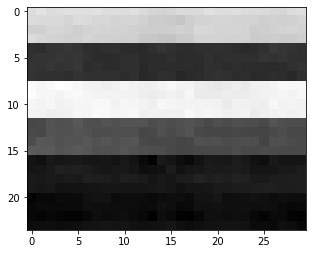

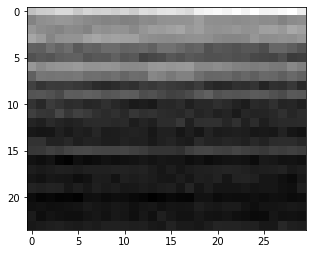

Optimization Finished!


In [10]:
model.train_model(
    x_train = data_alt_3_4,     
    y_train = label_alt_onehot,     
    keep_prob = 0.5,
    train_epoch = 17000, #17000
    n_critic = 5,
    step_valid = 50 #50
    )

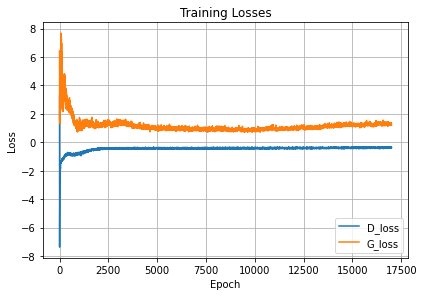

In [11]:
model.show_train_hist()